# ***#Preprocessing Our Image And Captions Data***


In [ ]:
!unzip /content/DIP.zip

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os
import gc
import chardet
import string
import re

In [ ]:
#Reading our caption CSV file
rawdata = open('/content/DIP/Thesis_Doodle_Files/CSV_File/Doodle_Caption_Data.csv', 'rb').read()
result = chardet.detect(rawdata)
encoding = result['encoding']
dbset = pd.read_csv("/content/DIP/Thesis_Doodle_Files/CSV_File/Doodle_Caption_Data.csv",
                   header=None, names=["image_name", "title"], encoding=encoding)
dbset.insert(0, "id", range(1, len(dbset) + 1))
pd.concat([dbset.head(2), dbset.tail(2)])

id image_name                                              title
0      1      0.png  (A) COLOUR royal blue new 100% Cotton Short Sl...
1      2      1.png  (A) COLOUR royal blue new 100% Cotton Short Sl...
698  699     98.png                 adidas black yellow jersey t shirt
699  700     99.png                 adidas black yellow jersey t shirt

In [ ]:
dbset.sample(4, random_state = 45) # randomly checking the contents of our file

id image_name                                              title
418  419    475.png         black and purple striped t-shirt for women
51    52    144.png                     adidas Originals Men's T-Shirt
331  332    397.png                       Be Legendary T-Shirt - Black
101  102     19.png  (Men's) Long sleeve polo-shirt, RED  GREY  DAR...

In [ ]:
# Here we are checking for puntuations in our caaptions
def check_punctuation(text):

    pattern = "[" + string.punctuation + "]"
    match = re.findall(pattern,text)

    if match:
        return ''.join(match)
    else:
        return ''.join(match)

In [ ]:
%%time
dbset['is_punctuation_exists'] = dbset['title'].apply(lambda x: check_punctuation(x))

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.63 ms


In [ ]:
dbset.is_punctuation_exists.value_counts()

           301
-          189
+           42
_           35
(')-,       14
--          14
()%          7
_--_-,       7
_--          7
---          7
_--_-        7
...          7
&.()         7
__           7
+-           7
(')-,,,      7
-(,)         7
,--          7
(),          7
'-           7
_--,,        7
Name: is_punctuation_exists, dtype: int64

In [ ]:
dbset[dbset.is_punctuation_exists.isin(['-'])].title.values

array(['adidas Condivo 21 Primeblue Long Sleeve T-Shirt',
       'adidas Condivo 21 Primeblue Long Sleeve T-Shirt',
       'adidas Condivo 21 Primeblue Long Sleeve T-Shirt',
       'adidas Condivo 21 Primeblue Long Sleeve T-Shirt',
       'adidas Condivo 21 Primeblue Long Sleeve T-Shirt',
       'adidas Condivo 21 Primeblue Long Sleeve T-Shirt',
       'adidas Condivo 21 Primeblue Long Sleeve T-Shirt',
       'adidas long sleeve yellow-blue striped football t shirt',
       'adidas long sleeve yellow-blue striped football t shirt',
       'adidas long sleeve yellow-blue striped football t shirt',
       'adidas long sleeve yellow-blue striped football t shirt',
       'adidas long sleeve yellow-blue striped football t shirt',
       'adidas long sleeve yellow-blue striped football t shirt',
       'adidas long sleeve yellow-blue striped football t shirt',
       'adidas long sleeve yellow-green football t shirt',
       'adidas long sleeve yellow-green football t shirt',
       'adidas

In [ ]:
# Function to remove punctuations and convert to lowercase
def process_title(title):
    # Remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    title = title.translate(translator)

    # Convert to lowercase
    title = title.lower()

    return title

# Apply the function to each row in the 'search_string' column
dbset['title'] = dbset['title'].apply(process_title)


dbset.head()

id image_name                                              title  \
0   1      0.png  a colour royal blue new 100 cotton short sleev...   
1   2      1.png  a colour royal blue new 100 cotton short sleev...   
2   3     10.png  mens long sleeve poloshirt pocket beige  orang...   
3   4    100.png                 adidas black yellow jersey t shirt   
4   5    101.png                 adidas black yellow jersey t shirt   

  is_punctuation_exists  
0                   ()%  
1                   ()%  
2               (')-,,,  
3                        
4

In [ ]:
%%time
dbset['is_punctuation_exists'] = dbset['title'].apply(lambda x: check_punctuation(x))
dbset.is_punctuation_exists.value_counts()

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.87 ms


    700
Name: is_punctuation_exists, dtype: int64

In [ ]:
dbset.head()

id image_name                                              title  \
0   1      0.png  a colour royal blue new 100 cotton short sleev...   
1   2      1.png  a colour royal blue new 100 cotton short sleev...   
2   3     10.png  mens long sleeve poloshirt pocket beige  orang...   
3   4    100.png                 adidas black yellow jersey t shirt   
4   5    101.png                 adidas black yellow jersey t shirt   

  is_punctuation_exists  
0                        
1                        
2                        
3                        
4

In [ ]:
dbset.drop(['is_punctuation_exists'], axis = 1, inplace=True)
dbset.columns

Index(['id', 'image_name', 'title'], dtype='object')

In [ ]:
# Let's look for item where title has word with only one char (which are not stopwords) and create a dictonary
# Reason to do this is like in a case we had "t" word which could meanse "the".
# So it's possible that words other then "a" is short form of other word that we can understand by reading the test of the title.

#List of word with 1 and 2 char except stopwords

def contain_word_with_single_char(dbset, colname = 'title'):

    stopwords = ['an', 'be', 'do', 'of', 'is', 's', 'uk', 'im','hm','us', '3d', 'am','v', 'or', 'as', 'we', 'me','up', 'to', 'no', 'at', 'in', 'on', 'so', 'he',  'i', 't', 'if', 'my', 'a', 'by', 'it' ]

    dict_item_with_single_char_caption = {}

    for image_name, title in zip(dbset['image_name'], dbset[colname]):

        #Search in text have only one char or have text has word with only 2 char
        match = re.findall(r'\b[\w]{1,2}\s', title)
        if match:

            match = [item.strip() for item in match if not item.strip() in stopwords]
            if len(match) > 0:

                if image_name not in dict_item_with_single_char_caption:
                    dict_item_with_single_char_caption[image_name] = []

                dict_item_with_single_char_caption[image_name] = dict_item_with_single_char_caption[image_name] + match


        #Search if the text has numeric
        match = re.findall(r'\d+', title)
        if match:

            match = [item.strip() for item in match if not item.strip() in stopwords]
            if len(match) > 0 :

                if image_name not in dict_item_with_single_char_caption:
                    dict_item_with_single_char_caption[image_name] = []

                dict_item_with_single_char_caption[image_name] = dict_item_with_single_char_caption[image_name] + match

    return dict_item_with_single_char_caption

In [ ]:
dict_item_with_single_char_caption = contain_word_with_single_char(dbset)

In [ ]:
len(dict_item_with_single_char_caption.keys())

147

In [ ]:
dict_item_with_single_char_caption

{'0.png': ['100'],
 '1.png': ['100'],
 '105.png': ['21', '21'],
 '106.png': ['21', '21'],
 '107.png': ['21', '21'],
 '108.png': ['21', '21'],
 '109.png': ['21', '21'],
 '110.png': ['21', '21'],
 '111.png': ['21', '21'],
 '154.png': ['15', 'ls', '15'],
 '155.png': ['15', 'ls', '15'],
 '156.png': ['15', 'ls', '15'],
 '157.png': ['15', 'ls', '15'],
 '158.png': ['15', 'ls', '15'],
 '159.png': ['15', 'ls', '15'],
 '160.png': ['15', 'ls', '15'],
 '161.png': ['15', '15', '17194'],
 '162.png': ['15', '15', '17194'],
 '163.png': ['15', '15', '17194'],
 '164.png': ['15', '15', '17194'],
 '165.png': ['15', '15', '17194'],
 '166.png': ['15', '15', '17194'],
 '167.png': ['15', '15', '17194'],
 '168.png': ['15', '15'],
 '169.png': ['15', '15'],
 '170.png': ['15', '15'],
 '171.png': ['15', '15'],
 '172.png': ['15', '15'],
 '173.png': ['15', '15'],
 '174.png': ['15', '15'],
 '175.png': ['21', '21'],
 '176.png': ['21', '21'],
 '177.png': ['21', '21'],
 '178.png': ['21', '21'],
 '179.png': ['21', '21'],

In [ ]:
# Replace unwanted words and numeric values in the 'search_string' column
for image_name, unwanted_words in dict_item_with_single_char_caption.items():
    mask = dbset['image_name'] == image_name
    dbset.loc[mask, 'title'] = dbset.loc[mask, 'title'].apply(
        lambda x: ' '.join(['' if word in unwanted_words or (re.match(r'^[0-9]+$', word) and len(word.strip('\'')) == 1) else word for word in re.findall(r'\b\w+\b', x)])
    )

# Remove all numeric values from 'search_string' column
dbset['title'] = dbset['title'].apply(lambda x: re.sub(r'\b[0-9]+\b', '', x))
dbset['title'] = dbset['title'].apply(lambda x: re.sub(r'\b\'[0-9]+\'\b', '', x))
dbset['title'] = dbset['title'].apply(lambda x: re.sub(r'\d+', '', x))

# Display the updated DataFrame
print(dbset)


      id image_name                                              title
0      1      0.png  a colour royal blue new  cotton short sleeve t...
1      2      1.png  a colour royal blue new  cotton short sleeve t...
2      3     10.png  mens long sleeve poloshirt pocket beige  orang...
3      4    100.png                 adidas black yellow jersey t shirt
4      5    101.png                 adidas black yellow jersey t shirt
..   ...        ...                                                ...
695  696     95.png                   adidas black pink jersey t shirt
696  697     96.png                   adidas black pink jersey t shirt
697  698     97.png                   adidas black pink jersey t shirt
698  699     98.png                 adidas black yellow jersey t shirt
699  700     99.png                 adidas black yellow jersey t shirt

[700 rows x 3 columns]


In [ ]:
# Replace unwanted words and numeric values in the 'search_string' column
for image_name, unwanted_words in dict_item_with_single_char_caption.items():
    mask = dbset['image_name'] == image_name
    dbset.loc[mask, 'title'] = dbset.loc[mask, 'title'].apply(
        lambda x: ' '.join(['' if word in unwanted_words or word.isdigit() else word for word in x.split()])
    )

# Display the updated DataFrame
print(dbset)

      id image_name                                              title
0      1      0.png  a colour royal blue new cotton short sleeve ts...
1      2      1.png  a colour royal blue new cotton short sleeve ts...
2      3     10.png  mens long sleeve poloshirt pocket beige  orang...
3      4    100.png                 adidas black yellow jersey t shirt
4      5    101.png                 adidas black yellow jersey t shirt
..   ...        ...                                                ...
695  696     95.png                   adidas black pink jersey t shirt
696  697     96.png                   adidas black pink jersey t shirt
697  698     97.png                   adidas black pink jersey t shirt
698  699     98.png                 adidas black yellow jersey t shirt
699  700     99.png                 adidas black yellow jersey t shirt

[700 rows x 3 columns]


In [ ]:
dbset[dbset['image_name'].isin(['130.png', '696.png', '132.png', '3171.png'])]

id image_name                                              title
36    37    130.png  adidas long sleeve yellowblue striped football...
38    39    132.png  adidas long sleeve yellowblue striped football...
663  664    696.png  blue  black stripe longsleeve tshirt  striped ...

In [ ]:
# Replace unwanted words and numeric values in the 'search_string' column
for image_name, unwanted_words in dict_item_with_single_char_caption.items():
    mask = dbset['image_name'] == image_name
    dbset.loc[mask, 'title'] = dbset.loc[mask, 'title'].apply(
        lambda x: ' '.join(['' if word in unwanted_words or word.isdigit() else word for word in x.split()])
    )

# Display the updated DataFrame
print(dbset)

      id image_name                                              title
0      1      0.png  a colour royal blue new cotton short sleeve ts...
1      2      1.png  a colour royal blue new cotton short sleeve ts...
2      3     10.png  mens long sleeve poloshirt pocket beige  orang...
3      4    100.png                 adidas black yellow jersey t shirt
4      5    101.png                 adidas black yellow jersey t shirt
..   ...        ...                                                ...
695  696     95.png                   adidas black pink jersey t shirt
696  697     96.png                   adidas black pink jersey t shirt
697  698     97.png                   adidas black pink jersey t shirt
698  699     98.png                 adidas black yellow jersey t shirt
699  700     99.png                 adidas black yellow jersey t shirt

[700 rows x 3 columns]


In [ ]:
dict_item_with_single_char_caption = contain_word_with_single_char(dbset)
dict_item_with_single_char_caption

{}

In [ ]:
# Total number of unique words in total captions
def create_vocabulary(data, feature = 'caption'):

  vocab = []

  for captions in data[feature].values:
    vocab.extend(captions.split())

  return vocab

In [ ]:
vocabulary = create_vocabulary(dbset, 'title')
print("Vocabulary Size on train : {}".format(len(set(vocabulary))))

Vocabulary Size on train : 240


In [ ]:
#Counting total words per caption
def df_word_count(data, vocabulary):

    ct = Counter(vocabulary)

    appen_1 = []
    appen_2 = []

    for i in ct.keys():
        appen_1.append(i)

    for j in ct.values():
        appen_2.append(j)

    data = {"word":appen_1 , "count": appen_2}

    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]

    return dfword, ct


In [ ]:
train_word_cnt, word_could_dict = df_word_count(dbset, vocabulary)
word_could_dict = { x: count for x, count in word_could_dict.items() if count == 1 }

In [ ]:
train_word_cnt.shape[0]

240

In [ ]:
train_word_cnt[:10]

word  count
0    shirt    357
1    black    273
2   tshirt    266
3        t    252
4   sleeve    231
5  striped    203
6    women    189
7      for    175
8      and    168
9     long    133

In [ ]:
train_word_cnt[train_word_cnt['count'] == 1]

Empty DataFrame
Columns: [word, count]
Index: []

In [ ]:
def plthist(dfsub, title="The top 50 most frequently appearing words"):

    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='g')
    plt.yticks(fontsize=20,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

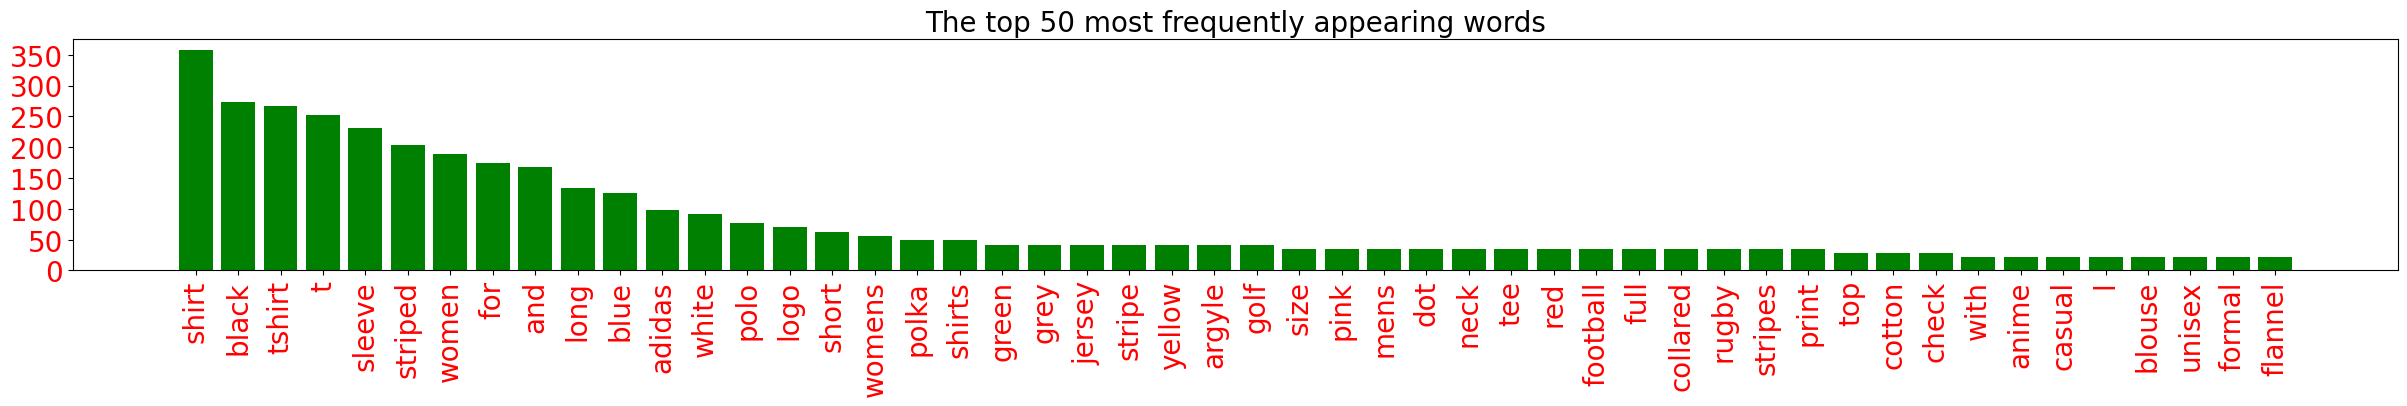

In [ ]:
topn = 50

plthist(train_word_cnt.iloc[:topn,:], title = str.format(f"The top {topn} most frequently appearing words"))

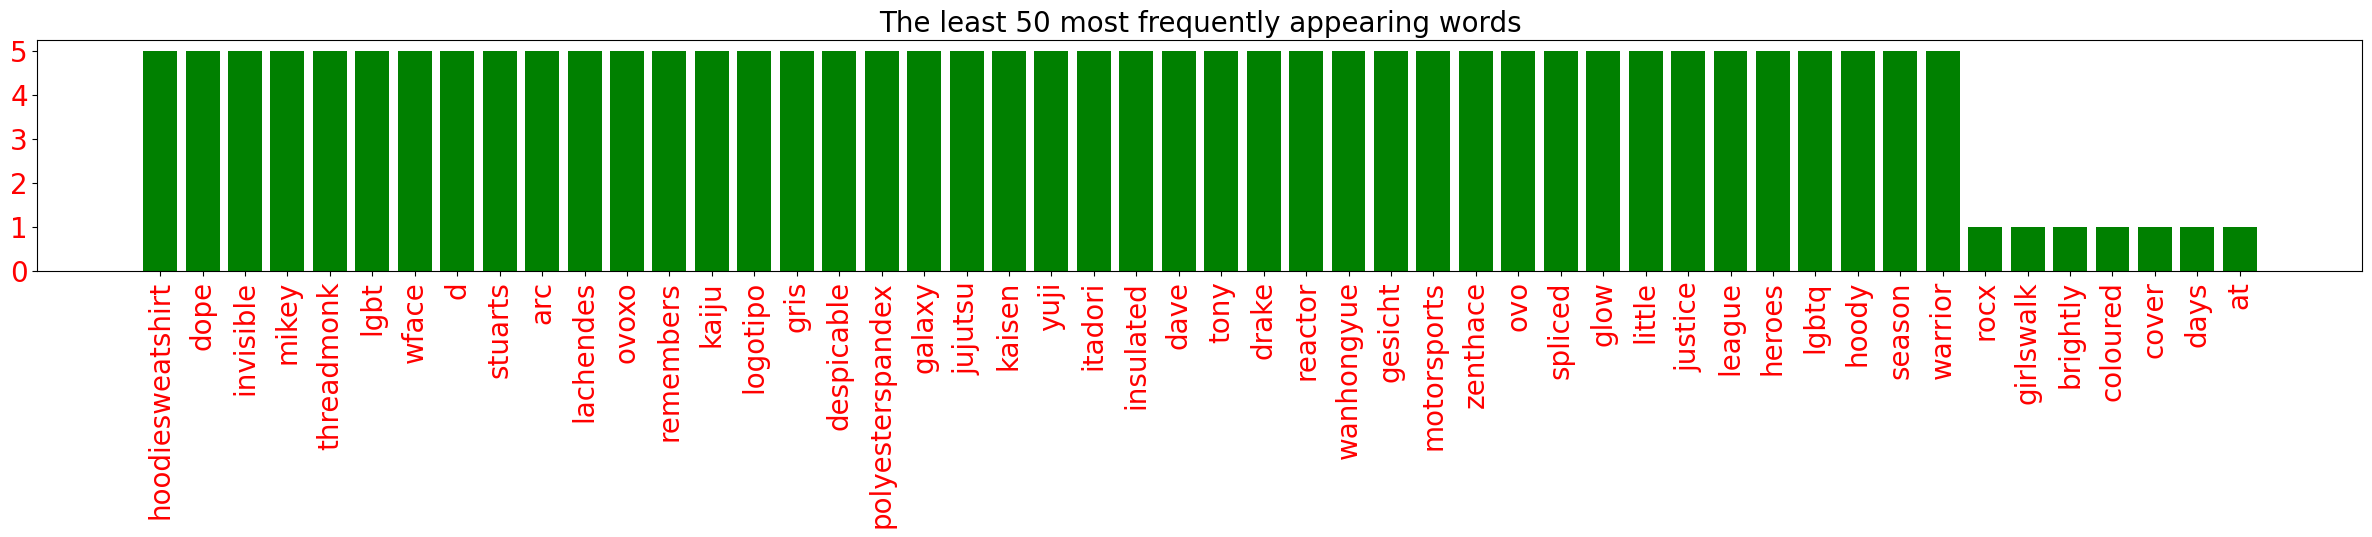

In [ ]:
topn = 50

plthist(train_word_cnt.iloc[-topn:,:], title = str.format(f"The least {topn} most frequently appearing words"))

In [ ]:
# Check for extra spaces in the 'search_string' column
mask_extra_spaces = dbset['title'].str.contains('\s{2,}')

# Display rows with extra spaces
print(dbset[mask_extra_spaces])

# Remove extra spaces in the 'search_string' column
dbset['title'] = dbset['title'].str.replace('\s{2,}', ' ', regex=True)

# Display the updated DataFrame
print(dbset)

      id image_name                                              title
2      3     10.png  mens long sleeve poloshirt pocket beige  orang...
13    14     11.png  mens long sleeve poloshirt pocket beige  orang...
24    25     12.png  mens long sleeve poloshirt pocket beige  orang...
35    36     13.png  mens long sleeve poloshirt pocket beige  orang...
46    47     14.png  mens long sleeve poloshirt red  grey  dark gre...
..   ...        ...                                                ...
665  666    698.png  blue  black stripe longsleeve tshirt  striped ...
666  667    699.png  blue  black stripe longsleeve tshirt  striped ...
667  668      7.png  mens long sleeve poloshirt pocket beige  orang...
678  679      8.png  mens long sleeve poloshirt pocket beige  orang...
689  690      9.png  mens long sleeve poloshirt pocket beige  orang...

[63 rows x 3 columns]
      id image_name                                              title
0      1      0.png  a colour royal blue new cotton sh

In [ ]:
# !pip install word2number

In [ ]:
from word2number import w2n

#this funtion removes numbers and size of the clothing
def remove_numbers_and_size(text):
    # Remove numeric values
    text = re.sub(r'\b\d+\b', '', text)

    # Convert one-digit numeric numbers to words
    text = re.sub(r'\b(\d)\b', lambda x: w2n.word_to_num(x.group(1)), text)

    # Remove sizes like "32mm"
    text = re.sub(r'\b\d+(?:mm|cm|inch|k)\b', '', text)
    text = re.sub(r'[\d+\s+]+plus', '', text)
    text = re.sub(r'[\d+\s+]+pro' , '', text)
    text = re.sub(r'\d{2,}' , '', text)
    text = re.sub(r'\d+' , '', text)



    return text

def remove_repeated_words(text):
    words = text.split()
    unique_words = set(words)
    return ' '.join(unique_words)

# Apply the functions to the 'search_string' column
dbset['title'] = dbset['title'].apply(remove_numbers_and_size)
dbset['title'] = dbset['title'].apply(remove_repeated_words)

# Display the updated DataFrame
print(dbset)

      id image_name                                              title
0      1      0.png  royal a new sleeve men cotton blue colour shor...
1      2      1.png  royal a new sleeve men cotton blue colour shor...
2      3     10.png  beige pocket sleeve mens double stripes polosh...
3      4    100.png                 black t shirt adidas yellow jersey
4      5    101.png                 black t shirt adidas yellow jersey
..   ...        ...                                                ...
695  696     95.png                   black t pink shirt adidas jersey
696  697     96.png                   black t pink shirt adidas jersey
697  698     97.png                   black t pink shirt adidas jersey
698  699     98.png                 black t shirt adidas yellow jersey
699  700     99.png                 black t shirt adidas yellow jersey

[700 rows x 3 columns]


In [ ]:
# Replace unwanted words and numeric values in the 'search_string' column
for image_name, unwanted_words in dict_item_with_single_char_caption.items():
    mask = dbset['image_name'] == image_name
    dbset.loc[mask, 'title'] = dbset.loc[mask, 'title'].apply(
        lambda x: ' '.join(['' if word in unwanted_words or word.isdigit() else word for word in x.split()])
    )

# Display the updated DataFrame
print(dbset)

      id image_name                                              title
0      1      0.png  royal a new sleeve men cotton blue colour shor...
1      2      1.png  royal a new sleeve men cotton blue colour shor...
2      3     10.png  beige pocket sleeve mens double stripes polosh...
3      4    100.png                 black t shirt adidas yellow jersey
4      5    101.png                 black t shirt adidas yellow jersey
..   ...        ...                                                ...
695  696     95.png                   black t pink shirt adidas jersey
696  697     96.png                   black t pink shirt adidas jersey
697  698     97.png                   black t pink shirt adidas jersey
698  699     98.png                 black t shirt adidas yellow jersey
699  700     99.png                 black t shirt adidas yellow jersey

[700 rows x 3 columns]


In [ ]:
# Replace unwanted words and numeric values in the 'search_string' column
for image_name, unwanted_words in dict_item_with_single_char_caption.items():
    mask = dbset['image_name'] == image_name
    dbset.loc[mask, 'title'] = dbset.loc[mask, 'title'].apply(
        lambda x: ' '.join(['' if word in unwanted_words or word.isdigit() else word for word in x.split()])
    )

# Display the updated DataFrame
print(dbset)

      id image_name                                              title
0      1      0.png  royal a new sleeve men cotton blue colour shor...
1      2      1.png  royal a new sleeve men cotton blue colour shor...
2      3     10.png  beige pocket sleeve mens double stripes polosh...
3      4    100.png                 black t shirt adidas yellow jersey
4      5    101.png                 black t shirt adidas yellow jersey
..   ...        ...                                                ...
695  696     95.png                   black t pink shirt adidas jersey
696  697     96.png                   black t pink shirt adidas jersey
697  698     97.png                   black t pink shirt adidas jersey
698  699     98.png                 black t shirt adidas yellow jersey
699  700     99.png                 black t shirt adidas yellow jersey

[700 rows x 3 columns]


In [ ]:
dict_item_with_single_char_caption = contain_word_with_single_char(dbset)
dict_item_with_single_char_caption

{}

In [ ]:
def count_words(x):

    cnt = Counter(x.split())
    return sum(cnt.values())

In [ ]:
dbset['word_cnt'] = dbset.title.apply(lambda x: count_words(x))

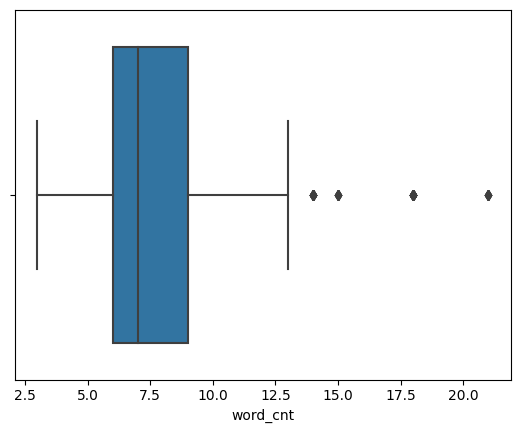

In [ ]:
sns.boxplot( x = dbset["word_cnt"])
plt.show()

In [ ]:
dbset.word_cnt.describe()

count    700.000000
mean       7.710000
std        3.313848
min        3.000000
25%        6.000000
50%        7.000000
75%        9.000000
max       21.000000
Name: word_cnt, dtype: float64

(665, 4)


<Axes: xlabel='word_cnt'>

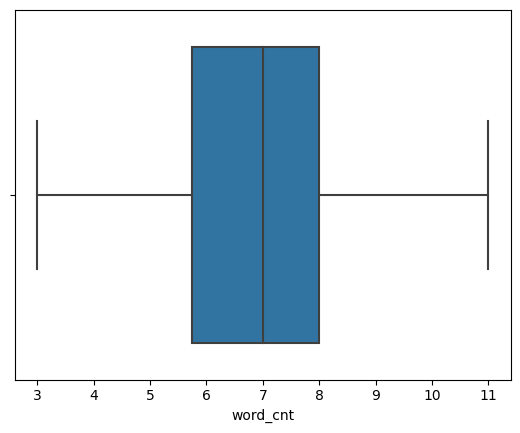

In [ ]:
print(dbset[dbset["word_cnt"] < 15].shape)

sns.boxplot(x=dbset[dbset["word_cnt"] < 12]["word_cnt"])

In [ ]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.90
VAL_RATIO = 0.05
TEST_RATIO = 0.05
SEED = 2024

#Split for train dataset
db_train, db_test, _, _ = train_test_split(dbset, dbset.title,
                                         train_size = TRAIN_RATIO,
                                         random_state = SEED,
                                         shuffle = True)

#Split for Valid and test dataset
db_valid, db_test, _, _ = train_test_split(db_test, db_test.title,
                                         test_size = TEST_RATIO,
                                         random_state = SEED,
                                         shuffle = True)

In [ ]:
set(db_valid['image_name']).intersection(set(db_train['image_name']))

set()

In [ ]:
set(db_train['image_name']).intersection(set(db_test['image_name']))

set()

In [ ]:
print(f'Number of records in train : {db_train.shape[0]}')
print(f'Number of records in Valid : {db_valid.shape[0]}')
print(f'Number of records in test : {db_test.shape[0]}')
print(f'Total records: {db_train.shape[0] + db_valid.shape[0] + db_test.shape[0]} ')

dbset.shape #Number of records in original dataset

Number of records in train : 630
Number of records in Valid : 66
Number of records in test : 4
Total records: 700 


(700, 4)

In [ ]:
cnt = 12 # Change
db_train.drop(db_train[db_train.word_cnt > cnt].index , inplace = True)
db_valid.drop(db_valid[db_valid.word_cnt > cnt].index , inplace = True)
db_test.drop(db_test[db_test.word_cnt > cnt].index , inplace = True)

In [ ]:
db_train['word_cnt'].describe()

count    580.000000
mean       6.975862
std        2.060259
min        3.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       12.000000
Name: word_cnt, dtype: float64

In [ ]:
db_valid['word_cnt'].describe()

count    60.000000
mean      6.883333
std       2.067437
min       3.000000
25%       5.000000
50%       7.000000
75%       8.000000
max      12.000000
Name: word_cnt, dtype: float64

In [ ]:
db_test['word_cnt'].describe()

count    4.00
mean     5.25
std      1.50
min      3.00
25%      5.25
50%      6.00
75%      6.00
max      6.00
Name: word_cnt, dtype: float64

In [ ]:
# Checking our train, test and validate shapes
db_train.drop(columns = ['word_cnt'], inplace = True)
db_valid.drop(columns = ['word_cnt'], inplace = True)
db_test.drop(columns = ['word_cnt'], inplace = True)

(db_train.shape, db_valid.shape, db_test.shape)

((580, 3), (60, 3), (4, 3))

In [ ]:
#We are creating parquet file to save our RAM. Or else the kernel crashes due to excessive load
PROJECT_ROOT = "/content/"
db_train.to_parquet(os.path.join(PROJECT_ROOT, 'train_data_processed.parquet'))

db_valid.to_parquet(os.path.join(PROJECT_ROOT, 'validate_data_processed.parquet'))

db_test.to_parquet(os.path.join(PROJECT_ROOT,  'test_data_processed.parquet'))

Data Preprocessing

In [ ]:
x_train = db_train.copy()
x_valid = db_valid.copy()
x_test = db_test.copy()

In [ ]:
filename = "content/DIP/Thesis_Doodle_Files/"

In [ ]:
x_train['image_path'] = x_train['image_name'].apply(lambda x : os.path.join(filename, x))
x_valid['image_path'] = x_valid['image_name'].apply(lambda x : os.path.join(filename, x))
x_test['image_path'] = x_test['image_name'].apply(lambda x : os.path.join(filename, x))
#We are connecting the path to our image with their corresponding captions

In [ ]:
x_train.head()

id image_name                                              title  \
189      190   4333.png                           dot polka magenta blouse   
2083    2084   8323.png                          detail crop lace top blue   
8614    8615   2319.png  shirt boyfriend size relaxed womens coral flan...   
11873  11874  12021.png                                      plaid magenta   
7097    7098   1577.png                                shirt green striped   

                                      image_path  
189     content/DIP/Thesis_Doodle_Files/4333.png  
2083    content/DIP/Thesis_Doodle_Files/8323.png  
8614    content/DIP/Thesis_Doodle_Files/2319.png  
11873  content/DIP/Thesis_Doodle_Files/12021.png  
7097    content/DIP/Thesis_Doodle_Files/1577.png

In [ ]:
x_valid.head()

id image_name                                              title  \
11387  11388  13277.png                        top printed lemongrass crop   
2712    2713   9926.png               shirt and white long red sleeve blue   
6742    6743   5276.png  champion leeve logo red with tshirt heritage s...   
767      768  11504.png                  and white women striped black for   
12367  12368   3074.png  shirt lauren polo ralph t collared long sweats...   

                                      image_path  
11387  content/DIP/Thesis_Doodle_Files/13277.png  
2712    content/DIP/Thesis_Doodle_Files/9926.png  
6742    content/DIP/Thesis_Doodle_Files/5276.png  
767    content/DIP/Thesis_Doodle_Files/11504.png  
12367   content/DIP/Thesis_Doodle_Files/3074.png

In [ ]:
dbset['title'].isnull().sum() #checking for any null values

0

In [ ]:
dbset['image_path'] = dbset['image_name'].apply(lambda x : os.path.join(filename, x))

In [ ]:
dbset.head()

id image_name                                              title  word_cnt  \
0   1   2492.png  uniquely tunic back asymmetrical sleeveless wo...         7   
1   2   4870.png  spaghetti crop hot fuchsia with top peplum pin...         9   
2   3   5150.png  minion minions graphic a dave despicable unise...        11   
3   4   3793.png                            maroon printed top crop         4   
4   5   3134.png                             womens lavender tshirt         3   

                                 image_path  
0  content/DIP/Thesis_Doodle_Files/2492.png  
1  content/DIP/Thesis_Doodle_Files/4870.png  
2  content/DIP/Thesis_Doodle_Files/5150.png  
3  content/DIP/Thesis_Doodle_Files/3793.png  
4  content/DIP/Thesis_Doodle_Files/3134.png

In [ ]:
dbset[['id', 'title', 'image_name']].to_parquet(os.path.join(PROJECT_ROOT, 'images_metadata_clr.parquet'))
#saving the iamge id, title and image name to a parquet file

Randomly looking at Images

In [ ]:
dbset = pd.read_parquet(os.path.join(PROJECT_ROOT, 'images_metadata_clr.parquet'))

sample_db = dbset.sample(5, random_state = 42)

In [ ]:
sample_db.head()

id                                  title image_name
7063  7064   shirt and grey vertical striped blue   8708.png
8387  8388    coat navy italian in cashmere chore   9431.png
1978  1979           light denim cropped top blue   5189.png
3601  3602  neck womens indigo cotton tshirt crew   2296.png
6346  6347                            hoodie fire  11980.png

In [ ]:
#Our main image folder
IMAGE_BASE_FOLDER = os.path.join(PROJECT_ROOT, 'Thesis_Doodle_Files')

In [ ]:
def show_image(image_name, resize = False, scale = False):

    image_path = os.path.join(IMAGE_BASE_FOLDER, image_name)

    img = Image.open(image_path) #We can just use Image.open to see the image. But our end goal is to store np array. So sample code to check if that is possible
    if img.mode != "RGB":  # Check if image is not already in RGB mode
        img = img.convert("RGB")

    if resize == True:
        img = img.resize((1024, 1024))

    img_arr = np.array(img)

    if scale == True:
        img_arr = img_arr/255

    plt.imshow(img_arr)

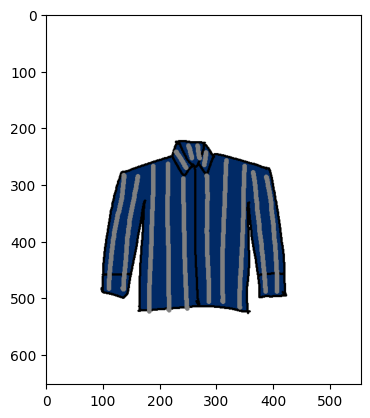

In [ ]:
show_image(sample_db.iloc[0]['image_name'])
# We are viewing the original cropped image

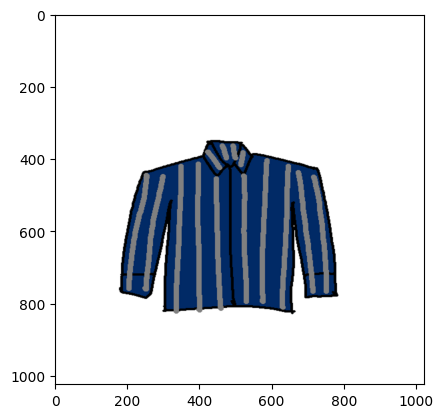

In [ ]:
show_image(sample_db.iloc[0]['image_name'], resize = True)
#We resize the image to (1024, 1024)

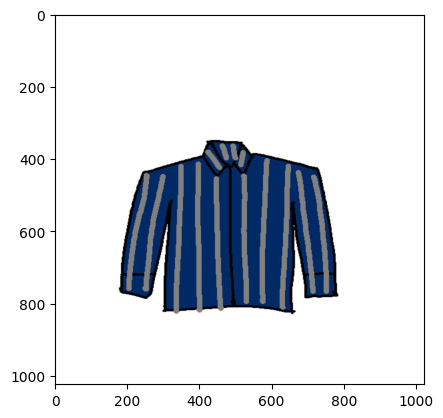

In [ ]:
show_image(sample_db.iloc[0]['image_name'], resize = True, scale = True)
#Scaling the image

In [ ]:
# Here we are saving all our test, train and validate data to our parquet files
TRAIN_DATA_FILE = os.path.join(PROJECT_ROOT, 'train_data.parquet')
x_train.to_parquet(TRAIN_DATA_FILE)

VALID_DATA_HDF5_FILE = os.path.join(PROJECT_ROOT, 'validate_data.parquet')
x_valid.to_parquet(VALID_DATA_HDF5_FILE)

TEST_DATA_HDF5_FILE = os.path.join(PROJECT_ROOT,'test_data.parquet')
x_test.to_parquet(TEST_DATA_HDF5_FILE)

In [ ]:
del [dbset, x_train, x_valid,x_test]
gc.collect()

31088

Convert the images to numpy array and it's metadata to hdf5 format

In [ ]:
# %cd content/

In [ ]:
import process_image as pi

In [ ]:
#We are converting images to numpy array
#train dataset
file_name = 'content/DIP/train_data.parquet'
batch_size = 300

!python preprocess_images.py -d {file_name} -b {batch_size}


[INFO]: Process to read the content/DIP/train_data.parquet, convert images to numpy array and store. Started...
[INFO]: Process data range 0:300 started.
[INFO]: Create shared memory resource for numpy image data.
[INFO]: Shared memory resource created sucessfully.
[INFO]: Create shared memory resource for int image id data.
[INFO]: Shared memory resource created sucessfully.
[INFO]: Sucessfully created shared memory resource.
[INFO]: Starting Pool process...
[INFO]: Started saving data to hdf5 format...
[INFO]: Saved shared memory array to hdf5 started.
[INFO]: Saved shared memory array to hdf5 completed.
[INFO]: Process data range 0:300 completed.
[INFO]: Process data range 300:600 started.
[INFO]: Shared memory np_image_data_array already exsts. Access to created resource
[INFO]: Shared memory np_image_id_array already exsts. Access to created resource
[INFO]: Sucessfully created shared memory resource.
[INFO]: Starting Pool process...
[INFO]: Started saving data to hdf5 format...
[


100%|##########| 39/39 [07:14<00:00, 11.13s/it]

100%|##########| 39/39 [08:59<00:00, 13.84s/it]

100%|##########| 39/39 [00:00<00:00, 210.38it/s]


In [ ]:
#validate dataset
file_name = 'content/DIP/validate_data.parquet'
batch_size = 300

!python preprocess_images.py -d {file_name} -b {batch_size}

[INFO]: Process to read the content/DIP/validate_data.parquet, convert images to numpy array and store. Started...
[INFO]: Process data range 0:300 started.
[INFO]: Create shared memory resource for numpy image data.
[INFO]: Shared memory resource created sucessfully.
[INFO]: Create shared memory resource for int image id data.
[INFO]: Shared memory resource created sucessfully.
[INFO]: Sucessfully created shared memory resource.
[INFO]: Starting Pool process...
[INFO]: Started saving data to hdf5 format...
[INFO]: Saved shared memory array to hdf5 started.
[INFO]: Saved shared memory array to hdf5 completed.
[INFO]: Process data range 0:300 completed.
[INFO]: Process data range 300:600 started.
[INFO]: Shared memory np_image_data_array already exsts. Access to created resource
[INFO]: Shared memory np_image_id_array already exsts. Access to created resource
[INFO]: Sucessfully created shared memory resource.
[INFO]: Starting Pool process...
[INFO]: Started saving data to hdf5 format..


100%|##########| 5/5 [00:46<00:00,  9.35s/it]

100%|##########| 5/5 [00:57<00:00, 11.42s/it]

100%|##########| 5/5 [00:00<00:00, 250.85it/s]


In [ ]:
#test dataset
file_name = 'content/DIP/test_data.parquet'
batch_size = 300

!python preprocess_images.py -d {file_name} -b {batch_size}

[INFO]: Process to read the content/DIP/test_data.parquet, convert images to numpy array and store. Started...
[INFO]: Process data range 0:300 started.
[INFO]: Create shared memory resource for numpy image data.
[INFO]: Shared memory resource created sucessfully.
[INFO]: Create shared memory resource for int image id data.
[INFO]: Shared memory resource created sucessfully.
[INFO]: Sucessfully created shared memory resource.
[INFO]: Starting Pool process...
[INFO]: Started saving data to hdf5 format...
[INFO]: Saved shared memory array to hdf5 started.
[INFO]: Saved shared memory array to hdf5 completed.
[INFO]: Process data range 0:300 completed.
[INFO]: Process to convert images to numpy array and store in seperate files. Completed.
[INFO]: Combine multiple hdf5 files into one started...
[INFO]: Combine multiple hdf5 files. Paramaters: file_pattern - test_data, search_in_folder - content/DIP
[INFO]: Combine multiple hdf5 files completed. Saved at: content/DIP\test_data.h5
[INFO]: De


100%|##########| 1/1 [00:03<00:00,  3.05s/it]

100%|##########| 1/1 [00:03<00:00,  3.26s/it]

100%|##########| 1/1 [00:00<00:00, 1003.42it/s]


In [ ]:
import h5py

def show_image_hdf5(index = 0, name = 'test'):

    #HDF5_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'processed', name +'_data.h5')
    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, name)
    # HDF5_FILEPATH = os.path.join('DIP', name)
    x_name = 'np_image' #'x_' + name
    y_name = 'id_image' #'y_' + name

    with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file:

        cnt = hdf5_file[x_name].shape[0]
        print(f'Records in {name} dataset: {cnt}')

        image = hdf5_file[x_name][index]
        image = (image*255).astype(int) #Since the image data stored will be normalize format, we shall convert them back in range of 0 to 255 and then view


        print(f'Image id: {hdf5_file[y_name][index]}')
        plt.imshow(image)
        plt.show()

Records in train_data.h5 dataset: 11655
Image id: 1841


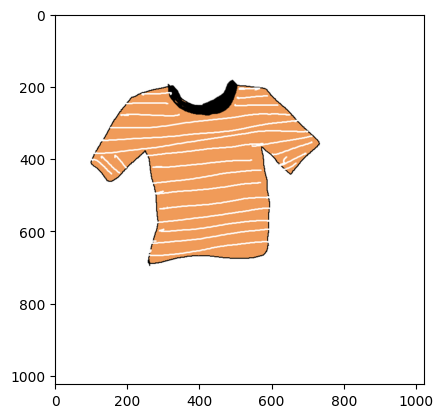

In [ ]:
show_image_hdf5(220, 'train_data.h5')

Records in test_data.h5 dataset: 68
Image id: 10190


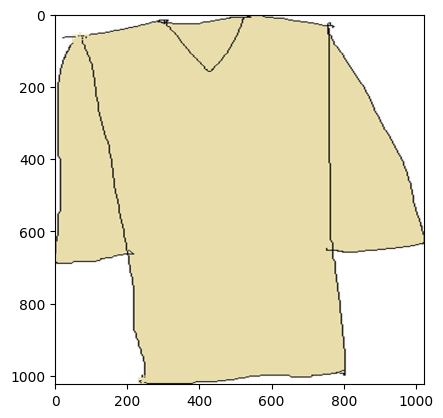

In [ ]:
show_image_hdf5(0, 'test_data.h5')

Records in validate_data.h5 dataset: 1227
Image id: 12649


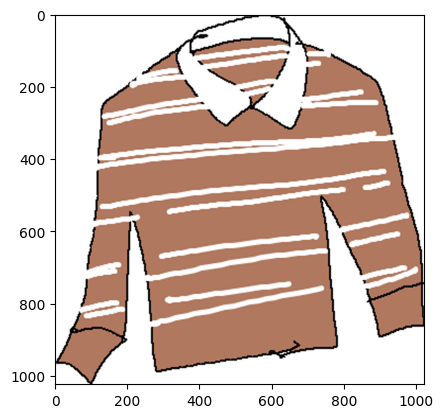

In [ ]:
show_image_hdf5(20, 'validate_data.h5')

Extract image features (Xception) - Optional

In [ ]:
from keras.applications.xception import Xception
from keras.layers import Input

In [ ]:
xception_model = Xception( weights = 'imagenet', include_top = False, pooling = 'avg' , input_tensor = Input(shape = (1024, 1024, 3)))
print(xception_model.summary())


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, 511, 511, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 511, 511, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
from pickle import dump
from tqdm import tqdm
import h5py
#import math

def generator_read_hdf5(name, batch_size):

    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, name)
    # HDF5_FILEPATH = os.path.join('DIP', name)
    x_name = 'np_image'
    y_name = 'id_image'

    index = 0
    with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file:

        record_cnt = len(hdf5_file[x_name])
        yield record_cnt

        #no_batch = math.ceil(record_cnt/batch_size)
        start_index = 0
        for end_index in range(batch_size, record_cnt, batch_size):

            image = hdf5_file[x_name][start_index: end_index]
            image_id = hdf5_file[y_name][start_index: end_index]

            yield image_id, image

            start_index = end_index
            del [image, image_id]

    return

def extract_features(model, file_name, batch_size = 250):

    yield_obj = generator_read_hdf5(file_name, batch_size)

    record_cnt = next(yield_obj)
    image_features = {}

    for _ in tqdm(range(batch_size, record_cnt, batch_size)):

        image_ids, images = next(yield_obj)

        #images = np.expand_dims(images, axis = 0)
        feature = model.predict(images, verbose = 0)

        #Store the extra image features to dict

        for i, keys in enumerate(image_ids):
            image_features[keys] = feature[i]

        del [image_ids, images, feature]

    return image_features

In [ ]:
#Extract feature for train data with inception

train_feature = extract_features(xception_model, 'train_data.h5')
dump(train_feature, open("train_features_image_xception.pkl","wb"))

  2%|▏         | 1/46 [00:23<17:43, 23.63s/it]


ResourceExhaustedError: Graph execution error:

Detected at node 'xception/block2_sepconv1/separable_conv2d' defined at (most recent call last):
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\T2230019\AppData\Local\Temp\ipykernel_12328\4109996401.py", line 3, in <module>
      train_feature = extract_features(xception_model, 'train_data.h5')
    File "C:\Users\T2230019\AppData\Local\Temp\ipykernel_12328\994205648.py", line 45, in extract_features
      feature = model.predict(images, verbose = 0)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\doodle_env\lib\site-packages\keras\layers\convolutional\separable_conv2d.py", line 188, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'xception/block2_sepconv1/separable_conv2d'
OOM when allocating tensor with shape[32,509,509,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node xception/block2_sepconv1/separable_conv2d}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_4160]

In [ ]:
#Extract feature for valid data with inception

validate_feature = extract_features(xception_model, 'validate_data.h5')
dump(train_feature, open("validate_features_image_xception.pkl","wb"))

Extract each image features into individual .npy

In [ ]:
import tensorflow as tf
#checking to see if Gpu is available. If available, we use it, else we use the CPU
devices = tf.config.experimental.list_physical_devices('GPU')
num_replicas_in_sync = len(devices)

strategy = tf.distribute.MirroredStrategy()

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


1

In [ ]:
from keras.applications.xception import Xception

with strategy.scope():

    xception_model = Xception( weights = 'imagenet', include_top = False, pooling = 'avg')

    new_input = xception_model.input # Any arbitrary shapes with 3 channels
    hidden_layer = xception_model.layers[-1].output

    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
from keras.applications.xception import preprocess_input

def load_image(image_path, image_id):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)

    return img, image_id

In [ ]:
try:
  os.makedirs(os.path.join(PROJECT_ROOT, 'image_feature_extracted_using_inception'))
except FileExistsError:
  print('Directory already exists')

Extract feature for images in Train dataset

In [ ]:
# We are retrieving our train dataset from our parquet files
db_train = pd.read_parquet(os.path.join(PROJECT_ROOT, 'train_data_processed.parquet'))
db_train['image_path'] = db_train['image_name'].apply(lambda x : os.path.join(filename, x))
db_train.head()

id image_name                                              title  \
189      190   4333.png                           dot polka magenta blouse   
2083    2084   8323.png                          detail crop lace top blue   
8614    8615   2319.png  shirt boyfriend size relaxed womens coral flan...   
11873  11874  12021.png                                      plaid magenta   
7097    7098   1577.png                                shirt green striped   

                                      image_path  
189     content/DIP/Thesis_Doodle_Files/4333.png  
2083    content/DIP/Thesis_Doodle_Files/8323.png  
8614    content/DIP/Thesis_Doodle_Files/2319.png  
11873  content/DIP/Thesis_Doodle_Files/12021.png  
7097    content/DIP/Thesis_Doodle_Files/1577.png

In [ ]:
train_image_dataset = (tf.data.Dataset.from_tensor_slices((db_train['image_path'],
                                                           db_train['id']
                                                          ))
                       .map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
                       .batch(512)
                      )

In [ ]:

for img, image_id in tqdm(train_image_dataset):

    batch_features = image_features_extract_model(img)
    #batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for extract_feature, image_id in zip(batch_features,  image_id):

        output_path = os.path.join(PROJECT_ROOT,'image_feature_extracted_using_inception', str(image_id.numpy()) +'.npy')

        extract_feature = tf.reshape(extract_feature, -1)
        #print(extract_feature.shape)

        np.save(output_path, extract_feature.numpy())

100%|██████████| 23/23 [00:15<00:00,  1.44it/s]


In [ ]:
del [train_image_dataset, db_train]
gc.collect()

195

Extract feature for images in Valid dataset

In [ ]:
# We are retrieving our valid dataset from our parquet files
db_valid = pd.read_parquet(os.path.join(PROJECT_ROOT,'validate_data_processed.parquet'))

db_valid['image_path'] = db_valid['image_name'].apply(lambda x : os.path.join(filename, x))
db_valid.head()

id image_name                                              title  \
11387  11388  13277.png                        top printed lemongrass crop   
2712    2713   9926.png               shirt and white long red sleeve blue   
6742    6743   5276.png  champion leeve logo red with tshirt heritage s...   
767      768  11504.png                  and white women striped black for   
12367  12368   3074.png  shirt lauren polo ralph t collared long sweats...   

                                      image_path  
11387  content/DIP/Thesis_Doodle_Files/13277.png  
2712    content/DIP/Thesis_Doodle_Files/9926.png  
6742    content/DIP/Thesis_Doodle_Files/5276.png  
767    content/DIP/Thesis_Doodle_Files/11504.png  
12367   content/DIP/Thesis_Doodle_Files/3074.png

In [ ]:
valid_image_dataset = (tf.data.Dataset.from_tensor_slices((db_valid['image_path'],
                                                           db_valid['id']
                                                          ))
                       .map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
                       .batch(512)
                      )

In [ ]:
for img, image_id in tqdm(valid_image_dataset):

    batch_features = image_features_extract_model(img)
    #batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for extract_feature, image_id in zip(batch_features,  image_id):

        output_path = os.path.join(PROJECT_ROOT,'image_feature_extracted_using_inception', str(image_id.numpy()) +'.npy')

        extract_feature = tf.reshape(extract_feature, -1)
        print(extract_feature.shape)

        np.save(output_path, extract_feature.numpy())

  0%|          | 0/3 [00:00<?, ?it/s]

(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


 33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


 67%|██████▋   | 2/3 [00:01<00:00,  1.13it/s]

(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


In [ ]:
del [valid_image_dataset, db_valid]
gc.collect()

390

Extract feature for images in Test dataset

In [ ]:
# We are retrieving our test dataset from our parquet files
db_test = pd.read_parquet(os.path.join(PROJECT_ROOT,'test_data_processed.parquet'))

db_test['image_path'] = db_test['image_name'].apply(lambda x : os.path.join(filename, x))
db_test.head()

id image_name                                              title  \
10189  10190   7187.png    light for tunic women yellow sleeve short dress   
7391    7392   6602.png  lava large mens raglan blackcharcoal hoodie sw...   
8939    8940   4520.png                                        hoodie baja   
5260    5261   7457.png  loose dark fit bluewhite striped anna field ho...   
781      782   9601.png  shirt heather and collar t long green sleeve r...   

                                     image_path  
10189  content/DIP/Thesis_Doodle_Files/7187.png  
7391   content/DIP/Thesis_Doodle_Files/6602.png  
8939   content/DIP/Thesis_Doodle_Files/4520.png  
5260   content/DIP/Thesis_Doodle_Files/7457.png  
781    content/DIP/Thesis_Doodle_Files/9601.png

In [ ]:
test_image_dataset = (tf.data.Dataset.from_tensor_slices((db_test['image_path'],
                                                          db_test['id']
                                                          ))
                       .map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
                       .batch(512)
                      )

In [ ]:
for img, image_id in tqdm(test_image_dataset):

    batch_features = image_features_extract_model(img)
    #batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for extract_feature, image_id in zip(batch_features,  image_id):

        output_path = os.path.join(PROJECT_ROOT,'image_feature_extracted_using_inception', str(image_id.numpy()) +'.npy')

        extract_feature = tf.reshape(extract_feature, -1)
        print(extract_feature.shape)

        np.save(output_path, extract_feature.numpy())

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


In [ ]:
del [test_image_dataset, db_test]
gc.collect()

195

Pre-Processing Input

In [ ]:
from keras.preprocessing.text import Tokenizer

def tokenize_words(lst_text_fit):

    token_obj  = Tokenizer(oov_token = '<OOV>') #replace out-of-vocabulary words with this token
    token_obj.fit_on_texts(lst_text_fit)

    return token_obj

In [ ]:
from collections import Counter

def count_words(x):

    cnt = Counter(x.split())
    return sum(cnt.values())

In [ ]:
#Train data

db_train = pd.read_parquet(os.path.join(PROJECT_ROOT, 'train_data_processed.parquet'))

#Count number of words in the desc. To understand max len of the desc
db_train['word_cnt'] = db_train.title.apply(lambda x: count_words(x))
max_length = max(db_train['word_cnt'])

#append <start> and <end> sequence to words
db_train['preprocess_caption'] = '<start> ' + db_train.title + ' <end>'

db_train.head()

id image_name                                              title  \
189      190   4333.png                           dot polka magenta blouse   
2083    2084   8323.png                          detail crop lace top blue   
8614    8615   2319.png  shirt boyfriend size relaxed womens coral flan...   
11873  11874  12021.png                                      plaid magenta   
7097    7098   1577.png                                shirt green striped   

       word_cnt                                 preprocess_caption  
189           4             <start> dot polka magenta blouse <end>  
2083          5            <start> detail crop lace top blue <end>  
8614         12  <start> shirt boyfriend size relaxed womens co...  
11873         2                        <start> plaid magenta <end>  
7097          3                  <start> shirt green striped <end>

In [ ]:
#Validation data

db_valid = pd.read_parquet(os.path.join(PROJECT_ROOT, 'validate_data_processed.parquet'))

#Count number of words in the desc. To understand max len of the all desc
db_valid['word_cnt'] = db_valid.title.apply(lambda x: count_words(x))
max_length = max(max_length, max(db_valid['word_cnt']))

#append <start> and <end> sequence to words
db_valid['preprocess_caption'] = '<start> ' + db_valid.title + ' <end>'

db_valid.head()

id image_name                                              title  \
11387  11388  13277.png                        top printed lemongrass crop   
2712    2713   9926.png               shirt and white long red sleeve blue   
6742    6743   5276.png  champion leeve logo red with tshirt heritage s...   
767      768  11504.png                  and white women striped black for   
12367  12368   3074.png  shirt lauren polo ralph t collared long sweats...   

       word_cnt                                 preprocess_caption  
11387         4          <start> top printed lemongrass crop <end>  
2712          7  <start> shirt and white long red sleeve blue <...  
6742          8  <start> champion leeve logo red with tshirt he...  
767           6    <start> and white women striped black for <end>  
12367        11  <start> shirt lauren polo ralph t collared lon...

In [ ]:
print(f'Max len of the image caption: {max_length}')

Max len of the image caption: 12


In [ ]:
from pickle import load, dump

#Tokenizer the word sequence . We shall Tokenize start and end words.
token_file = os.path.join(PROJECT_ROOT, 'tokenizer1.pkl')

if not os.path.isfile(token_file):

    token_obj = tokenize_words(list(db_train['preprocess_caption']))

    #Save the token obj to be used when convert the predict number to word
    dump(token_obj, open(token_file, 'wb'))

else:
    print(f'Token already exists.')
    token_obj = load(open(token_file, 'rb'))

vocab_size = len(token_obj.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 1548


In [ ]:
import h5py
#converting image id to index map
def create_image_id_to_idx_map(name):
    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, name)
    x_name = 'np_image'
    y_name = 'id_image'

    map_image_id_index = {}

    with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file:
        image_ids = hdf5_file[y_name][:].flatten()
        indices = list(range(len(image_ids)))
        map_image_id_index = dict(zip(image_ids, indices))

    return map_image_id_index


In [ ]:
from keras.utils import pad_sequences
from keras.utils import to_categorical


def create_in_seq(desc):

    #convert the text to sequence
    desc = token_obj.texts_to_sequences([desc])[0]

    #create in_seq
    in_seq = [desc[:i] for i in range(1, len(desc))]

    #pad sequence to max lenght of the text
    in_seq = pad_sequences(in_seq, maxlen = max_length)

    return in_seq

def create_out_seq(desc):

    #convert the text to sequence
    desc = token_obj.texts_to_sequences([desc])[0]

    #create out_seq
    out_seq = [[desc[i]] for i in range(1, len(desc))]

    #convert out_seq to the categorical value of the vocab
    out_seq = to_categorical(out_seq, num_classes = vocab_size)

    return out_seq

Train Data

In [ ]:
#Train data

train_image_id_idx_map = create_image_id_to_idx_map('train_data.h5')
db_train['image_id_idx'] = db_train['id'].map(train_image_id_idx_map)

del [train_image_id_idx_map]

db_train['in_seq'] = db_train['preprocess_caption'].apply(create_in_seq)
db_train['out_seq'] = db_train['preprocess_caption'].apply(create_out_seq)

db_train.head()

id image_name                                              title  \
189      190   4333.png                           dot polka magenta blouse   
2083    2084   8323.png                          detail crop lace top blue   
8614    8615   2319.png  shirt boyfriend size relaxed womens coral flan...   
11873  11874  12021.png                                      plaid magenta   
7097    7098   1577.png                                shirt green striped   

       word_cnt                                 preprocess_caption  \
189           4             <start> dot polka magenta blouse <end>   
2083          5            <start> detail crop lace top blue <end>   
8614         12  <start> shirt boyfriend size relaxed womens co...   
11873         2                        <start> plaid magenta <end>   
7097          3                  <start> shirt green striped <end>   

       image_id_idx                                             in_seq  \
189               0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
2083              1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
8614              2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
11873             3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
7097              4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   

                                                 out_seq  
189    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2083   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
8614   [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...  
11873  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
7097   [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

In [ ]:
with pd.option_context("display.max_colwidth", None):
    print(db_train.iloc[0,:])

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
db_train.loc[4,'word_cnt'] + 2

5

In [ ]:
db_train.loc[4,'in_seq'].shape

(4, 12)

In [ ]:
db_train.loc[5,'out_seq'].shape

(5, 1548)

Records in train_data.h5 dataset: 11655
Image id: 190


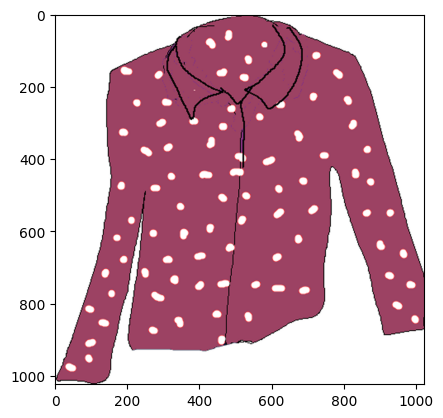

In [ ]:
show_image_hdf5(0, 'train_data.h5')

In [ ]:
train_data =  pd.DataFrame([
                            [image_id, image_id_idx, in_seq, out_seq] for image_id , image_id_idx, in_seqs , out_seqs in db_train[['id', 'image_id_idx', 'in_seq', 'out_seq']].values
                            #for in_seq in in_seqs for out_seq in out_seqs
                            for in_seq, out_seq in zip(in_seqs, out_seqs)
                            ]
                          , columns = ['image_id', 'image_id_idx', 'in_seq', 'out_seq']
                          )

In [ ]:
with pd.option_context("display.max_colwidth", None):
    print(train_data.head(7))

   image_id  image_id_idx                                    in_seq  \
0       190             0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]   
1       190             0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 34]   
2       190             0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 34, 29]   
3       190             0   [0, 0, 0, 0, 0, 0, 0, 0, 3, 34, 29, 74]   
4       190             0  [0, 0, 0, 0, 0, 0, 0, 3, 34, 29, 74, 82]   
5      2084             1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]   
6      2084             1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 179]   

                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
train_data.shape

(80202, 4)

In [ ]:
del [db_train]
gc.collect()

3291

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80202 entries, 0 to 80201
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      80202 non-null  int64 
 1   image_id_idx  80202 non-null  int64 
 2   in_seq        80202 non-null  object
 3   out_seq       80202 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.4+ MB


In [ ]:
train_data.to_parquet(os.path.join(PROJECT_ROOT, 'train_in_seq_data.parquet'),
                     engine = 'pyarrow',
                     compression = 'gzip'
                     )

del [train_data]
gc.collect()

0

Validation Data

In [ ]:
valid_image_id_idx_map = create_image_id_to_idx_map('validate_data.h5')
db_valid['image_id_idx'] = db_valid['id'].map(valid_image_id_idx_map)

del [valid_image_id_idx_map]


db_valid['in_seq'] = db_valid['preprocess_caption'].apply(create_in_seq)
db_valid['out_seq'] = db_valid['preprocess_caption'].apply(create_out_seq)

db_valid.head()

id image_name                                              title  \
11387  11388  13277.png                        top printed lemongrass crop   
2712    2713   9926.png               shirt and white long red sleeve blue   
6742    6743   5276.png  champion leeve logo red with tshirt heritage s...   
767      768  11504.png                  and white women striped black for   
12367  12368   3074.png  shirt lauren polo ralph t collared long sweats...   

       word_cnt                                 preprocess_caption  \
11387         4          <start> top printed lemongrass crop <end>   
2712          7  <start> shirt and white long red sleeve blue <...   
6742          8  <start> champion leeve logo red with tshirt he...   
767           6    <start> and white women striped black for <end>   
12367        11  <start> shirt lauren polo ralph t collared lon...   

       image_id_idx                                             in_seq  \
11387             0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
2712              1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
6742              2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
767               3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   
12367             4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, ...   

                                                 out_seq  
11387  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2712   [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...  
6742   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
767    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...  
12367  [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

In [ ]:
#Let's look at in detail for a row
with pd.option_context("display.max_colwidth", None):
    print(db_valid.iloc[0,:])

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
valid_data =  pd.DataFrame([
                            [image_id, image_id_idx, in_seq, out_seq] for image_id , image_id_idx, in_seqs , out_seqs in db_valid[['id', 'image_id_idx', 'in_seq', 'out_seq']].values
                            for in_seq, out_seq in zip(in_seqs, out_seqs)
                            ]
                          , columns = ['image_id', 'image_id_idx', 'in_seq', 'out_seq']
                          )

In [ ]:
with pd.option_context("display.max_colwidth", None):
    print(valid_data.head(7))

   image_id  image_id_idx                                     in_seq  \
0     11388             0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]   
1     11388             0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 13]   
2     11388             0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 13, 50]   
3     11388             0   [0, 0, 0, 0, 0, 0, 0, 0, 3, 13, 50, 319]   
4     11388             0  [0, 0, 0, 0, 0, 0, 0, 3, 13, 50, 319, 17]   
5      2713             1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]   
6      2713             1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4]   

                                                                                                                                                                                                                                                                                                                                                                                                                                       

Records in validate_data.h5 dataset: 1227
Image id: 11388


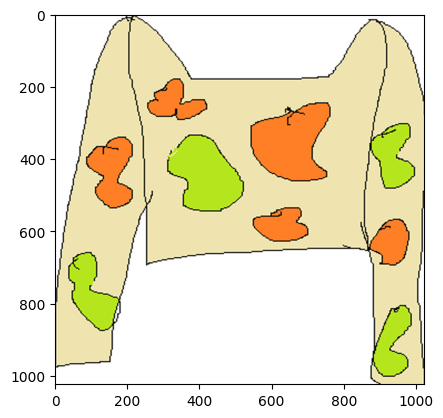

In [ ]:
show_image_hdf5(0, 'validate_data.h5')

In [ ]:
valid_data.shape

(8388, 4)

In [ ]:
del [db_valid]
gc.collect()

3426

In [ ]:
#Save valid data to a file

valid_data.to_parquet(os.path.join(PROJECT_ROOT, 'valid_in_seq_data.parquet'), engine = 'pyarrow', compression = 'gzip')

In [ ]:
del [valid_data]
gc.collect()

0

# **#Model 1: RCNN Ecoder and Decoder Model with embeddings**

In [ ]:
PROJECT_IMAGE_ROOT = os.path.join(PROJECT_ROOT, 'image_feature_extracted_using_inception')

In [ ]:
import tensorflow as tf

is_TPU_instance_Init = False
is_Multiple_GPU_instance_Init = False

num_replicas_in_sync = 1

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    is_TPU_instance_Init = True

except ValueError:
    tpu = None

if tpu:

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    num_replicas_in_sync = strategy.num_replicas_in_sync
    print("REPLICAS: ", strategy.num_replicas_in_sync)

else: #Check for multiple GPU

    #Setting for multipl GPU https://towardsdatascience.com/train-a-neural-network-on-multi-gpu-with-tensorflow-42fa5f51b8af
    #to see the list of available GPU devices doing the following
    devices = tf.config.experimental.list_physical_devices('GPU')
    num_replicas_in_sync = len(devices)

    if num_replicas_in_sync > 1:
        is_Multiple_GPU_instance_Init = True

    #Detect multiple GPU then distribute the task on multiple machine
    strategy = tf.distribute.MirroredStrategy() #To Supress the warning duing run https://github.com/tensorflow/tensorflow/issues/42146
    #strategy = tf.distribute.MultiWorkerMirroredStrategy()
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

if ((is_Multiple_GPU_instance_Init == False) & (is_TPU_instance_Init == False)):
    strategy = tf.distribute.get_strategy()
    num_replicas_in_sync = 1
    print('General strategy...')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
General strategy...


In [ ]:
import pyarrow.parquet as pq

def next_dbset_batch(parquet_obj, size = 10000):

    for dbset in parquet_obj.iter_batches(batch_size = size, columns = ['image_id', 'in_seq', 'out_seq']):
        yield dbset

#This perfrom worst took 1min 11s for batch size of 90.
def data_generator(name, batch_size):

    #print(name) output: b'train_data.h5'. Here 'b' in output mease byte representation
    name = str(name, 'UTF-8') #This  convert bytes to a string

    if 'valid' in name:

        #dbset = valid_data
        DATASET_FILEPATH = 'valid_in_seq_data.parquet'

    else:

        #dbset = train_data
        DATASET_FILEPATH = 'train_in_seq_data.parquet'


    DATASET_FILEPATH = os.path.join(PROJECT_ROOT, DATASET_FILEPATH)
    parquet_obj = None

    #while not 'valid' in name:
    while True:

        if parquet_obj == None:
            parquet_obj = pq.ParquetFile(DATASET_FILEPATH)

        #records_cnt = hdf5_file[x_name].shape[0]
        for dbset in next_dbset_batch(parquet_obj, batch_size): #read the data in chunk

            dbset = dbset.to_pandas()
            records_cnt = dbset.shape[0]

            #since we know that the records will be in sequence of same input text
            prev_image_id = -1
            for idx in range(records_cnt):

                image_id = dbset.loc[idx, 'image_id']

                if prev_image_id != image_id: #If previous image_id and current image_idx not same load the new in_image numpy array. Else use the previous numpy array

                    img_path = os.path.join(PROJECT_IMAGE_ROOT, str(image_id) + '.npy')
                    in_image = np.load(img_path)

                in_seq = dbset.loc[idx, 'in_seq']
                out_seq = dbset.loc[idx, 'out_seq']

                yield ((in_image, in_seq.tolist()), out_seq.tolist())

                prev_image_id = image_id

            del [dbset, in_image, in_seq, out_seq]
            gc.collect()

        parquet_obj = None

In [ ]:
max_in_seq_len = 12
vocab_size = 1548
train_record_cnt = 80202
valid_record_cnt = 8388

(max_in_seq_len, vocab_size, train_record_cnt)

(12, 1548, 80202)

HyperParamater Tuning

In [ ]:
batch_size = 2048 #1024
batch_size = batch_size * num_replicas_in_sync

batch_size

2048

In [ ]:
from tensorflow.data import Dataset

train_batch = (Dataset
              .from_generator(data_generator,
                              args = ['train', 25000], #batch_size
                              output_signature = (
                                                    (
                                                      tf.TensorSpec(shape = (2048, ), dtype = tf.float16),
                                                      tf.TensorSpec(shape = (max_in_seq_len,), dtype = tf.int32)
                                                    ),
                                                    tf.TensorSpec(shape = (vocab_size,), dtype = tf.float16)
                                                  )
                            )
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE)
              )

In [ ]:
valid_batch = (Dataset
              .from_generator(data_generator,
                              args = ['valid', 25000], #batch_size
                              output_signature = (
                                                    (
                                                      tf.TensorSpec(shape = (2048, ), dtype = tf.float16),
                                                      tf.TensorSpec(shape = (max_in_seq_len,), dtype = tf.int32)
                                                    ),
                                                    tf.TensorSpec(shape = (vocab_size, ), dtype = tf.float16)
                                                 )
                            )
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE)
              )

In [ ]:
# !pip install keras_tuner

In [ ]:
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils import plot_model
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Add
import keras_tuner

with strategy.scope():

    class HyperParamTunerModel(keras_tuner.HyperModel):

        def __init__(self, max_length, vocab_size):

            super(HyperParamTunerModel, self).__init__()

            self.max_length = max_length
            self.vocab_size = vocab_size

        # define the model
        def build(self, hp):

            # features from the CNN model squeezed from 2048 to 256 nodes

            image_extract = Input(shape = (2048,), name = 'np_image')
            dence_units = hp.Int("dence_units", min_value = 256, max_value = 1024, step = 32)

            fe1 = Dropout(hp.Float("img_dropout", min_value = 0.5, max_value = 0.7, step = 0.05))(image_extract)
            fe2 = Dense(units = dence_units, activation = 'relu')(fe1)

            # LSTM sequence model
            inputs_caption = Input(shape = (self.max_length,), name = 'word_seq')

            se1 = Embedding(self.vocab_size,
                            hp.Int("emb_units", min_value = 256, max_value = 1024, step = 32),
                            mask_zero = True)(inputs_caption)
            se2 = Dropout(hp.Float("emb_dropout", min_value = 0.5, max_value = 0.7, step = 0.05))(se1)
            se3 = LSTM(dence_units)(se2)

            # Merging both models
            decoder1 = Add()([fe2, se3])
            decoder2 = Dense(hp.Int("merge_units", min_value = 256, max_value = 1024, step = 32), activation = 'relu')(decoder1)

            outputs = Dense(self.vocab_size, activation = 'softmax', name = 'output_seq')(decoder2)

            # tie it together [image, seq] [word]
            model = Model(inputs = [image_extract, inputs_caption], outputs = outputs)

            #define optimizers
            lr = hp.Float("lr", min_value = 1e-4, max_value = 1e-1, sampling = "log")#lr = 0.0001
            lr = lr * num_replicas_in_sync
            adam_optimizers  = Adam(learning_rate = lr)

            #define loss
            entropy_loss = CategoricalCrossentropy(from_logits = False)

            model.compile(loss = entropy_loss, optimizer = adam_optimizers)
            return model


        def fit(self, hp, model, *args, **kwargs):

            return model.fit(
                            *args,
                            # Tune whether to shuffle the data in each epoch.
                            **kwargs,
                        )


In [ ]:
tuner = keras_tuner.RandomSearch(
                                hypermodel = HyperParamTunerModel(max_in_seq_len, vocab_size),
                                objective = "val_loss",
                                max_trials = 10,  #<<< Maximum Trials
                                seed = 44,
                                executions_per_trial = 1,
                                distribution_strategy = strategy,
                                overwrite = True,
                                directory = os.path.join(PROJECT_ROOT, "hyper_param_search_result"),
                                project_name = "image_caption_hyper_param_search",
                            )

In [ ]:
#Start the search
import math

tuner.search(x = train_batch,
             steps_per_epoch = math.ceil(train_record_cnt/batch_size),
             epochs = 25, #<<< Epocs Size
             shuffle = False,
             verbose = 1,
             validation_data = valid_batch,
             validation_steps = math.ceil(valid_record_cnt/batch_size),
             callbacks = [EarlyStopping(monitor = 'val_loss', patience = 1)],
            )

Trial 10 Complete [00h 01m 49s]
val_loss: 5.117982387542725

Best val_loss So Far: 0.5479254722595215
Total elapsed time: 00h 50m 57s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
for h_param in ['dence_units', 'img_dropout', 'emb_units', 'emb_dropout', 'merge_units', 'lr']:
      print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

dence_units 1024
img_dropout 0.5
emb_units 704
emb_dropout 0.5
merge_units 480
lr 0.003044123781552541


In [ ]:
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils import plot_model
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Add
import math

with strategy.scope():

    def define_model(max_length, vocab_size, dence_units, img_dropout, emb_units, emb_dropout, merge_units, lr):

        image_extract = Input(shape = (2048,), name = 'np_image')

        fe1 = Dropout(img_dropout)(image_extract)
        fe2 = Dense(units = dence_units, activation = 'relu')(fe1)

        # LSTM sequence model
        inputs_caption = Input(shape = (max_length,), name = 'word_seq')

        se1 = Embedding(vocab_size,
                        emb_units,
                        mask_zero = True)(inputs_caption)
        se2 = Dropout(emb_dropout)(se1)
        se3 = LSTM(dence_units)(se2)

        # Merging both models
        decoder1 = Add()([fe2, se3])
        decoder2 = Dense(merge_units, activation = 'relu')(decoder1)

        outputs = Dense(vocab_size, activation = 'softmax', name = 'output_seq')(decoder2)

        # tie it together [image, seq] [word]
        model = Model(inputs = [image_extract, inputs_caption], outputs = outputs)

        #define optimizers
        #lr = lr * num_replicas_in_sync
        adam_optimizers  = Adam(learning_rate = lr)

        #define loss
        entropy_loss = CategoricalCrossentropy(from_logits = False)

        model.compile(optimizer=adam_optimizers, loss=entropy_loss, metrics=[Accuracy()])

        return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define model
train_model = define_model(max_in_seq_len, vocab_size,
                           dence_units=1024,
                           img_dropout=0.5,
                           emb_units=704,
                           emb_dropout=0.5,
                           merge_units=480,
                           lr=0.003044123781552541)

# Compile the model with 'sparse_categorical_crossentropy' loss and metrics
#train_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with both training and validation accuracy
history = train_model.fit(x=train_batch,
                          steps_per_epoch=math.ceil(train_record_cnt / batch_size),
                          epochs=500, #<<< Epocs
                          shuffle=False,
                          verbose=1,
                          validation_data=valid_batch,
                          validation_steps=math.ceil(valid_record_cnt / batch_size),
)

Epoch 1/500
40/40 [==============================] - 16s 360ms/step - loss: 5.0008 - accuracy: 0.0000e+00 - val_loss: 4.0357 - val_accuracy: 0.0000e+00
Epoch 2/500
40/40 [==============================] - 14s 357ms/step - loss: 3.4114 - accuracy: 0.0000e+00 - val_loss: 2.8523 - val_accuracy: 0.0000e+00
Epoch 3/500
40/40 [==============================] - 14s 352ms/step - loss: 2.3271 - accuracy: 0.0000e+00 - val_loss: 1.8806 - val_accuracy: 0.0000e+00
Epoch 4/500
40/40 [==============================] - 13s 337ms/step - loss: 1.4705 - accuracy: 5.2834e-07 - val_loss: 1.2135 - val_accuracy: 4.9207e-06
Epoch 5/500
40/40 [==============================] - 13s 336ms/step - loss: 0.9769 - accuracy: 1.5208e-04 - val_loss: 0.8720 - val_accuracy: 4.5579e-04
Epoch 6/500
40/40 [==============================] - 13s 332ms/step - loss: 0.7495 - accuracy: 0.0015 - val_loss: 0.7401 - val_accuracy: 0.0021
Epoch 7/500
40/40 [==============================] - 13s 335ms/step - loss: 0.6461 - accuracy: 0

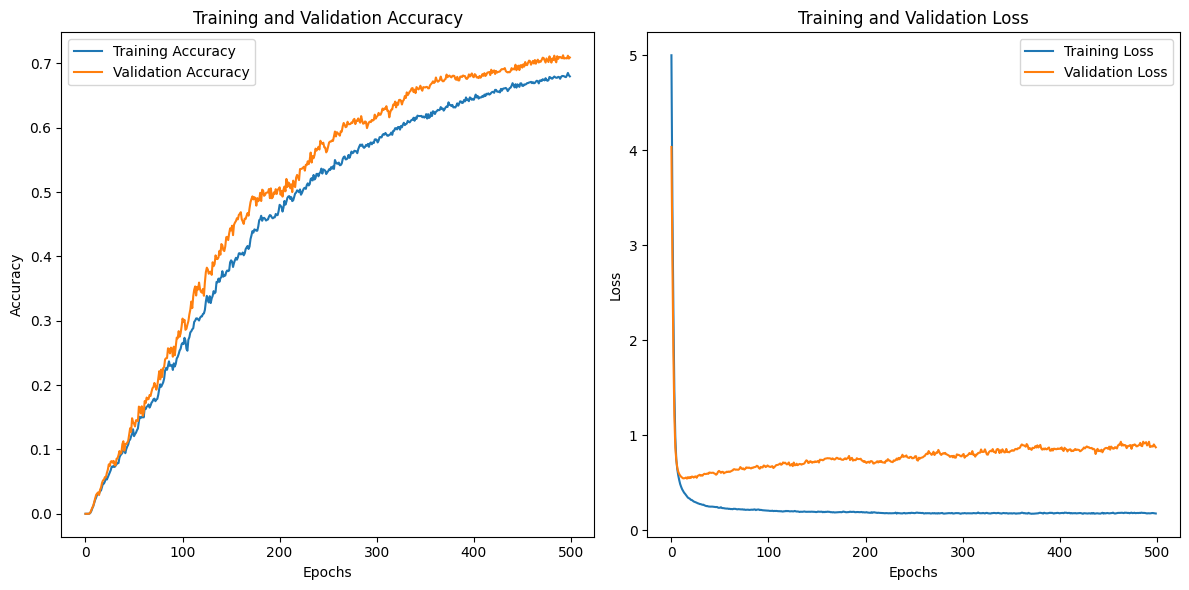

In [ ]:
# We are ploting our training accuracy and training loss
plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
hist_df = pd.DataFrame(history.history)

hist_df.to_parquet(os.path.join(PROJECT_ROOT, 'result_dence_units_640,img_dropout_55,emb_units_992,emb_dropout_60,merge_units_960,lr_0_0001866463763857711.parquet'))

In [ ]:
hist_df.head(-5)

loss      accuracy  val_loss  val_accuracy
0    5.000827  0.000000e+00  4.035673      0.000000
1    3.411440  0.000000e+00  2.852266      0.000000
2    2.327099  0.000000e+00  1.880639      0.000000
3    1.470495  5.283405e-07  1.213458      0.000005
4    0.976856  1.520832e-04  0.871993      0.000456
..        ...           ...       ...           ...
490  0.179262  6.790913e-01  0.895094      0.708863
491  0.181398  6.804376e-01  0.906654      0.707972
492  0.180474  6.804353e-01  0.933825      0.712687
493  0.180183  6.801280e-01  0.878623      0.707578
494  0.181250  6.791303e-01  0.882436      0.708014

[495 rows x 4 columns]

In [ ]:
train_model.save(os.path.join(PROJECT_ROOT,'RCNN.h5'))

# ***#Model2: BLIP-2***

In [ ]:
# !pip install 'transformers==4.35.2'
# !pip install datasets

In [ ]:
from transformers.models.gpt2.modeling_gpt2 import CausalLMOutputWithCrossAttentions

In [ ]:
import utils as plh

#base_path = plh.get_project_root()
#Pandas
from pandas import read_parquet

#HuggingFace: Dataset Library
from datasets import Dataset
from datasets import Image

#General Library
import os
import gc

def get_dataset(filetype, **kargs):

    """
    Create dataset based on file
    """

    filepath = ""
    data_sample = -1

    #Read data
    if filetype == 'train':

        filepath = kargs["train_filepath"]
        data_sample = kargs["train_sample"]

    elif filetype == 'valid':

        filepath = kargs["valid_filepath"]
        data_sample = kargs["valid_sample"]

    elif filetype == 'test':

        filepath = kargs["test_filepath"]
        data_sample = kargs["test_sample"]

    if len(filepath) == 0:
        return

    seed = kargs["seed"]
    image_base_path = kargs["image_base_path"]

    #print(f'Reading file from path: "{filepath}"')
    db_set = read_parquet(filepath)

    if data_sample != -1:
        db_set = db_set.sample(n = data_sample, random_state = seed)

    image_paths = list(image_base_path + '/' + db_set["image_name"])
    captions = list(db_set["title"])

    del [db_set]

    db_set = Dataset.from_dict(
        {
            "image": image_paths,
            "text": captions,
        }
    ).cast_column("image", Image())

    del [image_paths, captions]
    gc.collect()

    return db_set

In [ ]:
train_dbset = get_dataset(filetype = 'train',
                          seed = 44,
                          train_filepath = os.path.join('content','DIP', 'ntrain_data.parquet'),
                          train_sample = 4892, #Change Here
                          image_base_path = os.path.join('content','DIP', 'Thesis_Doodle_Files'),
                         )

In [ ]:
valid_dbset = get_dataset(filetype = 'valid',
                          seed = 44,
                          valid_filepath = os.path.join('content','DIP', 'nvalidate_data.parquet'),
                          valid_sample = 509, #change Here
                          image_base_path = os.path.join('content','DIP', 'Thesis_Doodle_Files'),
                         )

In [ ]:
test_dbset = get_dataset(filetype = 'test',
                          seed = 44,
                          test_filepath = os.path.join('content','DIP', 'ntest_data.parquet'),
                          test_sample = 29, #change here
                          image_base_path = os.path.join('content','DIP', 'Thesis_Doodle_Files'),
                         )

In [ ]:
train_dbset[0]["text"]

In [ ]:
train_dbset[0]["image"].resize((252,252))

In [ ]:
 import tensorflow as tf
 print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
 gpus = tf.config.list_logical_devices('GPU')
 strategy = tf.distribute.MirroredStrategy(gpus)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):

    def __init__(self, dataset, processor):

        self.dataset = dataset
        self.processor = processor
        #self.new_size = (256,256)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]
        encoding = self.processor(images = item["image"],#.resize(self.new_size),
                                  #padding = "max_length",
                                  return_tensors = "pt"
                                 )

        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]

        return encoding

def collate_fn(batch):

    # pad the input_ids and attention_mask
    processed_batch = {}

    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                                            [example["text"] for example in batch],
                                            padding = "max_length" ,#True,
                                            max_length = 13, #9, #16
                                            return_tensors = "pt",
                                            truncation = True,
                                            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

Load processor

In [ ]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_dataloader = DataLoader(ImageCaptioningDataset(train_dbset, processor),
                              shuffle = True,
                              batch_size = BATCH_SIZE,
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor  = 2,
                             )

del train_dbset


In [ ]:
valid_dataloader = DataLoader(ImageCaptioningDataset(valid_dbset, processor),
                              batch_size = BATCH_SIZE,
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del valid_dbset

In [ ]:
test_dataloader = DataLoader(ImageCaptioningDataset(test_dbset , processor),
                              batch_size = BATCH_SIZE,
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del test_dbset

In [ ]:
gc.collect()

train model

In [ ]:
# from transformers import Blip2ForConditionalGeneration
# import torch

# device_map = {
#     "query_tokens": 0,
#     "vision_model":0,
#     "language_model": 1,
#     "language_projection": 1,
#     "lm_head": 1,
#     "qformer": 0,
# }
# max_memory = {i: "4GB" for i in range(2)} #2 GPU

# model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded",
#                                                       device_map = device_map,  #"auto", # "balanced_low_0"
#                                                       max_memory = max_memory,
#                                                       load_in_8bit = True,
#                                                       torch_dtype = torch.float16,
#                                                      )
from transformers import Blip2ForConditionalGeneration
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, else CPU
with strategy.scope():
    model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded")

In [ ]:
# !pip install peft
# !pip install evaluate

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
with strategy.scope():
    config = LoraConfig(
        r = 16, #32, #10, #18, #16, # Lower rank results in fewer trainable parameters.
        lora_alpha = 32,
        lora_dropout = 0.05,
        bias = "none",
        target_modules = ["q_proj", "k_proj"]
    )

    model = get_peft_model(model, config)

    model.print_trainable_parameters()

Train Model

In [ ]:
from accelerate import Accelerator
#import torch

lr = 6e-4 #2e-4 #5e-4 #8e-4
with strategy.scope():
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    #model.gradient_checkpointing_enable()

    accelerator = Accelerator()
    model, optimizer, train_dataloader, valid_dataloader  = accelerator.prepare(model, optimizer, train_dataloader, valid_dataloader)

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = accelerator.device
print(f'Device: {device}')

In [ ]:
#Eval metric Library
from rouge_score import rouge_scorer, scoring
from evaluate import load

rouge_types = ["rouge1", "rouge2", "rougeL"]
use_stemmer = False
rouge_score_obj = rouge_scorer.RougeScorer(rouge_types = rouge_types, use_stemmer = use_stemmer)
bleu_score_obj = load("bleu")

def compute_metrics(pred_text, labels_text):

    for ref, pred in zip(labels_text, pred_text):

        #ROUGE Score
        output_score = rouge_score_obj.score(prediction = pred.strip(), target = ref.strip())
        rouge_score_aggregator.add_scores(output_score)

        #BLEU Score
        bleu_score = {}

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 2)
        bleu_score['bleu@2'] = results['bleu']

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 1)
        bleu_score['bleu@1'] = results['bleu']

        bleu_score_aggregator.add_scores(bleu_score)


    agg_bleu = bleu_score_aggregator.aggregate()
    agg_rouge = rouge_score_aggregator.aggregate()

    return {
        #ROUGE metric
        "rouge1_fmeasure": round(agg_rouge['rouge1'].mid.fmeasure, 2),
        "rouge2_fmeasure": round(agg_rouge['rouge2'].mid.fmeasure, 2),
        "rougeL_fmeasure": round(agg_rouge['rougeL'].mid.fmeasure, 2),

        #BLEU metric
        "bleu@1": round(agg_bleu['bleu@1'].mid, 2),
        "bleu@2": round(agg_bleu['bleu@2'].mid, 2),
    }

In [ ]:
from tqdm import tqdm

epoch = 5
gradient_accumulation_steps = 2 #8 #4
with strategy.scope():
    # model = model
    for epoch in range(epoch):

        print("Epoch:", epoch)

        model.train()
        idx = 0
        for batch in tqdm(train_dataloader):

            input_ids = batch.pop("input_ids")#.to(device)
            pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device, torch.float16)

            outputs = model(input_ids = input_ids,
                            pixel_values = pixel_values,
                            labels = input_ids)

            loss = outputs.loss
            loss = loss / gradient_accumulation_steps

            #loss.backward()
            accelerator.backward(loss)

            if (idx + 1) % gradient_accumulation_steps == 0:

                print(f"Step: {idx+1}, Loss: {outputs.loss.item()}")  #loss

                optimizer.step()
                optimizer.zero_grad()

            idx = idx + 1

        model.eval()

        rouge_score_aggregator = scoring.BootstrapAggregator()
        bleu_score_aggregator = scoring.BootstrapAggregator()

        for batch in tqdm(valid_dataloader):

            input_ids = batch.pop("input_ids")#.to(device)
            pixel_values = batch.pop("pixel_values").to(torch.float16)

            predictions = model.generate(pixel_values, max_length = 10)#9 #16
            predictions = processor.batch_decode(predictions, skip_special_tokens = True)
            labels = processor.batch_decode(input_ids, skip_special_tokens = True)

            eval_metric = compute_metrics(predictions, labels)

        print(f"Epoch {epoch}: Eval metric on valid dbset:", eval_metric)

In [ ]:
gc.collect()

In [ ]:
model.save_pretrained(os.join.path("content","DIP", 'blip2_visual_peft'))

Accuracy bad ashle try with these variations:


Trail	max_lenght	batch_size	LoRA rank	lr	gradient_accumulation_steps	epoch	rouge1	rouge2	rougel	bleu@1	bleu@2
1	16	32	16	5e-4	1	0	0.43	0.12	0.43
1	0.45	0.15	0.44
2	0.45	0.14	0.45
3	0.46	0.15	0.45
4	0.46	0.15	0.45
5	0.45	0.15	0.45
6	0.45	0.15	0.45
2	16	32	18	5e-4	1	0	0.43	0.13	0.43
1	0.44	0.14	0.44
2	0.45	0.14	0.45
3	0.45	0.14	0.44
3	16	32	10	5e-4	1	0	0.44	0.13	0.43
1	0.45	0.14	0.44
2	0.45	0.14	0.45
3	0.45	0.14	0.45
4	16	32	16	2e-4	8	0	0.37	0.08	0.36	0.29	0.14
1	0.39	0.09	0.39	0.33	0.16
2	0.41	0.11	0.41	0.35	0.18
3	0.42	0.11	0.42	0.37	0.19
4	0.43	0.11	0.43	0.37	0.2
5	16	32	32	5e-4	8	0	0.37	0.08	0.37	0.31	0.14
1	0.4	0.1	0.39	0.35	0.18
2	0.42	0.11	0.41	0.38	0.2
3	0.41	0.11	0.41	0.38	0.21
4	0.43	0.13	0.42	0.39	0.22
5	0.43	0.13	0.43	0.39	0.22
6	0.43	0.13	0.42	0.39	0.22
7	0.43	0.13	0.43	0.4	0.23
8	0.43	0.13	0.43	0.4	0.23
9	0.43	0.13	0.42	0.41	0.23
6	16	32	16	5e-4	8	0	0.38	0.08	0.37	0.32	0.15
7	16	38	16	5e-4	4	0	0.36	0.09	0.36	0.33	0.16
1	0.38	0.1	0.37	0.36	0.19
8	9	38	16	8e-4	4	0	0.37	0.1	0.37	0.35	0.18
1	0.38	0.1	0.38	0.36	0.19
2	0.38	0.11	0.38	0.37	0.2
3	0.39	0.11	0.38	0.37	0.2
4	0.39	0.11	0.39	0.37	0.2
5	0.38	0.11	0.38	0.37	0.2
6	0.38	0.11	0.38	0.37	0.2
9	9	32	16	5e-4	1	0	0.38	0.1	0.38	0.36	0.19
1	0.39	0.11	0.38	0.36	0.2
10	10	32	16	6e-4	2	0	0.40	0.11	0.40	0.38	0.20
1	0.41	0.12	0.41	0.38	0.21
2	0.42	0.12	0.41	0.38	0.21
3	0.41	0.13	0.41	0.38	0.22
4	0.41	0.12	0.41	0.38	0.21
5	0.41	0.12	0.41	0.39	0.21
6	0.41	0.12	0.41	0.39	0.22
7	0.41	0.12	0.41	0.39	0.22


Evaluate

In [ ]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig
from tqdm import tqdm
import torch

peft_model_id = "/kaggle/input/pre-trained-peft-mode"
config = PeftConfig.from_pretrained(peft_model_id)

device = "cuda" if torch.cuda.is_available() else "cpu"
device_map = {
    "query_tokens": 0,
    "vision_model":0,
    "language_model": 1,
    "language_projection": 1,
    "lm_head": 1,
    "qformer": 0,
}
max_memory = {i: "4GB" for i in range(2)} #2 GPU

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path,
                                                      device_map = device_map,  #"auto", # "balanced_low_0"
                                                      max_memory = max_memory,
                                                      load_in_8bit = True,
                                                      torch_dtype = torch.float16,
                                                     )


model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
#training
rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(train_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')

    eval_metric = compute_metrics(predictions, labels)

print(f"Metric on train dbset:", eval_metric)

In [ ]:
#Valid

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(valid_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')

    eval_metric = compute_metrics(predictions, labels)

print(f"Metric on valid dbset:", eval_metric)

In [ ]:
#test

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(test_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')

    eval_metric = compute_metrics(predictions, labels)

print(f"Metric on test dbset:", eval_metric)

Prediction

In [ ]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)


In [ ]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig
import torch

peft_model_id = "/kaggle/input/pre-trained-peft-mode"
config = PeftConfig.from_pretrained(peft_model_id)

device = "cuda" if torch.cuda.is_available() else "cpu"

#Inferance on GPU device. Will give error in CPU system, as "load_in_8bit" is an setting of bitsandbytes library and only works for GPU
#model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit = True, device_map = "auto")

#Inferance on CPU device
model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path)

model = PeftModel.from_pretrained(model, peft_model_id)
#model = model.to(device)

In [ ]:
from PIL import Image

image = Image.open('/kaggle/input/fashion-image-caption-using-image-files/images/01d9276f-48ce-47cf-93ed-f86b9fc78dbb.jpeg')

#Inferance on GPU. When used this on GPU will get errors like: "slow_conv2d_cpu" not implemented for 'Half'" , " Input type (float) and bias type (struct c10::Half)"
#inputs = processor(images = image, return_tensors = "pt").to('cuda', torch.float16)

#Inferance on CPU
inputs = processor(images = image, return_tensors = "pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values = pixel_values, max_length = 10)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print('Caption: '+ generated_caption)
image.resize((252,252))

In [ ]:
# !pip install datasets

# **#Model 3: GPT2 and Vision Encoder and Decoder**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/firstdataBoobs.zip

Streaming output truncated to the last 5000 lines.
  inflating: firstdata/ pink long sleeve shirt/9.txt  
  inflating: firstdata/ pink long sleeve shirt/8.txt  
  inflating: firstdata/ pink long sleeve shirt/10.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._10.png  
  inflating: firstdata/ pink long sleeve shirt/6.txt  
  inflating: firstdata/ pink long sleeve shirt/7.txt  
  inflating: firstdata/ pink long sleeve shirt/3.txt  
  inflating: firstdata/ pink long sleeve shirt/2.txt  
  inflating: firstdata/ pink long sleeve shirt/1.txt  
  inflating: firstdata/ pink long sleeve shirt/7.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._7.png  
  inflating: firstdata/ pink long sleeve shirt/6.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._6.png  
  inflating: firstdata/ pink long sleeve shirt/2.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._2.png  
  inflating: firstdata/ pink long sleeve shirt/3.png  
  inflating: __MACOSX/f

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00


In [ ]:
import os
import datasets
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor,AutoTokenizer
os.environ["WANDB_DISABLED"] = "true"
import nltk

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

Num GPUs Available:  1


In [ ]:
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [ ]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
with strategy.scope():
    image_encoder_model = "google/vit-base-patch16-224-in21k"
    text_decode_model = "gpt2"

    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
        image_encoder_model, text_decode_model)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.2.ln_cross_attn.weight', 'h.11.ln_cross_attn.bias', 'h.9.ln_cross_attn.bias', 'h.0.crossattention.c_attn.bias', 'h.3.ln_cross_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.9.ln_cross_attn.weight', 'h.9.crossattention.c_attn.weight', 'h.4.crossattention.c_attn.weight', 'h.11.crossattention.c_proj.bias', 'h.6.ln_cross_attn.weight', 'h.2.ln_cross_attn.bias', 'h.7.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.weight', 'h.8.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.weight', 'h.2.crossattention.c_proj.weight', 'h.9.crossattention.c_attn.bias', 'h.9.crossattention.c_proj.weight', 'h.1.ln_cross_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.2.crossattention.q_attn.bias', 'h.0.crossattention.c_proj.bias', 'h.11.crossattention.c_attn.bias', 'h.8.crossattention.c_proj.bias', 'h.4.

In [ ]:
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
# with strategy.scope():
    # update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

In [ ]:
from datasets import load_dataset
import os
PROJECT_ROOT= "/content/"
filename = "/content/firstdata/Thesis_Doodle_Files/"
#Load from parquet file into huggingface dataset
base_path =  os.path.join(PROJECT_ROOT)
train_data = 'train_data_processed.parquet'
valid_data = 'validate_data_processed.parquet'
test_data = 'test_data_processed.parquet'

data_files = {"train": os.path.join(base_path, train_data), 'valid': os.path.join(base_path, valid_data), 'test':(os.path.join(base_path, test_data))}
db_set = load_dataset("parquet", data_files = data_files)

db_set = db_set.remove_columns(['id','__index_level_0__'])

db_set = db_set.map(lambda dbrow: { "image_path": os.path.join(filename, dbrow["image_name"]) }, remove_columns = ["image_name"])

db_set

DatasetDict({
    train: Dataset({
        features: ['title', 'image_path'],
        num_rows: 11655
    })
    valid: Dataset({
        features: ['title', 'image_path'],
        num_rows: 1227
    })
    test: Dataset({
        features: ['title', 'image_path'],
        num_rows: 68
    })
})

In [ ]:
db_set['train'][0]

{'title': 'dot polka magenta blouse',
 'image_path': '/content/firstdata/Thesis_Doodle_Files/4333.png'}

In [ ]:
from PIL import Image

# text preprocessing step
def tokenization_fn(title, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(title,
                      padding="max_length",
                      max_length=max_target_length).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(image_file)
                if img.mode != "RGB":
                    img = img.convert("RGB")
                img.resize((252,252))
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=images, return_tensors="np")

    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['image_path']
    title = examples['title']

    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(title, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)

    return model_inputs

In [ ]:
processed_dataset = db_set.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=db_set['train'].column_names
)

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [ ]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 11655
    })
    valid: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 1227
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 68
    })
})

In [ ]:
!pip install accelerate==0.20.1
!pip install accelerate -U
!pip install transformers[torch] accelerate -U
# !pip install --upgrade transformers
# !pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# training_args = Seq2SeqTrainingArguments(
#     predict_with_generate=True,
#     evaluation_strategy="epoch",
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     output_dir="./image-captioning-output",
# )
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
    num_train_epochs=7,  # Change here
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=11b8fd90abbc607295291558b6ceb072ca8ade83fd41f09281ebc3923d796633
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import evaluate
metric = evaluate.load("rouge")

In [ ]:
import numpy as np

ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [ ]:
from transformers import default_data_collator

with strategy.scope():
    trainer = Seq2SeqTrainer(
        model=model,
        tokenizer=feature_extractor,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=processed_dataset['train'],
        eval_dataset=processed_dataset['valid'],
        data_collator=default_data_collator,
    )


In [ ]:
with strategy.scope():
    trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  wa

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
trainer.save_model("/content/drive/MyDrive/image-captioning-output")

In [ ]:
from PIL import Image
import torch

# Assuming you have already loaded the model and feature extractor
model1 = VisionEncoderDecoderModel.from_pretrained("./image-captioning-output")
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
#feature_extractor = AutoFeatureExtractor.from_pretrained("./image-captioning-output")

def tokenization_fn(title, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(title,
                      padding="max_length",
                      max_length=max_target_length).input_ids
    return labels

def generate_caption(image_path, tokenization_fn, max_target_length):
    # Load and preprocess the image
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize((252, 252))

    # Feature extraction
    encoder_inputs = feature_extractor(images=[image], return_tensors="pt")

    # Generate caption
    with torch.no_grad():
        output = model1.generate(**encoder_inputs)

    # Decode the generated caption
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]

    # Tokenize the generated caption for further analysis
    tokenized_caption = tokenization_fn(caption, max_target_length)

    return caption, tokenized_caption

# Example usage
image_path_to_test = "/content/2.png"
#image_path_to_test = "/content/10.png"
max_target_length = 20  # Change this to match your max_target_length during training
predicted_caption, tokenized_caption = generate_caption(image_path_to_test, tokenization_fn, max_target_length)

print("Predicted Caption:", predicted_caption)
print("Tokenized Caption:", tokenized_caption)


Predicted Caption: shirt t long periodic red genius sleeve table
Tokenized Caption: [15600, 256, 890, 27458, 2266, 15632, 23179, 3084, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]


In [ ]:
import shutil
shutil.make_archive('/content/vit-gpt-model', 'zip', '/content/vit-gpt-model')


'/content/vit-gpt-model.zip'

Use this code, in order to change epochs number

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
    num_train_epochs=3,  # Change here
)

# ***#Model 4: RestNEt+LSTM model***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from tqdm import tqdm
from PIL import Image


In [ ]:
parquet_file_path = 'content/DIP/train_data_processed.parquet'

# Read the Parquet file into a Pandas DataFrame
df = pd.read_parquet(parquet_file_path)

# Now you can work with the DataFrame 'df'
df.head()


id image_name                                              title
189      190   4333.png                           dot polka magenta blouse
2083    2084   8323.png                          detail crop lace top blue
8614    8615   2319.png  shirt boyfriend size relaxed womens coral flan...
11873  11874  12021.png                                      plaid magenta
7097    7098   1577.png                                shirt green striped

In [ ]:
img_path = 'content/DIP/Thesis_Doodle_Files/'
images = [os.path.join(img_path, filename) for filename in df['image_name']]

images[:5]

['content/DIP/Thesis_Doodle_Files/4333.png',
 'content/DIP/Thesis_Doodle_Files/8323.png',
 'content/DIP/Thesis_Doodle_Files/2319.png',
 'content/DIP/Thesis_Doodle_Files/12021.png',
 'content/DIP/Thesis_Doodle_Files/1577.png']

In [ ]:
len(images)

11655

In [ ]:
df['title']

189                               dot polka magenta blouse
2083                             detail crop lace top blue
8614     shirt boyfriend size relaxed womens coral flan...
11873                                        plaid magenta
7097                                   shirt green striped
                               ...                        
2494                             shirt t avengers red logo
2688                         tunics sunflower asymmetrical
2656                             top crop sleeve full pink
3578                              logo white jordan tshirt
7816         cream shirt adams parmesan wear formal cotton
Name: title, Length: 11655, dtype: object

In [ ]:
captions = [caption for caption in zip(df['image_name'], df['title'])]
captions[:5]

[('4333.png', 'dot polka magenta blouse'),
 ('8323.png', 'detail crop lace top blue'),
 ('2319.png',
  'shirt boyfriend size relaxed womens coral flannel  button black bke plaid down'),
 ('12021.png', 'plaid magenta'),
 ('1577.png', 'shirt green striped')]

In [ ]:
cap =captions[0]
print(cap[0])
cap[1]

4333.png


'dot polka magenta blouse'

In [ ]:
len(captions)

11655

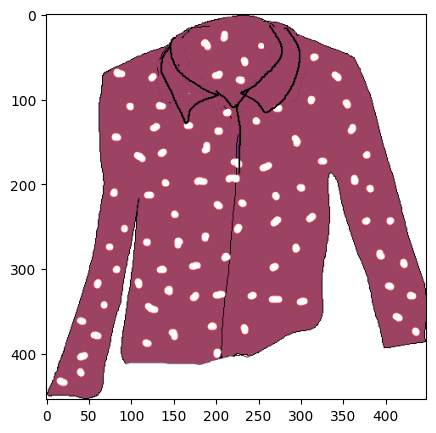

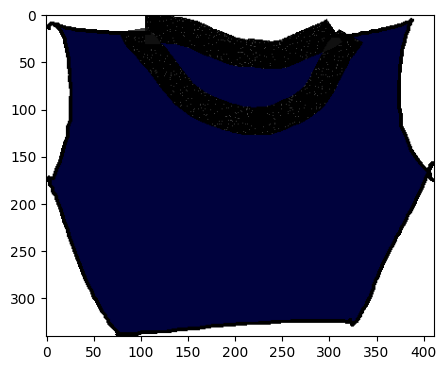

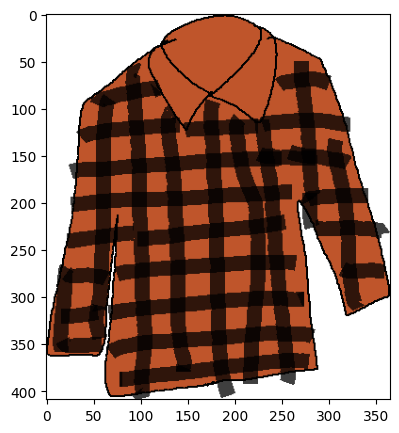

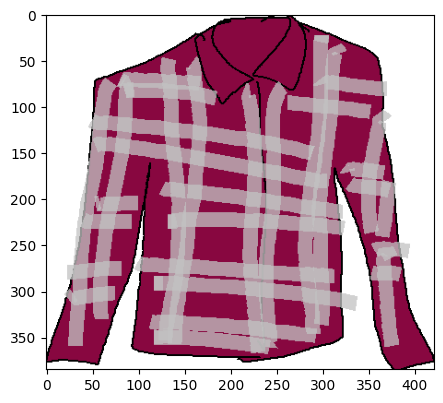

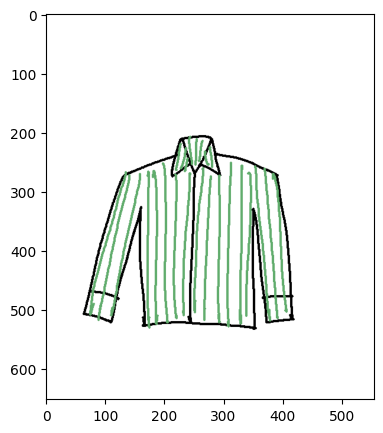

In [ ]:
for i in range(5):
  plt.figure(figsize=(5,5))
  img = Image.open(images[i])
  if img.mode != "RGB":
    img = img.convert("RGB")
  img.resize((252,252))
  plt.imshow(img);

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
with strategy.scope():
    inception_model = ResNet50(include_top=True)
    inception_model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
with strategy.scope():
    last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model
    model = Model(inputs=inception_model.input,outputs=last)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
img_features = {}

for img_path in tqdm(images):
    img = Image.open(img_path)

    if img.mode != "RGB":
        img = img.convert("RGB")

    # Resize the image to (224, 224)
    img = img.resize((224, 224))

    # Convert the image to a NumPy array if needed
    img_array = np.array(img)

    # Add batch dimension and normalize if necessary
    img_array = img_array.reshape(1, 224, 224, 3)

    # Assuming 'model' is your pre-trained model
    features = model.predict(img_array).reshape(2048,)

    # Extracting image name
    img_name = img_path.split('/')[-1]

    img_features[img_name] = features


  0%|          | 0/11655 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|          | 1/11655 [00:03<10:03:12,  3.11s/it]

1/1 [==============================] - 0s 34ms/step


  0%|          | 3/11655 [00:03<2:47:49,  1.16it/s] 

1/1 [==============================] - 0s 36ms/step


  0%|          | 5/11655 [00:03<1:29:18,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 6/11655 [00:03<1:12:01,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 8/11655 [00:03<47:43,  4.07it/s]  

1/1 [==============================] - 0s 37ms/step


  0%|          | 10/11655 [00:03<35:24,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 12/11655 [00:04<28:29,  6.81it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 14/11655 [00:04<24:52,  7.80it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 16/11655 [00:04<23:13,  8.35it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 18/11655 [00:04<21:35,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 20/11655 [00:04<20:48,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 22/11655 [00:05<20:45,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 24/11655 [00:05<21:17,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 25/11655 [00:05<22:32,  8.60it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 27/11655 [00:05<20:58,  9.24it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 29/11655 [00:05<21:16,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 31/11655 [00:06<20:26,  9.48it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 33/11655 [00:06<19:47,  9.79it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 35/11655 [00:06<19:50,  9.76it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 36/11655 [00:06<19:45,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 38/11655 [00:06<19:16, 10.04it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 40/11655 [00:06<19:12, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 42/11655 [00:07<18:49, 10.28it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 44/11655 [00:07<18:47, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 46/11655 [00:07<18:42, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 48/11655 [00:07<18:32, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 50/11655 [00:07<18:07, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 52/11655 [00:08<18:00, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 54/11655 [00:08<17:49, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 56/11655 [00:08<18:13, 10.61it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 58/11655 [00:08<18:36, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 60/11655 [00:08<18:19, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 62/11655 [00:08<18:06, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 64/11655 [00:09<18:53, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 66/11655 [00:09<18:34, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 68/11655 [00:09<18:32, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 70/11655 [00:09<18:17, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 72/11655 [00:09<18:42, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 74/11655 [00:10<18:07, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 76/11655 [00:10<18:27, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 78/11655 [00:10<17:19, 11.14it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 80/11655 [00:10<16:55, 11.40it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 82/11655 [00:10<16:15, 11.87it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 84/11655 [00:10<16:14, 11.87it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 86/11655 [00:11<17:56, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 88/11655 [00:11<17:04, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 90/11655 [00:11<16:31, 11.67it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 92/11655 [00:11<15:55, 12.10it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 94/11655 [00:11<16:56, 11.38it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 96/11655 [00:11<16:28, 11.70it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 98/11655 [00:12<16:09, 11.92it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 100/11655 [00:12<15:50, 12.15it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 102/11655 [00:12<15:40, 12.29it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 104/11655 [00:12<15:34, 12.36it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 106/11655 [00:12<15:53, 12.11it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 108/11655 [00:12<15:54, 12.10it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 110/11655 [00:13<16:12, 11.87it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 112/11655 [00:13<17:27, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 114/11655 [00:13<16:38, 11.55it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 116/11655 [00:13<16:04, 11.97it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 118/11655 [00:13<15:56, 12.06it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 120/11655 [00:13<16:10, 11.88it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 122/11655 [00:14<16:09, 11.90it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 124/11655 [00:14<15:59, 12.01it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 126/11655 [00:14<18:39, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 128/11655 [00:14<17:58, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 130/11655 [00:14<17:47, 10.80it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 132/11655 [00:15<17:11, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 134/11655 [00:15<16:53, 11.36it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 136/11655 [00:15<16:42, 11.48it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 138/11655 [00:15<16:40, 11.51it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 140/11655 [00:15<16:22, 11.72it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 142/11655 [00:15<16:56, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 144/11655 [00:16<16:42, 11.48it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 146/11655 [00:16<16:33, 11.58it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 148/11655 [00:16<16:48, 11.41it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 150/11655 [00:16<17:10, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 152/11655 [00:16<18:29, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 154/11655 [00:17<18:01, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 156/11655 [00:17<19:08, 10.02it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 158/11655 [00:17<18:20, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 160/11655 [00:17<17:36, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 162/11655 [00:17<17:13, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 164/11655 [00:17<16:54, 11.32it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 166/11655 [00:18<16:36, 11.53it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 168/11655 [00:18<16:46, 11.42it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 170/11655 [00:18<16:49, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 172/11655 [00:18<16:51, 11.35it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 174/11655 [00:18<18:59, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 176/11655 [00:19<17:58, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 178/11655 [00:19<20:34,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 180/11655 [00:19<19:09,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 182/11655 [00:19<20:08,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 184/11655 [00:19<19:14,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 186/11655 [00:20<18:36, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 188/11655 [00:20<19:34,  9.77it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 190/11655 [00:20<18:49, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 192/11655 [00:20<18:29, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 194/11655 [00:20<17:48, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 196/11655 [00:21<17:31, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 198/11655 [00:21<17:12, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 200/11655 [00:21<17:32, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 202/11655 [00:21<17:18, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 204/11655 [00:21<17:04, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 206/11655 [00:21<16:43, 11.41it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 208/11655 [00:22<16:21, 11.67it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 210/11655 [00:22<16:13, 11.75it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 212/11655 [00:22<16:16, 11.72it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 214/11655 [00:22<16:09, 11.80it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 216/11655 [00:22<16:10, 11.78it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 218/11655 [00:22<16:14, 11.74it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 220/11655 [00:23<16:23, 11.62it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 222/11655 [00:23<16:24, 11.61it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 224/11655 [00:23<16:36, 11.47it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 226/11655 [00:23<17:05, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 228/11655 [00:23<16:50, 11.31it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 230/11655 [00:24<16:31, 11.53it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 232/11655 [00:24<16:38, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 234/11655 [00:24<16:42, 11.39it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 236/11655 [00:24<16:34, 11.48it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 238/11655 [00:24<16:30, 11.53it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 240/11655 [00:24<16:16, 11.69it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 242/11655 [00:25<16:24, 11.60it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 244/11655 [00:25<18:54, 10.06it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 246/11655 [00:25<18:10, 10.46it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 248/11655 [00:25<17:48, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 250/11655 [00:25<17:19, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 252/11655 [00:26<17:00, 11.18it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 254/11655 [00:26<17:00, 11.17it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 256/11655 [00:26<17:00, 11.17it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 258/11655 [00:26<16:42, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 260/11655 [00:26<16:41, 11.38it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 262/11655 [00:26<16:52, 11.25it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 264/11655 [00:27<17:36, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 266/11655 [00:27<17:10, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 268/11655 [00:27<16:37, 11.42it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 270/11655 [00:27<16:27, 11.53it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 272/11655 [00:27<16:22, 11.59it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 274/11655 [00:27<16:10, 11.73it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 276/11655 [00:28<15:58, 11.88it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 278/11655 [00:28<16:00, 11.84it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 280/11655 [00:28<16:03, 11.81it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 282/11655 [00:28<16:04, 11.79it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 284/11655 [00:28<17:06, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 286/11655 [00:28<16:39, 11.38it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 288/11655 [00:29<16:57, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 290/11655 [00:29<16:41, 11.35it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 292/11655 [00:29<16:51, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 294/11655 [00:29<16:49, 11.25it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 296/11655 [00:29<16:37, 11.39it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 298/11655 [00:30<16:26, 11.51it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 300/11655 [00:30<16:29, 11.48it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 302/11655 [00:30<16:15, 11.64it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 304/11655 [00:30<17:38, 10.72it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 306/11655 [00:30<17:14, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 308/11655 [00:30<16:52, 11.21it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 310/11655 [00:31<16:43, 11.30it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 312/11655 [00:31<16:36, 11.38it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 314/11655 [00:31<16:19, 11.57it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 316/11655 [00:31<16:40, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 318/11655 [00:31<18:49, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 320/11655 [00:32<17:51, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 322/11655 [00:32<17:29, 10.80it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 324/11655 [00:32<16:55, 11.16it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 326/11655 [00:32<16:46, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 328/11655 [00:32<16:30, 11.44it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 330/11655 [00:32<16:40, 11.32it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 332/11655 [00:33<17:50, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 334/11655 [00:33<17:16, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 336/11655 [00:33<16:43, 11.28it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 338/11655 [00:33<16:28, 11.45it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 340/11655 [00:33<17:52, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 342/11655 [00:34<17:08, 11.00it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 344/11655 [00:34<16:43, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 346/11655 [00:34<17:36, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 348/11655 [00:34<17:00, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 350/11655 [00:34<18:05, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 352/11655 [00:34<17:43, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 354/11655 [00:35<17:02, 11.05it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 356/11655 [00:35<18:06, 10.40it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 358/11655 [00:35<17:17, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 360/11655 [00:35<16:57, 11.10it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 362/11655 [00:35<16:54, 11.13it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 364/11655 [00:36<16:42, 11.27it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 366/11655 [00:36<16:48, 11.19it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 368/11655 [00:36<17:41, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 370/11655 [00:36<19:49,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 372/11655 [00:36<19:58,  9.41it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 374/11655 [00:37<19:03,  9.86it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 376/11655 [00:37<18:04, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 378/11655 [00:37<17:45, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 380/11655 [00:37<17:10, 10.94it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 382/11655 [00:37<16:49, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 384/11655 [00:37<16:32, 11.36it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 386/11655 [00:38<17:49, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 388/11655 [00:38<17:09, 10.94it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 390/11655 [00:38<17:04, 11.00it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 392/11655 [00:38<16:51, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 394/11655 [00:38<16:31, 11.36it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 396/11655 [00:39<16:19, 11.50it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 398/11655 [00:39<16:28, 11.39it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 400/11655 [00:39<16:32, 11.34it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 402/11655 [00:39<16:17, 11.51it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 404/11655 [00:39<16:21, 11.46it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 406/11655 [00:39<16:11, 11.58it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 408/11655 [00:40<17:56, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 410/11655 [00:40<17:28, 10.72it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 412/11655 [00:40<17:17, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 414/11655 [00:40<17:04, 10.97it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 416/11655 [00:40<17:37, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 418/11655 [00:41<17:22, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 420/11655 [00:41<16:53, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 422/11655 [00:41<17:55, 10.45it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 424/11655 [00:41<17:25, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 426/11655 [00:41<17:01, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 428/11655 [00:41<16:46, 11.16it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 430/11655 [00:42<16:28, 11.36it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 432/11655 [00:42<16:12, 11.54it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 434/11655 [00:42<16:00, 11.68it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 436/11655 [00:42<15:45, 11.87it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 438/11655 [00:42<15:51, 11.79it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 440/11655 [00:42<15:47, 11.83it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 442/11655 [00:43<15:53, 11.76it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 444/11655 [00:43<17:22, 10.75it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 446/11655 [00:43<17:12, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 448/11655 [00:43<16:55, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 450/11655 [00:43<17:06, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 452/11655 [00:44<16:48, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 454/11655 [00:44<16:29, 11.32it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 456/11655 [00:44<16:25, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 458/11655 [00:44<17:40, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 460/11655 [00:44<17:17, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 462/11655 [00:44<16:53, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 464/11655 [00:45<16:28, 11.32it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 466/11655 [00:45<16:12, 11.50it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 468/11655 [00:45<16:10, 11.53it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 470/11655 [00:45<16:04, 11.60it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 472/11655 [00:45<16:00, 11.64it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 474/11655 [00:46<16:33, 11.26it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 476/11655 [00:46<16:24, 11.36it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 478/11655 [00:46<16:38, 11.20it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 480/11655 [00:46<16:19, 11.41it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 482/11655 [00:46<16:21, 11.38it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 484/11655 [00:46<16:19, 11.41it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 486/11655 [00:47<16:16, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 488/11655 [00:47<16:05, 11.57it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 490/11655 [00:47<16:09, 11.52it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 492/11655 [00:47<16:01, 11.61it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 494/11655 [00:47<16:08, 11.53it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 496/11655 [00:47<17:43, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 498/11655 [00:48<17:10, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 500/11655 [00:48<16:50, 11.04it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 502/11655 [00:48<16:54, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 504/11655 [00:48<18:03, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 506/11655 [00:48<18:21, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 508/11655 [00:49<17:47, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 510/11655 [00:49<16:50, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 512/11655 [00:49<16:37, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 514/11655 [00:49<16:28, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 516/11655 [00:49<15:52, 11.70it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 518/11655 [00:49<15:48, 11.74it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 520/11655 [00:50<16:06, 11.52it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 522/11655 [00:50<15:43, 11.80it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 524/11655 [00:50<15:15, 12.15it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 526/11655 [00:50<15:07, 12.26it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 528/11655 [00:50<14:57, 12.39it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 530/11655 [00:50<14:51, 12.48it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 532/11655 [00:51<14:40, 12.64it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 534/11655 [00:51<14:36, 12.69it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 536/11655 [00:51<14:22, 12.89it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 538/11655 [00:51<14:28, 12.80it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 540/11655 [00:51<15:35, 11.88it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 542/11655 [00:51<15:52, 11.67it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 544/11655 [00:52<17:43, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 546/11655 [00:52<17:21, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 548/11655 [00:52<17:10, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 550/11655 [00:52<16:39, 11.11it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 552/11655 [00:52<17:38, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 554/11655 [00:53<17:08, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 556/11655 [00:53<18:05, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 558/11655 [00:53<17:17, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 560/11655 [00:53<17:17, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 562/11655 [00:53<19:07,  9.67it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 564/11655 [00:54<18:10, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 566/11655 [00:54<18:16, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 568/11655 [00:54<17:26, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 570/11655 [00:54<16:58, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 572/11655 [00:54<17:57, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 574/11655 [00:55<17:40, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 576/11655 [00:55<16:58, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 578/11655 [00:55<16:46, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 580/11655 [00:55<16:20, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 582/11655 [00:55<16:11, 11.39it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 584/11655 [00:55<15:55, 11.59it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 586/11655 [00:56<15:50, 11.65it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 588/11655 [00:56<15:48, 11.67it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 590/11655 [00:56<17:02, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 592/11655 [00:56<16:29, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 594/11655 [00:56<16:12, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 596/11655 [00:56<17:03, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 598/11655 [00:57<16:55, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 600/11655 [00:57<16:37, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 602/11655 [00:57<16:20, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 604/11655 [00:57<16:09, 11.40it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 606/11655 [00:57<15:58, 11.53it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 608/11655 [00:57<15:52, 11.60it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 610/11655 [00:58<15:45, 11.68it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 612/11655 [00:58<15:51, 11.61it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 614/11655 [00:58<15:53, 11.58it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 616/11655 [00:58<15:45, 11.68it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 618/11655 [00:58<15:47, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 620/11655 [00:59<15:47, 11.65it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 622/11655 [00:59<17:02, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 624/11655 [00:59<16:28, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 626/11655 [00:59<15:39, 11.74it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 628/11655 [00:59<15:06, 12.17it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 630/11655 [00:59<14:53, 12.34it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 632/11655 [01:00<14:50, 12.38it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 634/11655 [01:00<14:54, 12.32it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 636/11655 [01:00<14:43, 12.47it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 638/11655 [01:00<14:42, 12.48it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 640/11655 [01:00<15:01, 12.22it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 642/11655 [01:00<15:08, 12.12it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 644/11655 [01:00<15:05, 12.16it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 646/11655 [01:01<15:02, 12.20it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 648/11655 [01:01<16:50, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 650/11655 [01:01<17:50, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 652/11655 [01:01<17:16, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 654/11655 [01:02<18:20, 10.00it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 656/11655 [01:02<17:32, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 658/11655 [01:02<16:54, 10.84it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 660/11655 [01:02<17:12, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 662/11655 [01:02<17:36, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 664/11655 [01:02<17:11, 10.66it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 666/11655 [01:03<16:38, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 668/11655 [01:03<16:03, 11.40it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 670/11655 [01:03<16:59, 10.77it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 672/11655 [01:03<16:04, 11.39it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 674/11655 [01:03<16:11, 11.30it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 676/11655 [01:03<16:02, 11.41it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 678/11655 [01:04<15:55, 11.49it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 680/11655 [01:04<17:45, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 682/11655 [01:04<17:14, 10.60it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 684/11655 [01:04<16:23, 11.15it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 686/11655 [01:04<15:58, 11.44it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 688/11655 [01:05<16:34, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 690/11655 [01:05<17:50, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 692/11655 [01:05<16:38, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 694/11655 [01:05<16:01, 11.40it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 696/11655 [01:05<17:35, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 698/11655 [01:06<16:56, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 700/11655 [01:06<16:53, 10.81it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 702/11655 [01:06<17:54, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 704/11655 [01:06<17:09, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 706/11655 [01:06<16:35, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 708/11655 [01:06<16:14, 11.23it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 710/11655 [01:07<16:09, 11.29it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 712/11655 [01:07<16:12, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 714/11655 [01:07<16:38, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 716/11655 [01:07<17:18, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 718/11655 [01:07<17:47, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 720/11655 [01:08<17:17, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 722/11655 [01:08<16:57, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 724/11655 [01:08<16:46, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 726/11655 [01:08<16:21, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 728/11655 [01:08<16:02, 11.35it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 730/11655 [01:08<17:20, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 732/11655 [01:09<16:55, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 734/11655 [01:09<16:33, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 736/11655 [01:09<16:07, 11.29it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 738/11655 [01:09<16:48, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 740/11655 [01:09<16:39, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 742/11655 [01:10<16:23, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 744/11655 [01:10<16:00, 11.36it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 746/11655 [01:10<16:22, 11.11it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 748/11655 [01:10<16:07, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 750/11655 [01:10<15:57, 11.39it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 752/11655 [01:10<15:51, 11.46it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 754/11655 [01:11<15:56, 11.40it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 756/11655 [01:11<16:00, 11.35it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 758/11655 [01:11<16:05, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 760/11655 [01:11<15:46, 11.51it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 762/11655 [01:11<15:51, 11.45it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 764/11655 [01:11<15:57, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 766/11655 [01:12<15:45, 11.52it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 768/11655 [01:12<16:59, 10.68it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 770/11655 [01:12<16:23, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 772/11655 [01:12<16:02, 11.31it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 774/11655 [01:12<16:03, 11.29it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 776/11655 [01:13<15:47, 11.48it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 778/11655 [01:13<15:45, 11.51it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 780/11655 [01:13<15:31, 11.67it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 782/11655 [01:13<15:25, 11.75it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 784/11655 [01:13<15:29, 11.70it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 786/11655 [01:13<15:24, 11.75it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 788/11655 [01:14<15:35, 11.61it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 790/11655 [01:14<15:37, 11.59it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 792/11655 [01:14<15:29, 11.68it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 794/11655 [01:14<15:27, 11.71it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 796/11655 [01:14<15:26, 11.72it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 798/11655 [01:14<15:25, 11.73it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 800/11655 [01:15<15:22, 11.77it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 802/11655 [01:15<15:21, 11.77it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 804/11655 [01:15<15:13, 11.88it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 806/11655 [01:15<15:09, 11.93it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 808/11655 [01:15<15:08, 11.94it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 810/11655 [01:15<15:05, 11.97it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 812/11655 [01:16<15:49, 11.42it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 814/11655 [01:16<15:37, 11.57it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 816/11655 [01:16<15:35, 11.58it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 818/11655 [01:16<15:23, 11.73it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 820/11655 [01:16<15:33, 11.61it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 822/11655 [01:16<15:22, 11.74it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 824/11655 [01:17<15:28, 11.67it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 826/11655 [01:17<15:19, 11.78it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 828/11655 [01:17<15:23, 11.72it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 830/11655 [01:17<15:17, 11.80it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 832/11655 [01:17<15:14, 11.83it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 834/11655 [01:17<15:11, 11.87it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 836/11655 [01:18<15:08, 11.91it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 838/11655 [01:18<15:11, 11.87it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 840/11655 [01:18<16:34, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 842/11655 [01:18<16:27, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 844/11655 [01:18<16:00, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 846/11655 [01:19<15:44, 11.45it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 848/11655 [01:19<15:37, 11.52it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 850/11655 [01:19<15:41, 11.48it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 852/11655 [01:19<15:49, 11.38it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 854/11655 [01:19<15:31, 11.59it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 856/11655 [01:19<15:26, 11.65it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 858/11655 [01:20<15:16, 11.78it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 860/11655 [01:20<15:05, 11.93it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 862/11655 [01:20<16:47, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 864/11655 [01:20<16:27, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 866/11655 [01:20<16:04, 11.19it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 868/11655 [01:20<15:53, 11.32it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 870/11655 [01:21<15:43, 11.43it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 872/11655 [01:21<16:12, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 874/11655 [01:21<16:20, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 876/11655 [01:21<15:54, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 878/11655 [01:21<15:42, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 880/11655 [01:22<15:37, 11.49it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 882/11655 [01:22<15:37, 11.49it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 884/11655 [01:22<15:20, 11.70it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 886/11655 [01:22<15:15, 11.76it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 888/11655 [01:22<15:15, 11.76it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 890/11655 [01:22<15:27, 11.61it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 892/11655 [01:23<15:20, 11.69it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 894/11655 [01:23<15:25, 11.62it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 896/11655 [01:23<15:19, 11.71it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 898/11655 [01:23<15:26, 11.61it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 900/11655 [01:23<16:07, 11.12it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 902/11655 [01:23<16:01, 11.18it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 904/11655 [01:24<15:51, 11.30it/s]

1/1 [==============================] - 0s 127ms/step


  8%|▊         | 906/11655 [01:24<18:17,  9.80it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 908/11655 [01:24<17:22, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 910/11655 [01:24<16:46, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 912/11655 [01:24<16:29, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 914/11655 [01:25<16:08, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 916/11655 [01:25<15:55, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 918/11655 [01:25<15:59, 11.19it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 920/11655 [01:25<15:40, 11.42it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 922/11655 [01:25<15:37, 11.45it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 924/11655 [01:25<15:27, 11.57it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 926/11655 [01:26<15:32, 11.50it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 928/11655 [01:26<15:32, 11.51it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 930/11655 [01:26<15:36, 11.46it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 932/11655 [01:26<15:27, 11.56it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 934/11655 [01:26<15:26, 11.57it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 936/11655 [01:26<15:17, 11.68it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 938/11655 [01:27<15:28, 11.55it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 940/11655 [01:27<15:40, 11.39it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 942/11655 [01:27<15:32, 11.48it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 944/11655 [01:27<16:52, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 946/11655 [01:27<16:33, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 948/11655 [01:28<16:10, 11.04it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 950/11655 [01:28<15:52, 11.24it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 952/11655 [01:28<15:38, 11.40it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 954/11655 [01:28<15:38, 11.40it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 956/11655 [01:28<15:34, 11.45it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 958/11655 [01:28<15:41, 11.36it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 960/11655 [01:29<15:37, 11.41it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 962/11655 [01:29<15:24, 11.57it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 964/11655 [01:29<15:54, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 966/11655 [01:29<15:39, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 968/11655 [01:29<15:20, 11.61it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 970/11655 [01:29<15:14, 11.69it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 972/11655 [01:30<15:12, 11.71it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 974/11655 [01:30<15:09, 11.74it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 976/11655 [01:30<15:02, 11.83it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 978/11655 [01:30<16:43, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 980/11655 [01:30<16:22, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 982/11655 [01:31<16:03, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 984/11655 [01:31<15:42, 11.33it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 986/11655 [01:31<15:36, 11.39it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 988/11655 [01:31<15:43, 11.31it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 990/11655 [01:31<15:32, 11.44it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 992/11655 [01:31<15:33, 11.42it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 994/11655 [01:32<15:35, 11.40it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 996/11655 [01:32<15:38, 11.36it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 998/11655 [01:32<15:31, 11.44it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1000/11655 [01:32<15:25, 11.52it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1002/11655 [01:32<15:18, 11.60it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1004/11655 [01:32<15:13, 11.66it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 1006/11655 [01:33<15:23, 11.53it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1008/11655 [01:33<15:17, 11.60it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 1010/11655 [01:33<15:12, 11.67it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1012/11655 [01:33<15:05, 11.75it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 1014/11655 [01:33<15:10, 11.69it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 1016/11655 [01:34<15:12, 11.66it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 1018/11655 [01:34<15:13, 11.64it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1020/11655 [01:34<15:03, 11.76it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1022/11655 [01:34<15:09, 11.69it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1024/11655 [01:34<16:18, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1026/11655 [01:34<15:55, 11.12it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1028/11655 [01:35<15:40, 11.30it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1030/11655 [01:35<15:45, 11.24it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1032/11655 [01:35<15:29, 11.43it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1034/11655 [01:35<16:35, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1036/11655 [01:35<16:15, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1038/11655 [01:35<15:48, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1040/11655 [01:36<15:26, 11.46it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1042/11655 [01:36<15:38, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1044/11655 [01:36<15:26, 11.46it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1046/11655 [01:36<15:59, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1048/11655 [01:36<16:10, 10.93it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 1050/11655 [01:37<15:54, 11.12it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1052/11655 [01:37<15:34, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1054/11655 [01:37<15:29, 11.40it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1056/11655 [01:37<15:16, 11.57it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1058/11655 [01:37<15:29, 11.40it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1060/11655 [01:37<15:25, 11.45it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1062/11655 [01:38<15:29, 11.40it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1064/11655 [01:38<15:17, 11.55it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 1066/11655 [01:38<15:47, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1068/11655 [01:38<15:54, 11.09it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1070/11655 [01:38<15:46, 11.18it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1072/11655 [01:38<15:27, 11.41it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1074/11655 [01:39<15:33, 11.34it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1076/11655 [01:39<15:21, 11.48it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1078/11655 [01:39<15:28, 11.39it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1080/11655 [01:39<16:48, 10.48it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1082/11655 [01:39<16:35, 10.62it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1084/11655 [01:40<16:19, 10.79it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 1086/11655 [01:40<16:08, 10.91it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1088/11655 [01:40<16:03, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1090/11655 [01:40<15:47, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1092/11655 [01:40<15:32, 11.33it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1094/11655 [01:40<15:18, 11.50it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1096/11655 [01:41<15:14, 11.54it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 1098/11655 [01:41<15:22, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1100/11655 [01:41<15:15, 11.53it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1102/11655 [01:41<15:17, 11.50it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1104/11655 [01:41<15:08, 11.61it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1106/11655 [01:41<15:02, 11.69it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1108/11655 [01:42<15:06, 11.64it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1110/11655 [01:42<15:09, 11.59it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1112/11655 [01:42<15:07, 11.61it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1114/11655 [01:42<15:04, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1116/11655 [01:42<15:08, 11.60it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 1118/11655 [01:43<15:13, 11.54it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1120/11655 [01:43<15:06, 11.62it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1122/11655 [01:43<15:08, 11.59it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1124/11655 [01:43<15:20, 11.44it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1126/11655 [01:43<15:11, 11.55it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1128/11655 [01:43<15:06, 11.62it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1130/11655 [01:44<14:59, 11.69it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1132/11655 [01:44<14:58, 11.71it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1134/11655 [01:44<14:58, 11.71it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1136/11655 [01:44<15:01, 11.66it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1138/11655 [01:44<15:12, 11.53it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1140/11655 [01:44<15:07, 11.58it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1142/11655 [01:45<15:05, 11.61it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1144/11655 [01:45<15:17, 11.45it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1146/11655 [01:45<15:21, 11.40it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1148/11655 [01:45<15:20, 11.41it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1150/11655 [01:45<15:09, 11.55it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 1152/11655 [01:45<15:06, 11.58it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1154/11655 [01:46<15:42, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1156/11655 [01:46<15:23, 11.37it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1158/11655 [01:46<15:22, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1160/11655 [01:46<15:15, 11.46it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1162/11655 [01:46<15:14, 11.48it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1164/11655 [01:47<16:10, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1166/11655 [01:47<15:46, 11.08it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1168/11655 [01:47<15:38, 11.17it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1170/11655 [01:47<15:20, 11.38it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 1172/11655 [01:47<15:15, 11.45it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 1174/11655 [01:47<15:10, 11.51it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1176/11655 [01:48<15:33, 11.23it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 1178/11655 [01:48<15:35, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1180/11655 [01:48<15:16, 11.43it/s]

1/1 [==============================] - 0s 116ms/step


 10%|█         | 1182/11655 [01:48<17:15, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1184/11655 [01:48<16:21, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1186/11655 [01:49<16:08, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1188/11655 [01:49<15:49, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1190/11655 [01:49<15:40, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1192/11655 [01:49<15:29, 11.26it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1194/11655 [01:49<15:12, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1196/11655 [01:49<15:12, 11.46it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1198/11655 [01:50<15:56, 10.93it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1200/11655 [01:50<15:35, 11.17it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1202/11655 [01:50<15:54, 10.95it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 1204/11655 [01:50<15:38, 11.14it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1206/11655 [01:50<15:24, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1208/11655 [01:51<16:36, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1210/11655 [01:51<16:06, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1212/11655 [01:51<15:36, 11.16it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1214/11655 [01:51<15:24, 11.29it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1216/11655 [01:51<15:17, 11.38it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1218/11655 [01:51<15:29, 11.23it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1220/11655 [01:52<15:17, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1222/11655 [01:52<15:13, 11.42it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1224/11655 [01:52<15:20, 11.33it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1226/11655 [01:52<15:09, 11.47it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1228/11655 [01:52<15:00, 11.57it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1230/11655 [01:52<14:58, 11.61it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1232/11655 [01:53<15:04, 11.53it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1234/11655 [01:53<15:06, 11.50it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1236/11655 [01:53<14:52, 11.68it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1238/11655 [01:53<14:56, 11.62it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1240/11655 [01:53<14:47, 11.74it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1242/11655 [01:53<15:33, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1244/11655 [01:54<15:24, 11.27it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1246/11655 [01:54<15:08, 11.46it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1248/11655 [01:54<15:08, 11.46it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1250/11655 [01:54<15:49, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1252/11655 [01:54<15:32, 11.15it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 1254/11655 [01:55<15:33, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1256/11655 [01:55<15:12, 11.39it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1258/11655 [01:55<16:21, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 1260/11655 [01:55<15:58, 10.84it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 1262/11655 [01:55<15:53, 10.90it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 1264/11655 [01:55<15:46, 10.97it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 1266/11655 [01:56<15:53, 10.90it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 1268/11655 [01:56<15:38, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1270/11655 [01:56<15:35, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1272/11655 [01:56<15:21, 11.27it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1274/11655 [01:56<15:15, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1276/11655 [01:57<16:17, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1278/11655 [01:57<17:21,  9.96it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1280/11655 [01:57<16:36, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 1282/11655 [01:57<16:15, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1284/11655 [01:57<15:55, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1286/11655 [01:58<16:07, 10.71it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 1288/11655 [01:58<15:41, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1290/11655 [01:58<15:17, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1292/11655 [01:58<15:11, 11.37it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1294/11655 [01:58<15:09, 11.39it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1296/11655 [01:58<16:12, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1298/11655 [01:59<15:53, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1300/11655 [01:59<15:42, 10.99it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 1302/11655 [01:59<15:32, 11.10it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1304/11655 [01:59<15:24, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1306/11655 [01:59<15:10, 11.36it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1308/11655 [02:00<16:21, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1310/11655 [02:00<15:56, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 1312/11655 [02:00<15:24, 11.18it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 1314/11655 [02:00<15:50, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 1316/11655 [02:00<15:22, 11.21it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 1318/11655 [02:00<15:22, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 1320/11655 [02:01<17:29,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 1322/11655 [02:01<16:54, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 1324/11655 [02:01<17:33,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 1326/11655 [02:01<16:54, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 1328/11655 [02:01<16:24, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 1330/11655 [02:02<16:12, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 1332/11655 [02:02<17:13,  9.99it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 1334/11655 [02:02<16:36, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 1336/11655 [02:02<16:13, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 1338/11655 [02:02<16:10, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 1340/11655 [02:03<15:42, 10.94it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 1342/11655 [02:03<15:27, 11.12it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1344/11655 [02:03<15:27, 11.12it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1346/11655 [02:03<15:14, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1348/11655 [02:03<15:06, 11.37it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1350/11655 [02:03<16:24, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1352/11655 [02:04<15:57, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1354/11655 [02:04<15:45, 10.89it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1356/11655 [02:04<16:36, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1358/11655 [02:04<15:57, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1360/11655 [02:04<15:37, 10.98it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 1362/11655 [02:05<15:30, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1364/11655 [02:05<15:12, 11.28it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1366/11655 [02:05<14:57, 11.46it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1368/11655 [02:05<14:44, 11.63it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1370/11655 [02:05<14:37, 11.72it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1372/11655 [02:05<14:35, 11.74it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1374/11655 [02:06<14:41, 11.66it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1376/11655 [02:06<16:52, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1378/11655 [02:06<17:26,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1380/11655 [02:06<16:35, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1382/11655 [02:06<17:14,  9.93it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1384/11655 [02:07<16:28, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1386/11655 [02:07<16:03, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1388/11655 [02:07<15:34, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1390/11655 [02:07<15:20, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1392/11655 [02:07<15:07, 11.30it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1394/11655 [02:07<14:57, 11.44it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 1396/11655 [02:08<15:46, 10.84it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1398/11655 [02:08<15:22, 11.12it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1400/11655 [02:08<15:21, 11.13it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1402/11655 [02:08<15:21, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1404/11655 [02:08<16:12, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1406/11655 [02:09<17:02, 10.02it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 1408/11655 [02:09<16:12, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1410/11655 [02:09<15:48, 10.81it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 1412/11655 [02:09<15:32, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1414/11655 [02:09<15:13, 11.21it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1416/11655 [02:10<15:06, 11.30it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 1418/11655 [02:10<15:06, 11.30it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 1420/11655 [02:10<15:09, 11.26it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1422/11655 [02:10<14:54, 11.44it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1424/11655 [02:10<14:48, 11.51it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1426/11655 [02:10<15:00, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1428/11655 [02:11<16:45, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1430/11655 [02:11<17:07,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1432/11655 [02:11<16:10, 10.53it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 1434/11655 [02:11<15:56, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1436/11655 [02:11<15:45, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1438/11655 [02:12<15:49, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1440/11655 [02:12<15:36, 10.91it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 1442/11655 [02:12<15:40, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1444/11655 [02:12<15:18, 11.12it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1446/11655 [02:12<15:13, 11.18it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1448/11655 [02:12<14:54, 11.41it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1450/11655 [02:13<14:46, 11.52it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1452/11655 [02:13<14:39, 11.60it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1454/11655 [02:13<14:55, 11.39it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1456/11655 [02:13<14:49, 11.46it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1458/11655 [02:13<14:35, 11.64it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1460/11655 [02:13<14:47, 11.49it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1462/11655 [02:14<14:55, 11.38it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1464/11655 [02:14<15:05, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1466/11655 [02:14<14:47, 11.48it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1468/11655 [02:14<16:13, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1470/11655 [02:14<16:28, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1472/11655 [02:15<16:01, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1474/11655 [02:15<15:32, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1476/11655 [02:15<15:13, 11.14it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1478/11655 [02:15<14:57, 11.34it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1480/11655 [02:15<14:48, 11.45it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1482/11655 [02:15<14:38, 11.58it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1484/11655 [02:16<14:31, 11.67it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1486/11655 [02:16<15:44, 10.76it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1488/11655 [02:16<16:36, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1490/11655 [02:16<15:57, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1492/11655 [02:16<15:28, 10.95it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1494/11655 [02:17<15:11, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1496/11655 [02:17<15:31, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1498/11655 [02:17<15:03, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1500/11655 [02:17<14:58, 11.30it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1502/11655 [02:17<15:38, 10.82it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1504/11655 [02:17<15:20, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1506/11655 [02:18<15:00, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1508/11655 [02:18<14:47, 11.44it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1510/11655 [02:18<14:57, 11.31it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1512/11655 [02:18<14:42, 11.50it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1514/11655 [02:18<14:30, 11.65it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1516/11655 [02:18<14:26, 11.70it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1518/11655 [02:19<14:24, 11.73it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1520/11655 [02:19<14:28, 11.67it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1522/11655 [02:19<14:21, 11.77it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1524/11655 [02:19<15:45, 10.71it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1526/11655 [02:19<15:28, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1528/11655 [02:20<15:12, 11.09it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1530/11655 [02:20<15:02, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1532/11655 [02:20<14:47, 11.41it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1534/11655 [02:20<16:48, 10.04it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1536/11655 [02:20<16:50, 10.02it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1538/11655 [02:21<16:12, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1540/11655 [02:21<15:45, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1542/11655 [02:21<15:19, 11.00it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1544/11655 [02:21<16:40, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1546/11655 [02:21<16:32, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1548/11655 [02:22<16:01, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1550/11655 [02:22<17:02,  9.88it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1552/11655 [02:22<16:20, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1554/11655 [02:22<15:42, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1556/11655 [02:22<15:15, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1558/11655 [02:22<15:03, 11.18it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1560/11655 [02:23<14:54, 11.29it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1562/11655 [02:23<14:43, 11.43it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1564/11655 [02:23<14:39, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1566/11655 [02:23<14:30, 11.59it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1568/11655 [02:23<16:26, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1570/11655 [02:24<17:32,  9.58it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1572/11655 [02:24<17:49,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 1574/11655 [02:24<16:45, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 1576/11655 [02:24<16:00, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 1578/11655 [02:24<15:27, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 1580/11655 [02:24<15:10, 11.06it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 1582/11655 [02:25<14:55, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 1584/11655 [02:25<14:56, 11.23it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 1586/11655 [02:25<14:52, 11.29it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 1588/11655 [02:25<14:54, 11.25it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 1590/11655 [02:25<14:48, 11.33it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 1592/11655 [02:26<14:37, 11.47it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 1594/11655 [02:26<14:42, 11.40it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 1596/11655 [02:26<14:48, 11.32it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 1598/11655 [02:26<14:57, 11.21it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 1600/11655 [02:26<14:52, 11.27it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 1602/11655 [02:26<14:51, 11.28it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1604/11655 [02:27<14:43, 11.38it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1606/11655 [02:27<14:39, 11.42it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1608/11655 [02:27<14:52, 11.26it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1610/11655 [02:27<16:10, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1612/11655 [02:27<16:26, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1614/11655 [02:28<16:04, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1616/11655 [02:28<16:06, 10.39it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1618/11655 [02:28<15:47, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1620/11655 [02:28<16:35, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1622/11655 [02:28<16:04, 10.40it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1624/11655 [02:29<15:26, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1626/11655 [02:29<15:04, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1628/11655 [02:29<14:43, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1630/11655 [02:29<14:51, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1632/11655 [02:29<14:57, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1634/11655 [02:29<14:50, 11.25it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1636/11655 [02:30<14:55, 11.19it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1638/11655 [02:30<14:51, 11.23it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1640/11655 [02:30<15:16, 10.93it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1642/11655 [02:30<14:56, 11.17it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1644/11655 [02:30<14:51, 11.23it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1646/11655 [02:30<14:39, 11.38it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1648/11655 [02:31<15:52, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1650/11655 [02:31<15:21, 10.86it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1652/11655 [02:31<15:09, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1654/11655 [02:31<14:55, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1656/11655 [02:31<14:40, 11.35it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1658/11655 [02:32<14:43, 11.32it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1660/11655 [02:32<14:29, 11.49it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1662/11655 [02:32<14:31, 11.47it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1664/11655 [02:32<14:32, 11.45it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1666/11655 [02:32<14:26, 11.53it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1668/11655 [02:32<14:25, 11.54it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1670/11655 [02:33<15:40, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1672/11655 [02:33<15:08, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1674/11655 [02:33<14:44, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1676/11655 [02:33<14:27, 11.50it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1678/11655 [02:33<14:36, 11.38it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1680/11655 [02:33<14:38, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1682/11655 [02:34<15:09, 10.97it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1684/11655 [02:34<14:56, 11.13it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1686/11655 [02:34<14:50, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1688/11655 [02:34<14:40, 11.32it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1690/11655 [02:34<14:28, 11.48it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1692/11655 [02:35<14:26, 11.50it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1694/11655 [02:35<14:19, 11.60it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1696/11655 [02:35<14:09, 11.72it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1698/11655 [02:35<14:06, 11.76it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1700/11655 [02:35<14:08, 11.74it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1702/11655 [02:35<14:11, 11.68it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1704/11655 [02:36<15:25, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1706/11655 [02:36<15:07, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1708/11655 [02:36<14:46, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1710/11655 [02:36<14:39, 11.31it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1712/11655 [02:36<16:00, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1714/11655 [02:37<15:28, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1716/11655 [02:37<15:13, 10.88it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1718/11655 [02:37<14:58, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1720/11655 [02:37<15:57, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1722/11655 [02:37<15:19, 10.80it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1724/11655 [02:37<14:53, 11.11it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1726/11655 [02:38<14:41, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1728/11655 [02:38<14:32, 11.38it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1730/11655 [02:38<14:31, 11.39it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 1732/11655 [02:38<14:27, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1734/11655 [02:38<14:22, 11.50it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1736/11655 [02:38<14:17, 11.57it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1738/11655 [02:39<14:14, 11.60it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1740/11655 [02:39<14:17, 11.56it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1742/11655 [02:39<14:19, 11.53it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1744/11655 [02:39<14:10, 11.66it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1746/11655 [02:39<15:14, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 1748/11655 [02:40<15:08, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1750/11655 [02:40<14:59, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1752/11655 [02:40<14:48, 11.15it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1754/11655 [02:40<14:38, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1756/11655 [02:40<14:26, 11.43it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1758/11655 [02:40<14:25, 11.44it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1760/11655 [02:41<16:26, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1762/11655 [02:41<15:45, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1764/11655 [02:41<15:23, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1766/11655 [02:41<15:03, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1768/11655 [02:41<14:50, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1770/11655 [02:42<14:36, 11.28it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1772/11655 [02:42<14:35, 11.29it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1774/11655 [02:42<14:28, 11.38it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1776/11655 [02:42<17:02,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1778/11655 [02:42<16:09, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1780/11655 [02:43<15:37, 10.53it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1782/11655 [02:43<15:14, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1784/11655 [02:43<15:06, 10.89it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1786/11655 [02:43<15:30, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1788/11655 [02:43<15:07, 10.87it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1790/11655 [02:43<14:56, 11.01it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1792/11655 [02:44<14:54, 11.03it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1794/11655 [02:44<14:49, 11.08it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1796/11655 [02:44<14:47, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1798/11655 [02:44<14:46, 11.12it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1800/11655 [02:44<14:41, 11.18it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1802/11655 [02:45<14:29, 11.33it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1804/11655 [02:45<14:22, 11.42it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1806/11655 [02:45<15:22, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1808/11655 [02:45<15:03, 10.90it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1810/11655 [02:45<15:02, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1812/11655 [02:45<14:40, 11.18it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1814/11655 [02:46<14:32, 11.28it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1816/11655 [02:46<14:44, 11.13it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1818/11655 [02:46<15:30, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1820/11655 [02:46<15:04, 10.87it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1822/11655 [02:46<16:08, 10.15it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1824/11655 [02:47<17:25,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1826/11655 [02:47<16:35,  9.87it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1828/11655 [02:47<15:56, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1830/11655 [02:47<15:35, 10.50it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1832/11655 [02:47<15:14, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1834/11655 [02:48<15:08, 10.81it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1836/11655 [02:48<14:55, 10.96it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1838/11655 [02:48<15:58, 10.24it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1840/11655 [02:48<15:27, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1842/11655 [02:48<15:13, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1844/11655 [02:48<15:08, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1846/11655 [02:49<14:44, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1848/11655 [02:49<14:29, 11.27it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1850/11655 [02:49<14:21, 11.38it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1852/11655 [02:49<14:14, 11.47it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1854/11655 [02:49<14:14, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1856/11655 [02:50<15:38, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1858/11655 [02:50<15:13, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1860/11655 [02:50<14:55, 10.93it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1862/11655 [02:50<14:49, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1864/11655 [02:50<14:33, 11.21it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1866/11655 [02:50<15:38, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1868/11655 [02:51<15:11, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1870/11655 [02:51<16:04, 10.14it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1872/11655 [02:51<15:29, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1874/11655 [02:51<14:58, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1876/11655 [02:51<14:47, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1878/11655 [02:52<14:38, 11.12it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1880/11655 [02:52<14:32, 11.20it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1882/11655 [02:52<14:26, 11.27it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1884/11655 [02:52<14:18, 11.38it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1886/11655 [02:52<15:25, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1888/11655 [02:52<14:54, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1890/11655 [02:53<14:35, 11.15it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1892/11655 [02:53<14:32, 11.19it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 1894/11655 [02:53<15:34, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1896/11655 [02:53<14:57, 10.88it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 1898/11655 [02:53<14:41, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1900/11655 [02:54<14:31, 11.19it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 1902/11655 [02:54<14:26, 11.26it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 1904/11655 [02:54<14:15, 11.39it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 1906/11655 [02:54<14:13, 11.42it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1908/11655 [02:54<14:19, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1910/11655 [02:54<14:36, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 1912/11655 [02:55<14:29, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1914/11655 [02:55<14:42, 11.04it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1916/11655 [02:55<15:32, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1918/11655 [02:55<16:09, 10.04it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1920/11655 [02:55<15:28, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1922/11655 [02:56<15:00, 10.81it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1924/11655 [02:56<14:47, 10.96it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1926/11655 [02:56<14:48, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1928/11655 [02:56<15:15, 10.63it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1930/11655 [02:56<14:54, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1932/11655 [02:56<14:35, 11.10it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1934/11655 [02:57<14:24, 11.24it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1936/11655 [02:57<14:20, 11.30it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1938/11655 [02:57<14:13, 11.38it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1940/11655 [02:57<14:14, 11.36it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1942/11655 [02:57<14:19, 11.30it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1944/11655 [02:58<14:22, 11.26it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1946/11655 [02:58<14:28, 11.18it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1948/11655 [02:58<15:34, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1950/11655 [02:58<15:04, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1952/11655 [02:58<16:59,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1954/11655 [02:59<16:06, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1956/11655 [02:59<15:30, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1958/11655 [02:59<14:57, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1960/11655 [02:59<14:47, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1962/11655 [02:59<14:42, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1964/11655 [02:59<14:40, 11.00it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1966/11655 [03:00<14:44, 10.95it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1968/11655 [03:00<14:50, 10.88it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1970/11655 [03:00<14:41, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1972/11655 [03:00<15:02, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1974/11655 [03:00<14:48, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1976/11655 [03:01<15:27, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1978/11655 [03:01<15:14, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1980/11655 [03:01<14:59, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1982/11655 [03:01<14:43, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1984/11655 [03:01<14:32, 11.08it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1986/11655 [03:01<14:21, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1988/11655 [03:02<14:08, 11.39it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1990/11655 [03:02<14:17, 11.27it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1992/11655 [03:02<14:13, 11.32it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1994/11655 [03:02<14:06, 11.41it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1996/11655 [03:02<14:04, 11.44it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1998/11655 [03:03<14:13, 11.32it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2000/11655 [03:03<14:08, 11.38it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 2002/11655 [03:03<14:40, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2004/11655 [03:03<14:25, 11.15it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 2006/11655 [03:03<14:25, 11.15it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 2008/11655 [03:03<14:23, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 2010/11655 [03:04<14:13, 11.30it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2012/11655 [03:04<14:09, 11.35it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 2014/11655 [03:04<15:16, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2016/11655 [03:04<15:01, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 2018/11655 [03:04<14:46, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2020/11655 [03:05<14:32, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2022/11655 [03:05<14:16, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2024/11655 [03:05<14:07, 11.36it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 2026/11655 [03:05<14:04, 11.41it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2028/11655 [03:05<13:55, 11.53it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 2030/11655 [03:05<14:06, 11.38it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 2032/11655 [03:06<14:24, 11.13it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 2034/11655 [03:06<14:26, 11.10it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2036/11655 [03:06<14:20, 11.17it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 2038/11655 [03:06<14:15, 11.24it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2040/11655 [03:06<14:15, 11.24it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2042/11655 [03:06<14:18, 11.19it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2044/11655 [03:07<15:22, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2046/11655 [03:07<14:56, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2048/11655 [03:07<15:06, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2050/11655 [03:07<16:05,  9.95it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2052/11655 [03:07<15:18, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2054/11655 [03:08<15:01, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2056/11655 [03:08<14:37, 10.95it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2058/11655 [03:08<14:27, 11.06it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2060/11655 [03:08<14:21, 11.14it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2062/11655 [03:08<15:36, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2064/11655 [03:09<15:04, 10.60it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2066/11655 [03:09<14:51, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2068/11655 [03:09<14:42, 10.87it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2070/11655 [03:09<14:26, 11.06it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2072/11655 [03:09<14:24, 11.08it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 2074/11655 [03:09<14:21, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2076/11655 [03:10<14:27, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2078/11655 [03:10<15:30, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2080/11655 [03:10<15:05, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2082/11655 [03:10<15:25, 10.34it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 2084/11655 [03:10<14:54, 10.70it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 2086/11655 [03:11<14:43, 10.83it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 2088/11655 [03:11<14:37, 10.91it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2090/11655 [03:11<14:16, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2092/11655 [03:11<14:12, 11.22it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2094/11655 [03:11<14:25, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 2096/11655 [03:11<14:09, 11.25it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2098/11655 [03:12<14:00, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 2100/11655 [03:12<13:51, 11.49it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2102/11655 [03:12<14:27, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2104/11655 [03:12<14:12, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2106/11655 [03:12<14:04, 11.31it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 2108/11655 [03:13<14:24, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2110/11655 [03:13<14:08, 11.24it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2112/11655 [03:13<14:19, 11.11it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2114/11655 [03:13<14:10, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2116/11655 [03:13<14:04, 11.30it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2118/11655 [03:13<14:18, 11.11it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 2120/11655 [03:14<14:28, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2122/11655 [03:14<14:36, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2124/11655 [03:14<14:48, 10.72it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2126/11655 [03:14<15:39, 10.14it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2128/11655 [03:14<16:09,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 2130/11655 [03:15<15:34, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2132/11655 [03:15<15:12, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2134/11655 [03:15<14:43, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2136/11655 [03:15<14:26, 10.98it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 2138/11655 [03:15<14:39, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2140/11655 [03:16<14:48, 10.71it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 2142/11655 [03:16<14:55, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2144/11655 [03:16<16:53,  9.39it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2145/11655 [03:16<16:53,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 2147/11655 [03:16<16:03,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2149/11655 [03:17<16:52,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2151/11655 [03:17<15:58,  9.92it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 2153/11655 [03:17<15:47, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2155/11655 [03:17<15:09, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 2157/11655 [03:17<14:44, 10.73it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2159/11655 [03:17<14:26, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2161/11655 [03:18<14:18, 11.06it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 2163/11655 [03:18<14:09, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 2165/11655 [03:18<14:27, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2167/11655 [03:18<14:20, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2169/11655 [03:18<14:08, 11.18it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 2171/11655 [03:18<14:05, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2173/11655 [03:19<13:57, 11.33it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2175/11655 [03:19<14:03, 11.24it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 2177/11655 [03:19<14:03, 11.23it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2179/11655 [03:19<13:54, 11.35it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 2181/11655 [03:19<13:58, 11.30it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 2183/11655 [03:20<13:58, 11.29it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 2185/11655 [03:20<14:01, 11.26it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2187/11655 [03:20<13:57, 11.31it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2189/11655 [03:20<13:48, 11.43it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 2191/11655 [03:20<13:47, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2193/11655 [03:20<13:35, 11.60it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2195/11655 [03:21<13:46, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2197/11655 [03:21<13:49, 11.41it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 2199/11655 [03:21<13:50, 11.39it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 2201/11655 [03:21<13:55, 11.31it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2203/11655 [03:21<13:51, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2205/11655 [03:21<13:47, 11.42it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2207/11655 [03:22<13:51, 11.37it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 2209/11655 [03:22<15:16, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 2211/11655 [03:22<14:53, 10.57it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 2213/11655 [03:22<14:41, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2215/11655 [03:22<14:17, 11.01it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 2217/11655 [03:23<14:28, 10.87it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 2219/11655 [03:23<14:25, 10.91it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2221/11655 [03:23<14:08, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2223/11655 [03:23<15:08, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2225/11655 [03:23<14:36, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2227/11655 [03:24<14:21, 10.95it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2229/11655 [03:24<14:18, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2231/11655 [03:24<14:03, 11.17it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 2233/11655 [03:24<14:12, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2235/11655 [03:24<14:00, 11.21it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2237/11655 [03:24<13:59, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2239/11655 [03:25<13:53, 11.29it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2241/11655 [03:25<13:50, 11.33it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2243/11655 [03:25<13:46, 11.38it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2245/11655 [03:25<13:39, 11.48it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2247/11655 [03:25<13:47, 11.37it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 2249/11655 [03:25<13:45, 11.39it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2251/11655 [03:26<13:40, 11.47it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 2253/11655 [03:26<14:08, 11.08it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2255/11655 [03:26<14:16, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 2257/11655 [03:26<15:56,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 2259/11655 [03:26<15:18, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2261/11655 [03:27<14:50, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2263/11655 [03:27<14:28, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2265/11655 [03:27<14:17, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2267/11655 [03:27<14:10, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 2269/11655 [03:27<14:04, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 2271/11655 [03:28<15:10, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2273/11655 [03:28<14:37, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 2275/11655 [03:28<14:22, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 2277/11655 [03:28<14:17, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2279/11655 [03:28<14:04, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2281/11655 [03:28<13:58, 11.18it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 2283/11655 [03:29<13:51, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 2285/11655 [03:29<14:54, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2287/11655 [03:29<14:40, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 2289/11655 [03:29<14:23, 10.85it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 2291/11655 [03:29<14:12, 10.98it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 2293/11655 [03:30<14:09, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2295/11655 [03:30<14:28, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2297/11655 [03:30<14:06, 11.06it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 2299/11655 [03:30<13:57, 11.18it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2301/11655 [03:30<14:57, 10.42it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 2303/11655 [03:30<14:40, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 2305/11655 [03:31<14:26, 10.80it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 2307/11655 [03:31<14:19, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2309/11655 [03:31<14:01, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 2311/11655 [03:31<13:53, 11.21it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 2313/11655 [03:31<13:57, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 2315/11655 [03:32<13:55, 11.17it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 2317/11655 [03:32<13:57, 11.15it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 2319/11655 [03:32<14:17, 10.89it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 2321/11655 [03:32<14:03, 11.07it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 2323/11655 [03:32<13:49, 11.25it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 2325/11655 [03:32<13:45, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 2327/11655 [03:33<13:37, 11.41it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 2329/11655 [03:33<14:13, 10.93it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 2331/11655 [03:33<14:07, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 2333/11655 [03:33<13:53, 11.19it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 2335/11655 [03:33<15:37,  9.95it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 2337/11655 [03:34<17:07,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 2339/11655 [03:34<16:06,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2341/11655 [03:34<15:12, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2343/11655 [03:34<14:45, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 2345/11655 [03:34<14:29, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 2347/11655 [03:35<14:12, 10.92it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 2349/11655 [03:35<14:09, 10.95it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 2351/11655 [03:35<14:04, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2353/11655 [03:35<14:58, 10.35it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 2355/11655 [03:35<14:39, 10.58it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 2357/11655 [03:35<14:10, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2359/11655 [03:36<15:09, 10.22it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 2361/11655 [03:36<15:52,  9.76it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 2363/11655 [03:36<15:14, 10.16it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 2365/11655 [03:36<14:52, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2367/11655 [03:37<15:06, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 2369/11655 [03:37<14:49, 10.44it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 2371/11655 [03:37<14:54, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2373/11655 [03:37<15:34,  9.93it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2375/11655 [03:37<15:11, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 2377/11655 [03:37<14:43, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 2379/11655 [03:38<14:20, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2381/11655 [03:38<14:00, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 2383/11655 [03:38<13:51, 11.15it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2385/11655 [03:38<13:50, 11.17it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 2387/11655 [03:38<14:51, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 2389/11655 [03:39<14:22, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2391/11655 [03:39<14:04, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2393/11655 [03:39<13:52, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2395/11655 [03:39<13:55, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2397/11655 [03:39<14:44, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2399/11655 [03:39<14:23, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2401/11655 [03:40<14:14, 10.83it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2403/11655 [03:40<16:07,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2405/11655 [03:40<15:17, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 2407/11655 [03:40<16:18,  9.45it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 2409/11655 [03:41<15:29,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 2411/11655 [03:41<15:02, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2413/11655 [03:41<15:33,  9.90it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2415/11655 [03:41<15:06, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 2417/11655 [03:41<14:40, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 2419/11655 [03:41<14:13, 10.82it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2421/11655 [03:42<13:59, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2423/11655 [03:42<13:48, 11.14it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 2425/11655 [03:42<13:36, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2427/11655 [03:42<14:36, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2429/11655 [03:42<14:16, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2431/11655 [03:43<14:05, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2433/11655 [03:43<13:53, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2435/11655 [03:43<13:57, 11.00it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 2437/11655 [03:43<13:48, 11.12it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2439/11655 [03:43<14:50, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2441/11655 [03:43<14:17, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2443/11655 [03:44<14:16, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 2445/11655 [03:44<14:06, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2447/11655 [03:44<14:20, 10.71it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 2449/11655 [03:44<14:19, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2451/11655 [03:44<14:08, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2453/11655 [03:45<13:52, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2455/11655 [03:45<13:42, 11.19it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2457/11655 [03:45<13:40, 11.22it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2459/11655 [03:45<13:52, 11.05it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2461/11655 [03:45<13:46, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2463/11655 [03:45<13:45, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2465/11655 [03:46<13:48, 11.09it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2467/11655 [03:46<13:45, 11.13it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2469/11655 [03:46<15:00, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 2471/11655 [03:46<14:39, 10.44it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 2473/11655 [03:46<14:20, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2475/11655 [03:47<14:14, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 2477/11655 [03:47<14:01, 10.90it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 2479/11655 [03:47<13:57, 10.96it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 2481/11655 [03:47<13:52, 11.02it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 2483/11655 [03:47<13:50, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 2485/11655 [03:48<13:53, 11.00it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 2487/11655 [03:48<15:10, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 2489/11655 [03:48<14:42, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 2491/11655 [03:48<14:28, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 2493/11655 [03:48<14:23, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 2495/11655 [03:48<14:08, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 2497/11655 [03:49<14:00, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 2499/11655 [03:49<13:46, 11.08it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 2501/11655 [03:49<13:59, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 2503/11655 [03:49<13:54, 10.97it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 2505/11655 [03:49<13:51, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2507/11655 [03:50<13:41, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2509/11655 [03:50<13:31, 11.27it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 2511/11655 [03:50<13:37, 11.18it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2513/11655 [03:50<13:47, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2515/11655 [03:50<14:46, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 2517/11655 [03:51<14:40, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2519/11655 [03:51<14:38, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2521/11655 [03:51<14:08, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 2523/11655 [03:51<13:51, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2525/11655 [03:51<14:08, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2527/11655 [03:51<15:47,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2529/11655 [03:52<15:03, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 2531/11655 [03:52<14:34, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2533/11655 [03:52<14:16, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 2535/11655 [03:52<14:06, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2537/11655 [03:52<13:57, 10.89it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 2539/11655 [03:53<13:52, 10.95it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2541/11655 [03:53<13:40, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2543/11655 [03:53<13:33, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 2545/11655 [03:53<13:29, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2547/11655 [03:53<13:25, 11.30it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 2549/11655 [03:53<13:29, 11.25it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 2551/11655 [03:54<14:33, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 2553/11655 [03:54<14:09, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2555/11655 [03:54<13:49, 10.97it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2557/11655 [03:54<14:08, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2559/11655 [03:54<14:02, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2561/11655 [03:55<13:45, 11.02it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 2563/11655 [03:55<13:37, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2565/11655 [03:55<13:26, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2567/11655 [03:55<13:31, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 2569/11655 [03:55<13:41, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2571/11655 [03:55<13:43, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2573/11655 [03:56<13:27, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2575/11655 [03:56<13:29, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2577/11655 [03:56<14:06, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2579/11655 [03:56<13:44, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2581/11655 [03:56<13:47, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2583/11655 [03:57<13:38, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2585/11655 [03:57<13:34, 11.14it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 2587/11655 [03:57<14:49, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2589/11655 [03:57<15:51,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2591/11655 [03:57<15:14,  9.91it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2593/11655 [03:58<14:42, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 2595/11655 [03:58<14:19, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2597/11655 [03:58<13:55, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2599/11655 [03:58<13:46, 10.95it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2601/11655 [03:58<13:44, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2603/11655 [03:58<13:37, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2605/11655 [03:59<14:22, 10.49it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 2607/11655 [03:59<14:02, 10.73it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 2609/11655 [03:59<14:52, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2611/11655 [03:59<14:19, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2613/11655 [03:59<14:00, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2615/11655 [04:00<13:43, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 2617/11655 [04:00<13:31, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2619/11655 [04:00<13:22, 11.25it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2621/11655 [04:00<13:21, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 2623/11655 [04:00<13:22, 11.26it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2625/11655 [04:00<13:24, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2627/11655 [04:01<13:20, 11.28it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2629/11655 [04:01<13:26, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2631/11655 [04:01<13:22, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2633/11655 [04:01<13:15, 11.35it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2635/11655 [04:01<13:28, 11.15it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2637/11655 [04:02<14:44, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2639/11655 [04:02<14:11, 10.58it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 2641/11655 [04:02<14:14, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2643/11655 [04:02<13:55, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2645/11655 [04:02<13:39, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2647/11655 [04:02<13:39, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2649/11655 [04:03<14:57, 10.03it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 2651/11655 [04:03<14:28, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2653/11655 [04:03<14:16, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 2655/11655 [04:03<15:24,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2657/11655 [04:04<14:46, 10.15it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 2659/11655 [04:04<14:36, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2661/11655 [04:04<14:16, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2663/11655 [04:04<14:10, 10.57it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 2665/11655 [04:04<14:32, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 2667/11655 [04:04<14:03, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 2669/11655 [04:05<14:38, 10.23it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 2671/11655 [04:05<14:07, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 2673/11655 [04:05<13:44, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2675/11655 [04:05<13:49, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2677/11655 [04:05<13:33, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2679/11655 [04:06<13:22, 11.18it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 2681/11655 [04:06<13:25, 11.14it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 2683/11655 [04:06<13:26, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2685/11655 [04:06<13:17, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2687/11655 [04:06<13:10, 11.34it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2689/11655 [04:06<13:06, 11.40it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2691/11655 [04:07<13:17, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2693/11655 [04:07<13:22, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2695/11655 [04:07<13:16, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2697/11655 [04:07<13:39, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 2699/11655 [04:07<13:25, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2701/11655 [04:08<14:26, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2703/11655 [04:08<14:02, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2705/11655 [04:08<14:13, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2707/11655 [04:08<14:21, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2709/11655 [04:08<14:58,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 2711/11655 [04:09<15:38,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2713/11655 [04:09<14:46, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2715/11655 [04:09<14:28, 10.30it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 2717/11655 [04:09<14:15, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 2719/11655 [04:09<14:06, 10.56it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 2721/11655 [04:09<13:53, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2723/11655 [04:10<13:32, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 2725/11655 [04:10<13:23, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2727/11655 [04:10<13:21, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2729/11655 [04:10<13:16, 11.20it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 2731/11655 [04:10<13:53, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 2733/11655 [04:11<13:42, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 2735/11655 [04:11<13:29, 11.03it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 2737/11655 [04:11<13:27, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2739/11655 [04:11<13:26, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 2741/11655 [04:11<13:12, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2743/11655 [04:11<13:13, 11.24it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 2745/11655 [04:12<13:26, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2747/11655 [04:12<13:16, 11.19it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2749/11655 [04:12<13:08, 11.30it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2751/11655 [04:12<13:15, 11.19it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 2753/11655 [04:12<13:10, 11.26it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2755/11655 [04:13<13:06, 11.31it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 2757/11655 [04:13<13:12, 11.23it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2759/11655 [04:13<13:05, 11.33it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 2761/11655 [04:13<14:05, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 2763/11655 [04:13<13:46, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 2765/11655 [04:13<13:42, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 2767/11655 [04:14<13:27, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2769/11655 [04:14<13:20, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2771/11655 [04:14<13:13, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2773/11655 [04:14<13:33, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2775/11655 [04:14<13:34, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2777/11655 [04:15<13:19, 11.10it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2779/11655 [04:15<13:14, 11.17it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 2781/11655 [04:15<13:06, 11.28it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2783/11655 [04:15<14:19, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2785/11655 [04:15<13:53, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2787/11655 [04:15<13:39, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 2789/11655 [04:16<13:41, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2791/11655 [04:16<14:41, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 2793/11655 [04:16<14:13, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2795/11655 [04:16<13:48, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2797/11655 [04:16<13:31, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2799/11655 [04:17<13:25, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2801/11655 [04:17<13:12, 11.17it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2803/11655 [04:17<13:22, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2805/11655 [04:17<14:16, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2807/11655 [04:17<13:54, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 2809/11655 [04:18<14:43, 10.01it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2811/11655 [04:18<14:11, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 2813/11655 [04:18<13:45, 10.72it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 2815/11655 [04:18<13:36, 10.83it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2817/11655 [04:18<13:21, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2819/11655 [04:18<14:25, 10.21it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 2821/11655 [04:19<13:59, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2823/11655 [04:19<13:37, 10.81it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 2825/11655 [04:19<13:38, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2827/11655 [04:19<13:26, 10.95it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2829/11655 [04:19<13:24, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 2831/11655 [04:20<13:21, 11.01it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 2833/11655 [04:20<13:26, 10.94it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 2835/11655 [04:20<13:24, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2837/11655 [04:20<13:21, 11.00it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2839/11655 [04:20<14:18, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2841/11655 [04:21<14:14, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2843/11655 [04:21<14:05, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 2845/11655 [04:21<13:46, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2847/11655 [04:21<13:35, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2849/11655 [04:21<13:18, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2851/11655 [04:21<13:34, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 2853/11655 [04:22<13:23, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 2855/11655 [04:22<13:12, 11.10it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2857/11655 [04:22<13:22, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 2859/11655 [04:22<13:13, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 2861/11655 [04:22<13:08, 11.15it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2863/11655 [04:23<15:01,  9.75it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2865/11655 [04:23<14:33, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 2867/11655 [04:23<14:07, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 2869/11655 [04:23<13:45, 10.65it/s]

1/1 [==============================] - 0s 118ms/step


 25%|██▍       | 2871/11655 [04:23<16:07,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 2873/11655 [04:24<15:17,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 2875/11655 [04:24<15:38,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2877/11655 [04:24<14:50,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2879/11655 [04:24<14:17, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2881/11655 [04:24<13:53, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 2883/11655 [04:25<13:39, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2885/11655 [04:25<13:30, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2887/11655 [04:25<13:25, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2889/11655 [04:25<13:38, 10.71it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 2891/11655 [04:25<13:27, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2893/11655 [04:25<13:24, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 2895/11655 [04:26<13:18, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 2897/11655 [04:26<13:20, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 2899/11655 [04:26<14:40,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 2901/11655 [04:26<14:24, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 2903/11655 [04:27<15:08,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2904/11655 [04:27<16:06,  9.05it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2906/11655 [04:27<14:59,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2908/11655 [04:27<14:24, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2910/11655 [04:27<13:51, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 2912/11655 [04:27<13:42, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2914/11655 [04:28<13:29, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2916/11655 [04:28<13:33, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2918/11655 [04:28<13:20, 10.91it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 2920/11655 [04:28<13:30, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 2922/11655 [04:28<13:30, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2924/11655 [04:28<13:24, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2926/11655 [04:29<13:26, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2928/11655 [04:29<14:22, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2930/11655 [04:29<13:54, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2932/11655 [04:29<14:31, 10.01it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2934/11655 [04:29<13:55, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2936/11655 [04:30<13:43, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2938/11655 [04:30<13:26, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2940/11655 [04:30<13:13, 10.99it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 2942/11655 [04:30<15:36,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2944/11655 [04:30<14:45,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2946/11655 [04:31<14:08, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2948/11655 [04:31<13:55, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 2950/11655 [04:31<14:13, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2952/11655 [04:31<14:05, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2954/11655 [04:31<13:49, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2956/11655 [04:32<13:30, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2958/11655 [04:32<13:24, 10.81it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2960/11655 [04:32<13:19, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2962/11655 [04:32<13:11, 10.98it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 2964/11655 [04:32<13:07, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2966/11655 [04:32<12:59, 11.14it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2968/11655 [04:33<12:59, 11.15it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2970/11655 [04:33<12:58, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2972/11655 [04:33<12:59, 11.14it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 2974/11655 [04:33<13:05, 11.06it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 2976/11655 [04:33<13:15, 10.91it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2978/11655 [04:34<13:18, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 2980/11655 [04:34<13:13, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 2982/11655 [04:34<13:08, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 2984/11655 [04:34<12:59, 11.13it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 2986/11655 [04:34<12:53, 11.21it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 2988/11655 [04:34<12:54, 11.20it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 2990/11655 [04:35<13:17, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 2992/11655 [04:35<13:12, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 2994/11655 [04:35<13:07, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 2996/11655 [04:35<13:04, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 2998/11655 [04:35<13:14, 10.89it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 3000/11655 [04:36<13:19, 10.83it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 3002/11655 [04:36<14:18, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 3004/11655 [04:36<13:53, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3006/11655 [04:36<13:35, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 3008/11655 [04:36<13:35, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3010/11655 [04:37<13:20, 10.80it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 3012/11655 [04:37<13:17, 10.84it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 3014/11655 [04:37<13:06, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3016/11655 [04:37<12:58, 11.10it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3018/11655 [04:37<12:50, 11.21it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3020/11655 [04:37<12:55, 11.14it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3022/11655 [04:38<12:47, 11.25it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 3024/11655 [04:38<14:05, 10.21it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 3026/11655 [04:38<13:45, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 3028/11655 [04:38<13:59, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 3030/11655 [04:38<14:10, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3032/11655 [04:39<13:47, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3034/11655 [04:39<13:31, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 3036/11655 [04:39<13:24, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3038/11655 [04:39<13:11, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3040/11655 [04:39<13:09, 10.92it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3042/11655 [04:39<13:05, 10.96it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 3044/11655 [04:40<13:53, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 3046/11655 [04:40<13:30, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3048/11655 [04:40<13:16, 10.81it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 3050/11655 [04:40<13:06, 10.95it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 3052/11655 [04:40<13:02, 11.00it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 3054/11655 [04:41<13:09, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3056/11655 [04:41<13:10, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 3058/11655 [04:41<12:59, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 3060/11655 [04:41<12:54, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 3062/11655 [04:41<12:51, 11.14it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 3064/11655 [04:42<14:06, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 3066/11655 [04:42<13:42, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 3068/11655 [04:42<14:51,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 3070/11655 [04:42<14:08, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 3072/11655 [04:42<13:46, 10.39it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 3074/11655 [04:43<13:29, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 3076/11655 [04:43<13:22, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 3078/11655 [04:43<14:18,  9.99it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 3080/11655 [04:43<13:45, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 3082/11655 [04:43<13:32, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 3084/11655 [04:43<13:22, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 3086/11655 [04:44<13:22, 10.68it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 3088/11655 [04:44<13:11, 10.82it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3090/11655 [04:44<12:54, 11.06it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 3092/11655 [04:44<13:03, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3094/11655 [04:44<12:59, 10.98it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 3096/11655 [04:45<12:55, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3098/11655 [04:45<12:51, 11.10it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3100/11655 [04:45<12:43, 11.21it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3102/11655 [04:45<12:55, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3104/11655 [04:45<12:56, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3106/11655 [04:45<12:52, 11.07it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3108/11655 [04:46<12:50, 11.09it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3110/11655 [04:46<13:26, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3112/11655 [04:46<13:13, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3114/11655 [04:46<13:02, 10.92it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3116/11655 [04:46<12:55, 11.02it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3118/11655 [04:47<13:01, 10.93it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 3120/11655 [04:47<13:09, 10.81it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3122/11655 [04:47<13:06, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3124/11655 [04:47<12:56, 10.98it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3126/11655 [04:47<12:56, 10.99it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3128/11655 [04:47<12:55, 10.99it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3130/11655 [04:48<12:50, 11.07it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3132/11655 [04:48<12:54, 11.00it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3134/11655 [04:48<12:46, 11.12it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3136/11655 [04:48<12:52, 11.02it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3138/11655 [04:48<13:01, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3140/11655 [04:49<12:55, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3142/11655 [04:49<12:49, 11.06it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3144/11655 [04:49<12:49, 11.06it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3146/11655 [04:49<13:57, 10.16it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3148/11655 [04:49<15:19,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3150/11655 [04:50<14:30,  9.77it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3152/11655 [04:50<14:00, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3154/11655 [04:50<13:37, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3156/11655 [04:50<13:46, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3158/11655 [04:50<14:21,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3160/11655 [04:51<13:54, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3162/11655 [04:51<13:36, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3164/11655 [04:51<13:36, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3166/11655 [04:51<14:20,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3168/11655 [04:51<13:58, 10.12it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 3170/11655 [04:52<13:40, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3172/11655 [04:52<13:33, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3174/11655 [04:52<13:18, 10.62it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3176/11655 [04:52<13:21, 10.58it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3178/11655 [04:52<13:08, 10.75it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3180/11655 [04:52<13:01, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3182/11655 [04:53<12:55, 10.93it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3184/11655 [04:53<13:17, 10.62it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 3186/11655 [04:53<13:06, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3188/11655 [04:53<12:58, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3190/11655 [04:53<12:57, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3192/11655 [04:54<12:49, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3194/11655 [04:54<12:36, 11.19it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3196/11655 [04:54<12:57, 10.88it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3198/11655 [04:54<12:49, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3200/11655 [04:54<13:12, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3202/11655 [04:54<12:59, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3204/11655 [04:55<12:50, 10.96it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 3206/11655 [04:55<12:44, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3208/11655 [04:55<14:11,  9.91it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3210/11655 [04:55<13:44, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3212/11655 [04:55<13:26, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3214/11655 [04:56<13:10, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3216/11655 [04:56<13:23, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3218/11655 [04:56<13:10, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3220/11655 [04:56<13:06, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 3222/11655 [04:56<12:51, 10.92it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3224/11655 [04:57<12:49, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3226/11655 [04:57<12:36, 11.14it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3228/11655 [04:57<12:36, 11.13it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3230/11655 [04:57<12:35, 11.14it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 3232/11655 [04:57<12:36, 11.14it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 3234/11655 [04:57<12:44, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3236/11655 [04:58<12:38, 11.09it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 3238/11655 [04:58<12:32, 11.18it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 3240/11655 [04:58<13:40, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 3242/11655 [04:58<13:17, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 3244/11655 [04:58<13:03, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3246/11655 [04:59<13:16, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3248/11655 [04:59<13:05, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3250/11655 [04:59<13:01, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 3252/11655 [04:59<12:52, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3254/11655 [04:59<12:46, 10.97it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 3256/11655 [04:59<12:58, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3258/11655 [05:00<13:46, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3260/11655 [05:00<13:34, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3262/11655 [05:00<13:09, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3264/11655 [05:00<13:05, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3266/11655 [05:00<13:17, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3268/11655 [05:01<14:21,  9.73it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3270/11655 [05:01<13:43, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3272/11655 [05:01<13:18, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3274/11655 [05:01<13:04, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 3276/11655 [05:01<13:55, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3278/11655 [05:02<13:35, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3280/11655 [05:02<13:12, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 3282/11655 [05:02<12:57, 10.77it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 3284/11655 [05:02<13:05, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3286/11655 [05:02<12:50, 10.86it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 3288/11655 [05:03<12:50, 10.86it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 3290/11655 [05:03<13:40, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3292/11655 [05:03<13:21, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 3294/11655 [05:03<13:58,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3296/11655 [05:03<13:32, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3298/11655 [05:04<13:28, 10.34it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 3300/11655 [05:04<13:12, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3302/11655 [05:04<12:54, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3304/11655 [05:04<12:41, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3306/11655 [05:04<12:33, 11.09it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 3308/11655 [05:04<12:38, 11.01it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 3310/11655 [05:05<12:54, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3312/11655 [05:05<13:12, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3314/11655 [05:05<13:01, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3316/11655 [05:05<13:24, 10.37it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 3318/11655 [05:05<13:15, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 3320/11655 [05:06<13:04, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 3322/11655 [05:06<12:51, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 3324/11655 [05:06<12:51, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 3326/11655 [05:06<12:45, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 3328/11655 [05:06<13:37, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 3330/11655 [05:07<13:16, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 3332/11655 [05:07<12:59, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 3334/11655 [05:07<12:46, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 3336/11655 [05:07<12:38, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 3338/11655 [05:07<12:30, 11.08it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 3340/11655 [05:08<14:32,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 3342/11655 [05:08<14:00,  9.89it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 3344/11655 [05:08<13:40, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 3346/11655 [05:08<14:33,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 3348/11655 [05:08<14:40,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 3350/11655 [05:09<14:03,  9.85it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3352/11655 [05:09<13:34, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 3354/11655 [05:09<13:13, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3356/11655 [05:09<12:58, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3358/11655 [05:09<12:54, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3360/11655 [05:09<12:40, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3362/11655 [05:10<12:33, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3364/11655 [05:10<12:33, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3366/11655 [05:10<12:30, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3368/11655 [05:10<12:36, 10.96it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 3370/11655 [05:10<13:57,  9.89it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3372/11655 [05:11<13:39, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 3374/11655 [05:11<13:17, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3376/11655 [05:11<12:56, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3378/11655 [05:11<12:56, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3380/11655 [05:11<12:41, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3382/11655 [05:11<12:36, 10.94it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 3384/11655 [05:12<12:30, 11.02it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3386/11655 [05:12<12:23, 11.12it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3388/11655 [05:12<12:26, 11.07it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3390/11655 [05:12<12:28, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3392/11655 [05:12<12:26, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3394/11655 [05:13<12:31, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3396/11655 [05:13<12:38, 10.90it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 3398/11655 [05:13<12:32, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 3400/11655 [05:13<12:39, 10.87it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3402/11655 [05:13<12:31, 10.98it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 3404/11655 [05:13<12:36, 10.91it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3406/11655 [05:14<12:25, 11.06it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3408/11655 [05:14<12:24, 11.08it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3410/11655 [05:14<12:23, 11.09it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 3412/11655 [05:14<12:27, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3414/11655 [05:14<12:34, 10.92it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3416/11655 [05:15<12:31, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 3418/11655 [05:15<12:25, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3420/11655 [05:15<12:27, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3422/11655 [05:15<12:27, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3424/11655 [05:15<12:27, 11.01it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 3426/11655 [05:15<12:23, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3428/11655 [05:16<12:26, 11.02it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3430/11655 [05:16<12:20, 11.11it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3432/11655 [05:16<12:18, 11.14it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3434/11655 [05:16<12:16, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3436/11655 [05:16<12:26, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3438/11655 [05:17<12:27, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3440/11655 [05:17<12:29, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3442/11655 [05:17<12:27, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3444/11655 [05:17<12:18, 11.11it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3446/11655 [05:17<12:19, 11.10it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3448/11655 [05:18<13:43,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3450/11655 [05:18<13:25, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3452/11655 [05:18<12:58, 10.53it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 3454/11655 [05:18<12:48, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3456/11655 [05:18<12:48, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 3458/11655 [05:18<12:38, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3460/11655 [05:19<12:32, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3462/11655 [05:19<12:26, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3464/11655 [05:19<12:25, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3466/11655 [05:19<12:20, 11.05it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3468/11655 [05:19<12:27, 10.96it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 3470/11655 [05:20<12:30, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3472/11655 [05:20<12:37, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3474/11655 [05:20<13:35, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3476/11655 [05:20<14:12,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3478/11655 [05:20<13:39,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3480/11655 [05:21<13:18, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3482/11655 [05:21<12:48, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3484/11655 [05:21<12:39, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3486/11655 [05:21<12:34, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3488/11655 [05:21<12:29, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3490/11655 [05:21<13:00, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 3492/11655 [05:22<12:46, 10.65it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 3494/11655 [05:22<12:36, 10.79it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 3496/11655 [05:22<12:55, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3498/11655 [05:22<12:44, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3500/11655 [05:22<12:38, 10.75it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3502/11655 [05:23<13:33, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 3504/11655 [05:23<13:14, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 3506/11655 [05:23<12:54, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3508/11655 [05:23<13:19, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 3510/11655 [05:23<14:01,  9.68it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3512/11655 [05:24<13:37,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3514/11655 [05:24<13:36,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 3516/11655 [05:24<13:18, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3518/11655 [05:24<13:03, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3520/11655 [05:24<12:56, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3522/11655 [05:25<12:42, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3524/11655 [05:25<12:35, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3526/11655 [05:25<13:15, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3528/11655 [05:25<13:02, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3530/11655 [05:25<12:46, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3532/11655 [05:26<14:23,  9.41it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 3534/11655 [05:26<13:42,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3536/11655 [05:26<13:39,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3538/11655 [05:26<13:12, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3540/11655 [05:26<13:00, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3542/11655 [05:27<12:54, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3544/11655 [05:27<12:47, 10.56it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 3546/11655 [05:27<12:37, 10.71it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3548/11655 [05:27<12:30, 10.81it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 3550/11655 [05:27<12:20, 10.94it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 3552/11655 [05:27<12:24, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3554/11655 [05:28<12:30, 10.80it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 3556/11655 [05:28<12:20, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3558/11655 [05:28<12:15, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3560/11655 [05:28<12:10, 11.08it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3562/11655 [05:28<12:05, 11.15it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3564/11655 [05:29<12:05, 11.15it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3566/11655 [05:29<12:02, 11.19it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 3568/11655 [05:29<12:03, 11.18it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3570/11655 [05:29<12:07, 11.11it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3572/11655 [05:29<12:04, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3574/11655 [05:29<12:04, 11.15it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3576/11655 [05:30<12:10, 11.05it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3578/11655 [05:30<12:11, 11.05it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3580/11655 [05:30<12:15, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3582/11655 [05:30<12:27, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3584/11655 [05:30<12:17, 10.94it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3586/11655 [05:31<12:19, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3588/11655 [05:31<12:18, 10.92it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3590/11655 [05:31<12:14, 10.99it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3592/11655 [05:31<12:16, 10.95it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3594/11655 [05:31<12:08, 11.07it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 3596/11655 [05:31<13:12, 10.16it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 3598/11655 [05:32<14:02,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3600/11655 [05:32<13:22, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3602/11655 [05:32<13:04, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3604/11655 [05:32<13:50,  9.69it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3605/11655 [05:32<14:18,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3607/11655 [05:33<13:45,  9.75it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3609/11655 [05:33<13:04, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 3611/11655 [05:33<12:56, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3613/11655 [05:33<12:43, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3615/11655 [05:33<12:32, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3617/11655 [05:34<12:31, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3619/11655 [05:34<12:16, 10.92it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3621/11655 [05:34<12:07, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3623/11655 [05:34<12:04, 11.08it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3625/11655 [05:34<12:00, 11.15it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 3627/11655 [05:34<12:02, 11.11it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3629/11655 [05:35<12:01, 11.12it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3631/11655 [05:35<11:58, 11.18it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3633/11655 [05:35<12:50, 10.41it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 3635/11655 [05:35<13:38,  9.80it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3637/11655 [05:35<13:21, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3639/11655 [05:36<13:01, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3641/11655 [05:36<12:39, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 3643/11655 [05:36<13:36,  9.81it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 3645/11655 [05:36<14:11,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 3647/11655 [05:36<13:32,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 3649/11655 [05:37<13:11, 10.12it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 3651/11655 [05:37<13:04, 10.20it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 3653/11655 [05:37<12:46, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 3655/11655 [05:37<12:35, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 3657/11655 [05:37<12:31, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 3659/11655 [05:38<13:11, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 3661/11655 [05:38<13:46,  9.67it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 3663/11655 [05:38<13:31,  9.85it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 3665/11655 [05:38<12:57, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 3667/11655 [05:38<12:42, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 3669/11655 [05:39<12:43, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 3671/11655 [05:39<12:30, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3673/11655 [05:39<12:49, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3675/11655 [05:39<13:23,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3677/11655 [05:39<14:03,  9.45it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 3679/11655 [05:40<13:49,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3681/11655 [05:40<13:24,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3683/11655 [05:40<12:59, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3685/11655 [05:40<12:53, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3687/11655 [05:40<12:37, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3689/11655 [05:41<12:21, 10.74it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3691/11655 [05:41<12:23, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3693/11655 [05:41<12:18, 10.78it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 3695/11655 [05:41<12:23, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3697/11655 [05:41<12:16, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3699/11655 [05:41<12:10, 10.89it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3701/11655 [05:42<12:11, 10.88it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 3703/11655 [05:42<12:22, 10.71it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3705/11655 [05:42<12:15, 10.82it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3707/11655 [05:42<12:08, 10.91it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3709/11655 [05:42<12:20, 10.73it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3711/11655 [05:43<12:22, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3713/11655 [05:43<12:19, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3715/11655 [05:43<12:12, 10.84it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3717/11655 [05:43<12:09, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3719/11655 [05:43<12:05, 10.94it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3721/11655 [05:43<12:01, 10.99it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3723/11655 [05:44<13:00, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3725/11655 [05:44<15:27,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3727/11655 [05:44<14:29,  9.12it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 3729/11655 [05:44<13:48,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3731/11655 [05:45<13:11, 10.01it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3733/11655 [05:45<12:45, 10.35it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 3735/11655 [05:45<12:44, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 3737/11655 [05:45<13:37,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3739/11655 [05:45<13:07, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3741/11655 [05:46<12:47, 10.31it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3743/11655 [05:46<13:16,  9.93it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3745/11655 [05:46<12:48, 10.30it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 3747/11655 [05:46<12:31, 10.53it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 3749/11655 [05:46<12:19, 10.69it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3751/11655 [05:46<12:10, 10.81it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3753/11655 [05:47<12:05, 10.89it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3755/11655 [05:47<12:03, 10.92it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3757/11655 [05:47<11:57, 11.01it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3759/11655 [05:47<12:04, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3761/11655 [05:47<13:00, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3763/11655 [05:48<13:39,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3765/11655 [05:48<13:05, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 3767/11655 [05:48<12:44, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3769/11655 [05:48<12:21, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3771/11655 [05:48<12:38, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3773/11655 [05:49<12:24, 10.59it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 3775/11655 [05:49<12:25, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 3777/11655 [05:49<12:13, 10.74it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 3779/11655 [05:49<12:06, 10.83it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3781/11655 [05:49<12:15, 10.70it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 3783/11655 [05:50<12:54, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 3785/11655 [05:50<12:33, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 3787/11655 [05:50<13:20,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3788/11655 [05:50<14:15,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3790/11655 [05:50<13:27,  9.74it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3792/11655 [05:50<12:54, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3794/11655 [05:51<13:40,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3796/11655 [05:51<13:05, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3798/11655 [05:51<12:41, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3800/11655 [05:51<12:23, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3802/11655 [05:51<12:20, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3804/11655 [05:52<12:28, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3806/11655 [05:52<12:12, 10.72it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3808/11655 [05:52<12:16, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3810/11655 [05:52<12:06, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3812/11655 [05:52<11:59, 10.90it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 3814/11655 [05:53<13:07,  9.95it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 3816/11655 [05:53<14:06,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3818/11655 [05:53<13:20,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3820/11655 [05:53<12:53, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3822/11655 [05:53<12:31, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3824/11655 [05:54<12:17, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3826/11655 [05:54<12:06, 10.78it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3828/11655 [05:54<12:01, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3830/11655 [05:54<11:52, 10.99it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 3832/11655 [05:54<11:52, 10.98it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3834/11655 [05:54<11:50, 11.01it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3836/11655 [05:55<12:05, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3838/11655 [05:55<12:09, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3840/11655 [05:55<12:32, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3842/11655 [05:55<12:30, 10.42it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3844/11655 [05:55<12:20, 10.55it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 3846/11655 [05:56<12:28, 10.43it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3848/11655 [05:56<12:57, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3850/11655 [05:56<13:36,  9.55it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3852/11655 [05:56<13:08,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3854/11655 [05:56<12:46, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3856/11655 [05:57<12:27, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3858/11655 [05:57<12:13, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3860/11655 [05:57<12:02, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3862/11655 [05:57<12:01, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3864/11655 [05:57<11:58, 10.84it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3866/11655 [05:58<11:56, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3868/11655 [05:58<12:41, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3870/11655 [05:58<13:24,  9.67it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 3872/11655 [05:58<12:54, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3874/11655 [05:58<12:33, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3876/11655 [05:59<12:23, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3878/11655 [05:59<12:19, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3880/11655 [05:59<12:16, 10.56it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3882/11655 [05:59<12:18, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 3884/11655 [05:59<12:09, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 3886/11655 [05:59<12:10, 10.63it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 3888/11655 [06:00<12:10, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3890/11655 [06:00<12:00, 10.77it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3892/11655 [06:00<12:04, 10.71it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 3894/11655 [06:00<12:13, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3896/11655 [06:00<12:01, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3898/11655 [06:01<12:53, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 3900/11655 [06:01<12:37, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3902/11655 [06:01<12:27, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 3904/11655 [06:01<12:12, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 3906/11655 [06:01<12:01, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 3908/11655 [06:02<12:01, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 3910/11655 [06:02<11:50, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 3912/11655 [06:02<11:47, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 3914/11655 [06:02<11:44, 10.98it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 3916/11655 [06:02<13:31,  9.53it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 3918/11655 [06:03<13:06,  9.83it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 3920/11655 [06:03<12:53, 10.00it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 3922/11655 [06:03<12:44, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 3924/11655 [06:03<12:27, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 3926/11655 [06:03<12:19, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 3928/11655 [06:03<12:04, 10.67it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 3930/11655 [06:04<12:03, 10.68it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 3932/11655 [06:04<12:02, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3934/11655 [06:04<11:56, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3936/11655 [06:04<11:53, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3938/11655 [06:04<12:27, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 3940/11655 [06:05<12:19, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 3942/11655 [06:05<12:41, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3944/11655 [06:05<12:32, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3946/11655 [06:05<12:17, 10.45it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 3948/11655 [06:05<12:13, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 3950/11655 [06:06<12:02, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3952/11655 [06:06<12:51,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3954/11655 [06:06<12:27, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 3956/11655 [06:06<12:06, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3958/11655 [06:06<12:02, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3960/11655 [06:07<11:51, 10.81it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 3962/11655 [06:07<11:55, 10.75it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3964/11655 [06:07<11:49, 10.83it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3966/11655 [06:07<11:48, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3968/11655 [06:07<11:42, 10.93it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3970/11655 [06:07<11:43, 10.92it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3972/11655 [06:08<13:03,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3974/11655 [06:08<12:33, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3976/11655 [06:08<12:48,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3978/11655 [06:08<12:30, 10.23it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 3980/11655 [06:08<12:47, 10.00it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 3982/11655 [06:09<12:34, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3984/11655 [06:09<12:19, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3986/11655 [06:09<12:12, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3988/11655 [06:09<12:02, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3990/11655 [06:09<11:53, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 3992/11655 [06:10<11:49, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 3994/11655 [06:10<11:46, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 3996/11655 [06:10<11:45, 10.86it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 3998/11655 [06:10<11:46, 10.84it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 4000/11655 [06:10<12:53,  9.90it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 4002/11655 [06:11<12:31, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 4004/11655 [06:11<12:13, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 4006/11655 [06:11<11:58, 10.64it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 4008/11655 [06:11<12:02, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 4010/11655 [06:11<11:51, 10.75it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 4012/11655 [06:11<11:56, 10.66it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 4014/11655 [06:12<11:59, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 4016/11655 [06:12<11:58, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 4018/11655 [06:12<11:52, 10.71it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 4020/11655 [06:12<12:02, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4022/11655 [06:12<11:58, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4024/11655 [06:13<12:16, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4026/11655 [06:13<12:05, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4028/11655 [06:13<12:24, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4030/11655 [06:13<12:08, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4032/11655 [06:13<12:22, 10.27it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 4034/11655 [06:14<12:14, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4036/11655 [06:14<12:21, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4038/11655 [06:14<12:12, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 4040/11655 [06:14<12:02, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 4042/11655 [06:14<12:11, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4044/11655 [06:15<13:10,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 4046/11655 [06:15<12:48,  9.90it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 4048/11655 [06:15<12:22, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4050/11655 [06:15<12:08, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4052/11655 [06:15<12:02, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4054/11655 [06:16<11:48, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 4056/11655 [06:16<11:49, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4058/11655 [06:16<11:59, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 4060/11655 [06:16<11:58, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4062/11655 [06:16<11:59, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4064/11655 [06:16<12:04, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4066/11655 [06:17<11:54, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4068/11655 [06:17<11:49, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4070/11655 [06:17<11:45, 10.75it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 4072/11655 [06:17<11:44, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4074/11655 [06:17<12:08, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 4076/11655 [06:18<11:56, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4078/11655 [06:18<11:46, 10.72it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 4080/11655 [06:18<11:50, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4082/11655 [06:18<11:48, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4084/11655 [06:18<11:43, 10.76it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 4086/11655 [06:19<11:49, 10.67it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 4088/11655 [06:19<11:46, 10.71it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 4090/11655 [06:19<11:57, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4092/11655 [06:19<11:59, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 4094/11655 [06:19<11:52, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 4096/11655 [06:19<11:47, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4098/11655 [06:20<11:36, 10.84it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 4100/11655 [06:20<12:44,  9.88it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4102/11655 [06:20<13:08,  9.58it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4104/11655 [06:20<12:36,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4106/11655 [06:20<12:11, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 4108/11655 [06:21<13:38,  9.23it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 4110/11655 [06:21<12:59,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 4112/11655 [06:21<12:37,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 4114/11655 [06:21<12:20, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 4116/11655 [06:21<12:10, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4118/11655 [06:22<11:59, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 4120/11655 [06:22<12:43,  9.87it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 4122/11655 [06:22<12:23, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4124/11655 [06:22<12:14, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4126/11655 [06:23<13:04,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 4128/11655 [06:23<12:39,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 4130/11655 [06:23<12:17, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 4132/11655 [06:23<12:03, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 4134/11655 [06:23<12:55,  9.70it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 4136/11655 [06:23<12:34,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4138/11655 [06:24<12:18, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 4140/11655 [06:24<12:01, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4142/11655 [06:24<11:54, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4144/11655 [06:24<12:50,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4145/11655 [06:24<13:11,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4147/11655 [06:25<13:25,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4149/11655 [06:25<12:46,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 4151/11655 [06:25<12:31,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4153/11655 [06:25<12:08, 10.30it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 4155/11655 [06:25<11:51, 10.54it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 4157/11655 [06:26<12:48,  9.76it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 4158/11655 [06:26<12:51,  9.71it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 4160/11655 [06:26<12:39,  9.87it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4162/11655 [06:26<12:43,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 4164/11655 [06:26<12:28, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4166/11655 [06:26<12:07, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4168/11655 [06:27<11:59, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4170/11655 [06:27<11:44, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4172/11655 [06:27<11:34, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4174/11655 [06:27<11:25, 10.91it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4176/11655 [06:27<12:24, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4178/11655 [06:28<13:13,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4180/11655 [06:28<12:47,  9.74it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4182/11655 [06:28<12:24, 10.03it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4184/11655 [06:28<12:56,  9.62it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 4186/11655 [06:28<12:42,  9.79it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 4188/11655 [06:29<12:24, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4190/11655 [06:29<13:09,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4192/11655 [06:29<12:35,  9.88it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4194/11655 [06:29<12:11, 10.19it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 4196/11655 [06:29<11:59, 10.37it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 4198/11655 [06:30<12:01, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4200/11655 [06:30<11:51, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4202/11655 [06:30<12:03, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4204/11655 [06:30<12:42,  9.77it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4206/11655 [06:30<12:40,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4208/11655 [06:31<12:19, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4210/11655 [06:31<12:06, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4212/11655 [06:31<11:53, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4214/11655 [06:31<11:42, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4216/11655 [06:31<11:40, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4218/11655 [06:32<11:33, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4220/11655 [06:32<12:23, 10.00it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 4222/11655 [06:32<12:00, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 4224/11655 [06:32<12:49,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 4226/11655 [06:32<12:27,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 4228/11655 [06:33<12:05, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 4230/11655 [06:33<11:52, 10.43it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 4232/11655 [06:33<12:46,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 4234/11655 [06:33<12:20, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 4236/11655 [06:33<12:33,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 4238/11655 [06:34<12:07, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 4240/11655 [06:34<12:00, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 4242/11655 [06:34<11:42, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 4244/11655 [06:34<11:34, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 4246/11655 [06:34<11:25, 10.81it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 4248/11655 [06:34<11:19, 10.90it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 4250/11655 [06:35<11:42, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 4252/11655 [06:35<12:04, 10.22it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 4254/11655 [06:35<12:02, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4256/11655 [06:35<11:43, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4258/11655 [06:35<11:35, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4260/11655 [06:36<11:27, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4262/11655 [06:36<11:29, 10.73it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 4264/11655 [06:36<11:33, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4266/11655 [06:36<11:25, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4268/11655 [06:36<11:19, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 4270/11655 [06:37<12:24,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4272/11655 [06:37<12:07, 10.15it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 4274/11655 [06:37<11:58, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4276/11655 [06:37<11:55, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 4278/11655 [06:37<11:42, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 4280/11655 [06:38<11:36, 10.58it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 4282/11655 [06:38<11:28, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4284/11655 [06:38<11:29, 10.69it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 4286/11655 [06:38<11:23, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4288/11655 [06:38<11:51, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4290/11655 [06:39<11:45, 10.44it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 4292/11655 [06:39<11:41, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4294/11655 [06:39<11:32, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4296/11655 [06:39<11:29, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4298/11655 [06:39<11:26, 10.71it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 4300/11655 [06:40<13:56,  8.79it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 4302/11655 [06:40<13:21,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 4304/11655 [06:40<12:48,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4306/11655 [06:40<12:16,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4308/11655 [06:40<12:21,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4310/11655 [06:41<12:01, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4312/11655 [06:41<12:01, 10.17it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4314/11655 [06:41<12:47,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4316/11655 [06:41<12:21,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4318/11655 [06:41<11:57, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4320/11655 [06:42<12:07, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4322/11655 [06:42<11:47, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4324/11655 [06:42<11:39, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4326/11655 [06:42<11:57, 10.21it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 4328/11655 [06:42<11:50, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4330/11655 [06:42<11:46, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4332/11655 [06:43<11:45, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4334/11655 [06:43<11:43, 10.41it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 4336/11655 [06:43<11:37, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4338/11655 [06:43<11:47, 10.34it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 4340/11655 [06:43<11:55, 10.23it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 4342/11655 [06:44<11:50, 10.29it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 4344/11655 [06:44<11:46, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4346/11655 [06:44<11:43, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4348/11655 [06:44<11:43, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4350/11655 [06:44<11:31, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4352/11655 [06:45<11:24, 10.66it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 4354/11655 [06:45<11:29, 10.58it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 4356/11655 [06:45<11:37, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4358/11655 [06:45<12:17,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 4360/11655 [06:45<12:05, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4362/11655 [06:46<11:46, 10.32it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 4364/11655 [06:46<11:49, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 4366/11655 [06:46<11:34, 10.49it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 4368/11655 [06:46<11:44, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4370/11655 [06:46<11:28, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4372/11655 [06:47<11:21, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4374/11655 [06:47<11:22, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4376/11655 [06:47<11:24, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4378/11655 [06:47<11:18, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4380/11655 [06:47<11:17, 10.74it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4382/11655 [06:48<12:17,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4384/11655 [06:48<11:53, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4386/11655 [06:48<12:14,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 4388/11655 [06:48<12:05, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4390/11655 [06:48<11:57, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4392/11655 [06:48<11:45, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4394/11655 [06:49<11:31, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4396/11655 [06:49<11:30, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4398/11655 [06:49<11:21, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4400/11655 [06:49<12:08,  9.96it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4402/11655 [06:49<11:44, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4404/11655 [06:50<11:31, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4406/11655 [06:50<11:22, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4408/11655 [06:50<11:26, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4410/11655 [06:50<11:20, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4412/11655 [06:50<11:17, 10.70it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 4414/11655 [06:51<11:19, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4416/11655 [06:51<11:15, 10.71it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4418/11655 [06:51<11:12, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4420/11655 [06:51<11:09, 10.80it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4422/11655 [06:51<11:12, 10.76it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4424/11655 [06:52<13:08,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4426/11655 [06:52<12:26,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4428/11655 [06:52<12:12,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4430/11655 [06:52<11:51, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 4432/11655 [06:52<11:43, 10.27it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4434/11655 [06:53<12:24,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4436/11655 [06:53<12:03,  9.97it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4438/11655 [06:53<11:45, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4440/11655 [06:53<11:34, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4442/11655 [06:53<11:23, 10.55it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 4444/11655 [06:53<11:21, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4446/11655 [06:54<11:12, 10.73it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 4448/11655 [06:54<11:09, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4450/11655 [06:54<11:08, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4452/11655 [06:54<12:06,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4454/11655 [06:54<11:59, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4456/11655 [06:55<11:42, 10.24it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4458/11655 [06:55<11:41, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4460/11655 [06:55<11:50, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4462/11655 [06:55<11:44, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4464/11655 [06:55<11:31, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4466/11655 [06:56<11:25, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4468/11655 [06:56<11:12, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4470/11655 [06:56<11:12, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4472/11655 [06:56<11:07, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4474/11655 [06:56<11:02, 10.83it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4476/11655 [06:57<11:01, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4478/11655 [06:57<11:07, 10.75it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4480/11655 [06:57<11:12, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4482/11655 [06:57<11:11, 10.68it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 4484/11655 [06:57<11:12, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4486/11655 [06:57<11:04, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 4488/11655 [06:58<10:59, 10.86it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 4490/11655 [06:58<11:35, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 4492/11655 [06:58<11:31, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 4494/11655 [06:58<11:18, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 4496/11655 [06:58<11:18, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 4498/11655 [06:59<12:00,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 4500/11655 [06:59<11:52, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 4502/11655 [06:59<11:37, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 4504/11655 [06:59<11:19, 10.53it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 4506/11655 [06:59<11:14, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 4508/11655 [07:00<11:14, 10.59it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 4510/11655 [07:00<12:35,  9.46it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 4512/11655 [07:00<13:20,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 4513/11655 [07:00<13:05,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 4515/11655 [07:00<12:24,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4517/11655 [07:01<11:51, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4519/11655 [07:01<11:30, 10.34it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 4521/11655 [07:01<11:26, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4523/11655 [07:01<11:22, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4525/11655 [07:01<11:13, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4527/11655 [07:02<11:00, 10.79it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 4529/11655 [07:02<11:06, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4531/11655 [07:02<11:09, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 4533/11655 [07:02<11:14, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 4535/11655 [07:02<11:11, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 4537/11655 [07:02<11:13, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4539/11655 [07:03<11:10, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 4541/11655 [07:03<11:09, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4543/11655 [07:03<11:08, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4545/11655 [07:03<11:08, 10.63it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 4547/11655 [07:03<11:08, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 4549/11655 [07:04<12:11,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4551/11655 [07:04<11:49, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 4553/11655 [07:04<11:36, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4555/11655 [07:04<11:22, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4557/11655 [07:04<11:18, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4559/11655 [07:05<11:06, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 4561/11655 [07:05<11:05, 10.65it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 4563/11655 [07:05<10:56, 10.80it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4565/11655 [07:05<11:13, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4567/11655 [07:05<12:02,  9.81it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 4569/11655 [07:06<11:43, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 4571/11655 [07:06<11:24, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4573/11655 [07:06<11:15, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 4575/11655 [07:06<11:05, 10.63it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 4577/11655 [07:06<11:06, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4579/11655 [07:06<11:11, 10.53it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 4581/11655 [07:07<11:57,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 4583/11655 [07:07<11:34, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4585/11655 [07:07<11:19, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4587/11655 [07:07<12:06,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4589/11655 [07:08<11:40, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4591/11655 [07:08<11:23, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 4593/11655 [07:08<11:19, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4595/11655 [07:08<11:15, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 4597/11655 [07:08<11:32, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4599/11655 [07:08<11:29, 10.23it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 4601/11655 [07:09<11:22, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4603/11655 [07:09<11:15, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 4605/11655 [07:09<11:08, 10.55it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 4607/11655 [07:09<11:06, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4609/11655 [07:09<10:59, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 4611/11655 [07:10<10:53, 10.77it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 4613/11655 [07:10<11:03, 10.62it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 4615/11655 [07:10<11:18, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4617/11655 [07:10<11:12, 10.47it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 4619/11655 [07:10<11:11, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4621/11655 [07:11<11:01, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4623/11655 [07:11<11:02, 10.62it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 4625/11655 [07:11<11:04, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 4627/11655 [07:11<11:05, 10.57it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 4629/11655 [07:11<11:03, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4631/11655 [07:11<10:55, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 4633/11655 [07:12<10:58, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 4635/11655 [07:12<11:44,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 4637/11655 [07:12<11:32, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 4639/11655 [07:12<11:22, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4641/11655 [07:12<11:11, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4643/11655 [07:13<11:09, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 4645/11655 [07:13<12:47,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 4647/11655 [07:13<12:12,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 4649/11655 [07:13<11:43,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4651/11655 [07:13<11:35, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 4653/11655 [07:14<11:29, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4655/11655 [07:14<11:20, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 4657/11655 [07:14<11:12, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 4659/11655 [07:14<11:02, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 4661/11655 [07:14<11:01, 10.58it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 4663/11655 [07:15<11:13, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 4665/11655 [07:15<11:23, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4667/11655 [07:15<11:16, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4669/11655 [07:15<11:12, 10.40it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 4671/11655 [07:15<11:08, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 4673/11655 [07:16<11:10, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 4675/11655 [07:16<12:08,  9.59it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 4676/11655 [07:16<12:03,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 4677/11655 [07:16<11:59,  9.70it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 4679/11655 [07:16<11:35, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 4681/11655 [07:16<11:25, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4683/11655 [07:17<12:06,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 4685/11655 [07:17<11:43,  9.90it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 4686/11655 [07:17<13:14,  8.77it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 4688/11655 [07:17<12:29,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4690/11655 [07:17<11:57,  9.71it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 4692/11655 [07:18<11:47,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4694/11655 [07:18<11:25, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 4696/11655 [07:18<11:21, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 4698/11655 [07:18<11:11, 10.36it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 4700/11655 [07:18<11:14, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 4702/11655 [07:19<11:02, 10.50it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 4704/11655 [07:19<11:09, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4706/11655 [07:19<11:07, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 4708/11655 [07:19<11:03, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4710/11655 [07:19<10:55, 10.59it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 4712/11655 [07:19<11:03, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 4714/11655 [07:20<11:13, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4716/11655 [07:20<11:59,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4717/11655 [07:20<12:48,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 4718/11655 [07:20<13:28,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 4720/11655 [07:20<12:33,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 4722/11655 [07:21<12:37,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4724/11655 [07:21<12:01,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4726/11655 [07:21<11:33, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 4728/11655 [07:21<11:21, 10.17it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 4730/11655 [07:21<11:11, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 4732/11655 [07:22<11:02, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 4734/11655 [07:22<10:55, 10.56it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 4736/11655 [07:22<10:53, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 4738/11655 [07:22<10:50, 10.64it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4740/11655 [07:22<10:50, 10.62it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 4742/11655 [07:22<10:48, 10.66it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4744/11655 [07:23<10:46, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 4746/11655 [07:23<10:44, 10.73it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 4748/11655 [07:23<10:46, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4750/11655 [07:23<10:45, 10.69it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4752/11655 [07:23<10:48, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4754/11655 [07:24<10:48, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4756/11655 [07:24<10:43, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4758/11655 [07:24<10:43, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4760/11655 [07:24<10:41, 10.74it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4762/11655 [07:24<11:23, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4764/11655 [07:25<11:09, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4766/11655 [07:25<10:56, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4768/11655 [07:25<11:46,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4770/11655 [07:25<11:31,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 4772/11655 [07:25<11:20, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4774/11655 [07:26<11:06, 10.32it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 4776/11655 [07:26<11:05, 10.34it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 4778/11655 [07:26<11:19, 10.12it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 4780/11655 [07:26<11:22, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4782/11655 [07:26<12:08,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4784/11655 [07:27<11:41,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4786/11655 [07:27<11:18, 10.12it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 4788/11655 [07:27<11:08, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 4790/11655 [07:27<11:04, 10.34it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 4792/11655 [07:27<10:54, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4794/11655 [07:28<10:49, 10.57it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 4796/11655 [07:28<11:37,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 4798/11655 [07:28<11:16, 10.13it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 4800/11655 [07:28<11:11, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4802/11655 [07:28<11:05, 10.30it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 4804/11655 [07:29<11:07, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 4806/11655 [07:29<11:05, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 4808/11655 [07:29<10:58, 10.39it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 4810/11655 [07:29<10:57, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 4812/11655 [07:29<11:14, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 4814/11655 [07:29<11:07, 10.26it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 4816/11655 [07:30<10:59, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 4818/11655 [07:30<10:50, 10.51it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 4820/11655 [07:30<12:09,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 4822/11655 [07:30<12:17,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 4824/11655 [07:31<11:51,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 4826/11655 [07:31<11:29,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 4828/11655 [07:31<11:09, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 4830/11655 [07:31<11:04, 10.27it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████▏     | 4832/11655 [07:31<11:05, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 4834/11655 [07:32<13:30,  8.41it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 4836/11655 [07:32<12:47,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4838/11655 [07:32<12:16,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4840/11655 [07:32<11:56,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4842/11655 [07:32<11:31,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4844/11655 [07:33<11:16, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4846/11655 [07:33<11:14, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4848/11655 [07:33<10:59, 10.31it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 4850/11655 [07:33<11:03, 10.25it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 4852/11655 [07:33<11:55,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 4854/11655 [07:34<11:31,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 4856/11655 [07:34<11:16, 10.05it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4858/11655 [07:34<11:15, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4860/11655 [07:34<11:06, 10.20it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 4862/11655 [07:34<11:21,  9.97it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4864/11655 [07:35<11:01, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 4866/11655 [07:35<10:53, 10.39it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4868/11655 [07:35<11:37,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 4870/11655 [07:35<11:26,  9.89it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 4871/11655 [07:35<11:28,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4873/11655 [07:36<11:19,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4875/11655 [07:36<11:05, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4877/11655 [07:36<10:57, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4879/11655 [07:36<10:54, 10.35it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 4881/11655 [07:36<10:52, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4883/11655 [07:37<12:09,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4885/11655 [07:37<11:40,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4886/11655 [07:37<12:08,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4888/11655 [07:37<11:31,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 4890/11655 [07:37<11:22,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 4891/11655 [07:37<11:21,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4893/11655 [07:38<11:04, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4895/11655 [07:38<10:54, 10.33it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4897/11655 [07:38<10:44, 10.48it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 4899/11655 [07:38<10:37, 10.60it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4901/11655 [07:38<10:35, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4903/11655 [07:38<10:35, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4905/11655 [07:39<10:38, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4907/11655 [07:39<10:34, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4909/11655 [07:39<10:29, 10.71it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4911/11655 [07:39<11:34,  9.71it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4912/11655 [07:39<11:31,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4914/11655 [07:40<11:04, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4916/11655 [07:40<11:52,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4918/11655 [07:40<11:25,  9.83it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4920/11655 [07:40<11:14,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 4922/11655 [07:40<11:01, 10.17it/s]

1/1 [==============================] - 0s 130ms/step


 42%|████▏     | 4924/11655 [07:41<12:45,  8.80it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 4926/11655 [07:41<12:04,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4928/11655 [07:41<11:33,  9.71it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 4929/11655 [07:41<11:34,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4930/11655 [07:41<11:53,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4932/11655 [07:41<11:24,  9.82it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4934/11655 [07:42<11:05, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4936/11655 [07:42<10:56, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4938/11655 [07:42<10:45, 10.40it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 4940/11655 [07:42<10:51, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4942/11655 [07:42<10:43, 10.43it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 4944/11655 [07:43<10:41, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4946/11655 [07:43<10:31, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4948/11655 [07:43<10:32, 10.60it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4950/11655 [07:43<10:45, 10.38it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 4952/11655 [07:43<10:46, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4954/11655 [07:44<11:51,  9.42it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 4956/11655 [07:44<11:24,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 4958/11655 [07:44<11:13,  9.94it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 4960/11655 [07:44<11:18,  9.87it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 4962/11655 [07:44<11:04, 10.07it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 4964/11655 [07:45<10:54, 10.23it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 4966/11655 [07:45<10:49, 10.29it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 4968/11655 [07:45<10:40, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4970/11655 [07:45<10:36, 10.50it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4972/11655 [07:45<10:33, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 4974/11655 [07:45<10:30, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 4976/11655 [07:46<10:43, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4978/11655 [07:46<10:40, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 4980/11655 [07:46<10:41, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4982/11655 [07:46<10:39, 10.43it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 4984/11655 [07:46<10:43, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4986/11655 [07:47<10:32, 10.55it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 4988/11655 [07:47<10:40, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 4990/11655 [07:47<10:31, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4992/11655 [07:47<10:32, 10.53it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 4994/11655 [07:47<10:31, 10.55it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 4996/11655 [07:48<10:38, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 4998/11655 [07:48<10:36, 10.46it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 5000/11655 [07:48<11:30,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5002/11655 [07:48<11:10,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 5004/11655 [07:48<11:05, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 5006/11655 [07:49<10:59, 10.08it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 5008/11655 [07:49<11:04, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5010/11655 [07:49<10:47, 10.26it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 5012/11655 [07:49<10:50, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5014/11655 [07:49<10:43, 10.33it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 5016/11655 [07:50<10:37, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5018/11655 [07:50<10:42, 10.34it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 5020/11655 [07:50<10:43, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5022/11655 [07:50<10:39, 10.37it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 5024/11655 [07:50<10:47, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 5026/11655 [07:51<10:43, 10.30it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 5028/11655 [07:51<10:37, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5030/11655 [07:51<10:36, 10.41it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 5032/11655 [07:51<10:32, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 5034/11655 [07:51<10:33, 10.45it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 5036/11655 [07:52<10:30, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5038/11655 [07:52<10:27, 10.55it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 5040/11655 [07:52<10:25, 10.57it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 5042/11655 [07:52<10:19, 10.68it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 5044/11655 [07:52<10:26, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5046/11655 [07:52<10:23, 10.60it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 5048/11655 [07:53<10:32, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 5050/11655 [07:53<10:32, 10.45it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 5052/11655 [07:53<10:29, 10.49it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 5054/11655 [07:53<10:31, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 5056/11655 [07:53<10:53, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5058/11655 [07:54<10:40, 10.29it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 5060/11655 [07:54<10:32, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5062/11655 [07:54<10:24, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 5064/11655 [07:54<10:20, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 5066/11655 [07:54<10:27, 10.51it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 5068/11655 [07:55<10:33, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 5070/11655 [07:55<10:33, 10.40it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 5072/11655 [07:55<10:30, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 5074/11655 [07:55<10:25, 10.52it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 5076/11655 [07:55<10:23, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 5078/11655 [07:55<10:15, 10.68it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 5080/11655 [07:56<10:21, 10.58it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 5082/11655 [07:56<10:19, 10.62it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 5084/11655 [07:56<10:20, 10.59it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 5086/11655 [07:56<10:21, 10.57it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 5088/11655 [07:57<11:16,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 5090/11655 [07:57<11:05,  9.87it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 5091/11655 [07:57<11:05,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 5093/11655 [07:57<10:50, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 5095/11655 [07:57<11:46,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 5097/11655 [07:57<11:27,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 5099/11655 [07:58<11:10,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5101/11655 [07:58<10:53, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5103/11655 [07:58<10:43, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5105/11655 [07:58<10:52, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5107/11655 [07:58<10:45, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5109/11655 [07:59<10:50, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5111/11655 [07:59<10:38, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 5113/11655 [07:59<10:33, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 5115/11655 [07:59<10:30, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5117/11655 [07:59<11:58,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5119/11655 [08:00<11:28,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5121/11655 [08:00<11:06,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5123/11655 [08:00<11:01,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5125/11655 [08:00<10:55,  9.97it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5127/11655 [08:00<11:13,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 5129/11655 [08:01<11:42,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 5131/11655 [08:01<11:17,  9.63it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5133/11655 [08:01<10:58,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5135/11655 [08:01<10:43, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5137/11655 [08:01<10:31, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5139/11655 [08:02<10:25, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5141/11655 [08:02<10:22, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5143/11655 [08:02<10:19, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5145/11655 [08:02<10:20, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5147/11655 [08:02<10:20, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5149/11655 [08:03<10:19, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5151/11655 [08:03<10:19, 10.49it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 5153/11655 [08:03<10:24, 10.40it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 5155/11655 [08:03<10:28, 10.34it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5157/11655 [08:03<10:32, 10.27it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5159/11655 [08:04<10:29, 10.32it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 5161/11655 [08:04<10:44, 10.08it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 5163/11655 [08:04<10:43, 10.09it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5165/11655 [08:04<10:45, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5167/11655 [08:04<11:24,  9.48it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5169/11655 [08:05<11:07,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5171/11655 [08:05<11:11,  9.65it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5173/11655 [08:05<10:52,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5175/11655 [08:05<10:39, 10.13it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5177/11655 [08:05<10:30, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5179/11655 [08:06<10:26, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5181/11655 [08:06<10:25, 10.35it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 5183/11655 [08:06<10:20, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5185/11655 [08:06<10:17, 10.48it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5187/11655 [08:06<10:21, 10.40it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5189/11655 [08:07<10:33, 10.21it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 5191/11655 [08:07<10:27, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5193/11655 [08:07<10:19, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5195/11655 [08:07<10:14, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5197/11655 [08:07<10:15, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5199/11655 [08:08<11:20,  9.48it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 5201/11655 [08:08<11:08,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5203/11655 [08:08<10:55,  9.84it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 5204/11655 [08:08<11:19,  9.50it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5206/11655 [08:08<10:56,  9.83it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5208/11655 [08:08<10:45,  9.99it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5210/11655 [08:09<10:52,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5212/11655 [08:09<10:40, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 5214/11655 [08:09<10:34, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 5216/11655 [08:09<10:26, 10.27it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 5218/11655 [08:09<11:17,  9.50it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 5219/11655 [08:10<18:15,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 5220/11655 [08:10<16:55,  6.34it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 5222/11655 [08:10<14:29,  7.40it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 5223/11655 [08:10<13:45,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 5224/11655 [08:10<13:06,  8.18it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5226/11655 [08:11<11:52,  9.02it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 5228/11655 [08:11<11:14,  9.53it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 5230/11655 [08:11<10:45,  9.95it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 5232/11655 [08:11<10:40, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 5234/11655 [08:11<10:33, 10.14it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5236/11655 [08:12<10:26, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5238/11655 [08:12<10:18, 10.38it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 5240/11655 [08:12<10:15, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 5242/11655 [08:12<10:06, 10.57it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 5244/11655 [08:12<10:13, 10.45it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 5246/11655 [08:13<10:21, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 5248/11655 [08:13<10:20, 10.33it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5250/11655 [08:13<10:41,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 5252/11655 [08:13<10:51,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5253/11655 [08:13<11:22,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5255/11655 [08:13<11:02,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 5257/11655 [08:14<10:43,  9.94it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 5258/11655 [08:14<10:50,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 5260/11655 [08:14<10:40,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 5262/11655 [08:14<10:28, 10.17it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 5264/11655 [08:14<10:28, 10.16it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5266/11655 [08:15<10:57,  9.71it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 5268/11655 [08:15<10:43,  9.93it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5269/11655 [08:15<10:48,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5271/11655 [08:15<10:35, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 5273/11655 [08:15<10:27, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 5275/11655 [08:15<10:24, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5277/11655 [08:16<10:15, 10.37it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5279/11655 [08:16<10:14, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 5281/11655 [08:16<10:12, 10.40it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 5283/11655 [08:16<10:09, 10.45it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 5285/11655 [08:16<10:10, 10.44it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 5287/11655 [08:17<10:06, 10.50it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 5289/11655 [08:17<10:53,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 5290/11655 [08:17<10:50,  9.78it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 5292/11655 [08:17<10:36, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 5294/11655 [08:17<11:21,  9.33it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 5296/11655 [08:18<10:54,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 5298/11655 [08:18<10:52,  9.74it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 5300/11655 [08:18<10:39,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5302/11655 [08:18<10:26, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5304/11655 [08:18<10:25, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5306/11655 [08:19<10:17, 10.28it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5308/11655 [08:19<10:13, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 5310/11655 [08:19<11:34,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5312/11655 [08:19<11:47,  8.96it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 5314/11655 [08:19<11:13,  9.41it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5315/11655 [08:20<11:09,  9.47it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 5316/11655 [08:20<11:03,  9.56it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5318/11655 [08:20<10:46,  9.80it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 5320/11655 [08:20<10:41,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 5322/11655 [08:20<10:38,  9.92it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 5324/11655 [08:20<10:35,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5326/11655 [08:21<10:25, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5328/11655 [08:21<10:16, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5330/11655 [08:21<10:06, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5332/11655 [08:21<10:03, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5334/11655 [08:21<10:02, 10.50it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5336/11655 [08:22<10:01, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5338/11655 [08:22<10:02, 10.48it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5340/11655 [08:22<10:21, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5342/11655 [08:22<11:08,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5343/11655 [08:22<11:08,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5345/11655 [08:22<10:46,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5346/11655 [08:23<10:43,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5348/11655 [08:23<10:31,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5350/11655 [08:23<10:23, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5352/11655 [08:23<10:19, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5354/11655 [08:23<10:14, 10.26it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 5356/11655 [08:24<10:15, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5358/11655 [08:24<10:11, 10.30it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5360/11655 [08:24<10:57,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5362/11655 [08:24<11:09,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 5364/11655 [08:24<10:53,  9.63it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5366/11655 [08:25<10:38,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5368/11655 [08:25<10:23, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5370/11655 [08:25<10:13, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5372/11655 [08:25<10:10, 10.29it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5374/11655 [08:25<10:05, 10.37it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5376/11655 [08:26<10:02, 10.42it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5378/11655 [08:26<10:13, 10.22it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 5380/11655 [08:26<10:46,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5382/11655 [08:26<10:30,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 5384/11655 [08:26<10:25, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5386/11655 [08:27<10:18, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5388/11655 [08:27<10:14, 10.20it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 5390/11655 [08:27<10:15, 10.19it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 5392/11655 [08:27<10:16, 10.16it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5394/11655 [08:27<10:09, 10.28it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 5396/11655 [08:28<11:16,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 5398/11655 [08:28<11:02,  9.45it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 5400/11655 [08:28<10:38,  9.79it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5402/11655 [08:28<10:23, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 5404/11655 [08:28<10:18, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 5406/11655 [08:29<10:12, 10.20it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 5408/11655 [08:29<10:23, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5410/11655 [08:29<10:17, 10.12it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 5412/11655 [08:29<10:41,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 5414/11655 [08:29<10:37,  9.79it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5415/11655 [08:30<11:21,  9.16it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 5417/11655 [08:30<10:52,  9.55it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5419/11655 [08:30<10:33,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5421/11655 [08:30<10:19, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5423/11655 [08:30<10:13, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5425/11655 [08:30<10:13, 10.16it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5427/11655 [08:31<10:57,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5429/11655 [08:31<10:53,  9.53it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5430/11655 [08:31<10:48,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5432/11655 [08:31<10:38,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5433/11655 [08:31<10:36,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5434/11655 [08:31<10:33,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 5436/11655 [08:32<10:41,  9.69it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5438/11655 [08:32<10:23,  9.97it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5440/11655 [08:32<10:15, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5442/11655 [08:32<11:02,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5444/11655 [08:32<10:45,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5446/11655 [08:33<10:26,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5448/11655 [08:33<10:23,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5450/11655 [08:33<10:11, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5452/11655 [08:33<10:04, 10.27it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5454/11655 [08:33<10:03, 10.28it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5456/11655 [08:34<09:55, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5458/11655 [08:34<10:12, 10.11it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5460/11655 [08:34<10:05, 10.24it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5462/11655 [08:34<11:01,  9.36it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 5464/11655 [08:34<10:40,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 5466/11655 [08:35<10:26,  9.88it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5468/11655 [08:35<10:21,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5470/11655 [08:35<10:45,  9.58it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 5472/11655 [08:35<10:30,  9.81it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5473/11655 [08:35<10:30,  9.81it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 5474/11655 [08:36<11:00,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 5475/11655 [08:36<10:54,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5477/11655 [08:36<10:34,  9.74it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5478/11655 [08:36<11:33,  8.91it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 5480/11655 [08:36<11:15,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5481/11655 [08:36<11:03,  9.30it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 5483/11655 [08:36<10:42,  9.61it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5485/11655 [08:37<10:33,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5486/11655 [08:37<10:42,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5488/11655 [08:37<10:21,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5490/11655 [08:37<10:18,  9.97it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5492/11655 [08:37<10:09, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5494/11655 [08:38<10:01, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5496/11655 [08:38<10:06, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5498/11655 [08:38<10:06, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5500/11655 [08:38<10:02, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 5502/11655 [08:38<11:17,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5503/11655 [08:39<11:06,  9.23it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5504/11655 [08:39<10:57,  9.36it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5506/11655 [08:39<11:17,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5508/11655 [08:39<10:39,  9.61it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5510/11655 [08:39<10:23,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5512/11655 [08:39<10:08, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5514/11655 [08:40<10:34,  9.68it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5515/11655 [08:40<10:32,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5517/11655 [08:40<10:17,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5519/11655 [08:40<10:53,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5521/11655 [08:40<10:30,  9.73it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5523/11655 [08:41<10:10, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5525/11655 [08:41<10:04, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5527/11655 [08:41<10:07, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5529/11655 [08:41<10:06, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5531/11655 [08:41<11:01,  9.26it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 5532/11655 [08:41<10:59,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5534/11655 [08:42<10:30,  9.71it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5536/11655 [08:42<10:16,  9.92it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5538/11655 [08:42<10:02, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5540/11655 [08:42<09:59, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 5542/11655 [08:42<09:56, 10.24it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 5544/11655 [08:43<09:56, 10.24it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5546/11655 [08:43<09:57, 10.22it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 5548/11655 [08:43<10:00, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5550/11655 [08:43<10:59,  9.26it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5551/11655 [08:43<10:51,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5552/11655 [08:44<10:47,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5554/11655 [08:44<10:27,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5556/11655 [08:44<10:16,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5557/11655 [08:44<10:15,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 5559/11655 [08:44<10:05, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 5561/11655 [08:44<10:45,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 5562/11655 [08:45<10:41,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 5564/11655 [08:45<10:24,  9.76it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5565/11655 [08:45<11:20,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5567/11655 [08:45<10:45,  9.44it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 5568/11655 [08:45<10:45,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5570/11655 [08:45<10:21,  9.79it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 5572/11655 [08:46<10:15,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 5574/11655 [08:46<10:04, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5576/11655 [08:46<09:55, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5578/11655 [08:46<09:51, 10.27it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5580/11655 [08:46<09:52, 10.25it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 5582/11655 [08:47<10:49,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 5584/11655 [08:47<10:30,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5585/11655 [08:47<10:30,  9.63it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 5587/11655 [08:47<10:18,  9.82it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 5588/11655 [08:47<10:16,  9.85it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 5589/11655 [08:47<10:14,  9.88it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 5591/11655 [08:47<10:07,  9.99it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5592/11655 [08:48<10:18,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 5594/11655 [08:48<09:58, 10.12it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5596/11655 [08:48<10:53,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5598/11655 [08:48<10:28,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 5600/11655 [08:48<10:10,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5601/11655 [08:49<10:10,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 5603/11655 [08:49<09:56, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5605/11655 [08:49<10:53,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5607/11655 [08:49<10:30,  9.59it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5608/11655 [08:49<10:26,  9.65it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 5610/11655 [08:49<10:19,  9.75it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 5612/11655 [08:50<10:27,  9.63it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5614/11655 [08:50<10:09,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 5616/11655 [08:50<10:02, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5618/11655 [08:50<09:48, 10.25it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 5620/11655 [08:51<11:20,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5621/11655 [08:51<11:57,  8.41it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 5623/11655 [08:51<11:03,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5625/11655 [08:51<10:32,  9.53it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 5626/11655 [08:51<10:28,  9.60it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 5628/11655 [08:51<10:18,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 5629/11655 [08:51<10:24,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 5631/11655 [08:52<10:09,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 5632/11655 [08:52<10:29,  9.57it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5633/11655 [08:52<10:26,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 5634/11655 [08:52<10:21,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 5635/11655 [08:52<10:20,  9.70it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5637/11655 [08:52<10:05,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5639/11655 [08:52<10:00, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5641/11655 [08:53<09:48, 10.22it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 5643/11655 [08:53<09:47, 10.23it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 5645/11655 [08:53<09:51, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5647/11655 [08:53<09:44, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5649/11655 [08:53<09:43, 10.29it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 5651/11655 [08:54<09:44, 10.27it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 5653/11655 [08:54<09:48, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 5655/11655 [08:54<09:38, 10.37it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 5657/11655 [08:54<09:52, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 5659/11655 [08:54<09:44, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 5661/11655 [08:55<09:54, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 5663/11655 [08:55<09:48, 10.19it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 5665/11655 [08:55<10:28,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 5667/11655 [08:55<10:11,  9.80it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 5669/11655 [08:55<09:57, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 5671/11655 [08:56<11:27,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 5673/11655 [08:56<11:00,  9.06it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 5675/11655 [08:56<10:33,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 5676/11655 [08:56<10:28,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 5678/11655 [08:56<10:07,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 5679/11655 [08:57<10:11,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 5680/11655 [08:57<10:09,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5682/11655 [08:57<09:52, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5684/11655 [08:57<09:54, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5686/11655 [08:57<09:51, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5688/11655 [08:57<09:47, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5690/11655 [08:58<09:43, 10.22it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5692/11655 [08:58<09:42, 10.23it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5694/11655 [08:58<11:02,  9.00it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 5696/11655 [08:58<10:42,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 5698/11655 [08:58<10:21,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 5699/11655 [08:59<10:29,  9.47it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 5700/11655 [08:59<10:44,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5702/11655 [08:59<11:05,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5703/11655 [08:59<11:55,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 5705/11655 [08:59<10:59,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5707/11655 [08:59<10:34,  9.37it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5709/11655 [09:00<10:23,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5710/11655 [09:00<10:18,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 5712/11655 [09:00<10:04,  9.82it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 5713/11655 [09:00<10:03,  9.84it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 5715/11655 [09:00<09:59,  9.90it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 5717/11655 [09:00<09:51, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 5719/11655 [09:01<10:38,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 5721/11655 [09:01<10:16,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5723/11655 [09:01<10:01,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 5724/11655 [09:01<10:00,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 5726/11655 [09:01<09:51, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5728/11655 [09:02<09:53,  9.98it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 5730/11655 [09:02<09:50, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5732/11655 [09:02<09:44, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5734/11655 [09:02<09:40, 10.20it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 5736/11655 [09:02<09:38, 10.23it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5738/11655 [09:03<10:28,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5740/11655 [09:03<10:14,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 5742/11655 [09:03<09:59,  9.86it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 5743/11655 [09:03<10:05,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5745/11655 [09:03<09:53,  9.95it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 5747/11655 [09:03<09:53,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 5749/11655 [09:04<09:50, 10.00it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 5750/11655 [09:04<09:50,  9.99it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 5752/11655 [09:04<09:50, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5754/11655 [09:04<09:39, 10.18it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 5756/11655 [09:04<09:34, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5758/11655 [09:05<09:33, 10.28it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 5760/11655 [09:05<10:33,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 5762/11655 [09:05<10:57,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 5763/11655 [09:05<11:31,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 5765/11655 [09:05<10:46,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 5766/11655 [09:06<10:41,  9.17it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 5768/11655 [09:06<11:21,  8.64it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5770/11655 [09:06<10:38,  9.22it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 5771/11655 [09:06<10:30,  9.33it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 5772/11655 [09:06<10:30,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5773/11655 [09:06<10:20,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5775/11655 [09:06<09:58,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 5776/11655 [09:07<10:23,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5778/11655 [09:07<10:06,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 5779/11655 [09:07<10:04,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 5781/11655 [09:07<09:58,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5783/11655 [09:07<09:40, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5785/11655 [09:07<09:52,  9.91it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 5786/11655 [09:08<10:05,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 5788/11655 [09:08<09:53,  9.88it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 5789/11655 [09:08<09:54,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 5791/11655 [09:08<09:48,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 5792/11655 [09:08<09:49,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5794/11655 [09:08<09:39, 10.12it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 5796/11655 [09:09<09:52,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5798/11655 [09:09<09:39, 10.11it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 5800/11655 [09:09<09:40, 10.08it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 5802/11655 [09:09<09:42, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 5804/11655 [09:09<09:34, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5806/11655 [09:10<09:34, 10.19it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5808/11655 [09:10<09:53,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5809/11655 [09:10<10:47,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 5811/11655 [09:10<10:15,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 5813/11655 [09:10<09:57,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5815/11655 [09:11<09:45,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5817/11655 [09:11<10:43,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5819/11655 [09:11<10:13,  9.52it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 5821/11655 [09:11<10:01,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 5822/11655 [09:11<11:20,  8.57it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 5824/11655 [09:12<10:47,  9.00it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 5825/11655 [09:12<10:35,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 5826/11655 [09:12<10:26,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 5828/11655 [09:12<10:06,  9.61it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 5829/11655 [09:12<10:15,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5830/11655 [09:12<11:14,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 5831/11655 [09:12<10:51,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 5833/11655 [09:12<10:23,  9.33it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 5834/11655 [09:13<10:19,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 5836/11655 [09:13<09:58,  9.73it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 5838/11655 [09:13<09:52,  9.82it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 5840/11655 [09:13<09:48,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5841/11655 [09:13<09:57,  9.73it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 5843/11655 [09:13<09:41, 10.00it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5845/11655 [09:14<09:33, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5847/11655 [09:14<09:26, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5849/11655 [09:14<09:20, 10.35it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5851/11655 [09:14<09:19, 10.37it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 5853/11655 [09:14<09:22, 10.31it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5855/11655 [09:15<09:45,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 5856/11655 [09:15<10:00,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 5857/11655 [09:15<09:57,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5859/11655 [09:15<09:38, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 5861/11655 [09:15<09:33, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5863/11655 [09:15<09:28, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5865/11655 [09:16<09:35, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5867/11655 [09:16<09:26, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5869/11655 [09:16<10:07,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5870/11655 [09:16<10:06,  9.54it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 5872/11655 [09:16<10:08,  9.50it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 5873/11655 [09:17<10:15,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5875/11655 [09:17<09:49,  9.81it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 5876/11655 [09:17<09:46,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 5877/11655 [09:17<09:48,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5879/11655 [09:17<09:36, 10.01it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 5880/11655 [09:17<09:39,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 5881/11655 [09:17<09:46,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 5883/11655 [09:18<09:33, 10.07it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 5884/11655 [09:18<09:34, 10.05it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 5885/11655 [09:18<11:35,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 5887/11655 [09:18<10:29,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 5888/11655 [09:18<11:17,  8.51it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 5889/11655 [09:18<10:55,  8.80it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5891/11655 [09:18<10:09,  9.46it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5893/11655 [09:19<09:47,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5895/11655 [09:19<09:41,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5897/11655 [09:19<09:31, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5899/11655 [09:19<09:28, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 5901/11655 [09:19<09:26, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5903/11655 [09:20<09:20, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5905/11655 [09:20<09:18, 10.30it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5907/11655 [09:20<09:13, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5909/11655 [09:20<09:29, 10.09it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 5911/11655 [09:20<09:27, 10.12it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 5913/11655 [09:21<09:28, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 5915/11655 [09:21<09:34, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5917/11655 [09:21<09:30, 10.06it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 5919/11655 [09:21<09:29, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5921/11655 [09:21<09:25, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 5923/11655 [09:22<09:21, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5925/11655 [09:22<09:26, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5927/11655 [09:22<09:20, 10.22it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5929/11655 [09:22<09:48,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 5930/11655 [09:22<09:46,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 5932/11655 [09:22<09:33,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5934/11655 [09:23<09:26, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 5936/11655 [09:23<09:23, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 5938/11655 [09:23<10:04,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5940/11655 [09:23<09:49,  9.70it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 5942/11655 [09:24<09:52,  9.64it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 5943/11655 [09:24<09:49,  9.68it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 5944/11655 [09:24<09:50,  9.68it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 5946/11655 [09:24<09:41,  9.82it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 5947/11655 [09:24<09:47,  9.72it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 5948/11655 [09:24<09:51,  9.64it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 5949/11655 [09:24<09:48,  9.69it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 5950/11655 [09:24<09:47,  9.71it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 5952/11655 [09:25<09:32,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 5954/11655 [09:25<09:22, 10.14it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 5956/11655 [09:25<09:30,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5957/11655 [09:25<10:07,  9.38it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 5959/11655 [09:25<09:53,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 5961/11655 [09:25<09:37,  9.86it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 5962/11655 [09:26<09:40,  9.80it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 5964/11655 [09:26<09:40,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 5965/11655 [09:26<09:38,  9.83it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 5966/11655 [09:26<10:05,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 5968/11655 [09:26<09:49,  9.65it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 5969/11655 [09:26<09:51,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5971/11655 [09:26<09:38,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 5972/11655 [09:27<09:45,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 5974/11655 [09:27<09:30,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 5976/11655 [09:27<09:33,  9.90it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 5977/11655 [09:27<10:31,  8.98it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 5979/11655 [09:27<09:56,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 5981/11655 [09:28<09:37,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 5983/11655 [09:28<09:23, 10.07it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 5985/11655 [09:28<09:32,  9.90it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 5987/11655 [09:28<09:29,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 5989/11655 [09:28<09:27,  9.99it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 5991/11655 [09:29<10:15,  9.21it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 5993/11655 [09:29<09:53,  9.53it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 5994/11655 [09:29<09:55,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 5996/11655 [09:29<09:37,  9.80it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 5998/11655 [09:29<09:29,  9.93it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 5999/11655 [09:29<09:34,  9.85it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 6001/11655 [09:30<09:32,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6003/11655 [09:30<09:23, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 6005/11655 [09:30<09:23, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6007/11655 [09:30<09:23, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6009/11655 [09:30<09:24, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6010/11655 [09:30<09:27,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6011/11655 [09:31<10:25,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6013/11655 [09:31<09:52,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6015/11655 [09:31<10:24,  9.03it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 6016/11655 [09:31<10:12,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6018/11655 [09:31<09:51,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6019/11655 [09:31<09:50,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6020/11655 [09:32<09:54,  9.48it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6022/11655 [09:32<09:30,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6023/11655 [09:32<09:33,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6025/11655 [09:32<09:22, 10.01it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 6027/11655 [09:32<09:18, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6029/11655 [09:32<09:23,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6030/11655 [09:33<09:33,  9.81it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6032/11655 [09:33<09:20, 10.04it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6034/11655 [09:33<09:16, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6036/11655 [09:33<09:09, 10.23it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6038/11655 [09:33<09:04, 10.31it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6040/11655 [09:34<09:05, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6042/11655 [09:34<09:29,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6044/11655 [09:34<09:21,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6046/11655 [09:34<09:16, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6048/11655 [09:34<09:15, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6050/11655 [09:35<09:13, 10.13it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6052/11655 [09:35<09:13, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6054/11655 [09:35<09:06, 10.24it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6056/11655 [09:35<09:09, 10.19it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6058/11655 [09:35<09:07, 10.23it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 6060/11655 [09:35<09:09, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6062/11655 [09:36<09:08, 10.20it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6064/11655 [09:36<09:13, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6066/11655 [09:36<09:10, 10.15it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6068/11655 [09:36<09:53,  9.41it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6070/11655 [09:37<09:37,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6072/11655 [09:37<09:27,  9.83it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6073/11655 [09:37<09:29,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6074/11655 [09:37<09:33,  9.74it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6076/11655 [09:37<09:18,  9.98it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6077/11655 [09:37<10:56,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6079/11655 [09:37<10:06,  9.19it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 6080/11655 [09:38<09:56,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 6081/11655 [09:38<09:56,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6082/11655 [09:38<10:02,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6083/11655 [09:38<09:54,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6084/11655 [09:38<09:48,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6086/11655 [09:38<09:21,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6088/11655 [09:38<09:10, 10.11it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 6090/11655 [09:39<09:18,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6092/11655 [09:39<09:08, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 6094/11655 [09:39<09:00, 10.29it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6096/11655 [09:39<08:56, 10.36it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 6098/11655 [09:39<08:58, 10.32it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 6100/11655 [09:40<09:05, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6102/11655 [09:40<09:05, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6104/11655 [09:40<09:58,  9.28it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 6105/11655 [09:40<09:56,  9.31it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 6107/11655 [09:40<09:38,  9.58it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6108/11655 [09:40<09:34,  9.66it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6109/11655 [09:41<09:31,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6110/11655 [09:41<09:55,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 6112/11655 [09:41<09:35,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 6114/11655 [09:41<09:24,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6116/11655 [09:41<09:16,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6117/11655 [09:41<10:11,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6119/11655 [09:42<09:38,  9.57it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6120/11655 [09:42<09:34,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6122/11655 [09:42<09:22,  9.84it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6123/11655 [09:42<09:20,  9.86it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 6124/11655 [09:42<09:40,  9.53it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6126/11655 [09:42<09:22,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6127/11655 [09:42<09:24,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6128/11655 [09:42<09:24,  9.79it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 6129/11655 [09:43<09:36,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6130/11655 [09:43<09:30,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6131/11655 [09:43<09:27,  9.73it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6132/11655 [09:43<09:27,  9.73it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6134/11655 [09:43<09:13,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6136/11655 [09:43<09:05, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6138/11655 [09:43<09:01, 10.20it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6140/11655 [09:44<09:02, 10.17it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 6142/11655 [09:44<09:04, 10.12it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6144/11655 [09:44<09:04, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6146/11655 [09:44<09:45,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6148/11655 [09:45<09:32,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6150/11655 [09:45<09:23,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6152/11655 [09:45<09:18,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6154/11655 [09:45<09:14,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6156/11655 [09:45<09:07, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6158/11655 [09:46<08:59, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6160/11655 [09:46<09:06, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6162/11655 [09:46<08:59, 10.19it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6164/11655 [09:46<08:58, 10.20it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6166/11655 [09:46<09:10,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6168/11655 [09:46<09:03, 10.10it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 6170/11655 [09:47<09:10,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6172/11655 [09:47<09:04, 10.07it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6174/11655 [09:47<08:59, 10.16it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6176/11655 [09:47<08:57, 10.19it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6178/11655 [09:47<09:03, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6180/11655 [09:48<09:05, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6182/11655 [09:48<09:00, 10.12it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6184/11655 [09:48<09:04, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6186/11655 [09:48<09:04, 10.04it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6188/11655 [09:48<09:05, 10.02it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6190/11655 [09:49<09:03, 10.06it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6192/11655 [09:49<09:03, 10.06it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6194/11655 [09:49<09:04, 10.04it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 6196/11655 [09:49<09:04, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6198/11655 [09:49<09:05, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6200/11655 [09:50<09:03, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6202/11655 [09:50<09:01, 10.07it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6204/11655 [09:50<08:55, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6206/11655 [09:50<08:58, 10.12it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6208/11655 [09:50<09:04, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6210/11655 [09:51<08:55, 10.16it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6212/11655 [09:51<08:53, 10.21it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6214/11655 [09:51<08:51, 10.23it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6216/11655 [09:51<09:18,  9.73it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6218/11655 [09:51<09:12,  9.84it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6219/11655 [09:52<09:16,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6221/11655 [09:52<09:06,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6223/11655 [09:52<09:02, 10.01it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6224/11655 [09:52<09:06,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6225/11655 [09:52<09:11,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6227/11655 [09:52<09:03,  9.98it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6228/11655 [09:52<09:04,  9.97it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6229/11655 [09:53<09:08,  9.89it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6231/11655 [09:53<09:00, 10.03it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6232/11655 [09:53<09:10,  9.86it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6233/11655 [09:53<09:10,  9.86it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6234/11655 [09:53<09:25,  9.59it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 6236/11655 [09:53<09:14,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 6238/11655 [09:53<09:09,  9.85it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 6239/11655 [09:54<09:10,  9.84it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 6240/11655 [09:54<09:09,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 6242/11655 [09:54<09:02,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 6244/11655 [09:54<08:59, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 6246/11655 [09:54<09:04,  9.93it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 6247/11655 [09:54<09:15,  9.73it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 6248/11655 [09:55<09:15,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 6249/11655 [09:55<09:17,  9.70it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 6251/11655 [09:55<09:06,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 6253/11655 [09:55<08:56, 10.07it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 6254/11655 [09:55<08:59, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 6256/11655 [09:55<08:50, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 6258/11655 [09:56<08:54, 10.09it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 6260/11655 [09:56<09:00,  9.98it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 6261/11655 [09:56<09:04,  9.91it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 6262/11655 [09:56<09:16,  9.69it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 6263/11655 [09:56<09:25,  9.53it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 6264/11655 [09:56<10:36,  8.48it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 6266/11655 [09:56<09:49,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6268/11655 [09:57<09:24,  9.54it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6269/11655 [09:57<10:56,  8.21it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6271/11655 [09:57<10:45,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6272/11655 [09:57<10:25,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6274/11655 [09:57<09:48,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6275/11655 [09:57<09:42,  9.24it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 6277/11655 [09:58<09:26,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6279/11655 [09:58<09:07,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6280/11655 [09:58<09:07,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6282/11655 [09:58<08:56, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6284/11655 [09:58<08:52, 10.08it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 6286/11655 [09:58<08:59,  9.94it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6288/11655 [09:59<08:54, 10.04it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6290/11655 [09:59<08:54, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6292/11655 [09:59<08:51, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6294/11655 [09:59<09:08,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6295/11655 [09:59<09:07,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6297/11655 [10:00<09:31,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6298/11655 [10:00<09:59,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6299/11655 [10:00<09:47,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6300/11655 [10:00<09:55,  9.00it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6301/11655 [10:00<09:42,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 6303/11655 [10:00<09:18,  9.58it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6304/11655 [10:00<09:14,  9.65it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6305/11655 [10:00<09:17,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6307/11655 [10:01<09:02,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6309/11655 [10:01<08:53, 10.02it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6310/11655 [10:01<09:01,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6312/11655 [10:01<08:53, 10.01it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 6314/11655 [10:01<08:50, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6316/11655 [10:02<08:47, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6318/11655 [10:02<08:41, 10.24it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6320/11655 [10:02<08:44, 10.16it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6322/11655 [10:02<08:45, 10.15it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6324/11655 [10:02<08:44, 10.17it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6326/11655 [10:03<09:05,  9.76it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 6328/11655 [10:03<08:58,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6329/11655 [10:03<08:57,  9.91it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6331/11655 [10:03<08:53,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6332/11655 [10:03<08:55,  9.95it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 6334/11655 [10:03<08:53,  9.97it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 6336/11655 [10:04<09:00,  9.84it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 6337/11655 [10:04<09:21,  9.48it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 6338/11655 [10:04<09:47,  9.06it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6339/11655 [10:04<09:40,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6340/11655 [10:04<09:30,  9.31it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6342/11655 [10:04<10:05,  8.77it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6344/11655 [10:04<09:34,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6345/11655 [10:05<09:44,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6347/11655 [10:05<09:16,  9.54it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6348/11655 [10:05<09:11,  9.62it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6349/11655 [10:05<09:09,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6350/11655 [10:05<09:08,  9.67it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6352/11655 [10:05<08:58,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6354/11655 [10:05<08:58,  9.85it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 6355/11655 [10:06<09:03,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6357/11655 [10:06<08:51,  9.97it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 6359/11655 [10:06<08:49, 10.00it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 6360/11655 [10:06<08:51,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6361/11655 [10:06<08:54,  9.90it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 6362/11655 [10:06<08:54,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6363/11655 [10:06<08:53,  9.93it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6364/11655 [10:07<08:58,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6366/11655 [10:07<09:44,  9.04it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6367/11655 [10:07<09:31,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6368/11655 [10:07<09:22,  9.40it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6370/11655 [10:07<09:07,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6371/11655 [10:07<10:17,  8.55it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6372/11655 [10:07<09:55,  8.86it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6373/11655 [10:08<09:44,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 6374/11655 [10:08<09:35,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6375/11655 [10:08<09:22,  9.39it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 6376/11655 [10:08<09:31,  9.24it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6377/11655 [10:08<09:18,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6378/11655 [10:08<09:15,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6379/11655 [10:08<09:12,  9.54it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 6380/11655 [10:08<09:28,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6382/11655 [10:08<08:59,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6384/11655 [10:09<08:50,  9.94it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 6385/11655 [10:09<08:52,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6387/11655 [10:09<08:44, 10.05it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 6388/11655 [10:09<08:47,  9.99it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6390/11655 [10:09<09:11,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6391/11655 [10:09<09:10,  9.56it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 6392/11655 [10:09<09:09,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6393/11655 [10:10<09:16,  9.46it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6394/11655 [10:10<09:09,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6396/11655 [10:10<08:56,  9.81it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6398/11655 [10:10<08:46,  9.99it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6400/11655 [10:10<08:40, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6402/11655 [10:10<08:39, 10.10it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 6404/11655 [10:11<08:45,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6405/11655 [10:11<08:46,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6407/11655 [10:11<08:39, 10.10it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6409/11655 [10:11<08:41, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 6411/11655 [10:11<08:41, 10.06it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 6413/11655 [10:12<08:48,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6414/11655 [10:12<09:03,  9.64it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 6415/11655 [10:12<09:17,  9.39it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 6416/11655 [10:12<09:19,  9.37it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 6417/11655 [10:12<09:17,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 6418/11655 [10:12<09:16,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 6419/11655 [10:12<09:20,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 6421/11655 [10:12<08:57,  9.73it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 6423/11655 [10:13<08:57,  9.73it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 6424/11655 [10:13<08:56,  9.76it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 6425/11655 [10:13<08:58,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 6427/11655 [10:13<08:49,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 6428/11655 [10:13<10:01,  8.69it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 6429/11655 [10:13<10:55,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6430/11655 [10:13<10:26,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 6431/11655 [10:14<10:12,  8.53it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 6432/11655 [10:14<09:53,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6434/11655 [10:14<09:16,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6435/11655 [10:14<09:12,  9.44it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 6436/11655 [10:14<09:09,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 6437/11655 [10:14<09:05,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 6438/11655 [10:14<09:18,  9.35it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 6439/11655 [10:14<09:09,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 6440/11655 [10:15<09:05,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6442/11655 [10:15<08:51,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6444/11655 [10:15<08:48,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 6446/11655 [10:15<08:39, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6448/11655 [10:15<08:35, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 6450/11655 [10:15<08:28, 10.24it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 6452/11655 [10:16<08:33, 10.13it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 6454/11655 [10:16<08:57,  9.68it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 6455/11655 [10:16<08:55,  9.71it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 6457/11655 [10:16<08:52,  9.76it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 6458/11655 [10:16<08:49,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6460/11655 [10:17<08:41,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 6461/11655 [10:17<10:15,  8.44it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 6463/11655 [10:17<09:37,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 6465/11655 [10:17<09:17,  9.30it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 6466/11655 [10:17<09:11,  9.40it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 6468/11655 [10:17<08:56,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6469/11655 [10:17<08:53,  9.73it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6470/11655 [10:18<09:32,  9.06it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6471/11655 [10:18<09:21,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6472/11655 [10:18<09:11,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6473/11655 [10:18<09:03,  9.54it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 6474/11655 [10:18<08:56,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6475/11655 [10:18<08:52,  9.73it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 6476/11655 [10:18<09:02,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6477/11655 [10:18<09:00,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6479/11655 [10:19<08:57,  9.63it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 6480/11655 [10:19<09:00,  9.57it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6481/11655 [10:19<08:55,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6482/11655 [10:19<08:58,  9.60it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 6483/11655 [10:19<08:54,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 6484/11655 [10:19<08:52,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6486/11655 [10:19<08:44,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6488/11655 [10:19<08:43,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6489/11655 [10:20<08:42,  9.88it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 6490/11655 [10:20<09:06,  9.45it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6492/11655 [10:20<08:48,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6494/11655 [10:20<08:46,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 6495/11655 [10:20<08:45,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6496/11655 [10:20<08:44,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6497/11655 [10:20<08:43,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6498/11655 [10:20<08:43,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6500/11655 [10:21<08:40,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6501/11655 [10:21<08:39,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6503/11655 [10:21<08:32, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 6505/11655 [10:21<08:33, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6506/11655 [10:21<08:40,  9.89it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 6507/11655 [10:21<09:43,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 6508/11655 [10:22<09:36,  8.93it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 6509/11655 [10:22<09:26,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6510/11655 [10:22<09:13,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6511/11655 [10:22<09:06,  9.42it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 6512/11655 [10:22<08:57,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6513/11655 [10:22<10:25,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6515/11655 [10:22<09:28,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6516/11655 [10:22<09:18,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6518/11655 [10:23<09:09,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6519/11655 [10:23<09:02,  9.47it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 6520/11655 [10:23<08:57,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6521/11655 [10:23<09:04,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 6522/11655 [10:23<08:56,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6523/11655 [10:23<09:01,  9.47it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 6524/11655 [10:23<08:59,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6525/11655 [10:23<09:41,  8.82it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 6527/11655 [10:24<09:25,  9.07it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 6528/11655 [10:24<09:22,  9.12it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6529/11655 [10:24<09:22,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 6530/11655 [10:24<10:17,  8.30it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6532/11655 [10:24<09:25,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6533/11655 [10:24<10:16,  8.31it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6534/11655 [10:24<09:57,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6535/11655 [10:25<09:36,  8.89it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 6536/11655 [10:25<09:35,  8.90it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6537/11655 [10:25<09:19,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6538/11655 [10:25<10:15,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6539/11655 [10:25<10:07,  8.42it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6540/11655 [10:25<10:15,  8.32it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6541/11655 [10:25<09:48,  8.69it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6542/11655 [10:25<09:28,  9.00it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6543/11655 [10:25<09:14,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 6544/11655 [10:26<09:06,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6545/11655 [10:26<08:57,  9.51it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 6546/11655 [10:26<09:08,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 6547/11655 [10:26<09:05,  9.36it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 6548/11655 [10:26<09:37,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 6549/11655 [10:26<09:22,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6550/11655 [10:26<09:14,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6551/11655 [10:26<10:15,  8.30it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 6552/11655 [10:26<10:27,  8.13it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 6553/11655 [10:27<10:32,  8.06it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 6554/11655 [10:27<10:06,  8.41it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 6556/11655 [10:27<09:14,  9.20it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 6558/11655 [10:27<08:51,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 6560/11655 [10:27<08:41,  9.76it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 6562/11655 [10:28<08:49,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 6563/11655 [10:28<09:43,  8.72it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▋    | 6564/11655 [10:28<09:32,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 6565/11655 [10:28<09:19,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 6566/11655 [10:28<09:18,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 6567/11655 [10:28<09:10,  9.24it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 6568/11655 [10:28<09:55,  8.54it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 6569/11655 [10:28<11:14,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 6570/11655 [10:29<10:29,  8.08it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 6571/11655 [10:29<10:35,  8.01it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 6572/11655 [10:29<10:04,  8.41it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 6573/11655 [10:29<09:40,  8.75it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 6575/11655 [10:29<09:04,  9.32it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 6576/11655 [10:29<08:57,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 6577/11655 [10:29<09:52,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 6578/11655 [10:29<10:42,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 6579/11655 [10:30<10:05,  8.38it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 6580/11655 [10:30<09:38,  8.77it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 6581/11655 [10:30<09:21,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 6582/11655 [10:30<09:06,  9.28it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 6583/11655 [10:30<08:59,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 6584/11655 [10:30<08:57,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 6585/11655 [10:30<08:50,  9.56it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6587/11655 [10:30<08:32,  9.89it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6588/11655 [10:30<08:31,  9.91it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 6590/11655 [10:31<09:23,  8.99it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6592/11655 [10:31<09:04,  9.31it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6593/11655 [10:31<08:56,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6595/11655 [10:31<08:40,  9.73it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6596/11655 [10:31<08:40,  9.72it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 6597/11655 [10:31<08:53,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6599/11655 [10:32<08:35,  9.80it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 6600/11655 [10:32<08:41,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6602/11655 [10:32<08:29,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6603/11655 [10:32<08:35,  9.81it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 6604/11655 [10:32<08:41,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6605/11655 [10:32<08:37,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6606/11655 [10:32<08:36,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6607/11655 [10:32<08:34,  9.80it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6608/11655 [10:33<08:37,  9.76it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6609/11655 [10:33<08:34,  9.81it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6610/11655 [10:33<08:41,  9.67it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6611/11655 [10:33<08:38,  9.73it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6612/11655 [10:33<08:39,  9.71it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6614/11655 [10:33<08:36,  9.76it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6616/11655 [10:33<08:39,  9.71it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6617/11655 [10:33<08:36,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6619/11655 [10:34<08:26,  9.94it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 6620/11655 [10:34<08:36,  9.75it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6621/11655 [10:34<08:34,  9.78it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6622/11655 [10:34<08:34,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6623/11655 [10:34<08:32,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6624/11655 [10:34<08:33,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6625/11655 [10:34<08:42,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6626/11655 [10:34<08:42,  9.63it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 6627/11655 [10:34<08:43,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6628/11655 [10:35<08:41,  9.64it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6629/11655 [10:35<08:43,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6630/11655 [10:35<08:40,  9.66it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6631/11655 [10:35<08:38,  9.69it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6632/11655 [10:35<09:38,  8.68it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6633/11655 [10:35<09:27,  8.85it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6634/11655 [10:35<09:37,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6636/11655 [10:35<08:58,  9.33it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6637/11655 [10:36<08:51,  9.45it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 6639/11655 [10:36<08:45,  9.55it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6640/11655 [10:36<08:46,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6641/11655 [10:36<08:44,  9.55it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6642/11655 [10:36<08:42,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6644/11655 [10:36<08:29,  9.84it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6645/11655 [10:36<08:30,  9.82it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 6646/11655 [10:36<08:33,  9.75it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6647/11655 [10:37<08:32,  9.77it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6648/11655 [10:37<08:35,  9.71it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6649/11655 [10:37<08:41,  9.61it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6650/11655 [10:37<08:41,  9.60it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6651/11655 [10:37<08:37,  9.68it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 6652/11655 [10:37<08:38,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6653/11655 [10:37<10:36,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6654/11655 [10:37<10:03,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6656/11655 [10:38<09:08,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6657/11655 [10:38<09:04,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6658/11655 [10:38<08:57,  9.29it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6660/11655 [10:38<08:40,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6661/11655 [10:38<08:42,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 6663/11655 [10:38<08:29,  9.80it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6664/11655 [10:38<08:29,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6665/11655 [10:39<08:28,  9.81it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 6666/11655 [10:39<08:40,  9.58it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6667/11655 [10:39<08:52,  9.38it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6668/11655 [10:39<08:49,  9.41it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6669/11655 [10:39<09:52,  8.42it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6670/11655 [10:39<09:59,  8.31it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6671/11655 [10:39<09:44,  8.53it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 6672/11655 [10:39<09:25,  8.81it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6673/11655 [10:39<10:27,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6674/11655 [10:40<09:51,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6675/11655 [10:40<09:25,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 6676/11655 [10:40<09:14,  8.98it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6677/11655 [10:40<08:57,  9.26it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 6679/11655 [10:40<08:33,  9.69it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6680/11655 [10:40<08:52,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6681/11655 [10:40<09:46,  8.48it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6682/11655 [10:40<09:23,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6684/11655 [10:41<08:47,  9.42it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6685/11655 [10:41<08:44,  9.48it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6686/11655 [10:41<08:39,  9.57it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 6688/11655 [10:41<08:27,  9.79it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6689/11655 [10:41<09:30,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 6691/11655 [10:41<08:55,  9.27it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 6692/11655 [10:42<08:49,  9.37it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6693/11655 [10:42<08:43,  9.48it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 6695/11655 [10:42<08:36,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6696/11655 [10:42<08:36,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6697/11655 [10:42<08:39,  9.55it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 6698/11655 [10:42<08:33,  9.66it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 6699/11655 [10:42<08:35,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 6700/11655 [10:42<08:32,  9.66it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 6701/11655 [10:42<08:49,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6702/11655 [10:43<08:41,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6703/11655 [10:43<08:37,  9.57it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6704/11655 [10:43<08:45,  9.41it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6705/11655 [10:43<08:42,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6706/11655 [10:43<08:36,  9.57it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6707/11655 [10:43<08:31,  9.67it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6708/11655 [10:43<08:29,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6709/11655 [10:43<08:36,  9.57it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6710/11655 [10:43<09:09,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6711/11655 [10:44<09:08,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 6712/11655 [10:44<09:02,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6713/11655 [10:44<09:28,  8.69it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6714/11655 [10:44<09:52,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6715/11655 [10:44<09:37,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 6716/11655 [10:44<09:41,  8.50it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6717/11655 [10:44<09:27,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6718/11655 [10:44<09:09,  8.99it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6720/11655 [10:45<08:41,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 6722/11655 [10:45<08:28,  9.69it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6723/11655 [10:45<08:56,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 6724/11655 [10:45<08:50,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6725/11655 [10:45<08:43,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6726/11655 [10:45<08:36,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 6728/11655 [10:45<08:24,  9.76it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 6730/11655 [10:46<08:14,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 6732/11655 [10:46<08:10, 10.05it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6733/11655 [10:46<08:12, 10.00it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6734/11655 [10:46<08:14,  9.96it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 6735/11655 [10:46<08:28,  9.68it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6736/11655 [10:46<08:25,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6737/11655 [10:46<08:21,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6738/11655 [10:46<08:20,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6739/11655 [10:46<08:30,  9.64it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6740/11655 [10:47<08:28,  9.67it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6741/11655 [10:47<08:24,  9.75it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6743/11655 [10:47<08:22,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6744/11655 [10:47<09:26,  8.67it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6745/11655 [10:47<09:08,  8.95it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6746/11655 [10:47<09:03,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6747/11655 [10:47<08:57,  9.13it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6748/11655 [10:47<08:45,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6749/11655 [10:48<08:45,  9.34it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 6750/11655 [10:48<08:41,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6751/11655 [10:48<08:44,  9.35it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6752/11655 [10:48<08:49,  9.26it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6753/11655 [10:48<09:00,  9.07it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6754/11655 [10:48<08:47,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6756/11655 [10:48<08:29,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6757/11655 [10:48<08:25,  9.69it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6758/11655 [10:48<08:22,  9.75it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6759/11655 [10:49<08:35,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6760/11655 [10:49<08:29,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6761/11655 [10:49<09:40,  8.42it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 6763/11655 [10:49<08:53,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6764/11655 [10:49<08:47,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6765/11655 [10:49<08:45,  9.30it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6766/11655 [10:49<08:37,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6768/11655 [10:50<08:38,  9.43it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6769/11655 [10:50<08:32,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6770/11655 [10:50<08:27,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6771/11655 [10:50<08:24,  9.69it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6772/11655 [10:50<08:22,  9.73it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6773/11655 [10:50<08:20,  9.75it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6774/11655 [10:50<08:24,  9.67it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6775/11655 [10:50<08:20,  9.75it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6776/11655 [10:50<08:32,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6777/11655 [10:51<08:29,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 6778/11655 [10:51<09:12,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6779/11655 [10:51<09:30,  8.55it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6780/11655 [10:51<09:11,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6782/11655 [10:51<08:39,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6783/11655 [10:51<08:33,  9.49it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6784/11655 [10:51<08:29,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6785/11655 [10:51<08:33,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 6786/11655 [10:52<09:35,  8.46it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6787/11655 [10:52<09:15,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6788/11655 [10:52<08:56,  9.07it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 6789/11655 [10:52<09:02,  8.96it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6790/11655 [10:52<08:50,  9.17it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6791/11655 [10:52<08:41,  9.33it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6792/11655 [10:52<08:34,  9.46it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6793/11655 [10:52<08:26,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 6794/11655 [10:52<08:23,  9.65it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6795/11655 [10:52<08:21,  9.69it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6796/11655 [10:53<08:19,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6797/11655 [10:53<08:20,  9.71it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6798/11655 [10:53<08:25,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6799/11655 [10:53<08:46,  9.22it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 6800/11655 [10:53<08:36,  9.39it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 6801/11655 [10:53<08:48,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 6802/11655 [10:53<08:42,  9.29it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6804/11655 [10:53<08:22,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 6806/11655 [10:54<08:14,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6807/11655 [10:54<08:14,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6808/11655 [10:54<08:17,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6809/11655 [10:54<08:17,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6810/11655 [10:54<08:21,  9.65it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6811/11655 [10:54<08:24,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6812/11655 [10:54<08:31,  9.46it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6813/11655 [10:54<08:23,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 6814/11655 [10:55<09:32,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 6815/11655 [10:55<09:08,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 6816/11655 [10:55<08:53,  9.07it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 6817/11655 [10:55<09:33,  8.43it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 6818/11655 [10:55<09:11,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 6820/11655 [10:55<08:35,  9.38it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 6821/11655 [10:55<08:29,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 6823/11655 [10:55<08:14,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6824/11655 [10:56<09:19,  8.63it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 6825/11655 [10:56<09:11,  8.77it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6826/11655 [10:56<09:00,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 6827/11655 [10:56<09:06,  8.83it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▊    | 6828/11655 [10:56<08:59,  8.94it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 6830/11655 [10:56<08:34,  9.37it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6832/11655 [10:56<08:16,  9.71it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 6833/11655 [10:57<08:13,  9.77it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 6834/11655 [10:57<08:17,  9.69it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 6835/11655 [10:57<08:51,  9.06it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▊    | 6836/11655 [10:57<09:08,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6837/11655 [10:57<08:56,  8.98it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 6839/11655 [10:57<08:26,  9.52it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 6840/11655 [10:57<08:27,  9.49it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6841/11655 [10:57<08:21,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6842/11655 [10:58<08:26,  9.51it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 6843/11655 [10:58<08:20,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 6844/11655 [10:58<08:52,  9.03it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 6845/11655 [10:58<10:54,  7.35it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6846/11655 [10:58<10:06,  7.93it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 6847/11655 [10:58<09:29,  8.44it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 6848/11655 [10:58<10:35,  7.56it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6849/11655 [10:58<09:56,  8.06it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 6850/11655 [10:59<09:28,  8.45it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6851/11655 [10:59<09:03,  8.83it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6852/11655 [10:59<08:55,  8.96it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 6853/11655 [10:59<08:42,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6854/11655 [10:59<08:44,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6855/11655 [10:59<08:41,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6856/11655 [10:59<09:24,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6857/11655 [10:59<08:59,  8.89it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6858/11655 [10:59<08:42,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6859/11655 [10:59<08:36,  9.29it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 6860/11655 [11:00<08:40,  9.21it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6861/11655 [11:00<08:37,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6862/11655 [11:00<08:33,  9.33it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 6863/11655 [11:00<08:31,  9.37it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6864/11655 [11:00<08:31,  9.37it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 6865/11655 [11:00<08:48,  9.07it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6866/11655 [11:00<08:46,  9.10it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6867/11655 [11:00<08:33,  9.33it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 6868/11655 [11:00<09:00,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6869/11655 [11:01<08:56,  8.92it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6870/11655 [11:01<08:50,  9.02it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6871/11655 [11:01<08:38,  9.22it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 6872/11655 [11:01<08:51,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6873/11655 [11:01<08:40,  9.18it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6874/11655 [11:01<08:33,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6875/11655 [11:01<08:22,  9.50it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6876/11655 [11:01<08:19,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6877/11655 [11:01<08:42,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6878/11655 [11:02<08:47,  9.06it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6879/11655 [11:02<08:42,  9.14it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6880/11655 [11:02<08:34,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6881/11655 [11:02<08:38,  9.21it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6882/11655 [11:02<08:29,  9.37it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6884/11655 [11:02<08:19,  9.54it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6885/11655 [11:02<08:17,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6886/11655 [11:02<08:14,  9.65it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6887/11655 [11:02<08:14,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6888/11655 [11:03<08:20,  9.52it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6889/11655 [11:03<08:16,  9.60it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6890/11655 [11:03<08:12,  9.67it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 6891/11655 [11:03<08:23,  9.46it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6892/11655 [11:03<08:28,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6893/11655 [11:03<08:21,  9.50it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 6894/11655 [11:03<09:33,  8.30it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6895/11655 [11:03<09:14,  8.58it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6896/11655 [11:04<08:56,  8.87it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6897/11655 [11:04<08:42,  9.10it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6898/11655 [11:04<09:38,  8.23it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6899/11655 [11:04<09:10,  8.63it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 6900/11655 [11:04<09:30,  8.34it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6901/11655 [11:04<09:02,  8.77it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6902/11655 [11:04<08:43,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6903/11655 [11:04<08:31,  9.29it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6904/11655 [11:04<08:28,  9.34it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6905/11655 [11:04<08:20,  9.50it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6906/11655 [11:05<08:15,  9.58it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6907/11655 [11:05<08:13,  9.61it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 6908/11655 [11:05<08:15,  9.59it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 6909/11655 [11:05<08:32,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6910/11655 [11:05<08:23,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6911/11655 [11:05<08:17,  9.53it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6912/11655 [11:05<08:19,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6913/11655 [11:05<08:14,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 6914/11655 [11:05<08:13,  9.60it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6915/11655 [11:06<08:13,  9.61it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 6916/11655 [11:06<08:12,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6917/11655 [11:06<08:11,  9.64it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6918/11655 [11:06<08:08,  9.70it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 6919/11655 [11:06<08:18,  9.50it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 6920/11655 [11:06<08:19,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6921/11655 [11:06<08:12,  9.62it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6922/11655 [11:06<08:12,  9.61it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 6923/11655 [11:06<08:16,  9.53it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6924/11655 [11:06<08:13,  9.58it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6925/11655 [11:07<08:08,  9.68it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6926/11655 [11:07<08:48,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 6927/11655 [11:07<08:32,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 6928/11655 [11:07<09:36,  8.20it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6929/11655 [11:07<09:09,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6930/11655 [11:07<09:05,  8.67it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 6931/11655 [11:07<08:48,  8.94it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 6932/11655 [11:07<08:38,  9.12it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 6933/11655 [11:08<08:55,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 6934/11655 [11:08<08:39,  9.09it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6935/11655 [11:08<08:34,  9.17it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 6936/11655 [11:08<08:27,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 6937/11655 [11:08<08:23,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 6938/11655 [11:08<09:16,  8.47it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6940/11655 [11:08<08:38,  9.09it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6941/11655 [11:08<08:28,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 6942/11655 [11:09<08:49,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6943/11655 [11:09<08:34,  9.15it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 6944/11655 [11:09<08:31,  9.21it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6945/11655 [11:09<08:29,  9.25it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 6946/11655 [11:09<08:34,  9.16it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6947/11655 [11:09<08:22,  9.38it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 6948/11655 [11:09<08:18,  9.44it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6949/11655 [11:09<08:12,  9.55it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6950/11655 [11:09<08:07,  9.66it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6951/11655 [11:09<08:06,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6952/11655 [11:10<08:04,  9.71it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6953/11655 [11:10<08:09,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6954/11655 [11:10<08:05,  9.67it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6955/11655 [11:10<08:13,  9.51it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 6956/11655 [11:10<08:21,  9.37it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6957/11655 [11:10<08:13,  9.51it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6958/11655 [11:10<08:19,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6959/11655 [11:10<08:19,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 6960/11655 [11:10<08:16,  9.46it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6961/11655 [11:10<08:09,  9.59it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6962/11655 [11:11<08:11,  9.55it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6963/11655 [11:11<08:16,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6964/11655 [11:11<08:09,  9.59it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 6965/11655 [11:11<08:06,  9.64it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 6966/11655 [11:11<08:27,  9.24it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6967/11655 [11:11<08:20,  9.36it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 6968/11655 [11:11<08:32,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6969/11655 [11:11<08:26,  9.26it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6970/11655 [11:11<08:16,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 6971/11655 [11:12<08:08,  9.58it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6972/11655 [11:12<08:47,  8.88it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6973/11655 [11:12<08:31,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 6974/11655 [11:12<08:43,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 6975/11655 [11:12<08:33,  9.12it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 6976/11655 [11:12<08:26,  9.24it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6977/11655 [11:12<08:24,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6978/11655 [11:12<08:15,  9.43it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6979/11655 [11:12<08:10,  9.53it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6980/11655 [11:13<08:06,  9.61it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 6981/11655 [11:13<08:04,  9.65it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6982/11655 [11:13<08:09,  9.55it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6983/11655 [11:13<08:07,  9.58it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 6984/11655 [11:13<08:07,  9.58it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6985/11655 [11:13<08:06,  9.59it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6986/11655 [11:13<08:04,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6987/11655 [11:13<08:17,  9.38it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 6988/11655 [11:13<08:13,  9.45it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 6989/11655 [11:13<08:07,  9.57it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 6990/11655 [11:14<08:06,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 6991/11655 [11:14<08:01,  9.69it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 6992/11655 [11:14<08:06,  9.59it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 6993/11655 [11:14<08:04,  9.63it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 6994/11655 [11:14<08:06,  9.59it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 6995/11655 [11:14<08:08,  9.54it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 6996/11655 [11:14<08:07,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 6997/11655 [11:14<08:10,  9.50it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 6998/11655 [11:14<08:42,  8.91it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 6999/11655 [11:15<08:37,  8.99it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 7000/11655 [11:15<08:27,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7001/11655 [11:15<08:17,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7002/11655 [11:15<08:11,  9.47it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 7003/11655 [11:15<08:12,  9.45it/s]

1/1 [==============================] - 0s 51ms/step


 60%|██████    | 7004/11655 [11:15<08:19,  9.32it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 7005/11655 [11:15<08:09,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 7007/11655 [11:15<07:56,  9.75it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 7008/11655 [11:15<08:05,  9.57it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7009/11655 [11:16<08:09,  9.49it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 7010/11655 [11:16<08:10,  9.46it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 7011/11655 [11:16<08:15,  9.36it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7012/11655 [11:16<08:24,  9.21it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 7013/11655 [11:16<08:21,  9.26it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 7014/11655 [11:16<08:30,  9.09it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7015/11655 [11:16<08:33,  9.04it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7016/11655 [11:16<08:31,  9.06it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7017/11655 [11:16<08:20,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7018/11655 [11:17<08:21,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 7019/11655 [11:17<08:48,  8.78it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 7020/11655 [11:17<08:40,  8.90it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7021/11655 [11:17<08:39,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 7022/11655 [11:17<08:33,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 7023/11655 [11:17<08:25,  9.17it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7024/11655 [11:17<08:15,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7025/11655 [11:17<08:11,  9.43it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 7026/11655 [11:17<08:10,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 7027/11655 [11:18<08:10,  9.43it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7028/11655 [11:18<08:12,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7029/11655 [11:18<08:05,  9.52it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 7030/11655 [11:18<08:03,  9.56it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 7031/11655 [11:18<08:29,  9.07it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 7032/11655 [11:18<08:55,  8.64it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 7033/11655 [11:18<08:35,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 7034/11655 [11:18<08:21,  9.22it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7035/11655 [11:18<08:11,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7036/11655 [11:19<08:08,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 7037/11655 [11:19<10:03,  7.65it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 7038/11655 [11:19<09:24,  8.18it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 7039/11655 [11:19<08:56,  8.60it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7040/11655 [11:19<08:38,  8.91it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7041/11655 [11:19<08:27,  9.09it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7042/11655 [11:19<08:15,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7043/11655 [11:19<08:08,  9.44it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 7044/11655 [11:19<08:11,  9.38it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 7045/11655 [11:20<08:13,  9.35it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7046/11655 [11:20<08:04,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 7047/11655 [11:20<07:58,  9.63it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 7048/11655 [11:20<07:57,  9.64it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 7049/11655 [11:20<08:06,  9.46it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 7050/11655 [11:20<08:09,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 7051/11655 [11:20<08:09,  9.40it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7052/11655 [11:20<08:16,  9.28it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7053/11655 [11:20<08:08,  9.43it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7054/11655 [11:20<08:04,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7055/11655 [11:21<08:00,  9.58it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7056/11655 [11:21<07:59,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7057/11655 [11:21<08:04,  9.50it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7058/11655 [11:21<08:03,  9.50it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7059/11655 [11:21<08:05,  9.46it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7060/11655 [11:21<08:02,  9.52it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7061/11655 [11:21<09:13,  8.29it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7062/11655 [11:21<08:52,  8.62it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7063/11655 [11:21<08:38,  8.86it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7064/11655 [11:22<09:57,  7.68it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7065/11655 [11:22<09:16,  8.24it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7066/11655 [11:22<08:56,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 7067/11655 [11:22<08:49,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 7068/11655 [11:22<08:32,  8.95it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7069/11655 [11:22<08:19,  9.18it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7070/11655 [11:22<08:15,  9.26it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7071/11655 [11:22<08:15,  9.25it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7072/11655 [11:23<08:07,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7073/11655 [11:23<08:06,  9.41it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7074/11655 [11:23<08:04,  9.45it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7075/11655 [11:23<08:00,  9.53it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7076/11655 [11:23<08:09,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7077/11655 [11:23<08:07,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7078/11655 [11:23<09:12,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7079/11655 [11:23<08:53,  8.57it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7080/11655 [11:23<08:36,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7081/11655 [11:23<08:22,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7082/11655 [11:24<08:13,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7083/11655 [11:24<08:10,  9.33it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7084/11655 [11:24<08:09,  9.34it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7085/11655 [11:24<08:22,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7086/11655 [11:24<09:20,  8.16it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7087/11655 [11:24<09:41,  7.85it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7088/11655 [11:24<09:14,  8.24it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7089/11655 [11:24<08:58,  8.48it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7090/11655 [11:25<08:46,  8.67it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7091/11655 [11:25<08:31,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7092/11655 [11:25<08:21,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7093/11655 [11:25<08:10,  9.29it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 7094/11655 [11:25<08:09,  9.32it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7095/11655 [11:25<08:09,  9.32it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7096/11655 [11:25<08:22,  9.08it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7097/11655 [11:25<08:22,  9.08it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7098/11655 [11:25<08:11,  9.26it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7099/11655 [11:26<08:06,  9.37it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7100/11655 [11:26<08:04,  9.41it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 7101/11655 [11:26<08:23,  9.04it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7102/11655 [11:26<08:18,  9.14it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 7103/11655 [11:26<08:56,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 7104/11655 [11:26<08:47,  8.62it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7105/11655 [11:26<08:36,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7106/11655 [11:26<08:30,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7107/11655 [11:26<08:19,  9.11it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7108/11655 [11:27<08:54,  8.51it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7109/11655 [11:27<08:34,  8.84it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7110/11655 [11:27<08:28,  8.94it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7111/11655 [11:27<08:18,  9.11it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 7112/11655 [11:27<08:32,  8.87it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7113/11655 [11:27<08:23,  9.02it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7114/11655 [11:27<08:13,  9.20it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7115/11655 [11:27<09:03,  8.35it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 7116/11655 [11:27<08:49,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7117/11655 [11:28<08:32,  8.86it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7118/11655 [11:28<08:28,  8.93it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7119/11655 [11:28<08:16,  9.13it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7120/11655 [11:28<08:05,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7121/11655 [11:28<07:58,  9.48it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7122/11655 [11:28<08:00,  9.43it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7123/11655 [11:28<07:59,  9.45it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7124/11655 [11:28<07:58,  9.46it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7125/11655 [11:28<07:54,  9.54it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7126/11655 [11:28<07:54,  9.54it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7127/11655 [11:29<07:52,  9.57it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 7128/11655 [11:29<08:17,  9.10it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7129/11655 [11:29<08:10,  9.23it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7130/11655 [11:29<08:02,  9.37it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7131/11655 [11:29<08:06,  9.30it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7132/11655 [11:29<08:05,  9.31it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7133/11655 [11:29<07:59,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7134/11655 [11:29<07:53,  9.54it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7135/11655 [11:29<07:50,  9.60it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7136/11655 [11:30<07:52,  9.57it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7137/11655 [11:30<07:50,  9.60it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7138/11655 [11:30<07:48,  9.65it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 7139/11655 [11:30<08:06,  9.29it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 7140/11655 [11:30<08:05,  9.30it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 7141/11655 [11:30<08:01,  9.38it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 7142/11655 [11:30<08:04,  9.32it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 7143/11655 [11:30<08:00,  9.39it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 7144/11655 [11:30<08:00,  9.38it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 7145/11655 [11:31<07:58,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 7146/11655 [11:31<07:56,  9.47it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 7147/11655 [11:31<07:53,  9.52it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 7148/11655 [11:31<08:03,  9.32it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 7149/11655 [11:31<07:57,  9.45it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 7150/11655 [11:31<08:04,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 7151/11655 [11:31<07:58,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 7152/11655 [11:31<07:56,  9.46it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 7153/11655 [11:31<07:53,  9.50it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 7154/11655 [11:31<07:58,  9.41it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 7155/11655 [11:32<08:04,  9.30it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 7156/11655 [11:32<08:12,  9.13it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 7157/11655 [11:32<08:08,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 7158/11655 [11:32<08:07,  9.22it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 7159/11655 [11:32<08:08,  9.20it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████▏   | 7160/11655 [11:32<08:26,  8.88it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 7161/11655 [11:32<08:23,  8.93it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 7162/11655 [11:32<08:10,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 7163/11655 [11:32<08:11,  9.14it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 7164/11655 [11:33<08:02,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 7165/11655 [11:33<07:55,  9.45it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 7166/11655 [11:33<07:53,  9.48it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 7167/11655 [11:33<07:51,  9.51it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7168/11655 [11:33<07:50,  9.53it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7169/11655 [11:33<07:59,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7170/11655 [11:33<07:55,  9.43it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7171/11655 [11:33<08:01,  9.32it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7172/11655 [11:33<08:01,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7173/11655 [11:34<07:54,  9.45it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 7174/11655 [11:34<07:56,  9.40it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 7175/11655 [11:34<10:03,  7.42it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7176/11655 [11:34<09:27,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7177/11655 [11:34<09:20,  7.99it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7178/11655 [11:34<08:51,  8.43it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7179/11655 [11:34<08:30,  8.77it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7180/11655 [11:34<08:20,  8.93it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7181/11655 [11:34<08:08,  9.15it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7182/11655 [11:35<08:01,  9.30it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7183/11655 [11:35<07:59,  9.32it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7184/11655 [11:35<07:57,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7185/11655 [11:35<07:55,  9.41it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7186/11655 [11:35<08:08,  9.14it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 7187/11655 [11:35<08:00,  9.31it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7188/11655 [11:35<07:53,  9.43it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7189/11655 [11:35<07:56,  9.36it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 7190/11655 [11:35<08:58,  8.30it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7191/11655 [11:36<10:01,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7192/11655 [11:36<09:24,  7.91it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7193/11655 [11:36<08:50,  8.40it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7194/11655 [11:36<08:34,  8.67it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 7195/11655 [11:36<08:25,  8.82it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7196/11655 [11:36<08:18,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7197/11655 [11:36<08:08,  9.13it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7198/11655 [11:36<08:33,  8.68it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7199/11655 [11:37<08:22,  8.87it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7200/11655 [11:37<08:12,  9.05it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7201/11655 [11:37<09:43,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7202/11655 [11:37<09:07,  8.13it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7203/11655 [11:37<08:41,  8.54it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7204/11655 [11:37<08:26,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7205/11655 [11:37<08:13,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7206/11655 [11:37<08:07,  9.13it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7207/11655 [11:37<07:58,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7208/11655 [11:38<07:54,  9.37it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7209/11655 [11:38<07:51,  9.42it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7210/11655 [11:38<07:51,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7211/11655 [11:38<07:51,  9.42it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7212/11655 [11:38<07:49,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7213/11655 [11:38<07:44,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7214/11655 [11:38<07:44,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7215/11655 [11:38<07:47,  9.50it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7216/11655 [11:38<07:48,  9.48it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7217/11655 [11:38<07:44,  9.56it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7218/11655 [11:39<07:51,  9.40it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7219/11655 [11:39<07:47,  9.49it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7220/11655 [11:39<07:47,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7221/11655 [11:39<07:47,  9.48it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7222/11655 [11:39<07:55,  9.32it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 7223/11655 [11:39<08:14,  8.96it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7224/11655 [11:39<08:06,  9.11it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 7225/11655 [11:39<08:48,  8.38it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7226/11655 [11:39<08:34,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7227/11655 [11:40<08:16,  8.92it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7228/11655 [11:40<09:28,  7.79it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 7229/11655 [11:40<11:00,  6.70it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7230/11655 [11:40<10:04,  7.32it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7231/11655 [11:40<09:16,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7232/11655 [11:40<09:02,  8.15it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7233/11655 [11:40<08:36,  8.56it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7234/11655 [11:40<08:19,  8.86it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7235/11655 [11:41<08:04,  9.12it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7236/11655 [11:41<08:02,  9.15it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7237/11655 [11:41<07:57,  9.26it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 7238/11655 [11:41<08:32,  8.62it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 7239/11655 [11:41<08:39,  8.50it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7240/11655 [11:41<08:20,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7241/11655 [11:41<08:08,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7242/11655 [11:41<07:55,  9.28it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7243/11655 [11:41<07:47,  9.44it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7244/11655 [11:42<07:54,  9.30it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7245/11655 [11:42<07:46,  9.44it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7246/11655 [11:42<07:43,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7247/11655 [11:42<08:32,  8.60it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7248/11655 [11:42<08:21,  8.79it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7249/11655 [11:42<08:10,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7250/11655 [11:42<08:00,  9.17it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7251/11655 [11:42<07:54,  9.28it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7252/11655 [11:42<07:51,  9.34it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7253/11655 [11:43<08:06,  9.05it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7254/11655 [11:43<07:59,  9.18it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7255/11655 [11:43<07:53,  9.29it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7256/11655 [11:43<08:00,  9.16it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7257/11655 [11:43<07:54,  9.28it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 7258/11655 [11:43<08:05,  9.06it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7259/11655 [11:43<08:01,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7260/11655 [11:43<07:58,  9.19it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7261/11655 [11:43<07:53,  9.28it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7262/11655 [11:44<07:49,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7263/11655 [11:44<07:51,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7264/11655 [11:44<07:44,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7265/11655 [11:44<07:39,  9.56it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7266/11655 [11:44<07:43,  9.47it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7267/11655 [11:44<07:47,  9.39it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7268/11655 [11:44<07:48,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7269/11655 [11:44<07:46,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7270/11655 [11:44<07:45,  9.43it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 7271/11655 [11:45<07:48,  9.36it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7272/11655 [11:45<07:45,  9.42it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7273/11655 [11:45<07:40,  9.51it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7274/11655 [11:45<07:40,  9.51it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7275/11655 [11:45<07:41,  9.49it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7276/11655 [11:45<07:42,  9.48it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 7277/11655 [11:45<07:53,  9.25it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7278/11655 [11:45<07:48,  9.33it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7279/11655 [11:45<07:43,  9.44it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7280/11655 [11:45<07:41,  9.48it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7281/11655 [11:46<09:12,  7.92it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7282/11655 [11:46<08:49,  8.26it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7283/11655 [11:46<08:27,  8.62it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 7284/11655 [11:46<08:34,  8.49it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7285/11655 [11:46<08:46,  8.31it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7286/11655 [11:46<08:26,  8.63it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7287/11655 [11:46<08:14,  8.84it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7288/11655 [11:46<08:05,  8.99it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7289/11655 [11:47<08:00,  9.08it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7290/11655 [11:47<08:02,  9.05it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7291/11655 [11:47<07:51,  9.25it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7292/11655 [11:47<07:53,  9.22it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7293/11655 [11:47<08:15,  8.80it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7294/11655 [11:47<08:10,  8.88it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7295/11655 [11:47<08:00,  9.07it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7296/11655 [11:47<07:57,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7297/11655 [11:47<07:54,  9.18it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7298/11655 [11:48<08:13,  8.82it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 7299/11655 [11:48<08:11,  8.86it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7300/11655 [11:48<08:07,  8.94it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7301/11655 [11:48<08:05,  8.97it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7302/11655 [11:48<07:56,  9.14it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7303/11655 [11:48<08:00,  9.06it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 7304/11655 [11:48<08:16,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7305/11655 [11:48<08:03,  9.00it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7306/11655 [11:48<07:56,  9.13it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7307/11655 [11:49<07:51,  9.23it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7308/11655 [11:49<07:44,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7309/11655 [11:49<07:45,  9.33it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7310/11655 [11:49<07:42,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7311/11655 [11:49<07:40,  9.44it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7312/11655 [11:49<07:40,  9.43it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7313/11655 [11:49<07:43,  9.37it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 7314/11655 [11:49<08:02,  8.99it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7315/11655 [11:49<07:54,  9.15it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7316/11655 [11:49<07:52,  9.18it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7317/11655 [11:50<07:51,  9.19it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7318/11655 [11:50<07:49,  9.23it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7319/11655 [11:50<07:44,  9.33it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7320/11655 [11:50<07:43,  9.35it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7321/11655 [11:50<07:36,  9.48it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7322/11655 [11:50<07:35,  9.51it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7323/11655 [11:50<09:45,  7.39it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7324/11655 [11:50<09:11,  7.86it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7325/11655 [11:51<08:39,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7326/11655 [11:51<08:17,  8.71it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7327/11655 [11:51<08:00,  9.01it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7328/11655 [11:51<07:54,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7329/11655 [11:51<08:08,  8.86it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7330/11655 [11:51<08:03,  8.94it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 7331/11655 [11:51<08:02,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 7332/11655 [11:51<07:59,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7333/11655 [11:51<07:51,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7334/11655 [11:51<07:44,  9.30it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7335/11655 [11:52<07:42,  9.34it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7336/11655 [11:52<07:41,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7337/11655 [11:52<07:38,  9.42it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7338/11655 [11:52<07:42,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7339/11655 [11:52<07:39,  9.40it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7340/11655 [11:52<07:47,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7341/11655 [11:52<07:52,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7342/11655 [11:52<07:57,  9.04it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7343/11655 [11:52<07:49,  9.19it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7344/11655 [11:53<07:53,  9.10it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 7345/11655 [11:53<08:06,  8.87it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7346/11655 [11:53<07:58,  9.01it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7347/11655 [11:53<07:51,  9.14it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 7348/11655 [11:53<07:51,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7349/11655 [11:53<07:47,  9.20it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7350/11655 [11:53<07:52,  9.11it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7351/11655 [11:53<07:47,  9.21it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7352/11655 [11:53<07:46,  9.22it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7353/11655 [11:54<07:43,  9.29it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7354/11655 [11:54<07:41,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7355/11655 [11:54<08:43,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 7356/11655 [11:54<08:23,  8.53it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7357/11655 [11:54<08:14,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7358/11655 [11:54<08:16,  8.65it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7359/11655 [11:54<08:05,  8.85it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7360/11655 [11:54<08:05,  8.84it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7361/11655 [11:54<08:01,  8.93it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7362/11655 [11:55<07:50,  9.12it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7363/11655 [11:55<08:51,  8.07it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7364/11655 [11:55<08:26,  8.47it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7365/11655 [11:55<08:09,  8.76it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7366/11655 [11:55<07:58,  8.96it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7367/11655 [11:55<07:49,  9.13it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7368/11655 [11:55<07:49,  9.13it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 7369/11655 [11:55<08:45,  8.16it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7370/11655 [11:56<08:23,  8.51it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7371/11655 [11:56<08:03,  8.86it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7372/11655 [11:56<07:58,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7373/11655 [11:56<07:56,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7374/11655 [11:56<07:55,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7375/11655 [11:56<07:58,  8.94it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 7376/11655 [11:56<08:14,  8.66it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7377/11655 [11:56<08:06,  8.79it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7378/11655 [11:56<07:57,  8.96it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7379/11655 [11:57<07:46,  9.16it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7380/11655 [11:57<07:50,  9.09it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7381/11655 [11:57<07:43,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7382/11655 [11:57<07:40,  9.29it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7383/11655 [11:57<07:37,  9.35it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7384/11655 [11:57<07:36,  9.36it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7385/11655 [11:57<07:33,  9.42it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7386/11655 [11:57<07:38,  9.31it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7387/11655 [11:57<07:29,  9.49it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7388/11655 [11:57<07:33,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7389/11655 [11:58<08:14,  8.63it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7390/11655 [11:58<08:07,  8.75it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7391/11655 [11:58<07:55,  8.97it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7392/11655 [11:58<07:48,  9.10it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7393/11655 [11:58<07:44,  9.17it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7394/11655 [11:58<07:49,  9.08it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7395/11655 [11:58<08:40,  8.19it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7396/11655 [11:58<08:22,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7397/11655 [11:59<08:07,  8.74it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7398/11655 [11:59<07:53,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7399/11655 [11:59<07:45,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7400/11655 [11:59<07:44,  9.16it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 7401/11655 [11:59<07:42,  9.19it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7402/11655 [11:59<07:40,  9.24it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7403/11655 [11:59<07:35,  9.34it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▎   | 7404/11655 [11:59<07:38,  9.27it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7405/11655 [11:59<07:36,  9.32it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 7406/11655 [11:59<07:43,  9.17it/s]

1/1 [==============================] - 0s 65ms/step


 64%|██████▎   | 7407/11655 [12:00<08:04,  8.77it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 7408/11655 [12:00<08:03,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7409/11655 [12:00<07:55,  8.92it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7410/11655 [12:00<07:43,  9.15it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7411/11655 [12:00<07:38,  9.26it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 7412/11655 [12:00<07:36,  9.30it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▎   | 7413/11655 [12:00<07:53,  8.97it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7414/11655 [12:00<07:50,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7415/11655 [12:00<07:47,  9.06it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7416/11655 [12:01<07:41,  9.18it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7417/11655 [12:01<07:35,  9.30it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 7418/11655 [12:01<07:33,  9.35it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7419/11655 [12:01<07:31,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7420/11655 [12:01<07:35,  9.30it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 7421/11655 [12:01<09:32,  7.39it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7422/11655 [12:01<09:07,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 7423/11655 [12:01<08:37,  8.18it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 7424/11655 [12:02<09:03,  7.78it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 7425/11655 [12:02<08:35,  8.21it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 7426/11655 [12:02<08:08,  8.65it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 7427/11655 [12:02<07:55,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7428/11655 [12:02<07:52,  8.95it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7429/11655 [12:02<07:45,  9.08it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7430/11655 [12:02<07:38,  9.21it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7431/11655 [12:02<07:47,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7432/11655 [12:02<07:48,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7433/11655 [12:03<07:43,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7434/11655 [12:03<07:36,  9.25it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7435/11655 [12:03<07:31,  9.34it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 7436/11655 [12:03<07:52,  8.93it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7437/11655 [12:03<07:46,  9.03it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7438/11655 [12:03<07:40,  9.17it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7439/11655 [12:03<07:37,  9.22it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7440/11655 [12:03<07:46,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7441/11655 [12:03<07:41,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7442/11655 [12:04<07:47,  9.00it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 7443/11655 [12:04<07:49,  8.97it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 7444/11655 [12:04<07:52,  8.92it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7445/11655 [12:04<07:51,  8.93it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 7446/11655 [12:04<07:54,  8.87it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7447/11655 [12:04<07:49,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 7448/11655 [12:04<07:49,  8.96it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 7449/11655 [12:04<08:05,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7450/11655 [12:04<07:56,  8.82it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7451/11655 [12:05<07:49,  8.95it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7452/11655 [12:05<08:44,  8.01it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7453/11655 [12:05<08:21,  8.37it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7454/11655 [12:05<08:08,  8.60it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7455/11655 [12:05<07:52,  8.90it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7456/11655 [12:05<07:44,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 7457/11655 [12:05<07:47,  8.99it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7458/11655 [12:05<07:41,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7459/11655 [12:05<07:37,  9.16it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7460/11655 [12:06<07:44,  9.02it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7461/11655 [12:06<07:40,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7462/11655 [12:06<07:44,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7463/11655 [12:06<07:37,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7464/11655 [12:06<07:51,  8.88it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 7465/11655 [12:06<08:57,  7.79it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7466/11655 [12:06<09:50,  7.09it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7467/11655 [12:06<09:06,  7.66it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7468/11655 [12:07<08:48,  7.93it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7469/11655 [12:07<08:21,  8.35it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 7470/11655 [12:07<09:13,  7.56it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7471/11655 [12:07<08:47,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7472/11655 [12:07<08:25,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7473/11655 [12:07<08:04,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7474/11655 [12:07<08:06,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 7475/11655 [12:07<08:27,  8.23it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7476/11655 [12:08<08:09,  8.54it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 7477/11655 [12:08<07:58,  8.73it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7478/11655 [12:08<08:12,  8.47it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7479/11655 [12:08<07:58,  8.72it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7480/11655 [12:08<07:51,  8.86it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7481/11655 [12:08<08:01,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7482/11655 [12:08<07:55,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7483/11655 [12:08<07:44,  8.98it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7484/11655 [12:08<07:38,  9.10it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7485/11655 [12:09<07:36,  9.13it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 7486/11655 [12:09<07:27,  9.31it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 7487/11655 [12:09<07:30,  9.25it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7488/11655 [12:09<07:27,  9.32it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7489/11655 [12:09<07:22,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7490/11655 [12:09<07:23,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7491/11655 [12:09<07:51,  8.83it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 7492/11655 [12:09<07:46,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7493/11655 [12:09<07:40,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7494/11655 [12:10<07:37,  9.09it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7495/11655 [12:10<07:29,  9.25it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7496/11655 [12:10<07:30,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7497/11655 [12:10<07:35,  9.13it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7498/11655 [12:10<07:36,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7499/11655 [12:10<07:34,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7500/11655 [12:10<07:35,  9.12it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7501/11655 [12:10<07:34,  9.15it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7502/11655 [12:10<07:32,  9.19it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 7503/11655 [12:10<07:25,  9.32it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7504/11655 [12:11<07:29,  9.24it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 7505/11655 [12:11<07:21,  9.40it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7506/11655 [12:11<07:23,  9.36it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 7507/11655 [12:11<07:27,  9.26it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7508/11655 [12:11<07:26,  9.29it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 7509/11655 [12:11<08:20,  8.28it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7510/11655 [12:11<08:00,  8.62it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 7511/11655 [12:11<08:26,  8.18it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7512/11655 [12:12<08:10,  8.44it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7513/11655 [12:12<07:54,  8.72it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7514/11655 [12:12<07:44,  8.91it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 7515/11655 [12:12<07:34,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 7516/11655 [12:12<07:31,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 7517/11655 [12:12<07:34,  9.10it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7518/11655 [12:12<07:30,  9.19it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7519/11655 [12:12<07:28,  9.23it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 7520/11655 [12:12<07:27,  9.24it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7521/11655 [12:13<07:32,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7522/11655 [12:13<07:29,  9.20it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7523/11655 [12:13<07:24,  9.30it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7524/11655 [12:13<07:27,  9.24it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7525/11655 [12:13<07:28,  9.21it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7526/11655 [12:13<07:22,  9.33it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7527/11655 [12:13<07:19,  9.39it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7528/11655 [12:13<07:30,  9.17it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 7529/11655 [12:13<07:33,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7530/11655 [12:13<07:30,  9.15it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7531/11655 [12:14<07:23,  9.30it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 7532/11655 [12:14<07:26,  9.23it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7533/11655 [12:14<07:28,  9.20it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 7534/11655 [12:14<07:51,  8.74it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7535/11655 [12:14<07:37,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 7536/11655 [12:14<08:42,  7.88it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7537/11655 [12:14<08:15,  8.32it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 7538/11655 [12:14<08:10,  8.39it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7539/11655 [12:15<08:02,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7540/11655 [12:15<08:01,  8.55it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 7541/11655 [12:15<08:00,  8.55it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7542/11655 [12:15<07:53,  8.68it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7543/11655 [12:15<07:40,  8.93it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 7544/11655 [12:15<07:37,  8.99it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7545/11655 [12:15<07:31,  9.10it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7546/11655 [12:15<07:27,  9.18it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 7547/11655 [12:15<07:30,  9.11it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 7548/11655 [12:16<07:30,  9.12it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7549/11655 [12:16<07:27,  9.17it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7550/11655 [12:16<07:25,  9.21it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7551/11655 [12:16<07:27,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7552/11655 [12:16<07:35,  9.01it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7553/11655 [12:16<07:26,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7554/11655 [12:16<07:24,  9.23it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7555/11655 [12:16<07:51,  8.70it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7556/11655 [12:16<07:46,  8.79it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7557/11655 [12:17<07:46,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7558/11655 [12:17<08:05,  8.44it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7559/11655 [12:17<07:48,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7560/11655 [12:17<07:37,  8.96it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7561/11655 [12:17<07:26,  9.16it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 7562/11655 [12:17<07:19,  9.30it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 7563/11655 [12:17<07:28,  9.13it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 7564/11655 [12:17<07:25,  9.18it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 7565/11655 [12:17<07:25,  9.19it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 7566/11655 [12:18<08:25,  8.09it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7567/11655 [12:18<08:13,  8.29it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 7568/11655 [12:18<08:52,  7.67it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7569/11655 [12:18<08:18,  8.19it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 7570/11655 [12:18<08:29,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7571/11655 [12:18<08:07,  8.37it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7572/11655 [12:18<08:00,  8.49it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 7573/11655 [12:18<07:48,  8.72it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 7574/11655 [12:19<07:38,  8.90it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 7575/11655 [12:19<07:34,  8.97it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7576/11655 [12:19<07:31,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 7577/11655 [12:19<07:26,  9.12it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7578/11655 [12:19<07:24,  9.16it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7579/11655 [12:19<07:25,  9.15it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7580/11655 [12:19<07:21,  9.22it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7581/11655 [12:19<07:19,  9.26it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 7582/11655 [12:19<07:36,  8.93it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7583/11655 [12:19<07:40,  8.84it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 7584/11655 [12:20<07:47,  8.72it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7585/11655 [12:20<07:39,  8.86it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 7586/11655 [12:20<07:39,  8.86it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 7587/11655 [12:20<08:35,  7.89it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 7588/11655 [12:20<08:20,  8.12it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 7589/11655 [12:20<08:12,  8.25it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 7590/11655 [12:20<07:51,  8.62it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 7591/11655 [12:20<07:46,  8.71it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7592/11655 [12:21<07:49,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7593/11655 [12:21<07:39,  8.84it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7594/11655 [12:21<07:31,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7595/11655 [12:21<07:24,  9.14it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7596/11655 [12:21<07:19,  9.23it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7597/11655 [12:21<07:17,  9.28it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7598/11655 [12:21<07:18,  9.25it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7599/11655 [12:21<07:14,  9.33it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7600/11655 [12:21<08:36,  7.84it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 7601/11655 [12:22<08:29,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7602/11655 [12:22<08:06,  8.34it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 7603/11655 [12:22<07:48,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7604/11655 [12:22<07:38,  8.83it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 7605/11655 [12:22<07:25,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7606/11655 [12:22<07:20,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 7607/11655 [12:22<07:14,  9.32it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7608/11655 [12:22<07:11,  9.38it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 7609/11655 [12:22<07:21,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7610/11655 [12:23<07:22,  9.15it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 7611/11655 [12:23<07:16,  9.27it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7612/11655 [12:23<07:15,  9.29it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 7613/11655 [12:23<09:06,  7.40it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 7614/11655 [12:23<08:37,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 7615/11655 [12:23<08:11,  8.22it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7616/11655 [12:23<07:53,  8.54it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 7617/11655 [12:23<07:42,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 7618/11655 [12:24<07:44,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 7619/11655 [12:24<07:34,  8.87it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7620/11655 [12:24<07:31,  8.94it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 7621/11655 [12:24<07:22,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 7622/11655 [12:24<07:14,  9.28it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 7623/11655 [12:24<07:16,  9.24it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7624/11655 [12:24<07:15,  9.27it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 7625/11655 [12:24<07:15,  9.26it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7626/11655 [12:24<07:16,  9.22it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 7627/11655 [12:24<07:22,  9.11it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 7628/11655 [12:25<08:29,  7.90it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 7629/11655 [12:25<08:32,  7.86it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 7630/11655 [12:25<08:03,  8.32it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7631/11655 [12:25<07:47,  8.62it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 7632/11655 [12:25<07:40,  8.73it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 7633/11655 [12:25<07:29,  8.94it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 7634/11655 [12:25<07:21,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7635/11655 [12:25<07:17,  9.19it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7636/11655 [12:26<07:19,  9.15it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7637/11655 [12:26<07:32,  8.88it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 7638/11655 [12:26<07:23,  9.05it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7639/11655 [12:26<07:20,  9.11it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▌   | 7640/11655 [12:26<08:02,  8.32it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 7641/11655 [12:26<07:50,  8.52it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7642/11655 [12:26<07:41,  8.70it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7643/11655 [12:26<07:28,  8.94it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 7644/11655 [12:26<07:23,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 7645/11655 [12:27<07:16,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7646/11655 [12:27<07:15,  9.21it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 7647/11655 [12:27<07:20,  9.11it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7648/11655 [12:27<07:23,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7649/11655 [12:27<07:15,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7650/11655 [12:27<07:14,  9.22it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7651/11655 [12:27<07:14,  9.21it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7652/11655 [12:27<07:12,  9.27it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7653/11655 [12:27<07:09,  9.32it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7654/11655 [12:28<07:13,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 7655/11655 [12:28<07:07,  9.35it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7656/11655 [12:28<07:11,  9.28it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7657/11655 [12:28<07:12,  9.25it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 7658/11655 [12:28<07:26,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7659/11655 [12:28<07:23,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7660/11655 [12:28<07:17,  9.14it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7661/11655 [12:28<07:11,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 7662/11655 [12:28<08:13,  8.09it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7663/11655 [12:29<07:52,  8.45it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 7664/11655 [12:29<07:38,  8.70it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7665/11655 [12:29<07:29,  8.88it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7666/11655 [12:29<07:22,  9.01it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7667/11655 [12:29<07:16,  9.13it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7668/11655 [12:29<07:14,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7669/11655 [12:29<07:09,  9.28it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 7670/11655 [12:29<07:27,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7671/11655 [12:29<07:20,  9.03it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7672/11655 [12:30<07:16,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7673/11655 [12:30<07:17,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7674/11655 [12:30<07:12,  9.21it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7675/11655 [12:30<07:10,  9.25it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 7676/11655 [12:30<07:08,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7677/11655 [12:30<07:05,  9.34it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7678/11655 [12:30<07:08,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7679/11655 [12:30<07:05,  9.33it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7680/11655 [12:30<07:07,  9.29it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 7681/11655 [12:31<07:09,  9.25it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7682/11655 [12:31<07:13,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 7683/11655 [12:31<08:03,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7684/11655 [12:31<07:46,  8.51it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7685/11655 [12:31<07:32,  8.78it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7686/11655 [12:31<07:21,  9.00it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 7687/11655 [12:31<07:33,  8.75it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 7688/11655 [12:31<07:53,  8.37it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7689/11655 [12:31<07:36,  8.69it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 7690/11655 [12:32<07:38,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7691/11655 [12:32<07:34,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7692/11655 [12:32<07:26,  8.88it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7693/11655 [12:32<07:21,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7694/11655 [12:32<07:15,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 7695/11655 [12:32<07:09,  9.21it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7696/11655 [12:32<07:08,  9.23it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7697/11655 [12:32<07:08,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 7698/11655 [12:32<08:10,  8.06it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 7699/11655 [12:33<07:57,  8.29it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7700/11655 [12:33<07:40,  8.58it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 7701/11655 [12:33<08:26,  7.81it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7702/11655 [12:33<07:59,  8.24it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 7703/11655 [12:33<07:36,  8.66it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 7704/11655 [12:33<07:28,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 7705/11655 [12:33<07:28,  8.80it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7706/11655 [12:33<07:21,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7707/11655 [12:34<07:36,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7708/11655 [12:34<07:32,  8.72it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 7709/11655 [12:34<07:20,  8.97it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7710/11655 [12:34<07:13,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7711/11655 [12:34<07:09,  9.19it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 7712/11655 [12:34<07:19,  8.97it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 7713/11655 [12:34<07:14,  9.08it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 7714/11655 [12:34<07:17,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7715/11655 [12:34<07:13,  9.09it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 7716/11655 [12:35<07:51,  8.35it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7717/11655 [12:35<07:44,  8.47it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 7718/11655 [12:35<07:31,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 7719/11655 [12:35<07:23,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 7720/11655 [12:35<07:17,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 7721/11655 [12:35<07:10,  9.15it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 7722/11655 [12:35<07:12,  9.09it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7723/11655 [12:35<07:08,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7724/11655 [12:35<07:05,  9.24it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7725/11655 [12:36<07:10,  9.13it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 7726/11655 [12:36<07:15,  9.01it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 7727/11655 [12:36<07:14,  9.04it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 7728/11655 [12:36<07:17,  8.97it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7729/11655 [12:36<07:17,  8.96it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 7730/11655 [12:36<07:19,  8.93it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 7731/11655 [12:36<07:27,  8.78it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▋   | 7732/11655 [12:36<07:23,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 7733/11655 [12:36<07:14,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 7734/11655 [12:37<07:49,  8.35it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 7735/11655 [12:37<07:40,  8.50it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7736/11655 [12:37<07:27,  8.75it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 7737/11655 [12:37<07:26,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 7738/11655 [12:37<07:16,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 7739/11655 [12:37<07:10,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 7740/11655 [12:37<07:07,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 7741/11655 [12:37<07:27,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 7742/11655 [12:37<07:19,  8.90it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 7743/11655 [12:38<07:23,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 7744/11655 [12:38<07:16,  8.95it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▋   | 7745/11655 [12:38<07:20,  8.88it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7746/11655 [12:38<07:14,  9.00it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 7747/11655 [12:38<07:06,  9.16it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 7748/11655 [12:38<07:01,  9.26it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7749/11655 [12:38<07:01,  9.27it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 7750/11655 [12:38<07:01,  9.28it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7751/11655 [12:38<07:00,  9.28it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7752/11655 [12:39<07:04,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7753/11655 [12:39<07:10,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 7754/11655 [12:39<08:04,  8.06it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7755/11655 [12:39<07:47,  8.34it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7756/11655 [12:39<07:32,  8.61it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7757/11655 [12:39<07:26,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7758/11655 [12:39<07:16,  8.92it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7759/11655 [12:39<07:12,  9.00it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7760/11655 [12:39<07:19,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7761/11655 [12:40<07:08,  9.08it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7762/11655 [12:40<07:04,  9.17it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7763/11655 [12:40<07:01,  9.24it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7764/11655 [12:40<07:03,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7765/11655 [12:40<07:02,  9.21it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7766/11655 [12:40<07:01,  9.24it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7767/11655 [12:40<07:03,  9.19it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7768/11655 [12:40<07:00,  9.23it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7769/11655 [12:40<07:00,  9.24it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7770/11655 [12:41<07:04,  9.15it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7771/11655 [12:41<07:05,  9.13it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7772/11655 [12:41<07:04,  9.14it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 7773/11655 [12:41<07:22,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 7774/11655 [12:41<07:22,  8.77it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7775/11655 [12:41<07:16,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7776/11655 [12:41<07:13,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7777/11655 [12:41<07:07,  9.07it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7778/11655 [12:41<07:04,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7779/11655 [12:42<07:03,  9.16it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 7780/11655 [12:42<07:15,  8.90it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7781/11655 [12:42<07:08,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7782/11655 [12:42<07:03,  9.14it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7783/11655 [12:42<07:01,  9.18it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7784/11655 [12:42<07:00,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7785/11655 [12:42<07:01,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7786/11655 [12:42<07:02,  9.16it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7787/11655 [12:42<07:04,  9.11it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7788/11655 [12:43<06:59,  9.21it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7789/11655 [12:43<06:57,  9.26it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7790/11655 [12:43<06:55,  9.29it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 7791/11655 [12:43<06:56,  9.27it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7792/11655 [12:43<06:57,  9.25it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 7793/11655 [12:43<06:51,  9.38it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7794/11655 [12:43<06:51,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7795/11655 [12:43<06:53,  9.33it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7796/11655 [12:43<06:54,  9.32it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 7797/11655 [12:44<07:13,  8.90it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 7798/11655 [12:44<07:19,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7799/11655 [12:44<07:09,  8.97it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7800/11655 [12:44<07:07,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7801/11655 [12:44<06:59,  9.19it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 7802/11655 [12:44<07:11,  8.92it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7803/11655 [12:44<07:07,  9.01it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7804/11655 [12:44<07:12,  8.90it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7805/11655 [12:44<09:02,  7.10it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 7806/11655 [12:45<08:35,  7.47it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7807/11655 [12:45<08:03,  7.96it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7808/11655 [12:45<07:42,  8.32it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7809/11655 [12:45<07:23,  8.68it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7810/11655 [12:45<07:12,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7811/11655 [12:45<07:04,  9.05it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7812/11655 [12:45<07:04,  9.05it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 7813/11655 [12:45<06:59,  9.17it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7814/11655 [12:45<06:55,  9.25it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7815/11655 [12:46<07:10,  8.93it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 7816/11655 [12:46<13:39,  4.68it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7817/11655 [12:46<11:39,  5.49it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7818/11655 [12:46<10:10,  6.29it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7819/11655 [12:46<09:10,  6.96it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7820/11655 [12:46<08:29,  7.52it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7821/11655 [12:47<08:09,  7.83it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7822/11655 [12:47<07:46,  8.22it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7823/11655 [12:47<07:27,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7824/11655 [12:47<07:22,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7825/11655 [12:47<07:13,  8.84it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7826/11655 [12:47<07:05,  9.00it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7827/11655 [12:47<06:59,  9.12it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7828/11655 [12:47<07:00,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7829/11655 [12:47<07:00,  9.10it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 7830/11655 [12:48<07:26,  8.57it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7831/11655 [12:48<07:12,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7832/11655 [12:48<07:06,  8.97it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7833/11655 [12:48<07:11,  8.85it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7834/11655 [12:48<07:08,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7835/11655 [12:48<07:06,  8.96it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7836/11655 [12:48<06:59,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 7837/11655 [12:48<07:37,  8.34it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7838/11655 [12:48<07:26,  8.56it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7839/11655 [12:49<07:15,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7840/11655 [12:49<07:15,  8.75it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7841/11655 [12:49<07:12,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7842/11655 [12:49<07:06,  8.94it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7843/11655 [12:49<06:59,  9.09it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7844/11655 [12:49<06:57,  9.12it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7845/11655 [12:49<06:56,  9.15it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7846/11655 [12:49<06:54,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7847/11655 [12:49<06:49,  9.29it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7848/11655 [12:50<07:01,  9.03it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7849/11655 [12:50<06:58,  9.08it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7850/11655 [12:50<06:54,  9.17it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7851/11655 [12:50<06:50,  9.26it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7852/11655 [12:50<06:56,  9.13it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7853/11655 [12:50<06:59,  9.06it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7854/11655 [12:50<07:01,  9.03it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7855/11655 [12:50<06:58,  9.09it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7856/11655 [12:51<08:01,  7.89it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 7857/11655 [12:51<08:20,  7.60it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 7858/11655 [12:51<08:09,  7.76it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 7859/11655 [12:51<07:49,  8.08it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7860/11655 [12:51<07:35,  8.34it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 7861/11655 [12:51<07:17,  8.66it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 7862/11655 [12:51<07:07,  8.88it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 7863/11655 [12:51<07:04,  8.93it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7864/11655 [12:51<07:07,  8.87it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 7865/11655 [12:52<07:07,  8.87it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7866/11655 [12:52<07:08,  8.85it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 7867/11655 [12:52<07:06,  8.88it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 7868/11655 [12:52<07:15,  8.70it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7869/11655 [12:52<07:17,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7870/11655 [12:52<07:13,  8.72it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 7871/11655 [12:52<07:09,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7872/11655 [12:52<07:04,  8.91it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7873/11655 [12:52<07:07,  8.84it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 7874/11655 [12:53<07:21,  8.56it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7875/11655 [12:53<07:15,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7876/11655 [12:53<07:14,  8.69it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7877/11655 [12:53<07:07,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7878/11655 [12:53<07:00,  8.98it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7879/11655 [12:53<06:54,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7880/11655 [12:53<06:56,  9.06it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7881/11655 [12:53<06:53,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7882/11655 [12:53<07:18,  8.60it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7883/11655 [12:54<07:07,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7884/11655 [12:54<07:05,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 7885/11655 [12:54<06:58,  9.01it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 7886/11655 [12:54<07:13,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7887/11655 [12:54<07:08,  8.79it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7888/11655 [12:54<07:09,  8.78it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7889/11655 [12:54<07:04,  8.87it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7890/11655 [12:54<07:04,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7891/11655 [12:54<07:03,  8.89it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 7892/11655 [12:55<07:10,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7893/11655 [12:55<07:06,  8.81it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7894/11655 [12:55<07:08,  8.77it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7895/11655 [12:55<07:00,  8.95it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 7896/11655 [12:55<07:01,  8.93it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7897/11655 [12:55<06:56,  9.03it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7898/11655 [12:55<06:52,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7899/11655 [12:55<06:50,  9.16it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7900/11655 [12:55<06:56,  9.01it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 7901/11655 [12:56<07:02,  8.87it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7902/11655 [12:56<06:53,  9.07it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7903/11655 [12:56<06:53,  9.08it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 7904/11655 [12:56<07:45,  8.06it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7905/11655 [12:56<07:25,  8.42it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7906/11655 [12:56<07:12,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7907/11655 [12:56<07:07,  8.77it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7908/11655 [12:56<07:02,  8.87it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7909/11655 [12:57<06:56,  9.00it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 7910/11655 [12:57<06:56,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 7911/11655 [12:57<06:47,  9.18it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7912/11655 [12:57<06:45,  9.24it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7913/11655 [12:57<06:41,  9.33it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7914/11655 [12:57<06:46,  9.19it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 7915/11655 [12:57<06:59,  8.92it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7916/11655 [12:57<07:01,  8.86it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7917/11655 [12:57<06:52,  9.06it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7918/11655 [12:58<06:50,  9.10it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7919/11655 [12:58<07:16,  8.56it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7920/11655 [12:58<07:14,  8.60it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7921/11655 [12:58<07:01,  8.86it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7922/11655 [12:58<06:55,  8.99it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7923/11655 [12:58<06:56,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7924/11655 [12:58<06:51,  9.07it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7925/11655 [12:58<06:49,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7926/11655 [12:58<06:46,  9.18it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7927/11655 [12:59<06:46,  9.16it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 7928/11655 [12:59<06:57,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7929/11655 [12:59<06:52,  9.03it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7930/11655 [12:59<06:49,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7931/11655 [12:59<06:45,  9.18it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 7932/11655 [12:59<06:45,  9.19it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7933/11655 [12:59<06:48,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7934/11655 [12:59<06:43,  9.22it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7935/11655 [12:59<06:41,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 7936/11655 [13:00<07:58,  7.77it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7937/11655 [13:00<07:36,  8.15it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7938/11655 [13:00<07:18,  8.47it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7939/11655 [13:00<07:04,  8.75it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 7940/11655 [13:00<07:06,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7941/11655 [13:00<07:00,  8.83it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 7942/11655 [13:00<07:15,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7943/11655 [13:00<07:03,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7944/11655 [13:00<07:06,  8.69it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7945/11655 [13:01<06:58,  8.87it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 7946/11655 [13:01<07:34,  8.16it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7947/11655 [13:01<07:21,  8.41it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7948/11655 [13:01<07:15,  8.52it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7949/11655 [13:01<07:03,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7950/11655 [13:01<06:54,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7951/11655 [13:01<06:53,  8.95it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7952/11655 [13:01<07:02,  8.76it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7953/11655 [13:01<06:52,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 7954/11655 [13:02<06:56,  8.88it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7955/11655 [13:02<06:52,  8.96it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7956/11655 [13:02<06:53,  8.94it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7957/11655 [13:02<06:55,  8.90it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7958/11655 [13:02<06:55,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7959/11655 [13:02<06:56,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7960/11655 [13:02<07:03,  8.72it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7961/11655 [13:02<06:59,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 7962/11655 [13:03<06:51,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 7963/11655 [13:03<06:53,  8.92it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7964/11655 [13:03<06:49,  9.00it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7965/11655 [13:03<06:44,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7966/11655 [13:03<06:41,  9.19it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7967/11655 [13:03<06:38,  9.25it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7968/11655 [13:03<06:40,  9.20it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7969/11655 [13:03<06:38,  9.24it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 7970/11655 [13:03<06:50,  8.98it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7971/11655 [13:03<06:44,  9.10it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 7972/11655 [13:04<07:00,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7973/11655 [13:04<06:57,  8.82it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7974/11655 [13:04<06:58,  8.79it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7975/11655 [13:04<06:54,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 7976/11655 [13:04<06:51,  8.94it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7977/11655 [13:04<06:48,  9.01it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 7978/11655 [13:04<06:43,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 7979/11655 [13:04<06:40,  9.18it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7980/11655 [13:04<06:40,  9.18it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 7981/11655 [13:05<06:45,  9.07it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 7982/11655 [13:05<06:48,  9.00it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 7983/11655 [13:05<06:46,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 7984/11655 [13:05<06:47,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 7985/11655 [13:05<06:42,  9.11it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 7986/11655 [13:05<06:43,  9.09it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 7987/11655 [13:05<06:47,  9.01it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 7988/11655 [13:05<07:54,  7.73it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 7989/11655 [13:06<07:48,  7.82it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 7990/11655 [13:06<07:26,  8.20it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 7991/11655 [13:06<07:08,  8.54it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 7992/11655 [13:06<07:14,  8.42it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 7993/11655 [13:06<07:01,  8.69it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 7994/11655 [13:06<06:57,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 7995/11655 [13:06<07:06,  8.57it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 7996/11655 [13:06<06:57,  8.76it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 7997/11655 [13:07<08:30,  7.16it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 7998/11655 [13:07<08:17,  7.35it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 7999/11655 [13:07<07:47,  7.82it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 8000/11655 [13:07<07:25,  8.21it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 8001/11655 [13:07<07:06,  8.57it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 8002/11655 [13:07<06:56,  8.78it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 8003/11655 [13:07<06:48,  8.95it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 8004/11655 [13:07<06:41,  9.10it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 8005/11655 [13:07<06:38,  9.17it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 8006/11655 [13:08<06:41,  9.08it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 8007/11655 [13:08<06:44,  9.02it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 8008/11655 [13:08<07:37,  7.97it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 8009/11655 [13:08<07:28,  8.12it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 8010/11655 [13:08<07:19,  8.29it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 8011/11655 [13:08<07:10,  8.46it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 8012/11655 [13:08<07:13,  8.41it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8013/11655 [13:08<06:57,  8.72it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8014/11655 [13:08<06:49,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8015/11655 [13:09<06:52,  8.81it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 8016/11655 [13:09<06:56,  8.73it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8017/11655 [13:09<06:51,  8.85it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8018/11655 [13:09<07:08,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8019/11655 [13:09<07:02,  8.60it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 8020/11655 [13:09<06:59,  8.67it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8021/11655 [13:09<06:47,  8.91it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8022/11655 [13:09<06:42,  9.02it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8023/11655 [13:10<06:38,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 8024/11655 [13:10<07:58,  7.59it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 8025/11655 [13:10<07:50,  7.72it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8026/11655 [13:10<07:24,  8.17it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8027/11655 [13:10<07:10,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 8028/11655 [13:10<07:02,  8.58it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8029/11655 [13:10<06:55,  8.74it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8030/11655 [13:10<06:47,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8031/11655 [13:10<06:40,  9.06it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8032/11655 [13:11<06:41,  9.02it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8033/11655 [13:11<06:40,  9.05it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8034/11655 [13:11<06:36,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8035/11655 [13:11<06:33,  9.20it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 8036/11655 [13:11<06:35,  9.15it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8037/11655 [13:11<06:41,  9.02it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8038/11655 [13:11<06:40,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 8039/11655 [13:11<07:38,  7.88it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8040/11655 [13:12<07:21,  8.18it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8041/11655 [13:12<07:11,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8042/11655 [13:12<07:04,  8.52it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8043/11655 [13:12<06:53,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8044/11655 [13:12<06:53,  8.73it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8045/11655 [13:12<06:49,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8046/11655 [13:12<06:47,  8.85it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8047/11655 [13:12<06:43,  8.93it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 8048/11655 [13:12<06:47,  8.85it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8049/11655 [13:13<06:41,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8050/11655 [13:13<06:38,  9.05it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8051/11655 [13:13<06:33,  9.15it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8052/11655 [13:13<06:33,  9.15it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 8053/11655 [13:13<06:51,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8054/11655 [13:13<06:45,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8055/11655 [13:13<06:38,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 8056/11655 [13:13<07:22,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8057/11655 [13:13<07:06,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8058/11655 [13:14<06:54,  8.68it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 8059/11655 [13:14<06:52,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8060/11655 [13:14<06:50,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8061/11655 [13:14<06:45,  8.86it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 8062/11655 [13:14<06:46,  8.84it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 8063/11655 [13:14<07:05,  8.45it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8064/11655 [13:14<07:20,  8.16it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8065/11655 [13:14<07:05,  8.43it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8066/11655 [13:14<06:54,  8.65it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8067/11655 [13:15<06:47,  8.80it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8068/11655 [13:15<06:44,  8.86it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8069/11655 [13:15<06:38,  8.99it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8070/11655 [13:15<06:34,  9.08it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8071/11655 [13:15<06:32,  9.14it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8072/11655 [13:15<06:52,  8.68it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8073/11655 [13:15<06:43,  8.88it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8074/11655 [13:15<06:37,  9.00it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8075/11655 [13:15<06:35,  9.06it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8076/11655 [13:16<06:38,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 8077/11655 [13:16<06:39,  8.96it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8078/11655 [13:16<06:37,  9.01it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8079/11655 [13:16<06:35,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8080/11655 [13:16<06:39,  8.95it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 8081/11655 [13:16<07:01,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8082/11655 [13:16<06:53,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8083/11655 [13:16<06:45,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 8084/11655 [13:16<06:46,  8.79it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 8085/11655 [13:17<06:48,  8.74it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8086/11655 [13:17<06:43,  8.85it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8087/11655 [13:17<06:35,  9.02it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8088/11655 [13:17<06:35,  9.02it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8089/11655 [13:17<06:30,  9.13it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 8090/11655 [13:17<06:34,  9.05it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8091/11655 [13:17<06:31,  9.09it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8092/11655 [13:17<06:31,  9.09it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8093/11655 [13:17<06:38,  8.93it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8094/11655 [13:18<06:42,  8.84it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8095/11655 [13:18<06:36,  8.99it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 8096/11655 [13:18<06:35,  9.00it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8097/11655 [13:18<06:37,  8.96it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8098/11655 [13:18<07:06,  8.35it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8099/11655 [13:18<06:50,  8.65it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8100/11655 [13:18<07:39,  7.74it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 8101/11655 [13:18<07:19,  8.09it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8102/11655 [13:19<07:05,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8103/11655 [13:19<06:56,  8.52it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8104/11655 [13:19<06:46,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8105/11655 [13:19<06:40,  8.87it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8106/11655 [13:19<06:34,  8.99it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8107/11655 [13:19<06:31,  9.06it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8108/11655 [13:19<06:32,  9.04it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 8109/11655 [13:19<06:46,  8.71it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8110/11655 [13:19<06:45,  8.74it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8111/11655 [13:20<06:38,  8.90it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 8112/11655 [13:20<06:39,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 8113/11655 [13:20<06:39,  8.87it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8114/11655 [13:20<06:37,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8115/11655 [13:20<06:31,  9.04it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 8116/11655 [13:20<06:31,  9.04it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8117/11655 [13:20<06:28,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 8118/11655 [13:20<06:30,  9.07it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8119/11655 [13:20<06:27,  9.13it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 8120/11655 [13:21<06:26,  9.15it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 8121/11655 [13:21<06:38,  8.88it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8122/11655 [13:21<06:40,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8123/11655 [13:21<06:35,  8.93it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 8124/11655 [13:21<06:32,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8125/11655 [13:21<06:51,  8.57it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 8126/11655 [13:21<06:44,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8127/11655 [13:21<06:33,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 8128/11655 [13:21<06:31,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8129/11655 [13:22<06:26,  9.12it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 8130/11655 [13:22<07:19,  8.03it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8131/11655 [13:22<07:05,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 8132/11655 [13:22<06:53,  8.52it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8133/11655 [13:22<06:50,  8.58it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8134/11655 [13:22<06:41,  8.78it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8135/11655 [13:22<06:35,  8.90it/s]

1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 8136/11655 [13:22<06:48,  8.62it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8137/11655 [13:23<06:43,  8.72it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8138/11655 [13:23<07:09,  8.19it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8139/11655 [13:23<06:57,  8.42it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8140/11655 [13:23<06:44,  8.69it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8141/11655 [13:23<06:38,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8142/11655 [13:23<06:36,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8143/11655 [13:23<06:34,  8.89it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 8144/11655 [13:23<06:32,  8.94it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8145/11655 [13:23<06:32,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8146/11655 [13:24<06:36,  8.85it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 8147/11655 [13:24<06:46,  8.63it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 8148/11655 [13:24<06:54,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 8149/11655 [13:24<06:53,  8.47it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 8150/11655 [13:24<06:50,  8.55it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8151/11655 [13:24<06:43,  8.69it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 8152/11655 [13:24<06:47,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 8153/11655 [13:24<07:15,  8.04it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8154/11655 [13:25<07:03,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8155/11655 [13:25<06:54,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8156/11655 [13:25<06:54,  8.45it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 8157/11655 [13:25<06:47,  8.58it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8158/11655 [13:25<06:40,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8159/11655 [13:25<06:33,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8160/11655 [13:25<06:29,  8.98it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 8161/11655 [13:25<06:26,  9.05it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8162/11655 [13:25<06:26,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 8163/11655 [13:26<06:20,  9.17it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 8164/11655 [13:26<06:22,  9.13it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 8165/11655 [13:26<06:34,  8.85it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8166/11655 [13:26<06:27,  9.00it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 8167/11655 [13:26<07:08,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 8168/11655 [13:26<07:02,  8.24it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8169/11655 [13:26<06:48,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8170/11655 [13:26<06:41,  8.68it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8171/11655 [13:26<06:54,  8.41it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8172/11655 [13:27<06:43,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8173/11655 [13:27<06:41,  8.68it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 8174/11655 [13:27<07:27,  7.77it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 8175/11655 [13:27<07:04,  8.19it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8176/11655 [13:27<06:49,  8.49it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8177/11655 [13:27<06:37,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8178/11655 [13:27<06:30,  8.90it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8179/11655 [13:27<06:25,  9.01it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 8180/11655 [13:27<06:25,  9.02it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8181/11655 [13:28<06:20,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8182/11655 [13:28<06:20,  9.12it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8183/11655 [13:28<06:22,  9.07it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 8184/11655 [13:28<06:20,  9.12it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 8185/11655 [13:28<06:19,  9.15it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 8186/11655 [13:28<06:23,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8187/11655 [13:28<06:21,  9.09it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 8188/11655 [13:28<06:20,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 8189/11655 [13:29<08:23,  6.88it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 8190/11655 [13:29<07:56,  7.27it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 8191/11655 [13:29<07:23,  7.81it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 8192/11655 [13:29<07:01,  8.22it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 8193/11655 [13:29<06:48,  8.46it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 8194/11655 [13:29<06:35,  8.74it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 8195/11655 [13:29<06:28,  8.91it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 8196/11655 [13:29<06:20,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 8197/11655 [13:29<06:20,  9.08it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8198/11655 [13:30<06:20,  9.09it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 8199/11655 [13:30<06:15,  9.19it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 8200/11655 [13:30<06:41,  8.60it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 8201/11655 [13:30<06:34,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8202/11655 [13:30<06:27,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8203/11655 [13:30<06:22,  9.02it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8204/11655 [13:30<06:21,  9.05it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8205/11655 [13:30<06:26,  8.93it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8206/11655 [13:30<06:39,  8.62it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8207/11655 [13:31<06:31,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8208/11655 [13:31<06:33,  8.76it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 8209/11655 [13:31<06:32,  8.79it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8210/11655 [13:31<06:23,  8.98it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 8211/11655 [13:31<06:24,  8.95it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8212/11655 [13:31<06:24,  8.95it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8213/11655 [13:31<06:24,  8.96it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8214/11655 [13:31<06:19,  9.06it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8215/11655 [13:31<06:23,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8216/11655 [13:32<06:21,  9.02it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8217/11655 [13:32<06:23,  8.95it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8218/11655 [13:32<06:51,  8.35it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 8219/11655 [13:32<06:45,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8220/11655 [13:32<06:38,  8.62it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8221/11655 [13:32<06:33,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8222/11655 [13:32<06:23,  8.96it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8223/11655 [13:32<06:20,  9.03it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8224/11655 [13:33<06:19,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 8225/11655 [13:33<07:13,  7.92it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 8226/11655 [13:33<06:57,  8.22it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 8227/11655 [13:33<07:36,  7.51it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8228/11655 [13:33<07:10,  7.97it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8229/11655 [13:33<06:53,  8.28it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8230/11655 [13:33<06:39,  8.58it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8231/11655 [13:33<06:30,  8.76it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8232/11655 [13:33<06:25,  8.89it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8233/11655 [13:34<06:29,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8234/11655 [13:34<06:22,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 8235/11655 [13:34<06:29,  8.79it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8236/11655 [13:34<06:19,  9.01it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8237/11655 [13:34<06:22,  8.93it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8238/11655 [13:34<06:18,  9.04it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8239/11655 [13:34<06:23,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8240/11655 [13:34<06:22,  8.93it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8241/11655 [13:34<06:19,  8.99it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8242/11655 [13:35<06:17,  9.05it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 8243/11655 [13:35<06:33,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8244/11655 [13:35<06:27,  8.80it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 8245/11655 [13:35<06:27,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8246/11655 [13:35<06:27,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8247/11655 [13:35<06:26,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8248/11655 [13:35<06:21,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8249/11655 [13:35<06:18,  8.99it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8250/11655 [13:35<06:15,  9.08it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8251/11655 [13:36<06:13,  9.12it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8252/11655 [13:36<06:11,  9.16it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8253/11655 [13:36<06:21,  8.93it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8254/11655 [13:36<06:25,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8255/11655 [13:36<06:19,  8.95it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8256/11655 [13:36<06:25,  8.81it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8257/11655 [13:36<06:20,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8258/11655 [13:36<06:14,  9.06it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8259/11655 [13:37<06:15,  9.05it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8260/11655 [13:37<06:12,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8261/11655 [13:37<06:13,  9.09it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8262/11655 [13:37<06:20,  8.93it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8263/11655 [13:37<06:34,  8.60it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 8264/11655 [13:37<07:22,  7.66it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8265/11655 [13:37<07:05,  7.96it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8266/11655 [13:37<06:49,  8.28it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8267/11655 [13:37<06:38,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8268/11655 [13:38<06:30,  8.68it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8269/11655 [13:38<06:28,  8.72it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 8270/11655 [13:38<06:30,  8.68it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8271/11655 [13:38<06:21,  8.87it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 8272/11655 [13:38<06:37,  8.51it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8273/11655 [13:38<06:32,  8.62it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8274/11655 [13:38<06:28,  8.70it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8275/11655 [13:38<06:22,  8.84it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8276/11655 [13:38<06:17,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8277/11655 [13:39<06:16,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8278/11655 [13:39<06:17,  8.95it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 8279/11655 [13:39<06:17,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8280/11655 [13:39<06:13,  9.05it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8281/11655 [13:39<06:14,  9.02it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8282/11655 [13:39<06:09,  9.12it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8283/11655 [13:39<06:08,  9.15it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8284/11655 [13:39<06:07,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8285/11655 [13:39<06:18,  8.91it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 8286/11655 [13:40<06:19,  8.88it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 8287/11655 [13:40<06:20,  8.86it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 8288/11655 [13:40<06:30,  8.61it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 8289/11655 [13:40<07:45,  7.23it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8290/11655 [13:40<07:17,  7.69it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 8291/11655 [13:40<07:00,  7.99it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8292/11655 [13:40<06:43,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8293/11655 [13:40<06:40,  8.39it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8294/11655 [13:41<06:28,  8.64it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8295/11655 [13:41<06:23,  8.76it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 8296/11655 [13:41<06:20,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8297/11655 [13:41<06:20,  8.84it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 8298/11655 [13:41<06:17,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8299/11655 [13:41<06:21,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8300/11655 [13:41<06:13,  8.99it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8301/11655 [13:41<06:12,  9.00it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8302/11655 [13:41<06:10,  9.05it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 8303/11655 [13:42<06:09,  9.07it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8304/11655 [13:42<06:06,  9.14it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 8305/11655 [13:42<06:08,  9.08it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8306/11655 [13:42<06:09,  9.07it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8307/11655 [13:42<06:07,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 8308/11655 [13:42<06:11,  9.01it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 8309/11655 [13:42<06:09,  9.07it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 8310/11655 [13:42<06:15,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 8311/11655 [13:42<06:10,  9.02it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8312/11655 [13:43<06:08,  9.08it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8313/11655 [13:43<06:08,  9.07it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████▏  | 8314/11655 [13:43<06:22,  8.75it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 8315/11655 [13:43<06:14,  8.93it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 8316/11655 [13:43<06:09,  9.03it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8317/11655 [13:43<06:16,  8.87it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 8318/11655 [13:43<06:40,  8.33it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 8319/11655 [13:43<06:31,  8.53it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 8320/11655 [13:43<06:26,  8.62it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 8321/11655 [13:44<06:21,  8.74it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8322/11655 [13:44<06:15,  8.88it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████▏  | 8323/11655 [13:44<06:15,  8.88it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 8324/11655 [13:44<06:13,  8.93it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████▏  | 8325/11655 [13:44<06:28,  8.57it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 8326/11655 [13:44<06:22,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 8327/11655 [13:44<07:29,  7.40it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 8328/11655 [13:44<07:31,  7.36it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8330/11655 [13:45<06:35,  8.41it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 8331/11655 [13:45<06:33,  8.45it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8332/11655 [13:45<06:21,  8.72it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 8333/11655 [13:45<06:16,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8334/11655 [13:45<06:09,  8.99it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 8335/11655 [13:45<06:18,  8.78it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8336/11655 [13:45<06:13,  8.88it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8337/11655 [13:45<06:05,  9.07it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8338/11655 [13:46<05:57,  9.28it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8340/11655 [13:46<05:51,  9.42it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8341/11655 [13:46<05:49,  9.48it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8342/11655 [13:46<05:50,  9.45it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8343/11655 [13:46<05:55,  9.31it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8344/11655 [13:46<06:02,  9.14it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8345/11655 [13:46<06:06,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8346/11655 [13:47<07:18,  7.55it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8347/11655 [13:47<06:55,  7.95it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8348/11655 [13:47<06:43,  8.21it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 8349/11655 [13:47<07:13,  7.62it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8350/11655 [13:47<07:30,  7.33it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 8351/11655 [13:47<07:25,  7.41it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8352/11655 [13:47<07:00,  7.85it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8353/11655 [13:47<06:49,  8.05it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8354/11655 [13:47<06:29,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8355/11655 [13:48<06:14,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8356/11655 [13:48<06:05,  9.03it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 8357/11655 [13:48<06:11,  8.89it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8358/11655 [13:48<06:12,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 8359/11655 [13:48<06:16,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8361/11655 [13:48<05:58,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 8362/11655 [13:48<05:51,  9.36it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8364/11655 [13:49<05:40,  9.66it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8365/11655 [13:49<05:39,  9.68it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8367/11655 [13:49<05:36,  9.78it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8368/11655 [13:49<05:37,  9.73it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8369/11655 [13:49<05:40,  9.64it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8370/11655 [13:49<05:44,  9.53it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8371/11655 [13:49<05:50,  9.37it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8372/11655 [13:49<06:02,  9.07it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8373/11655 [13:50<06:48,  8.03it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 8374/11655 [13:50<08:10,  6.69it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8375/11655 [13:50<07:37,  7.16it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8376/11655 [13:50<07:09,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8377/11655 [13:50<06:53,  7.92it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8378/11655 [13:50<06:37,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 8379/11655 [13:50<06:56,  7.87it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8380/11655 [13:50<06:58,  7.83it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 8381/11655 [13:51<06:53,  7.92it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8382/11655 [13:51<06:49,  7.99it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8383/11655 [13:51<06:25,  8.49it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 8384/11655 [13:51<06:56,  7.85it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8385/11655 [13:51<06:34,  8.29it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8386/11655 [13:51<06:18,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8388/11655 [13:51<06:51,  7.94it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 8389/11655 [13:52<06:44,  8.07it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8390/11655 [13:52<06:35,  8.25it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 8391/11655 [13:52<06:39,  8.17it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8392/11655 [13:52<06:22,  8.54it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8393/11655 [13:52<06:11,  8.78it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 8394/11655 [13:52<06:07,  8.88it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8395/11655 [13:52<06:06,  8.90it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 8396/11655 [13:52<06:34,  8.26it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8397/11655 [13:53<06:30,  8.35it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8398/11655 [13:53<06:11,  8.77it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8399/11655 [13:53<06:02,  8.99it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 8400/11655 [13:53<06:18,  8.59it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8401/11655 [13:53<06:19,  8.58it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8402/11655 [13:53<06:11,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8403/11655 [13:53<06:17,  8.62it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 8404/11655 [13:53<06:09,  8.81it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8405/11655 [13:53<05:57,  9.09it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8406/11655 [13:54<05:53,  9.20it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8407/11655 [13:54<05:53,  9.18it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 8408/11655 [13:54<06:00,  9.01it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 8409/11655 [13:54<06:06,  8.85it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8410/11655 [13:54<06:47,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8411/11655 [13:54<06:24,  8.44it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 8412/11655 [13:54<06:08,  8.79it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8413/11655 [13:54<06:01,  8.96it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8414/11655 [13:54<06:03,  8.91it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8415/11655 [13:55<06:00,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8416/11655 [13:55<05:55,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 8417/11655 [13:55<06:18,  8.54it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8418/11655 [13:55<06:15,  8.62it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8419/11655 [13:55<06:37,  8.14it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8420/11655 [13:55<06:28,  8.33it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8421/11655 [13:55<06:21,  8.49it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8422/11655 [13:55<06:13,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8423/11655 [13:55<06:08,  8.78it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 8424/11655 [13:56<06:11,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 8425/11655 [13:56<06:58,  7.72it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 8426/11655 [13:56<06:58,  7.72it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8427/11655 [13:56<06:43,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8428/11655 [13:56<06:32,  8.22it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 8429/11655 [13:56<06:32,  8.22it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 8430/11655 [13:56<06:17,  8.54it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8431/11655 [13:56<06:09,  8.73it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8432/11655 [13:57<06:06,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8433/11655 [13:57<06:28,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 8434/11655 [13:57<06:43,  7.98it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 8435/11655 [13:57<06:47,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 8436/11655 [13:57<06:50,  7.84it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8437/11655 [13:57<06:25,  8.35it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8438/11655 [13:57<06:09,  8.70it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8439/11655 [13:57<05:59,  8.94it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8440/11655 [13:58<05:50,  9.17it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 8441/11655 [13:58<05:52,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8442/11655 [13:58<05:51,  9.15it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 8443/11655 [13:58<06:01,  8.88it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 8445/11655 [13:58<05:40,  9.42it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8446/11655 [13:58<05:41,  9.38it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 8447/11655 [13:58<05:40,  9.43it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 8449/11655 [13:58<05:32,  9.65it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8450/11655 [13:59<05:31,  9.67it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8452/11655 [13:59<05:27,  9.78it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 8453/11655 [13:59<05:32,  9.62it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 8454/11655 [13:59<05:41,  9.37it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8455/11655 [13:59<05:48,  9.17it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 8456/11655 [13:59<05:51,  9.09it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8457/11655 [13:59<05:53,  9.05it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8458/11655 [13:59<05:57,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8459/11655 [14:00<05:54,  9.01it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8460/11655 [14:00<06:04,  8.77it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8461/11655 [14:00<06:02,  8.82it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8462/11655 [14:00<06:02,  8.82it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8463/11655 [14:00<06:06,  8.72it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8464/11655 [14:00<05:59,  8.88it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8465/11655 [14:00<06:02,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8466/11655 [14:00<06:04,  8.74it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8467/11655 [14:00<05:59,  8.87it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8468/11655 [14:01<05:58,  8.90it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8469/11655 [14:01<06:26,  8.24it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8470/11655 [14:01<06:31,  8.13it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 8471/11655 [14:01<06:25,  8.26it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8472/11655 [14:01<06:12,  8.54it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 8473/11655 [14:01<06:50,  7.76it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8474/11655 [14:01<06:29,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 8475/11655 [14:01<06:09,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8476/11655 [14:02<05:59,  8.84it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8477/11655 [14:02<05:54,  8.97it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8478/11655 [14:02<05:56,  8.92it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 8479/11655 [14:02<06:00,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8480/11655 [14:02<05:48,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8481/11655 [14:02<05:41,  9.28it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8482/11655 [14:02<05:35,  9.47it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8483/11655 [14:02<05:34,  9.49it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8484/11655 [14:02<05:29,  9.62it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8485/11655 [14:03<05:47,  9.13it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8486/11655 [14:03<06:01,  8.77it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8487/11655 [14:03<05:57,  8.87it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8488/11655 [14:03<06:01,  8.76it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8489/11655 [14:03<06:05,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8490/11655 [14:03<06:06,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8491/11655 [14:03<05:59,  8.80it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 8492/11655 [14:03<06:45,  7.79it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8493/11655 [14:04<06:40,  7.90it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8494/11655 [14:04<06:29,  8.11it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8495/11655 [14:04<06:27,  8.16it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8496/11655 [14:04<06:17,  8.37it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8497/11655 [14:04<06:10,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8498/11655 [14:04<06:04,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8499/11655 [14:04<06:07,  8.59it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8500/11655 [14:04<06:12,  8.48it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8501/11655 [14:05<07:15,  7.24it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8502/11655 [14:05<07:09,  7.34it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8503/11655 [14:05<07:07,  7.37it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 8504/11655 [14:05<06:55,  7.59it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 8505/11655 [14:05<06:37,  7.93it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8506/11655 [14:05<06:29,  8.09it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 8507/11655 [14:05<06:56,  7.56it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8508/11655 [14:05<06:46,  7.75it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8509/11655 [14:06<06:31,  8.04it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8510/11655 [14:06<06:24,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8511/11655 [14:06<06:27,  8.11it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 8512/11655 [14:06<06:27,  8.10it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8513/11655 [14:06<06:26,  8.13it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 8514/11655 [14:06<06:39,  7.87it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8515/11655 [14:06<06:20,  8.25it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8516/11655 [14:06<06:10,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8517/11655 [14:06<06:13,  8.39it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 8518/11655 [14:07<06:10,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8519/11655 [14:07<06:19,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8520/11655 [14:07<06:39,  7.85it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 8521/11655 [14:07<06:27,  8.09it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 8522/11655 [14:07<06:57,  7.51it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 8523/11655 [14:07<07:25,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 8524/11655 [14:07<07:40,  6.80it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8525/11655 [14:08<07:15,  7.18it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8526/11655 [14:08<06:55,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8527/11655 [14:08<06:39,  7.84it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8528/11655 [14:08<06:45,  7.70it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8529/11655 [14:08<06:32,  7.97it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8530/11655 [14:08<06:42,  7.76it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8531/11655 [14:08<06:46,  7.68it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8532/11655 [14:08<06:20,  8.20it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8533/11655 [14:09<06:14,  8.33it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8534/11655 [14:09<06:00,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8535/11655 [14:09<05:48,  8.95it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8536/11655 [14:09<05:51,  8.88it/s]

1/1 [==============================] - 0s 152ms/step


 73%|███████▎  | 8537/11655 [14:09<07:20,  7.09it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8539/11655 [14:09<06:18,  8.23it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 8540/11655 [14:09<06:09,  8.43it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 8541/11655 [14:10<06:17,  8.25it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8543/11655 [14:10<05:53,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8544/11655 [14:10<05:43,  9.05it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 8545/11655 [14:10<05:45,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 8547/11655 [14:10<05:28,  9.47it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 8548/11655 [14:10<05:32,  9.33it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8549/11655 [14:10<05:40,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 8550/11655 [14:10<05:41,  9.09it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8551/11655 [14:11<06:04,  8.51it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 8552/11655 [14:11<06:01,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8553/11655 [14:11<06:07,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8554/11655 [14:11<06:07,  8.44it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 8555/11655 [14:11<06:01,  8.58it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 8556/11655 [14:11<06:41,  7.72it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8557/11655 [14:11<06:29,  7.96it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 8558/11655 [14:11<06:18,  8.19it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8559/11655 [14:12<06:21,  8.12it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8560/11655 [14:12<06:16,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8561/11655 [14:12<06:35,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8562/11655 [14:12<06:38,  7.76it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 8563/11655 [14:12<06:31,  7.89it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8564/11655 [14:12<06:23,  8.07it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 8565/11655 [14:12<06:23,  8.06it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 8566/11655 [14:12<06:11,  8.31it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8567/11655 [14:13<06:10,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 8568/11655 [14:13<06:08,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 8569/11655 [14:13<06:09,  8.35it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 8570/11655 [14:13<06:13,  8.26it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8571/11655 [14:13<06:03,  8.48it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8572/11655 [14:13<06:02,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 8573/11655 [14:13<05:55,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 8574/11655 [14:13<05:53,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 8575/11655 [14:14<05:46,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8576/11655 [14:14<05:58,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 8577/11655 [14:14<05:55,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8578/11655 [14:14<05:59,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 8579/11655 [14:14<05:51,  8.75it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 8580/11655 [14:14<05:52,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 8581/11655 [14:14<05:55,  8.64it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 8582/11655 [14:14<05:57,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 8583/11655 [14:14<05:54,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 8584/11655 [14:15<05:55,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▎  | 8585/11655 [14:15<05:54,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8586/11655 [14:15<05:50,  8.75it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 8587/11655 [14:15<05:57,  8.58it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8588/11655 [14:15<05:49,  8.78it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 8589/11655 [14:15<05:53,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 8590/11655 [14:15<05:50,  8.74it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 8591/11655 [14:15<05:44,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 8592/11655 [14:15<05:41,  8.96it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 8593/11655 [14:16<05:42,  8.94it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 8594/11655 [14:16<05:46,  8.83it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 8595/11655 [14:16<05:42,  8.94it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 8596/11655 [14:16<05:45,  8.85it/s]

1/1 [==============================] - 0s 73ms/step


 74%|███████▍  | 8597/11655 [14:16<06:25,  7.93it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8598/11655 [14:16<06:10,  8.26it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8599/11655 [14:16<07:02,  7.23it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8600/11655 [14:16<06:40,  7.62it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8601/11655 [14:17<06:30,  7.83it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8602/11655 [14:17<06:25,  7.93it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8603/11655 [14:17<06:18,  8.07it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8604/11655 [14:17<06:15,  8.12it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 8605/11655 [14:17<06:08,  8.27it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8606/11655 [14:17<06:02,  8.40it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 8607/11655 [14:17<05:52,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8608/11655 [14:17<05:52,  8.65it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 8609/11655 [14:18<05:50,  8.69it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8610/11655 [14:18<05:48,  8.75it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8611/11655 [14:18<05:49,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8612/11655 [14:18<05:58,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8613/11655 [14:18<05:52,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8614/11655 [14:18<05:46,  8.77it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8615/11655 [14:18<05:42,  8.87it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8616/11655 [14:18<05:42,  8.88it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8617/11655 [14:18<05:44,  8.81it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8618/11655 [14:19<05:42,  8.88it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8619/11655 [14:19<05:44,  8.81it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8620/11655 [14:19<05:41,  8.90it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 8621/11655 [14:19<06:25,  7.87it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8622/11655 [14:19<06:15,  8.07it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8623/11655 [14:19<05:59,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8624/11655 [14:19<05:46,  8.75it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8625/11655 [14:19<05:39,  8.93it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8626/11655 [14:20<06:06,  8.27it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 8627/11655 [14:20<05:50,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8628/11655 [14:20<05:39,  8.92it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8629/11655 [14:20<05:34,  9.05it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8630/11655 [14:20<05:32,  9.10it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 8631/11655 [14:20<05:32,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8632/11655 [14:20<05:36,  8.99it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 8633/11655 [14:20<05:32,  9.10it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8634/11655 [14:20<05:24,  9.31it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8635/11655 [14:20<05:20,  9.41it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8636/11655 [14:21<05:18,  9.48it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 8637/11655 [14:21<05:17,  9.50it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 8638/11655 [14:21<06:36,  7.61it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8639/11655 [14:21<06:15,  8.03it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8640/11655 [14:21<06:04,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 8641/11655 [14:21<05:58,  8.40it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8642/11655 [14:21<05:51,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8643/11655 [14:21<05:51,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8644/11655 [14:22<05:48,  8.64it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 8645/11655 [14:22<05:54,  8.49it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8646/11655 [14:22<06:21,  7.89it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 8647/11655 [14:22<06:18,  7.95it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8648/11655 [14:22<06:16,  7.99it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 8649/11655 [14:22<06:09,  8.14it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 8650/11655 [14:22<06:03,  8.27it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8651/11655 [14:22<05:53,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8652/11655 [14:23<05:51,  8.55it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 8653/11655 [14:23<05:49,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8654/11655 [14:23<05:43,  8.73it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8655/11655 [14:23<05:47,  8.64it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8656/11655 [14:23<05:47,  8.64it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8657/11655 [14:23<05:47,  8.62it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 8658/11655 [14:23<05:42,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8659/11655 [14:23<05:43,  8.71it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 8660/11655 [14:23<06:15,  7.97it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 8661/11655 [14:24<06:16,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 8662/11655 [14:24<06:02,  8.27it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8663/11655 [14:24<05:49,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8664/11655 [14:24<06:30,  7.66it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8665/11655 [14:24<06:17,  7.92it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8666/11655 [14:24<07:08,  6.97it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 8667/11655 [14:24<06:37,  7.52it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8668/11655 [14:24<06:19,  7.86it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 8669/11655 [14:25<06:22,  7.80it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8670/11655 [14:25<06:04,  8.19it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 8671/11655 [14:25<06:05,  8.16it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8672/11655 [14:25<06:01,  8.24it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 8673/11655 [14:25<06:00,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 8674/11655 [14:25<05:58,  8.32it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 8675/11655 [14:25<05:57,  8.33it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 8676/11655 [14:25<05:55,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8677/11655 [14:26<05:51,  8.46it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████▍  | 8678/11655 [14:26<06:39,  7.45it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 8679/11655 [14:26<06:22,  7.78it/s]

1/1 [==============================] - 0s 97ms/step


 74%|███████▍  | 8680/11655 [14:26<06:59,  7.10it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 8681/11655 [14:26<06:39,  7.45it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 8682/11655 [14:26<06:17,  7.89it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8683/11655 [14:26<06:12,  7.98it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8684/11655 [14:26<06:01,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 8685/11655 [14:27<06:02,  8.20it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8686/11655 [14:27<05:50,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8687/11655 [14:27<05:47,  8.55it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8688/11655 [14:27<05:42,  8.67it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 8689/11655 [14:27<05:39,  8.73it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8690/11655 [14:27<05:34,  8.87it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8691/11655 [14:27<05:36,  8.80it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8692/11655 [14:27<05:34,  8.85it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8693/11655 [14:28<05:32,  8.90it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 8694/11655 [14:28<05:35,  8.83it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8695/11655 [14:28<05:38,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8696/11655 [14:28<05:42,  8.64it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 8697/11655 [14:28<06:12,  7.94it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 8698/11655 [14:28<06:10,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8699/11655 [14:28<06:03,  8.14it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8700/11655 [14:28<05:55,  8.30it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8701/11655 [14:28<05:54,  8.34it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 8702/11655 [14:29<05:44,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8703/11655 [14:29<05:49,  8.45it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8704/11655 [14:29<05:48,  8.47it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 8705/11655 [14:29<06:02,  8.13it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8706/11655 [14:29<05:54,  8.32it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 8707/11655 [14:29<05:45,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8708/11655 [14:29<05:44,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8709/11655 [14:29<05:45,  8.52it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8710/11655 [14:30<05:45,  8.52it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 8711/11655 [14:30<05:37,  8.71it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 8712/11655 [14:30<05:42,  8.58it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▍  | 8713/11655 [14:30<05:58,  8.20it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8714/11655 [14:30<06:41,  7.33it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8715/11655 [14:30<06:24,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8716/11655 [14:30<06:19,  7.74it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 8717/11655 [14:30<06:12,  7.88it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 8718/11655 [14:31<06:05,  8.04it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8719/11655 [14:31<05:59,  8.17it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8720/11655 [14:31<05:48,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8721/11655 [14:31<06:02,  8.09it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8722/11655 [14:31<05:57,  8.21it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 8723/11655 [14:31<05:47,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8724/11655 [14:31<05:37,  8.68it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8725/11655 [14:31<05:33,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 8726/11655 [14:31<05:37,  8.68it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 8727/11655 [14:32<05:34,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8728/11655 [14:32<05:31,  8.82it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 8729/11655 [14:32<05:34,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8730/11655 [14:32<05:32,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8731/11655 [14:32<05:31,  8.83it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8732/11655 [14:32<05:33,  8.77it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8733/11655 [14:32<05:42,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 8734/11655 [14:32<05:46,  8.42it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8735/11655 [14:33<05:44,  8.49it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8736/11655 [14:33<05:35,  8.69it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 8737/11655 [14:33<05:37,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8738/11655 [14:33<05:34,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 8739/11655 [14:33<05:33,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 8740/11655 [14:33<05:41,  8.54it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 8741/11655 [14:33<05:39,  8.57it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8742/11655 [14:33<05:38,  8.62it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8743/11655 [14:33<05:34,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8744/11655 [14:34<06:24,  7.56it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8745/11655 [14:34<06:11,  7.84it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8746/11655 [14:34<06:14,  7.77it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8747/11655 [14:34<07:00,  6.92it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 8748/11655 [14:34<06:30,  7.44it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8749/11655 [14:34<06:17,  7.70it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 8750/11655 [14:34<06:07,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8751/11655 [14:35<06:07,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8752/11655 [14:35<05:58,  8.09it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 8753/11655 [14:35<05:52,  8.23it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8754/11655 [14:35<05:51,  8.25it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 8755/11655 [14:35<06:23,  7.55it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8756/11655 [14:35<06:12,  7.78it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8757/11655 [14:35<06:06,  7.91it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 8758/11655 [14:35<05:58,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8759/11655 [14:36<05:51,  8.24it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 8760/11655 [14:36<05:41,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8761/11655 [14:36<05:38,  8.54it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 8762/11655 [14:36<05:46,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8763/11655 [14:36<05:48,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8764/11655 [14:36<05:41,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 8765/11655 [14:36<06:06,  7.88it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8766/11655 [14:36<05:57,  8.07it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8767/11655 [14:36<05:55,  8.12it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 8768/11655 [14:37<05:50,  8.23it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8769/11655 [14:37<05:45,  8.35it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8770/11655 [14:37<05:47,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8771/11655 [14:37<05:53,  8.16it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 8772/11655 [14:37<05:42,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8773/11655 [14:37<05:36,  8.57it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 8774/11655 [14:37<06:00,  8.00it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8775/11655 [14:37<06:10,  7.78it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8776/11655 [14:38<07:03,  6.80it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8777/11655 [14:38<07:23,  6.48it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 8778/11655 [14:38<06:58,  6.87it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8779/11655 [14:38<06:29,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8780/11655 [14:38<06:14,  7.67it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8781/11655 [14:38<05:56,  8.05it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8782/11655 [14:38<05:50,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 8783/11655 [14:39<05:41,  8.41it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8784/11655 [14:39<06:40,  7.16it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 8785/11655 [14:39<06:16,  7.62it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8786/11655 [14:39<06:10,  7.74it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8787/11655 [14:39<06:03,  7.90it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 8788/11655 [14:39<05:47,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8789/11655 [14:39<05:40,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 8790/11655 [14:39<05:31,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8791/11655 [14:40<05:25,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 8792/11655 [14:40<05:22,  8.88it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8793/11655 [14:40<05:21,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8794/11655 [14:40<05:20,  8.92it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 8795/11655 [14:40<05:21,  8.88it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8796/11655 [14:40<05:19,  8.95it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 8797/11655 [14:40<05:29,  8.68it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8798/11655 [14:40<05:23,  8.83it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 8799/11655 [14:40<05:19,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8800/11655 [14:41<05:17,  8.99it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8801/11655 [14:41<05:16,  9.01it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8802/11655 [14:41<05:17,  8.99it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8803/11655 [14:41<05:17,  8.98it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8804/11655 [14:41<05:15,  9.05it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8805/11655 [14:41<05:13,  9.09it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 8806/11655 [14:41<06:08,  7.72it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8807/11655 [14:41<06:19,  7.51it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8808/11655 [14:41<06:02,  7.86it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8809/11655 [14:42<05:55,  8.00it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 8810/11655 [14:42<05:50,  8.11it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 8811/11655 [14:42<05:58,  7.93it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 8812/11655 [14:42<05:55,  8.00it/s]

1/1 [==============================] - 0s 155ms/step


 76%|███████▌  | 8813/11655 [14:42<07:20,  6.45it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8814/11655 [14:42<06:47,  6.98it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8815/11655 [14:42<06:26,  7.34it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 8816/11655 [14:43<06:08,  7.71it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 8817/11655 [14:43<05:54,  8.01it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8818/11655 [14:43<05:40,  8.33it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8819/11655 [14:43<05:30,  8.58it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 8820/11655 [14:43<05:29,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8821/11655 [14:43<05:24,  8.73it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8822/11655 [14:43<05:22,  8.77it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8823/11655 [14:43<05:19,  8.85it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8824/11655 [14:43<05:18,  8.88it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8825/11655 [14:44<05:20,  8.83it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8826/11655 [14:44<05:44,  8.22it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8827/11655 [14:44<05:56,  7.93it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8828/11655 [14:44<05:55,  7.96it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 8829/11655 [14:44<05:54,  7.98it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8830/11655 [14:44<05:56,  7.93it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8831/11655 [14:44<05:53,  8.00it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8832/11655 [14:44<06:01,  7.80it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8833/11655 [14:45<05:49,  8.08it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8834/11655 [14:45<05:47,  8.12it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8836/11655 [14:45<05:14,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8837/11655 [14:45<05:47,  8.11it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8838/11655 [14:45<05:34,  8.43it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 8839/11655 [14:45<05:21,  8.75it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8840/11655 [14:45<05:15,  8.92it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8841/11655 [14:45<05:12,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8842/11655 [14:46<05:13,  8.99it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8843/11655 [14:46<05:12,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8844/11655 [14:46<05:07,  9.13it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 8845/11655 [14:46<06:02,  7.75it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8846/11655 [14:46<05:47,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8847/11655 [14:46<05:32,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8848/11655 [14:46<05:20,  8.77it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8849/11655 [14:46<05:24,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8850/11655 [14:47<05:18,  8.80it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8851/11655 [14:47<05:16,  8.85it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 8852/11655 [14:47<05:23,  8.67it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8853/11655 [14:47<05:19,  8.77it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 8854/11655 [14:47<05:23,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 8855/11655 [14:47<05:18,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8856/11655 [14:47<05:22,  8.68it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8857/11655 [14:47<05:19,  8.76it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8858/11655 [14:47<05:15,  8.87it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8859/11655 [14:48<05:16,  8.84it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8860/11655 [14:48<05:19,  8.74it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 8861/11655 [14:48<05:19,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8862/11655 [14:48<05:17,  8.79it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 8863/11655 [14:48<05:21,  8.68it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8864/11655 [14:48<05:17,  8.79it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8865/11655 [14:48<05:18,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8866/11655 [14:48<05:14,  8.87it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 8867/11655 [14:48<05:12,  8.92it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8868/11655 [14:49<05:17,  8.79it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8869/11655 [14:49<06:05,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8870/11655 [14:49<05:54,  7.86it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 8871/11655 [14:49<06:02,  7.68it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8872/11655 [14:49<05:43,  8.10it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8873/11655 [14:49<05:37,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8874/11655 [14:49<05:34,  8.31it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8875/11655 [14:49<05:25,  8.54it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 8876/11655 [14:50<05:27,  8.49it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 8877/11655 [14:50<05:25,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8878/11655 [14:50<05:19,  8.68it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8879/11655 [14:50<05:17,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8880/11655 [14:50<05:31,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 8881/11655 [14:50<05:26,  8.49it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8882/11655 [14:50<05:24,  8.54it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 8883/11655 [14:50<05:27,  8.46it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 8884/11655 [14:51<05:21,  8.63it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 8885/11655 [14:51<05:26,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 8886/11655 [14:51<05:28,  8.42it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 8887/11655 [14:51<05:25,  8.51it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▋  | 8888/11655 [14:51<05:27,  8.45it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 8889/11655 [14:51<05:22,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 8890/11655 [14:51<05:24,  8.53it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 8891/11655 [14:51<05:38,  8.17it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 8892/11655 [14:51<05:39,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▋  | 8893/11655 [14:52<05:38,  8.17it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 8894/11655 [14:52<05:30,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 8895/11655 [14:52<05:27,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 8896/11655 [14:52<05:22,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 8897/11655 [14:52<05:24,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 8898/11655 [14:52<05:24,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 8899/11655 [14:52<05:21,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 8900/11655 [14:52<05:16,  8.71it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 8901/11655 [14:53<05:13,  8.78it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 8902/11655 [14:53<05:16,  8.70it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 8903/11655 [14:53<05:16,  8.71it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 8904/11655 [14:53<06:02,  7.59it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 8905/11655 [14:53<05:42,  8.03it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 8906/11655 [14:53<05:24,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 8907/11655 [14:53<05:09,  8.87it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▋  | 8909/11655 [14:53<05:17,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 8911/11655 [14:54<05:18,  8.62it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 8912/11655 [14:54<05:43,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 8913/11655 [14:54<05:28,  8.35it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 8914/11655 [14:54<05:21,  8.51it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 8915/11655 [14:54<05:20,  8.55it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 8916/11655 [14:54<05:19,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8917/11655 [14:54<05:09,  8.83it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8918/11655 [14:55<05:05,  8.96it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8919/11655 [14:55<04:59,  9.13it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8920/11655 [14:55<05:18,  8.60it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 8921/11655 [14:55<05:16,  8.64it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8922/11655 [14:55<05:12,  8.74it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8923/11655 [14:55<05:27,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8924/11655 [14:55<05:20,  8.52it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 8925/11655 [14:55<05:41,  7.99it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8926/11655 [14:55<05:31,  8.23it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8927/11655 [14:56<05:18,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8928/11655 [14:56<05:09,  8.82it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8929/11655 [14:56<05:06,  8.91it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8930/11655 [14:56<05:02,  9.02it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 8931/11655 [14:56<05:07,  8.86it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 8933/11655 [14:56<04:48,  9.42it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 8934/11655 [14:56<04:46,  9.50it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 8935/11655 [14:56<04:46,  9.49it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8936/11655 [14:57<04:48,  9.41it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8937/11655 [14:57<05:40,  7.98it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8938/11655 [14:57<05:21,  8.45it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 8939/11655 [14:57<05:12,  8.70it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8940/11655 [14:57<05:05,  8.89it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8941/11655 [14:57<05:00,  9.03it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 8942/11655 [14:57<04:57,  9.10it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8943/11655 [14:57<04:59,  9.06it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8944/11655 [14:57<05:01,  9.01it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8945/11655 [14:58<05:03,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8946/11655 [14:58<05:04,  8.90it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 8947/11655 [14:58<05:10,  8.73it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8948/11655 [14:58<05:07,  8.80it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8949/11655 [14:58<05:12,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8950/11655 [14:58<05:10,  8.70it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8951/11655 [14:58<05:12,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 8952/11655 [14:58<05:05,  8.84it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 8953/11655 [14:59<05:12,  8.65it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8954/11655 [14:59<05:09,  8.74it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8955/11655 [14:59<05:05,  8.85it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8956/11655 [14:59<05:01,  8.94it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8957/11655 [14:59<05:01,  8.95it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8958/11655 [14:59<05:03,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8959/11655 [14:59<05:46,  7.78it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8960/11655 [14:59<05:47,  7.76it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8961/11655 [14:59<05:40,  7.92it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8962/11655 [15:00<05:33,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8963/11655 [15:00<05:46,  7.77it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8964/11655 [15:00<05:33,  8.07it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 8965/11655 [15:00<05:32,  8.10it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 8966/11655 [15:00<05:33,  8.07it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8967/11655 [15:00<05:24,  8.28it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 8968/11655 [15:00<05:24,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8969/11655 [15:00<05:15,  8.52it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8970/11655 [15:01<05:16,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8971/11655 [15:01<05:11,  8.61it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8972/11655 [15:01<05:21,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8973/11655 [15:01<05:19,  8.39it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8974/11655 [15:01<05:15,  8.49it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 8975/11655 [15:01<05:15,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8976/11655 [15:01<05:11,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8977/11655 [15:01<05:14,  8.51it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8978/11655 [15:02<05:07,  8.71it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8979/11655 [15:02<05:03,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 8980/11655 [15:02<05:02,  8.85it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8981/11655 [15:02<05:02,  8.83it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 8982/11655 [15:02<04:58,  8.97it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8983/11655 [15:02<05:00,  8.89it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 8984/11655 [15:02<05:02,  8.82it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8985/11655 [15:02<05:01,  8.86it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8986/11655 [15:02<04:59,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 8987/11655 [15:03<04:57,  8.97it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 8988/11655 [15:03<05:05,  8.72it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 8989/11655 [15:03<05:14,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8990/11655 [15:03<05:10,  8.57it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 8991/11655 [15:03<05:05,  8.73it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8992/11655 [15:03<05:02,  8.80it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8993/11655 [15:03<05:04,  8.75it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 8994/11655 [15:03<05:05,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8995/11655 [15:03<05:08,  8.63it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 8996/11655 [15:04<05:13,  8.48it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 8997/11655 [15:04<05:54,  7.50it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 8998/11655 [15:04<05:36,  7.88it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 8999/11655 [15:04<05:27,  8.12it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 9000/11655 [15:04<05:22,  8.23it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 9001/11655 [15:04<05:18,  8.33it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9002/11655 [15:04<05:18,  8.34it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9003/11655 [15:04<05:10,  8.54it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9004/11655 [15:05<05:05,  8.68it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 9005/11655 [15:05<05:06,  8.64it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 9006/11655 [15:05<06:22,  6.93it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 9007/11655 [15:05<06:10,  7.15it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 9008/11655 [15:05<05:50,  7.56it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 9009/11655 [15:05<05:40,  7.76it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9010/11655 [15:05<05:27,  8.07it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9011/11655 [15:05<05:24,  8.15it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 9012/11655 [15:06<05:17,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 9013/11655 [15:06<05:17,  8.33it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 9014/11655 [15:06<05:07,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 9015/11655 [15:06<05:03,  8.71it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 9016/11655 [15:06<05:08,  8.55it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 9017/11655 [15:06<05:38,  7.80it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9018/11655 [15:06<05:24,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9019/11655 [15:06<05:56,  7.38it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 9020/11655 [15:07<05:38,  7.78it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 9021/11655 [15:07<05:32,  7.93it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9022/11655 [15:07<05:25,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 9023/11655 [15:07<05:17,  8.29it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 9024/11655 [15:07<05:15,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 9025/11655 [15:07<05:38,  7.78it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 9026/11655 [15:07<05:27,  8.04it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 9027/11655 [15:07<05:18,  8.25it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9028/11655 [15:08<05:10,  8.47it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 9029/11655 [15:08<05:41,  7.68it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 9030/11655 [15:08<05:30,  7.95it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9031/11655 [15:08<05:18,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 9032/11655 [15:08<05:16,  8.28it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 9033/11655 [15:08<05:13,  8.37it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9034/11655 [15:08<05:26,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9035/11655 [15:08<05:38,  7.75it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9036/11655 [15:09<05:30,  7.92it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9037/11655 [15:09<05:29,  7.95it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9038/11655 [15:09<05:25,  8.05it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9039/11655 [15:09<05:20,  8.16it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 9040/11655 [15:09<05:19,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9041/11655 [15:09<05:19,  8.19it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9042/11655 [15:09<05:33,  7.84it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9043/11655 [15:09<05:27,  7.97it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9044/11655 [15:10<05:13,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9045/11655 [15:10<05:06,  8.50it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9046/11655 [15:10<04:57,  8.77it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9047/11655 [15:10<04:48,  9.04it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9048/11655 [15:10<04:42,  9.22it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 9049/11655 [15:10<04:50,  8.99it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 9050/11655 [15:10<05:22,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9051/11655 [15:10<05:10,  8.39it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9052/11655 [15:10<05:05,  8.51it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9053/11655 [15:11<04:55,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9054/11655 [15:11<04:54,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9055/11655 [15:11<04:46,  9.08it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9056/11655 [15:11<04:38,  9.32it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 9057/11655 [15:11<04:46,  9.08it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9058/11655 [15:11<04:53,  8.85it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 9059/11655 [15:11<05:17,  8.17it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9060/11655 [15:11<05:28,  7.90it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9061/11655 [15:12<05:26,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 9063/11655 [15:12<04:53,  8.83it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9064/11655 [15:12<04:46,  9.06it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 9065/11655 [15:12<04:57,  8.70it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9066/11655 [15:12<04:57,  8.71it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 9067/11655 [15:12<05:08,  8.39it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9068/11655 [15:12<04:58,  8.67it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9069/11655 [15:12<04:52,  8.84it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9070/11655 [15:12<04:43,  9.11it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9072/11655 [15:13<04:34,  9.41it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9073/11655 [15:13<04:37,  9.29it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 9074/11655 [15:13<04:45,  9.05it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9075/11655 [15:13<04:52,  8.81it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 9076/11655 [15:13<05:27,  7.88it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9077/11655 [15:13<05:12,  8.26it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9078/11655 [15:13<05:04,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9079/11655 [15:14<05:12,  8.25it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 9080/11655 [15:14<05:38,  7.60it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9081/11655 [15:14<05:30,  7.79it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9082/11655 [15:14<05:23,  7.95it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9083/11655 [15:14<05:13,  8.21it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9084/11655 [15:14<05:03,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9085/11655 [15:14<04:50,  8.84it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9086/11655 [15:14<04:41,  9.12it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9087/11655 [15:14<04:35,  9.32it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9088/11655 [15:15<04:32,  9.42it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9089/11655 [15:15<04:31,  9.46it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9090/11655 [15:15<04:28,  9.57it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9091/11655 [15:15<04:26,  9.62it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9093/11655 [15:15<04:21,  9.81it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 9094/11655 [15:15<04:28,  9.54it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9095/11655 [15:15<04:26,  9.59it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9096/11655 [15:15<04:25,  9.66it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9097/11655 [15:16<04:24,  9.68it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 9098/11655 [15:16<04:54,  8.69it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 9099/11655 [15:16<04:54,  8.67it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 9100/11655 [15:16<05:15,  8.11it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 9101/11655 [15:16<05:30,  7.72it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9102/11655 [15:16<05:21,  7.93it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 9103/11655 [15:16<05:19,  8.00it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9104/11655 [15:16<05:14,  8.10it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9105/11655 [15:17<05:30,  7.71it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9106/11655 [15:17<05:38,  7.54it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9107/11655 [15:17<05:18,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9108/11655 [15:17<05:10,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9109/11655 [15:17<04:53,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9110/11655 [15:17<04:44,  8.93it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9111/11655 [15:17<04:50,  8.75it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 9112/11655 [15:17<04:54,  8.63it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9113/11655 [15:17<04:45,  8.91it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9114/11655 [15:18<04:38,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9115/11655 [15:18<04:32,  9.33it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9116/11655 [15:18<04:28,  9.47it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9117/11655 [15:18<04:25,  9.55it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9118/11655 [15:18<04:23,  9.64it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9119/11655 [15:18<04:21,  9.70it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 9120/11655 [15:18<04:31,  9.33it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9121/11655 [15:18<04:33,  9.28it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9122/11655 [15:18<04:32,  9.31it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 9123/11655 [15:19<05:06,  8.27it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9124/11655 [15:19<05:02,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9125/11655 [15:19<04:55,  8.57it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9126/11655 [15:19<04:46,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9127/11655 [15:19<04:39,  9.03it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9128/11655 [15:19<04:35,  9.18it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 9129/11655 [15:19<04:40,  8.99it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9130/11655 [15:19<04:47,  8.79it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9131/11655 [15:19<04:40,  9.01it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9132/11655 [15:20<04:34,  9.19it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9133/11655 [15:20<05:00,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9134/11655 [15:20<04:48,  8.73it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9135/11655 [15:20<04:39,  9.03it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9136/11655 [15:20<04:34,  9.18it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9137/11655 [15:20<05:11,  8.07it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 9138/11655 [15:20<05:00,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9139/11655 [15:20<04:49,  8.68it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9140/11655 [15:20<04:39,  9.00it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 9141/11655 [15:21<04:42,  8.91it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9142/11655 [15:21<04:40,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 9143/11655 [15:21<05:57,  7.02it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9144/11655 [15:21<05:36,  7.47it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 9145/11655 [15:21<05:25,  7.72it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 9146/11655 [15:21<05:16,  7.92it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9147/11655 [15:21<05:05,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 9148/11655 [15:22<05:00,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 9149/11655 [15:22<04:57,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9150/11655 [15:22<04:53,  8.54it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 9151/11655 [15:22<04:46,  8.73it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 9152/11655 [15:22<04:47,  8.70it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9153/11655 [15:22<04:45,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 9154/11655 [15:22<04:42,  8.84it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 9155/11655 [15:22<04:51,  8.58it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 9156/11655 [15:22<05:05,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9157/11655 [15:23<05:18,  7.85it/s]

1/1 [==============================] - 0s 69ms/step


 79%|███████▊  | 9158/11655 [15:23<05:36,  7.42it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 9159/11655 [15:23<06:05,  6.82it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 9160/11655 [15:23<05:33,  7.48it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9161/11655 [15:23<05:10,  8.04it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 9162/11655 [15:23<04:59,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9163/11655 [15:23<04:58,  8.34it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 9164/11655 [15:23<04:51,  8.54it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 9165/11655 [15:24<04:50,  8.57it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 9166/11655 [15:24<04:49,  8.60it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 9167/11655 [15:24<04:40,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 9168/11655 [15:24<04:38,  8.94it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 9169/11655 [15:24<04:31,  9.16it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 9170/11655 [15:24<04:27,  9.30it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 9171/11655 [15:24<04:32,  9.12it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9172/11655 [15:24<04:38,  8.93it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9173/11655 [15:24<04:39,  8.89it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 9174/11655 [15:25<04:54,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 9175/11655 [15:25<04:52,  8.48it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 9176/11655 [15:25<04:51,  8.51it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9177/11655 [15:25<04:55,  8.40it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 9178/11655 [15:25<05:10,  7.99it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 9179/11655 [15:25<04:59,  8.26it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 9180/11655 [15:25<05:02,  8.19it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9181/11655 [15:25<04:56,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9182/11655 [15:26<05:38,  7.31it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 9183/11655 [15:26<05:35,  7.38it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9184/11655 [15:26<05:13,  7.88it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 9185/11655 [15:26<05:20,  7.70it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 9186/11655 [15:26<05:21,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9187/11655 [15:26<05:02,  8.15it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9188/11655 [15:26<04:53,  8.42it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9189/11655 [15:26<04:40,  8.79it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9190/11655 [15:27<04:32,  9.05it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9191/11655 [15:27<04:26,  9.25it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9192/11655 [15:27<04:26,  9.24it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9193/11655 [15:27<04:22,  9.38it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9194/11655 [15:27<04:25,  9.28it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9195/11655 [15:27<05:04,  8.09it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9196/11655 [15:27<04:55,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9197/11655 [15:27<04:53,  8.36it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 9198/11655 [15:28<06:00,  6.81it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 9199/11655 [15:28<05:44,  7.14it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9200/11655 [15:28<05:39,  7.24it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 9201/11655 [15:28<05:47,  7.06it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9202/11655 [15:28<05:25,  7.54it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9203/11655 [15:28<05:07,  7.97it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 9204/11655 [15:28<05:06,  8.01it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9205/11655 [15:28<04:56,  8.27it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9206/11655 [15:29<04:47,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 9207/11655 [15:29<04:43,  8.64it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9208/11655 [15:29<04:38,  8.80it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9209/11655 [15:29<04:37,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9210/11655 [15:29<04:35,  8.89it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9211/11655 [15:29<04:55,  8.27it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 9212/11655 [15:29<04:59,  8.17it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 9213/11655 [15:29<05:02,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9214/11655 [15:29<04:54,  8.29it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9215/11655 [15:30<04:47,  8.50it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9216/11655 [15:30<04:44,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9217/11655 [15:30<04:44,  8.57it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9218/11655 [15:30<04:39,  8.73it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9219/11655 [15:30<04:41,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9220/11655 [15:30<04:38,  8.75it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9221/11655 [15:30<04:47,  8.45it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9222/11655 [15:30<04:45,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9223/11655 [15:31<04:44,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9224/11655 [15:31<04:41,  8.65it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 9225/11655 [15:31<04:40,  8.67it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9226/11655 [15:31<04:38,  8.73it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9227/11655 [15:31<04:36,  8.78it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9228/11655 [15:31<04:34,  8.83it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 9229/11655 [15:31<04:35,  8.80it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9230/11655 [15:31<04:34,  8.85it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9231/11655 [15:31<04:32,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 9232/11655 [15:32<04:29,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 9233/11655 [15:32<04:33,  8.86it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 9234/11655 [15:32<04:37,  8.73it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 9235/11655 [15:32<04:45,  8.46it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 9236/11655 [15:32<04:49,  8.37it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 9237/11655 [15:32<05:40,  7.10it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 9238/11655 [15:32<05:35,  7.20it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9239/11655 [15:33<05:56,  6.77it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9240/11655 [15:33<05:27,  7.38it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 9241/11655 [15:33<05:11,  7.74it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 9242/11655 [15:33<05:02,  7.97it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 9243/11655 [15:33<04:51,  8.29it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9244/11655 [15:33<04:46,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9245/11655 [15:33<04:45,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9246/11655 [15:33<04:40,  8.59it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9247/11655 [15:33<04:35,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9248/11655 [15:34<04:32,  8.83it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9249/11655 [15:34<04:38,  8.63it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9250/11655 [15:34<04:37,  8.66it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9251/11655 [15:34<04:36,  8.70it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9252/11655 [15:34<04:36,  8.69it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 9253/11655 [15:34<04:40,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9254/11655 [15:34<05:30,  7.28it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9255/11655 [15:34<05:15,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9256/11655 [15:35<05:05,  7.85it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 9257/11655 [15:35<04:57,  8.06it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9258/11655 [15:35<04:51,  8.23it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9259/11655 [15:35<04:43,  8.45it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 9260/11655 [15:35<05:23,  7.40it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 9261/11655 [15:35<05:08,  7.75it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9262/11655 [15:35<05:03,  7.89it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 9263/11655 [15:35<04:58,  8.02it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9264/11655 [15:36<05:27,  7.30it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 9265/11655 [15:36<05:16,  7.55it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9266/11655 [15:36<05:00,  7.94it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9267/11655 [15:36<04:50,  8.22it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9268/11655 [15:36<04:44,  8.39it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 9269/11655 [15:36<04:42,  8.44it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9270/11655 [15:36<04:58,  8.00it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9271/11655 [15:36<04:51,  8.18it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9272/11655 [15:37<04:43,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9273/11655 [15:37<05:23,  7.36it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9274/11655 [15:37<05:07,  7.75it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9275/11655 [15:37<04:58,  7.98it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9276/11655 [15:37<04:46,  8.29it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 9277/11655 [15:37<04:42,  8.42it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9278/11655 [15:37<04:37,  8.55it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9279/11655 [15:37<04:35,  8.62it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9280/11655 [15:37<04:36,  8.59it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9281/11655 [15:38<04:34,  8.65it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9282/11655 [15:38<05:10,  7.65it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9283/11655 [15:38<05:02,  7.85it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9284/11655 [15:38<04:51,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9285/11655 [15:38<04:48,  8.20it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9286/11655 [15:38<04:39,  8.48it/s]

1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 9287/11655 [15:38<04:45,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9288/11655 [15:38<04:40,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9289/11655 [15:39<04:39,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 9290/11655 [15:39<04:36,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9291/11655 [15:39<04:41,  8.41it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 9292/11655 [15:39<04:36,  8.54it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9293/11655 [15:39<04:34,  8.62it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9294/11655 [15:39<04:32,  8.67it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9295/11655 [15:39<04:30,  8.71it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9296/11655 [15:39<04:31,  8.69it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9297/11655 [15:40<04:31,  8.68it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9298/11655 [15:40<04:29,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9299/11655 [15:40<04:29,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9300/11655 [15:40<04:28,  8.78it/s]

1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 9301/11655 [15:40<04:40,  8.39it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 9302/11655 [15:40<04:35,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9303/11655 [15:40<04:34,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9304/11655 [15:40<04:34,  8.58it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9305/11655 [15:40<04:34,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9306/11655 [15:41<04:32,  8.61it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9307/11655 [15:41<04:33,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9308/11655 [15:41<04:31,  8.66it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9309/11655 [15:41<04:33,  8.59it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9310/11655 [15:41<04:36,  8.48it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9311/11655 [15:41<04:35,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9312/11655 [15:41<04:43,  8.27it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 9313/11655 [15:41<04:38,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 9314/11655 [15:41<04:35,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9315/11655 [15:42<04:34,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 9316/11655 [15:42<04:31,  8.60it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9317/11655 [15:42<04:32,  8.59it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9318/11655 [15:42<04:27,  8.75it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 9319/11655 [15:42<04:26,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9320/11655 [15:42<04:24,  8.84it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 9321/11655 [15:42<04:30,  8.63it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 9322/11655 [15:42<04:32,  8.57it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 9323/11655 [15:43<04:30,  8.64it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9324/11655 [15:43<04:28,  8.68it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9325/11655 [15:43<04:29,  8.65it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9326/11655 [15:43<05:08,  7.54it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9327/11655 [15:43<04:56,  7.84it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 9328/11655 [15:43<05:29,  7.07it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9329/11655 [15:43<05:09,  7.52it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9330/11655 [15:43<05:04,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9331/11655 [15:44<04:52,  7.94it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9332/11655 [15:44<05:32,  6.98it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9333/11655 [15:44<05:11,  7.46it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9334/11655 [15:44<04:55,  7.86it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 9335/11655 [15:44<04:43,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9336/11655 [15:44<04:37,  8.35it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 9337/11655 [15:44<04:41,  8.25it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9338/11655 [15:44<04:34,  8.43it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 9339/11655 [15:45<04:31,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9340/11655 [15:45<04:43,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9341/11655 [15:45<04:34,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 9342/11655 [15:45<04:31,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 9343/11655 [15:45<04:32,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 9344/11655 [15:45<04:27,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9345/11655 [15:45<04:26,  8.68it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 9346/11655 [15:45<04:32,  8.47it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9347/11655 [15:46<04:32,  8.46it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 9348/11655 [15:46<04:30,  8.54it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9349/11655 [15:46<04:26,  8.64it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9350/11655 [15:46<04:26,  8.66it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9351/11655 [15:46<04:26,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9352/11655 [15:46<04:26,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9353/11655 [15:46<04:25,  8.66it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9354/11655 [15:46<04:29,  8.53it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 9355/11655 [15:46<04:35,  8.35it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9356/11655 [15:47<04:30,  8.50it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9357/11655 [15:47<04:30,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9358/11655 [15:47<04:28,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9359/11655 [15:47<04:24,  8.68it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 9360/11655 [15:47<04:59,  7.65it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 9361/11655 [15:47<05:08,  7.43it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9362/11655 [15:47<04:58,  7.69it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9363/11655 [15:47<04:56,  7.73it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 9364/11655 [15:48<04:50,  7.89it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 9365/11655 [15:48<04:48,  7.93it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9366/11655 [15:48<04:46,  7.98it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 9367/11655 [15:48<04:43,  8.07it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9368/11655 [15:48<04:38,  8.21it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 9369/11655 [15:48<04:35,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 9370/11655 [15:48<04:36,  8.28it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 9371/11655 [15:48<05:06,  7.45it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 9372/11655 [15:49<04:59,  7.63it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9373/11655 [15:49<04:49,  7.89it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9374/11655 [15:49<04:42,  8.07it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9375/11655 [15:49<04:34,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9376/11655 [15:49<04:28,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 9377/11655 [15:49<04:29,  8.46it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9378/11655 [15:49<04:27,  8.50it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 9379/11655 [15:49<04:24,  8.61it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 9380/11655 [15:50<04:21,  8.71it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 9381/11655 [15:50<04:19,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 9382/11655 [15:50<04:17,  8.84it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9383/11655 [15:50<04:20,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9384/11655 [15:50<04:56,  7.65it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 9385/11655 [15:50<04:47,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9386/11655 [15:50<04:39,  8.11it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9387/11655 [15:50<04:30,  8.37it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9388/11655 [15:51<04:47,  7.88it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 9389/11655 [15:51<04:37,  8.15it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 9390/11655 [15:51<05:36,  6.72it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 9391/11655 [15:51<05:15,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 9392/11655 [15:51<04:53,  7.70it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9393/11655 [15:51<04:40,  8.06it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9394/11655 [15:51<04:38,  8.11it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9395/11655 [15:51<04:34,  8.22it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9396/11655 [15:52<04:27,  8.45it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9397/11655 [15:52<04:26,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9398/11655 [15:52<04:21,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9399/11655 [15:52<04:19,  8.70it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9400/11655 [15:52<04:16,  8.78it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 9401/11655 [15:52<04:22,  8.58it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9402/11655 [15:52<04:18,  8.71it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 9403/11655 [15:52<04:21,  8.63it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████  | 9404/11655 [15:52<04:26,  8.44it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 9405/11655 [15:53<04:28,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9406/11655 [15:53<04:25,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9407/11655 [15:53<05:08,  7.29it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9408/11655 [15:53<04:56,  7.58it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9409/11655 [15:53<04:43,  7.93it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9410/11655 [15:53<04:32,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9411/11655 [15:53<04:54,  7.62it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 9412/11655 [15:53<04:45,  7.87it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 9413/11655 [15:54<04:37,  8.07it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9414/11655 [15:54<04:28,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9415/11655 [15:54<04:23,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9416/11655 [15:54<04:20,  8.60it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9417/11655 [15:54<04:20,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9418/11655 [15:54<04:53,  7.63it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9419/11655 [15:54<04:46,  7.80it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 9420/11655 [15:54<04:39,  8.00it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 9421/11655 [15:55<04:35,  8.12it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9422/11655 [15:55<04:29,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9423/11655 [15:55<04:25,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9424/11655 [15:55<04:22,  8.49it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 9425/11655 [15:55<04:25,  8.41it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9426/11655 [15:55<04:19,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9427/11655 [15:55<04:35,  8.08it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 9428/11655 [15:55<04:38,  8.01it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 9429/11655 [15:56<04:30,  8.23it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9430/11655 [15:56<04:50,  7.66it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9431/11655 [15:56<04:38,  7.97it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9432/11655 [15:56<04:30,  8.20it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 9433/11655 [15:56<04:27,  8.31it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 9434/11655 [15:56<04:27,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9435/11655 [15:56<04:23,  8.43it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9436/11655 [15:56<04:18,  8.58it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9437/11655 [15:56<04:17,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9438/11655 [15:57<04:14,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9439/11655 [15:57<04:16,  8.64it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9440/11655 [15:57<04:19,  8.53it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9441/11655 [15:57<04:17,  8.59it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9442/11655 [15:57<04:14,  8.70it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9443/11655 [15:57<04:13,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9444/11655 [15:57<04:13,  8.73it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9445/11655 [15:57<05:04,  7.26it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9446/11655 [15:58<04:47,  7.68it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9447/11655 [15:58<04:38,  7.93it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9448/11655 [15:58<05:07,  7.18it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 9449/11655 [15:58<04:52,  7.53it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9450/11655 [15:58<04:40,  7.87it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9451/11655 [15:58<04:29,  8.19it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9452/11655 [15:58<04:22,  8.41it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 9453/11655 [15:58<04:25,  8.29it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9454/11655 [15:59<04:18,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9455/11655 [15:59<04:15,  8.60it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9456/11655 [15:59<04:21,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9457/11655 [15:59<04:18,  8.50it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9458/11655 [15:59<04:15,  8.61it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9459/11655 [15:59<04:12,  8.69it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9460/11655 [15:59<04:13,  8.68it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 9461/11655 [15:59<04:15,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9462/11655 [15:59<04:17,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9463/11655 [16:00<04:15,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 9464/11655 [16:00<04:17,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 9465/11655 [16:00<04:16,  8.55it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 9466/11655 [16:00<04:17,  8.49it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 9467/11655 [16:00<05:05,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 9468/11655 [16:00<04:53,  7.46it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 9469/11655 [16:00<04:42,  7.75it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 9470/11655 [16:01<04:36,  7.90it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 9471/11655 [16:01<04:26,  8.19it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 9472/11655 [16:01<04:24,  8.26it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████▏ | 9473/11655 [16:01<04:21,  8.35it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 9474/11655 [16:01<04:17,  8.46it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 9475/11655 [16:01<04:13,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 9476/11655 [16:01<04:11,  8.67it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 9477/11655 [16:01<04:12,  8.62it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████▏ | 9478/11655 [16:01<04:22,  8.29it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 9479/11655 [16:02<04:17,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 9480/11655 [16:02<04:14,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 9481/11655 [16:02<04:11,  8.65it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 9482/11655 [16:02<04:08,  8.75it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 9483/11655 [16:02<04:12,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 9484/11655 [16:02<04:11,  8.62it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 9485/11655 [16:02<04:15,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 9486/11655 [16:02<04:10,  8.65it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 9487/11655 [16:03<04:21,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 9488/11655 [16:03<04:53,  7.38it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 9489/11655 [16:03<05:15,  6.87it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 9490/11655 [16:03<04:54,  7.36it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 9491/11655 [16:03<04:38,  7.77it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 9492/11655 [16:03<04:27,  8.09it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 9493/11655 [16:03<04:21,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 9494/11655 [16:03<04:17,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 9495/11655 [16:04<04:17,  8.39it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 9496/11655 [16:04<04:22,  8.21it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████▏ | 9497/11655 [16:04<04:22,  8.22it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████▏ | 9498/11655 [16:04<04:24,  8.16it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9499/11655 [16:04<04:21,  8.24it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 9500/11655 [16:04<04:21,  8.25it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 9501/11655 [16:04<04:25,  8.13it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9502/11655 [16:04<04:21,  8.24it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9503/11655 [16:04<04:14,  8.46it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9504/11655 [16:05<04:09,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9505/11655 [16:05<04:07,  8.70it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9506/11655 [16:05<04:04,  8.78it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9507/11655 [16:05<04:04,  8.78it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9508/11655 [16:05<04:47,  7.47it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9509/11655 [16:05<04:36,  7.75it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9510/11655 [16:05<04:30,  7.94it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 9511/11655 [16:05<04:22,  8.16it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9512/11655 [16:06<04:54,  7.27it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9513/11655 [16:06<04:42,  7.59it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9514/11655 [16:06<04:28,  7.97it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9515/11655 [16:06<04:23,  8.11it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9516/11655 [16:06<04:18,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9517/11655 [16:06<04:13,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9518/11655 [16:06<04:13,  8.44it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9519/11655 [16:06<04:25,  8.05it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9520/11655 [16:07<04:21,  8.16it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9521/11655 [16:07<04:20,  8.20it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9522/11655 [16:07<04:12,  8.43it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9523/11655 [16:07<04:09,  8.54it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9524/11655 [16:07<04:44,  7.50it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9525/11655 [16:07<04:32,  7.81it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9526/11655 [16:07<04:21,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9527/11655 [16:07<04:26,  7.97it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9528/11655 [16:08<04:21,  8.14it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 9529/11655 [16:08<04:20,  8.15it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9530/11655 [16:08<04:15,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9531/11655 [16:08<04:12,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9532/11655 [16:08<04:09,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9533/11655 [16:08<04:09,  8.52it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9534/11655 [16:08<04:08,  8.54it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 9535/11655 [16:08<04:08,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9536/11655 [16:09<04:06,  8.60it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9537/11655 [16:09<04:06,  8.59it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9538/11655 [16:09<04:05,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9539/11655 [16:09<04:13,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9540/11655 [16:09<04:15,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9541/11655 [16:09<04:19,  8.14it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9542/11655 [16:09<04:13,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9543/11655 [16:09<04:10,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9544/11655 [16:09<04:05,  8.61it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 9545/11655 [16:10<04:12,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9546/11655 [16:10<04:11,  8.39it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9547/11655 [16:10<04:08,  8.49it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9548/11655 [16:10<04:06,  8.56it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9549/11655 [16:10<04:04,  8.63it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 9550/11655 [16:10<04:32,  7.72it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9551/11655 [16:10<04:28,  7.83it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9552/11655 [16:10<04:18,  8.14it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 9553/11655 [16:11<04:23,  7.99it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9554/11655 [16:11<04:28,  7.81it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9555/11655 [16:11<04:20,  8.06it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9556/11655 [16:11<04:14,  8.23it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9557/11655 [16:11<04:10,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9558/11655 [16:11<04:08,  8.43it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9559/11655 [16:11<04:43,  7.40it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9560/11655 [16:11<04:30,  7.75it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 9561/11655 [16:12<04:33,  7.67it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9562/11655 [16:12<05:00,  6.96it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9563/11655 [16:12<04:47,  7.28it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9564/11655 [16:12<04:36,  7.56it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9565/11655 [16:12<04:31,  7.71it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9566/11655 [16:12<04:20,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9567/11655 [16:12<04:13,  8.23it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9568/11655 [16:13<04:15,  8.17it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 9569/11655 [16:13<04:17,  8.09it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9570/11655 [16:13<04:10,  8.33it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9571/11655 [16:13<04:05,  8.49it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9572/11655 [16:13<04:06,  8.45it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9573/11655 [16:13<04:43,  7.35it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9574/11655 [16:13<05:01,  6.90it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9575/11655 [16:13<04:42,  7.36it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9576/11655 [16:14<04:28,  7.74it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 9577/11655 [16:14<04:23,  7.90it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9578/11655 [16:14<04:14,  8.15it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9579/11655 [16:14<04:09,  8.34it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9580/11655 [16:14<04:14,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 9581/11655 [16:14<04:15,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 9582/11655 [16:14<05:37,  6.14it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9583/11655 [16:15<05:04,  6.80it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 9584/11655 [16:15<04:51,  7.11it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9585/11655 [16:15<04:47,  7.20it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9586/11655 [16:15<04:32,  7.60it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9587/11655 [16:15<04:18,  8.00it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9588/11655 [16:15<04:10,  8.25it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9589/11655 [16:15<04:41,  7.34it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9590/11655 [16:15<04:29,  7.67it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9591/11655 [16:16<04:18,  8.00it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 9592/11655 [16:16<04:18,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9593/11655 [16:16<04:08,  8.30it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9594/11655 [16:16<04:04,  8.42it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9595/11655 [16:16<04:02,  8.49it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9596/11655 [16:16<03:59,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9597/11655 [16:16<03:56,  8.71it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9598/11655 [16:16<04:29,  7.62it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9599/11655 [16:16<04:17,  7.98it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9600/11655 [16:17<04:08,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9601/11655 [16:17<04:08,  8.26it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9602/11655 [16:17<04:04,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9603/11655 [16:17<04:40,  7.33it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9604/11655 [16:17<04:26,  7.70it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9605/11655 [16:17<04:50,  7.05it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9606/11655 [16:17<04:56,  6.91it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9607/11655 [16:18<04:38,  7.35it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9608/11655 [16:18<05:04,  6.72it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 9609/11655 [16:18<04:42,  7.25it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 9610/11655 [16:18<04:36,  7.38it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 9611/11655 [16:18<04:24,  7.74it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9612/11655 [16:18<04:16,  7.97it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 9613/11655 [16:18<04:07,  8.25it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 9614/11655 [16:18<04:03,  8.38it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 9615/11655 [16:19<03:59,  8.50it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 9616/11655 [16:19<04:08,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9617/11655 [16:19<04:02,  8.40it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9618/11655 [16:19<04:00,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9619/11655 [16:19<03:58,  8.53it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9620/11655 [16:19<03:57,  8.58it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9621/11655 [16:19<03:55,  8.63it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9622/11655 [16:19<03:57,  8.57it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9623/11655 [16:19<03:55,  8.64it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9624/11655 [16:20<03:53,  8.68it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 9625/11655 [16:20<04:06,  8.23it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9626/11655 [16:20<04:04,  8.29it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9627/11655 [16:20<04:01,  8.39it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9628/11655 [16:20<04:01,  8.38it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9629/11655 [16:20<04:05,  8.25it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9630/11655 [16:20<04:05,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9631/11655 [16:20<04:01,  8.38it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9632/11655 [16:21<03:56,  8.56it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 9633/11655 [16:21<03:57,  8.50it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9634/11655 [16:21<04:03,  8.31it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9635/11655 [16:21<03:58,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9636/11655 [16:21<03:54,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9637/11655 [16:21<03:54,  8.62it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9638/11655 [16:21<03:53,  8.65it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9639/11655 [16:21<03:53,  8.63it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9640/11655 [16:21<03:52,  8.68it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9641/11655 [16:22<04:25,  7.58it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9642/11655 [16:22<04:22,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9643/11655 [16:22<04:16,  7.84it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9644/11655 [16:22<04:08,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9645/11655 [16:22<04:00,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9646/11655 [16:22<03:57,  8.46it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9647/11655 [16:22<03:56,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9648/11655 [16:22<03:54,  8.57it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9649/11655 [16:23<03:52,  8.61it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 9650/11655 [16:23<03:56,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9651/11655 [16:23<03:53,  8.59it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9652/11655 [16:23<03:51,  8.65it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 9653/11655 [16:23<03:50,  8.70it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9654/11655 [16:23<03:50,  8.68it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9655/11655 [16:23<03:47,  8.79it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9656/11655 [16:23<03:46,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9657/11655 [16:24<03:46,  8.83it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9658/11655 [16:24<03:48,  8.73it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9659/11655 [16:24<03:52,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9660/11655 [16:24<03:54,  8.51it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9661/11655 [16:24<03:53,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9662/11655 [16:24<03:52,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9663/11655 [16:24<03:54,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9664/11655 [16:24<03:49,  8.66it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9665/11655 [16:24<03:50,  8.63it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9666/11655 [16:25<03:51,  8.59it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9667/11655 [16:25<03:55,  8.44it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9668/11655 [16:25<03:54,  8.48it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9669/11655 [16:25<03:54,  8.48it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9670/11655 [16:25<04:29,  7.37it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9671/11655 [16:25<04:27,  7.42it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9672/11655 [16:25<04:20,  7.63it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9673/11655 [16:25<04:08,  7.98it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9674/11655 [16:26<04:01,  8.21it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████▎ | 9675/11655 [16:26<04:09,  7.92it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 9676/11655 [16:26<04:14,  7.77it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9677/11655 [16:26<04:13,  7.80it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 9678/11655 [16:26<04:18,  7.64it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 9679/11655 [16:26<04:16,  7.71it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9680/11655 [16:26<04:06,  8.01it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9681/11655 [16:26<04:03,  8.09it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9682/11655 [16:27<03:59,  8.23it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9683/11655 [16:27<04:11,  7.84it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9684/11655 [16:27<04:06,  8.01it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9685/11655 [16:27<03:58,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9686/11655 [16:27<03:59,  8.24it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 9687/11655 [16:27<03:51,  8.51it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9688/11655 [16:27<03:48,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9689/11655 [16:27<04:09,  7.87it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9690/11655 [16:28<04:01,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 9691/11655 [16:28<03:58,  8.24it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 9692/11655 [16:28<03:59,  8.19it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9693/11655 [16:28<04:28,  7.31it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 9694/11655 [16:28<04:19,  7.56it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9695/11655 [16:28<04:07,  7.91it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9696/11655 [16:28<04:00,  8.16it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9697/11655 [16:28<03:57,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9698/11655 [16:29<03:58,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9699/11655 [16:29<03:55,  8.30it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9700/11655 [16:29<03:52,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9701/11655 [16:29<03:53,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9702/11655 [16:29<03:51,  8.44it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9703/11655 [16:29<04:23,  7.39it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9704/11655 [16:29<04:14,  7.66it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9705/11655 [16:29<04:04,  7.97it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9706/11655 [16:30<03:57,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 9707/11655 [16:30<04:04,  7.95it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9708/11655 [16:30<03:59,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 9709/11655 [16:30<03:53,  8.32it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9710/11655 [16:30<03:50,  8.44it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9711/11655 [16:30<03:49,  8.46it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 9712/11655 [16:30<03:49,  8.45it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 9713/11655 [16:30<03:50,  8.42it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9714/11655 [16:31<03:50,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9715/11655 [16:31<03:48,  8.49it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 9716/11655 [16:31<03:49,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9717/11655 [16:31<03:46,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9718/11655 [16:31<03:49,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9719/11655 [16:31<04:17,  7.51it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9720/11655 [16:31<04:14,  7.61it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 9721/11655 [16:31<04:04,  7.91it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9722/11655 [16:32<03:58,  8.10it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 9723/11655 [16:32<03:53,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9724/11655 [16:32<03:52,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 9725/11655 [16:32<03:53,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9726/11655 [16:32<03:49,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9727/11655 [16:32<03:46,  8.51it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 9728/11655 [16:32<03:45,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9729/11655 [16:32<03:45,  8.54it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 9730/11655 [16:32<03:45,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 9731/11655 [16:33<03:45,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9732/11655 [16:33<03:52,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9733/11655 [16:33<03:50,  8.35it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 9734/11655 [16:33<04:20,  7.37it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 9735/11655 [16:33<04:12,  7.61it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9736/11655 [16:33<04:04,  7.86it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▎ | 9737/11655 [16:33<04:02,  7.91it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9738/11655 [16:33<03:58,  8.02it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 9739/11655 [16:34<03:55,  8.12it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▎ | 9740/11655 [16:34<04:26,  7.19it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9741/11655 [16:34<04:11,  7.61it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9742/11655 [16:34<04:02,  7.87it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 9743/11655 [16:34<03:58,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9744/11655 [16:34<03:51,  8.25it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 9745/11655 [16:34<03:46,  8.45it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 9746/11655 [16:34<03:48,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9747/11655 [16:35<03:46,  8.42it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9748/11655 [16:35<03:47,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9749/11655 [16:35<03:45,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 9750/11655 [16:35<03:46,  8.42it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9751/11655 [16:35<03:43,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 9752/11655 [16:35<03:40,  8.61it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 9753/11655 [16:35<03:41,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 9754/11655 [16:35<03:42,  8.55it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 9755/11655 [16:36<03:40,  8.60it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 9756/11655 [16:36<03:40,  8.62it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▎ | 9757/11655 [16:36<03:51,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 9758/11655 [16:36<03:52,  8.17it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▎ | 9759/11655 [16:36<03:51,  8.19it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▎ | 9760/11655 [16:36<03:50,  8.22it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 9761/11655 [16:36<04:06,  7.67it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 9762/11655 [16:36<04:18,  7.33it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9763/11655 [16:37<04:05,  7.72it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 9764/11655 [16:37<03:54,  8.07it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 9765/11655 [16:37<04:00,  7.85it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9766/11655 [16:37<04:03,  7.76it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9767/11655 [16:37<04:09,  7.57it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9768/11655 [16:37<03:53,  8.09it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9769/11655 [16:37<03:41,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 9770/11655 [16:37<03:31,  8.90it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9771/11655 [16:37<03:26,  9.14it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9772/11655 [16:38<03:23,  9.23it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9773/11655 [16:38<03:30,  8.93it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 9774/11655 [16:38<03:34,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9775/11655 [16:38<03:29,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9776/11655 [16:38<03:23,  9.22it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9777/11655 [16:38<03:31,  8.90it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 9778/11655 [16:38<03:27,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9779/11655 [16:38<03:23,  9.24it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9780/11655 [16:38<03:22,  9.25it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9781/11655 [16:39<03:18,  9.42it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9782/11655 [16:39<03:19,  9.37it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 9783/11655 [16:39<03:20,  9.34it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9784/11655 [16:39<03:26,  9.08it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9785/11655 [16:39<03:28,  8.97it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9786/11655 [16:39<03:30,  8.87it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9787/11655 [16:39<03:32,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9788/11655 [16:39<03:32,  8.80it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9789/11655 [16:39<03:33,  8.76it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 9790/11655 [16:40<03:32,  8.77it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 9791/11655 [16:40<03:35,  8.67it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 9792/11655 [16:40<03:35,  8.65it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9793/11655 [16:40<03:33,  8.72it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9794/11655 [16:40<03:38,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9795/11655 [16:40<03:37,  8.57it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9796/11655 [16:40<03:36,  8.59it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9797/11655 [16:40<03:34,  8.65it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9798/11655 [16:41<03:35,  8.61it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9799/11655 [16:41<03:33,  8.71it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 9800/11655 [16:41<03:36,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9801/11655 [16:41<04:09,  7.42it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9802/11655 [16:41<04:01,  7.66it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9803/11655 [16:41<03:54,  7.89it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9804/11655 [16:41<04:20,  7.10it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 9805/11655 [16:41<04:07,  7.49it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 9806/11655 [16:42<04:06,  7.49it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9807/11655 [16:42<03:57,  7.78it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9808/11655 [16:42<03:48,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9809/11655 [16:42<03:46,  8.16it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9810/11655 [16:42<03:43,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9811/11655 [16:42<03:38,  8.44it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9812/11655 [16:42<03:37,  8.48it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9813/11655 [16:42<03:35,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9814/11655 [16:43<03:34,  8.57it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9815/11655 [16:43<03:33,  8.61it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 9816/11655 [16:43<03:42,  8.26it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9817/11655 [16:43<03:38,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9818/11655 [16:43<03:36,  8.49it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 9819/11655 [16:43<03:39,  8.37it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9820/11655 [16:43<03:36,  8.49it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9821/11655 [16:43<03:32,  8.65it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9822/11655 [16:43<03:51,  7.91it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9823/11655 [16:44<03:45,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9824/11655 [16:44<03:42,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9825/11655 [16:44<03:39,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9826/11655 [16:44<03:36,  8.45it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 9827/11655 [16:44<03:32,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9828/11655 [16:44<03:33,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9829/11655 [16:44<03:32,  8.59it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9830/11655 [16:44<03:32,  8.59it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9831/11655 [16:45<03:31,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9832/11655 [16:45<03:51,  7.89it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 9833/11655 [16:45<03:46,  8.04it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9834/11655 [16:45<03:42,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9835/11655 [16:45<03:37,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9836/11655 [16:45<03:37,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9837/11655 [16:45<03:34,  8.47it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 9838/11655 [16:45<03:36,  8.40it/s]

1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 9839/11655 [16:46<03:44,  8.10it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9840/11655 [16:46<03:40,  8.24it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 9841/11655 [16:46<03:50,  7.88it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9842/11655 [16:46<03:43,  8.12it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 9843/11655 [16:46<03:36,  8.37it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9844/11655 [16:46<03:49,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 9845/11655 [16:46<03:44,  8.07it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 9846/11655 [16:46<03:40,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9847/11655 [16:47<03:35,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 9848/11655 [16:47<03:32,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9849/11655 [16:47<03:34,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9850/11655 [16:47<03:36,  8.34it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 9851/11655 [16:47<03:33,  8.45it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9852/11655 [16:47<03:31,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9853/11655 [16:47<03:29,  8.61it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9854/11655 [16:47<03:28,  8.62it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 9855/11655 [16:47<03:40,  8.17it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9856/11655 [16:48<03:36,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 9857/11655 [16:48<03:35,  8.35it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 9858/11655 [16:48<03:41,  8.13it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 9859/11655 [16:48<03:34,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9860/11655 [16:48<03:31,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9861/11655 [16:48<03:30,  8.50it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9862/11655 [16:48<03:32,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9863/11655 [16:48<03:31,  8.46it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 9864/11655 [16:49<03:33,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9865/11655 [16:49<03:28,  8.57it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 9866/11655 [16:49<03:29,  8.52it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9867/11655 [16:49<03:26,  8.67it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9868/11655 [16:49<03:25,  8.71it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9869/11655 [16:49<03:33,  8.37it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9870/11655 [16:49<03:32,  8.41it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9871/11655 [16:49<03:29,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9872/11655 [16:49<03:35,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9873/11655 [16:50<03:31,  8.42it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9874/11655 [16:50<03:30,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 9875/11655 [16:50<03:34,  8.31it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9876/11655 [16:50<03:30,  8.45it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 9877/11655 [16:50<03:27,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9878/11655 [16:50<03:29,  8.50it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 9879/11655 [16:50<03:48,  7.77it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9880/11655 [16:50<03:41,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9881/11655 [16:51<03:37,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9882/11655 [16:51<03:33,  8.31it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 9883/11655 [16:51<03:36,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9884/11655 [16:51<03:32,  8.32it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 9885/11655 [16:51<03:30,  8.39it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9886/11655 [16:51<03:29,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9887/11655 [16:51<04:01,  7.32it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9888/11655 [16:51<03:52,  7.59it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9889/11655 [16:52<03:42,  7.95it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 9890/11655 [16:52<03:40,  7.99it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 9891/11655 [16:52<03:40,  8.00it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 9892/11655 [16:52<03:36,  8.13it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 9893/11655 [16:52<03:38,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9894/11655 [16:52<03:36,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9895/11655 [16:52<03:33,  8.25it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 9896/11655 [16:52<03:33,  8.23it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9897/11655 [16:53<03:31,  8.33it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9898/11655 [16:53<03:28,  8.42it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 9899/11655 [16:53<03:26,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9900/11655 [16:53<03:26,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 9901/11655 [16:53<03:26,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9902/11655 [16:53<03:24,  8.55it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9903/11655 [16:53<03:25,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 9904/11655 [16:53<03:24,  8.57it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 9905/11655 [16:53<03:27,  8.44it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 9906/11655 [16:54<03:40,  7.92it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 9907/11655 [16:54<04:10,  6.99it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9908/11655 [16:54<03:58,  7.32it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9909/11655 [16:54<03:46,  7.71it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9910/11655 [16:54<03:40,  7.93it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9911/11655 [16:54<03:42,  7.85it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 9912/11655 [16:54<03:36,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9913/11655 [16:55<03:36,  8.05it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9914/11655 [16:55<03:42,  7.82it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9915/11655 [16:55<03:34,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9916/11655 [16:55<03:28,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9917/11655 [16:55<03:24,  8.51it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 9918/11655 [16:55<03:38,  7.94it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 9919/11655 [16:55<04:02,  7.16it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9920/11655 [16:55<03:50,  7.52it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9921/11655 [16:56<03:40,  7.88it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9922/11655 [16:56<03:35,  8.04it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 9923/11655 [16:56<03:42,  7.77it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9924/11655 [16:56<03:35,  8.04it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9925/11655 [16:56<03:33,  8.11it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 9926/11655 [16:56<03:30,  8.22it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9927/11655 [16:56<03:28,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 9928/11655 [16:56<03:26,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9929/11655 [16:56<03:24,  8.45it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▌ | 9930/11655 [16:57<04:20,  6.63it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9931/11655 [16:57<04:02,  7.11it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 9932/11655 [16:57<03:48,  7.55it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9933/11655 [16:57<03:41,  7.77it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 9934/11655 [16:57<03:36,  7.94it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9935/11655 [16:57<03:30,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9936/11655 [16:57<03:26,  8.32it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▌ | 9937/11655 [16:58<03:36,  7.93it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 9938/11655 [16:58<03:33,  8.04it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 9939/11655 [16:58<03:32,  8.09it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9940/11655 [16:58<03:53,  7.35it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9941/11655 [16:58<04:06,  6.96it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 9942/11655 [16:58<03:52,  7.36it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9943/11655 [16:58<04:11,  6.81it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9944/11655 [16:59<03:59,  7.15it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9945/11655 [16:59<03:46,  7.56it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▌ | 9946/11655 [16:59<03:43,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9947/11655 [16:59<03:35,  7.94it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 9948/11655 [16:59<03:56,  7.21it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9949/11655 [16:59<03:44,  7.60it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 9950/11655 [16:59<03:37,  7.84it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 9951/11655 [16:59<03:30,  8.08it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9952/11655 [17:00<03:26,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9953/11655 [17:00<03:31,  8.03it/s]

1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 9954/11655 [17:00<03:37,  7.83it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 9955/11655 [17:00<03:32,  8.00it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9956/11655 [17:00<03:30,  8.08it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9957/11655 [17:00<03:26,  8.23it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 9958/11655 [17:00<03:24,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9959/11655 [17:00<03:21,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9960/11655 [17:01<03:19,  8.48it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 9961/11655 [17:01<03:18,  8.53it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 9962/11655 [17:01<03:37,  7.77it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 9963/11655 [17:01<03:30,  8.03it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 9964/11655 [17:01<03:26,  8.21it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 9965/11655 [17:01<03:24,  8.27it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 9966/11655 [17:01<03:23,  8.30it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9967/11655 [17:01<03:20,  8.40it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 9968/11655 [17:01<03:30,  8.03it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 9969/11655 [17:02<03:25,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 9970/11655 [17:02<03:23,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 9971/11655 [17:02<03:21,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9972/11655 [17:02<03:20,  8.39it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 9973/11655 [17:02<03:47,  7.38it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 9974/11655 [17:02<03:41,  7.60it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9975/11655 [17:02<03:34,  7.83it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 9976/11655 [17:02<03:27,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 9977/11655 [17:03<03:23,  8.26it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 9978/11655 [17:03<03:23,  8.25it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 9979/11655 [17:03<03:27,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9980/11655 [17:03<03:29,  7.99it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 9981/11655 [17:03<03:26,  8.12it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 9982/11655 [17:03<04:01,  6.93it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9983/11655 [17:03<03:47,  7.34it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 9984/11655 [17:04<03:37,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9985/11655 [17:04<03:30,  7.91it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 9986/11655 [17:04<03:25,  8.12it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9987/11655 [17:04<03:23,  8.21it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9988/11655 [17:04<03:20,  8.32it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 9989/11655 [17:04<03:16,  8.46it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 9990/11655 [17:04<03:17,  8.45it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 9991/11655 [17:04<03:16,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 9992/11655 [17:04<03:15,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 9993/11655 [17:05<03:15,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 9994/11655 [17:05<03:27,  8.00it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 9995/11655 [17:05<03:25,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 9996/11655 [17:05<03:21,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 9997/11655 [17:05<03:46,  7.32it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 9998/11655 [17:05<03:39,  7.55it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 9999/11655 [17:05<03:31,  7.82it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 10000/11655 [17:06<03:33,  7.77it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10001/11655 [17:06<03:26,  8.01it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10002/11655 [17:06<03:23,  8.13it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 10003/11655 [17:06<03:21,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10004/11655 [17:06<03:18,  8.34it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10005/11655 [17:06<03:15,  8.43it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10006/11655 [17:06<03:15,  8.43it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10007/11655 [17:06<03:13,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10008/11655 [17:06<03:32,  7.74it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10009/11655 [17:07<03:28,  7.89it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10010/11655 [17:07<03:26,  7.97it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 10011/11655 [17:07<03:24,  8.02it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10012/11655 [17:07<03:21,  8.16it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10013/11655 [17:07<03:21,  8.15it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10014/11655 [17:07<03:18,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10015/11655 [17:07<03:15,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10016/11655 [17:07<03:17,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10017/11655 [17:08<03:16,  8.35it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 10018/11655 [17:08<03:19,  8.19it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10019/11655 [17:08<03:57,  6.88it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 10020/11655 [17:08<03:46,  7.23it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10021/11655 [17:08<03:37,  7.51it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10022/11655 [17:08<04:14,  6.42it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 10023/11655 [17:08<03:54,  6.97it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 10024/11655 [17:09<03:39,  7.42it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10025/11655 [17:09<03:30,  7.73it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 10026/11655 [17:09<03:32,  7.67it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 10027/11655 [17:09<03:24,  7.96it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10028/11655 [17:09<03:21,  8.06it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 10029/11655 [17:09<03:16,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10030/11655 [17:09<03:15,  8.30it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 10031/11655 [17:09<03:11,  8.48it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 10032/11655 [17:10<03:17,  8.20it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 10033/11655 [17:10<03:19,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 86%|████████▌ | 10034/11655 [17:10<03:47,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10035/11655 [17:10<03:35,  7.51it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10036/11655 [17:10<03:28,  7.76it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10037/11655 [17:10<03:23,  7.95it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10038/11655 [17:10<03:19,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10039/11655 [17:10<03:15,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10040/11655 [17:11<03:13,  8.37it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 10041/11655 [17:11<03:11,  8.43it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 10042/11655 [17:11<03:21,  8.02it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 10043/11655 [17:11<03:18,  8.12it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 10044/11655 [17:11<03:14,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10045/11655 [17:11<03:11,  8.40it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 10046/11655 [17:11<03:11,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 10047/11655 [17:11<03:12,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10048/11655 [17:12<03:12,  8.36it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 10049/11655 [17:12<03:09,  8.49it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10050/11655 [17:12<03:09,  8.47it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 10051/11655 [17:12<03:13,  8.29it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10052/11655 [17:12<03:11,  8.37it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10053/11655 [17:12<03:08,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▋ | 10054/11655 [17:12<03:08,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 10055/11655 [17:12<03:07,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 10056/11655 [17:12<03:06,  8.57it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10057/11655 [17:13<03:08,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 10058/11655 [17:13<03:08,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 10059/11655 [17:13<03:09,  8.42it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 10060/11655 [17:13<03:36,  7.38it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10061/11655 [17:13<03:39,  7.27it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 10062/11655 [17:13<03:30,  7.58it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 10063/11655 [17:13<03:21,  7.91it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 10064/11655 [17:13<03:18,  8.02it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 10065/11655 [17:14<03:24,  7.78it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 10066/11655 [17:14<03:19,  7.96it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 10067/11655 [17:14<03:16,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 10068/11655 [17:14<03:17,  8.04it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10069/11655 [17:14<03:12,  8.24it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 10070/11655 [17:14<03:11,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10071/11655 [17:14<03:09,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10072/11655 [17:14<03:07,  8.42it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 10073/11655 [17:15<03:07,  8.45it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 10074/11655 [17:15<03:08,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 10075/11655 [17:15<03:10,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▋ | 10076/11655 [17:15<03:09,  8.35it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 10077/11655 [17:15<03:06,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 10078/11655 [17:15<03:06,  8.45it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10079/11655 [17:15<03:05,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 10080/11655 [17:15<03:04,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 10081/11655 [17:16<03:02,  8.61it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10082/11655 [17:16<03:03,  8.56it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10083/11655 [17:16<03:04,  8.54it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 10084/11655 [17:16<03:08,  8.34it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10085/11655 [17:16<03:08,  8.35it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 10086/11655 [17:16<03:11,  8.19it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10087/11655 [17:16<03:11,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10088/11655 [17:16<03:08,  8.33it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10089/11655 [17:16<03:07,  8.36it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 10090/11655 [17:17<03:07,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10091/11655 [17:17<03:05,  8.45it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 10092/11655 [17:17<03:07,  8.34it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10093/11655 [17:17<03:08,  8.29it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10094/11655 [17:17<03:06,  8.37it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10095/11655 [17:17<03:05,  8.39it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10096/11655 [17:17<03:03,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10097/11655 [17:17<03:03,  8.51it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10098/11655 [17:18<03:02,  8.55it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10099/11655 [17:18<03:08,  8.24it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10100/11655 [17:18<03:17,  7.89it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10101/11655 [17:18<03:14,  8.01it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10102/11655 [17:18<03:12,  8.07it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10103/11655 [17:18<03:11,  8.12it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10104/11655 [17:18<03:08,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10105/11655 [17:18<03:06,  8.29it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10106/11655 [17:19<03:09,  8.19it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 10107/11655 [17:19<03:05,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10108/11655 [17:19<03:03,  8.43it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 10109/11655 [17:19<03:06,  8.29it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10110/11655 [17:19<03:04,  8.37it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 10111/11655 [17:19<03:02,  8.47it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10112/11655 [17:19<03:00,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10113/11655 [17:19<03:01,  8.52it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10114/11655 [17:19<03:01,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10115/11655 [17:20<03:01,  8.51it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10116/11655 [17:20<03:04,  8.34it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 10117/11655 [17:20<03:06,  8.24it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 10118/11655 [17:20<03:06,  8.24it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10119/11655 [17:20<03:03,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10120/11655 [17:20<03:03,  8.36it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10121/11655 [17:20<03:04,  8.32it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10122/11655 [17:20<03:03,  8.37it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10123/11655 [17:21<03:02,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10124/11655 [17:21<03:00,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10125/11655 [17:21<03:06,  8.22it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10126/11655 [17:21<03:04,  8.28it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 10127/11655 [17:21<03:02,  8.39it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10128/11655 [17:21<03:01,  8.42it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10129/11655 [17:21<03:00,  8.47it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10130/11655 [17:21<03:02,  8.37it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 10131/11655 [17:22<03:00,  8.43it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10132/11655 [17:22<03:09,  8.05it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10133/11655 [17:22<03:07,  8.14it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 10134/11655 [17:22<03:11,  7.95it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10135/11655 [17:22<03:07,  8.09it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10136/11655 [17:22<03:04,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10137/11655 [17:22<03:18,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10138/11655 [17:22<03:12,  7.90it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10139/11655 [17:23<03:08,  8.03it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10140/11655 [17:23<03:04,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10141/11655 [17:23<03:02,  8.29it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 10142/11655 [17:23<03:03,  8.25it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10143/11655 [17:23<03:01,  8.33it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10144/11655 [17:23<02:59,  8.42it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10145/11655 [17:23<02:57,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10146/11655 [17:23<02:56,  8.56it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10147/11655 [17:23<02:56,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10148/11655 [17:24<02:55,  8.61it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 10149/11655 [17:24<02:59,  8.38it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 10150/11655 [17:24<03:02,  8.25it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10151/11655 [17:24<03:01,  8.29it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10152/11655 [17:24<03:00,  8.33it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10153/11655 [17:24<03:08,  7.98it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10154/11655 [17:24<03:07,  7.99it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10155/11655 [17:24<03:06,  8.06it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10156/11655 [17:25<03:05,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10157/11655 [17:25<03:04,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10158/11655 [17:25<03:05,  8.06it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10159/11655 [17:25<03:03,  8.15it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10160/11655 [17:25<02:59,  8.33it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10161/11655 [17:25<03:16,  7.58it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10162/11655 [17:25<03:10,  7.86it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10163/11655 [17:25<03:07,  7.96it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 10164/11655 [17:26<03:02,  8.16it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10165/11655 [17:26<03:13,  7.71it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 10166/11655 [17:26<03:13,  7.69it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10167/11655 [17:26<03:12,  7.75it/s]

1/1 [==============================] - 0s 100ms/step


 87%|████████▋ | 10168/11655 [17:26<03:29,  7.11it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10169/11655 [17:26<03:20,  7.40it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 10170/11655 [17:26<03:13,  7.66it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10171/11655 [17:26<03:09,  7.84it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10172/11655 [17:27<03:04,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10173/11655 [17:27<03:01,  8.18it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 10174/11655 [17:27<02:58,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10175/11655 [17:27<02:57,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10176/11655 [17:27<02:54,  8.45it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10177/11655 [17:27<02:54,  8.49it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10178/11655 [17:27<02:53,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10179/11655 [17:27<02:52,  8.56it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 10180/11655 [17:28<02:52,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10181/11655 [17:28<03:19,  7.38it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10182/11655 [17:28<03:13,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10183/11655 [17:28<03:04,  7.99it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10184/11655 [17:28<03:11,  7.69it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 10185/11655 [17:28<03:04,  7.95it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10186/11655 [17:28<03:02,  8.07it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10187/11655 [17:28<02:58,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10188/11655 [17:29<02:55,  8.36it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10189/11655 [17:29<02:54,  8.42it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 10190/11655 [17:29<02:56,  8.30it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10191/11655 [17:29<02:55,  8.32it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10192/11655 [17:29<02:53,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10193/11655 [17:29<02:52,  8.48it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10194/11655 [17:29<02:52,  8.49it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10195/11655 [17:29<02:51,  8.49it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 10196/11655 [17:30<02:51,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 10197/11655 [17:30<02:50,  8.56it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10198/11655 [17:30<02:51,  8.48it/s]

1/1 [==============================] - 0s 74ms/step


 88%|████████▊ | 10199/11655 [17:30<02:59,  8.12it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10200/11655 [17:30<03:05,  7.84it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10201/11655 [17:30<03:04,  7.88it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10202/11655 [17:30<03:02,  7.94it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10203/11655 [17:30<03:00,  8.02it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10204/11655 [17:31<02:59,  8.07it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10205/11655 [17:31<02:56,  8.24it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████▊ | 10206/11655 [17:31<03:41,  6.55it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 10207/11655 [17:31<03:24,  7.09it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10208/11655 [17:31<03:12,  7.53it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 10209/11655 [17:31<03:08,  7.65it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10210/11655 [17:31<03:05,  7.80it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10211/11655 [17:31<03:00,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10212/11655 [17:32<02:55,  8.24it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10213/11655 [17:32<02:52,  8.37it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10214/11655 [17:32<03:16,  7.32it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10215/11655 [17:32<03:07,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10216/11655 [17:32<02:59,  8.01it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10217/11655 [17:32<03:05,  7.74it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10218/11655 [17:32<03:02,  7.86it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10219/11655 [17:32<02:59,  7.98it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10220/11655 [17:33<02:55,  8.17it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10221/11655 [17:33<02:51,  8.35it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10222/11655 [17:33<02:51,  8.35it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10223/11655 [17:33<02:53,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10224/11655 [17:33<02:50,  8.39it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 10225/11655 [17:33<02:50,  8.40it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 10226/11655 [17:33<03:07,  7.63it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10227/11655 [17:33<03:26,  6.93it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10228/11655 [17:34<03:16,  7.26it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10229/11655 [17:34<03:06,  7.66it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10230/11655 [17:34<03:00,  7.88it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10231/11655 [17:34<02:55,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 10232/11655 [17:34<02:50,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10233/11655 [17:34<02:52,  8.23it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 10234/11655 [17:34<02:53,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10235/11655 [17:34<02:51,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10236/11655 [17:35<02:48,  8.40it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 10237/11655 [17:35<02:48,  8.41it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10238/11655 [17:35<02:47,  8.44it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 10239/11655 [17:35<02:49,  8.33it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10240/11655 [17:35<02:47,  8.47it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10241/11655 [17:35<02:48,  8.39it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 10242/11655 [17:35<02:48,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10243/11655 [17:35<02:45,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10244/11655 [17:36<02:45,  8.51it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10245/11655 [17:36<02:45,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10246/11655 [17:36<02:46,  8.48it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 10247/11655 [17:36<02:51,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10248/11655 [17:36<02:49,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10249/11655 [17:36<02:47,  8.39it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 10250/11655 [17:36<02:48,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10251/11655 [17:36<02:46,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10252/11655 [17:36<02:45,  8.46it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 10253/11655 [17:37<02:43,  8.58it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 10254/11655 [17:37<02:44,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10255/11655 [17:37<02:44,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10256/11655 [17:37<02:46,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10257/11655 [17:37<02:45,  8.46it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 10258/11655 [17:37<03:08,  7.42it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10259/11655 [17:37<02:59,  7.77it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10260/11655 [17:37<02:54,  7.98it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10261/11655 [17:38<02:51,  8.15it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 10262/11655 [17:38<02:55,  7.94it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10263/11655 [17:38<02:55,  7.93it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 10264/11655 [17:38<02:49,  8.19it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10265/11655 [17:38<02:48,  8.26it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10266/11655 [17:38<02:48,  8.25it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 10267/11655 [17:38<02:47,  8.28it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10268/11655 [17:38<02:47,  8.29it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10269/11655 [17:39<02:44,  8.41it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10270/11655 [17:39<03:06,  7.44it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10271/11655 [17:39<03:04,  7.49it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10272/11655 [17:39<02:58,  7.77it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10273/11655 [17:39<02:52,  7.99it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 10274/11655 [17:39<02:50,  8.12it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10275/11655 [17:39<02:48,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10276/11655 [17:39<02:45,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10277/11655 [17:40<03:06,  7.41it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 10278/11655 [17:40<03:03,  7.52it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 10279/11655 [17:40<03:02,  7.55it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 10280/11655 [17:40<02:57,  7.74it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 10281/11655 [17:40<02:55,  7.82it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 10282/11655 [17:40<02:55,  7.81it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 10283/11655 [17:40<03:20,  6.83it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10284/11655 [17:41<03:10,  7.18it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10285/11655 [17:41<02:59,  7.65it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10286/11655 [17:41<02:52,  7.93it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 10287/11655 [17:41<02:54,  7.83it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10288/11655 [17:41<02:50,  8.02it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10289/11655 [17:41<03:18,  6.87it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10290/11655 [17:41<03:06,  7.32it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10291/11655 [17:41<02:58,  7.65it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10292/11655 [17:42<02:53,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10293/11655 [17:42<02:50,  7.98it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10294/11655 [17:42<02:50,  7.99it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 10295/11655 [17:42<02:48,  8.06it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10296/11655 [17:42<02:45,  8.19it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10297/11655 [17:42<02:53,  7.83it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10298/11655 [17:42<02:48,  8.04it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10299/11655 [17:42<02:47,  8.10it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10300/11655 [17:43<02:44,  8.23it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10301/11655 [17:43<02:42,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10302/11655 [17:43<02:55,  7.73it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 10303/11655 [17:43<02:52,  7.85it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10304/11655 [17:43<02:49,  7.96it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10305/11655 [17:43<02:44,  8.20it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 10306/11655 [17:43<02:44,  8.22it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10307/11655 [17:43<02:41,  8.37it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10308/11655 [17:44<02:42,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 10309/11655 [17:44<02:39,  8.45it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10310/11655 [17:44<02:37,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 10311/11655 [17:44<02:41,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 10312/11655 [17:44<02:41,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 10313/11655 [17:44<02:39,  8.42it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 10314/11655 [17:44<02:39,  8.42it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 10315/11655 [17:44<02:38,  8.47it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 10316/11655 [17:44<02:35,  8.59it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 10317/11655 [17:45<02:35,  8.63it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10318/11655 [17:45<02:36,  8.57it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 10319/11655 [17:45<02:36,  8.55it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 10320/11655 [17:45<02:40,  8.32it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 10321/11655 [17:45<02:39,  8.38it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 10322/11655 [17:45<02:39,  8.35it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10323/11655 [17:45<02:55,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 10324/11655 [17:45<02:51,  7.77it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 10325/11655 [17:46<02:47,  7.92it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10326/11655 [17:46<02:45,  8.01it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▊ | 10327/11655 [17:46<02:42,  8.15it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▊ | 10328/11655 [17:46<02:45,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 10329/11655 [17:46<02:48,  7.87it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 10330/11655 [17:46<02:47,  7.91it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10331/11655 [17:46<02:45,  8.01it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 10332/11655 [17:46<02:40,  8.23it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 10333/11655 [17:47<02:37,  8.37it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 10334/11655 [17:47<02:37,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 10335/11655 [17:47<02:36,  8.45it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10336/11655 [17:47<02:36,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10337/11655 [17:47<02:35,  8.46it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 10338/11655 [17:47<02:36,  8.43it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▊ | 10339/11655 [17:47<02:35,  8.47it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10340/11655 [17:47<02:34,  8.53it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 10341/11655 [17:48<02:33,  8.56it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 10342/11655 [17:48<02:34,  8.49it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 10343/11655 [17:48<02:35,  8.45it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10344/11655 [17:48<02:33,  8.53it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 10345/11655 [17:48<02:36,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 10346/11655 [17:48<02:49,  7.71it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10347/11655 [17:48<02:46,  7.84it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10348/11655 [17:48<02:41,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10349/11655 [17:48<02:39,  8.19it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10350/11655 [17:49<02:38,  8.22it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10351/11655 [17:49<02:36,  8.32it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10352/11655 [17:49<02:36,  8.33it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10353/11655 [17:49<02:36,  8.34it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 10354/11655 [17:49<02:36,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10355/11655 [17:49<02:54,  7.45it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10356/11655 [17:49<02:48,  7.70it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10357/11655 [17:49<02:42,  8.00it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10358/11655 [17:50<02:40,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10359/11655 [17:50<02:37,  8.21it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10360/11655 [17:50<02:34,  8.36it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 10361/11655 [17:50<02:35,  8.29it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 10362/11655 [17:50<02:35,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10363/11655 [17:50<02:34,  8.37it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10364/11655 [17:50<02:35,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 10365/11655 [17:50<02:36,  8.27it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10366/11655 [17:51<02:34,  8.34it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 10367/11655 [17:51<02:33,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10368/11655 [17:51<02:31,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 10369/11655 [17:51<02:36,  8.23it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10370/11655 [17:51<02:35,  8.25it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10371/11655 [17:51<02:33,  8.39it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10372/11655 [17:51<02:33,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10373/11655 [17:51<02:32,  8.42it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 10374/11655 [17:52<02:32,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10375/11655 [17:52<02:32,  8.42it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10376/11655 [17:52<02:31,  8.47it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10377/11655 [17:52<02:33,  8.31it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 10378/11655 [17:52<02:36,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10379/11655 [17:52<02:34,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10380/11655 [17:52<02:33,  8.33it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10381/11655 [17:52<02:32,  8.38it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10382/11655 [17:52<02:30,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10383/11655 [17:53<02:30,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10384/11655 [17:53<02:30,  8.46it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10385/11655 [17:53<02:29,  8.52it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 10386/11655 [17:53<02:36,  8.10it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10387/11655 [17:53<02:33,  8.24it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10388/11655 [17:53<02:32,  8.30it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 10389/11655 [17:53<02:31,  8.38it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 10390/11655 [17:53<02:30,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10391/11655 [17:54<02:31,  8.34it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10392/11655 [17:54<02:32,  8.28it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10393/11655 [17:54<02:31,  8.35it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10394/11655 [17:54<02:35,  8.13it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10395/11655 [17:54<02:32,  8.28it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10396/11655 [17:54<02:31,  8.32it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 10397/11655 [17:54<02:29,  8.42it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10398/11655 [17:54<02:29,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10399/11655 [17:55<03:06,  6.72it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10400/11655 [17:55<02:53,  7.25it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10401/11655 [17:55<02:43,  7.65it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 10402/11655 [17:55<02:41,  7.74it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10403/11655 [17:55<02:36,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10404/11655 [17:55<02:33,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10405/11655 [17:55<02:29,  8.35it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10406/11655 [17:55<02:33,  8.15it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10407/11655 [17:56<02:31,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10408/11655 [17:56<02:30,  8.28it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10409/11655 [17:56<02:31,  8.24it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 10410/11655 [17:56<02:33,  8.12it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10411/11655 [17:56<02:33,  8.13it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10412/11655 [17:56<02:33,  8.12it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10413/11655 [17:56<02:34,  8.05it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 10414/11655 [17:56<02:35,  7.99it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 10415/11655 [17:57<02:34,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10416/11655 [17:57<02:30,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 10417/11655 [17:57<02:28,  8.36it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10418/11655 [17:57<02:32,  8.12it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10419/11655 [17:57<02:29,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10420/11655 [17:57<02:28,  8.30it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 10421/11655 [17:57<02:26,  8.43it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 10422/11655 [17:57<02:27,  8.34it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10423/11655 [17:58<02:26,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10424/11655 [17:58<02:25,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10425/11655 [17:58<02:24,  8.50it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 10426/11655 [17:58<02:24,  8.50it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 10427/11655 [17:58<02:26,  8.37it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 10428/11655 [17:58<02:26,  8.37it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 10429/11655 [17:58<02:26,  8.37it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10430/11655 [17:58<02:25,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 10431/11655 [17:58<02:25,  8.44it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 10432/11655 [17:59<02:43,  7.49it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10433/11655 [17:59<02:35,  7.84it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10434/11655 [17:59<02:33,  7.97it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 10435/11655 [17:59<02:36,  7.78it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10436/11655 [17:59<02:39,  7.66it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 10437/11655 [17:59<02:33,  7.93it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 10438/11655 [17:59<02:32,  7.96it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10439/11655 [17:59<02:30,  8.09it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10440/11655 [18:00<02:29,  8.11it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 10441/11655 [18:00<02:26,  8.27it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10442/11655 [18:00<02:25,  8.36it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 10443/11655 [18:00<02:28,  8.17it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10444/11655 [18:00<02:27,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10445/11655 [18:00<02:26,  8.27it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 10446/11655 [18:00<02:25,  8.32it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10447/11655 [18:00<02:23,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 10448/11655 [18:01<02:22,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10449/11655 [18:01<02:34,  7.80it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10450/11655 [18:01<02:30,  8.00it/s]

1/1 [==============================] - 0s 65ms/step


 90%|████████▉ | 10451/11655 [18:01<02:32,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 10452/11655 [18:01<02:29,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10453/11655 [18:01<02:26,  8.23it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 10454/11655 [18:01<02:53,  6.90it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 10455/11655 [18:02<02:42,  7.38it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10456/11655 [18:02<02:36,  7.68it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10457/11655 [18:02<02:29,  7.99it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 10458/11655 [18:02<02:27,  8.12it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 10459/11655 [18:02<02:29,  7.99it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 10460/11655 [18:02<02:25,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10461/11655 [18:02<02:23,  8.30it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 10462/11655 [18:02<02:23,  8.30it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10463/11655 [18:02<02:21,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10464/11655 [18:03<02:19,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10465/11655 [18:03<02:19,  8.54it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10466/11655 [18:03<02:21,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10467/11655 [18:03<02:21,  8.39it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10468/11655 [18:03<02:20,  8.47it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10469/11655 [18:03<02:20,  8.41it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 10470/11655 [18:03<02:20,  8.42it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 10471/11655 [18:03<02:21,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10472/11655 [18:04<02:26,  8.05it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10473/11655 [18:04<02:26,  8.08it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10474/11655 [18:04<02:25,  8.14it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 10475/11655 [18:04<02:41,  7.31it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 10476/11655 [18:04<02:34,  7.65it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 10477/11655 [18:04<02:30,  7.85it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10478/11655 [18:04<02:26,  8.05it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10479/11655 [18:04<02:24,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10480/11655 [18:05<02:22,  8.27it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 10481/11655 [18:05<02:20,  8.36it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 10482/11655 [18:05<02:21,  8.30it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 10483/11655 [18:05<02:21,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10484/11655 [18:05<02:19,  8.38it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 10485/11655 [18:05<02:20,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10486/11655 [18:05<02:21,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 10487/11655 [18:05<02:21,  8.27it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 10488/11655 [18:06<02:22,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 10489/11655 [18:06<02:20,  8.27it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 10490/11655 [18:06<02:20,  8.32it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 10491/11655 [18:06<02:37,  7.39it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10492/11655 [18:06<02:30,  7.71it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 10493/11655 [18:06<02:31,  7.68it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 10494/11655 [18:06<02:26,  7.93it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10495/11655 [18:06<02:22,  8.11it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 10496/11655 [18:07<02:20,  8.27it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10497/11655 [18:07<02:18,  8.36it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 10498/11655 [18:07<02:20,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10499/11655 [18:07<02:22,  8.14it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 10500/11655 [18:07<02:23,  8.05it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 10501/11655 [18:07<02:19,  8.30it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 10502/11655 [18:07<02:26,  7.85it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10503/11655 [18:07<02:22,  8.11it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10504/11655 [18:08<02:23,  8.05it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 10505/11655 [18:08<02:30,  7.64it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 10506/11655 [18:08<02:28,  7.75it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 10507/11655 [18:08<02:26,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10508/11655 [18:08<02:24,  7.96it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 10509/11655 [18:08<02:20,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10510/11655 [18:08<02:18,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10511/11655 [18:08<02:17,  8.33it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10512/11655 [18:08<02:15,  8.42it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10513/11655 [18:09<02:15,  8.45it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10514/11655 [18:09<02:16,  8.39it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10515/11655 [18:09<02:14,  8.46it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 10516/11655 [18:09<02:17,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10517/11655 [18:09<02:15,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10518/11655 [18:09<02:30,  7.56it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 10519/11655 [18:09<02:35,  7.32it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10520/11655 [18:10<02:27,  7.69it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 10521/11655 [18:10<02:23,  7.88it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10522/11655 [18:10<02:21,  8.00it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 10523/11655 [18:10<02:18,  8.17it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 10524/11655 [18:10<02:17,  8.22it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10525/11655 [18:10<02:17,  8.22it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10526/11655 [18:10<02:15,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10527/11655 [18:10<02:15,  8.32it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10528/11655 [18:10<02:13,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10529/11655 [18:11<02:12,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10530/11655 [18:11<02:21,  7.97it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 10531/11655 [18:11<02:17,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 10532/11655 [18:11<02:15,  8.31it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10533/11655 [18:11<02:13,  8.39it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 10534/11655 [18:11<02:15,  8.30it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 10535/11655 [18:11<02:13,  8.38it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10536/11655 [18:11<02:12,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10537/11655 [18:12<02:13,  8.35it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10538/11655 [18:12<02:13,  8.35it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 10539/11655 [18:12<02:17,  8.09it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 10540/11655 [18:12<02:21,  7.89it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10541/11655 [18:12<02:19,  7.97it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 10542/11655 [18:12<02:24,  7.73it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10543/11655 [18:12<02:21,  7.85it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10544/11655 [18:12<02:20,  7.90it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 10545/11655 [18:13<02:18,  8.02it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 10546/11655 [18:13<02:19,  7.94it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 10547/11655 [18:13<02:26,  7.57it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10548/11655 [18:13<02:21,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10549/11655 [18:13<02:18,  8.00it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 10550/11655 [18:13<02:17,  8.05it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10551/11655 [18:13<02:14,  8.24it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10552/11655 [18:13<02:12,  8.32it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10553/11655 [18:14<02:11,  8.39it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 10554/11655 [18:14<02:29,  7.35it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10555/11655 [18:14<02:22,  7.72it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10556/11655 [18:14<02:19,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10557/11655 [18:14<02:15,  8.09it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10558/11655 [18:14<02:12,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10559/11655 [18:14<02:11,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10560/11655 [18:14<02:10,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10561/11655 [18:15<02:08,  8.49it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 10562/11655 [18:15<02:09,  8.47it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10563/11655 [18:15<02:09,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10564/11655 [18:15<02:08,  8.50it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 10565/11655 [18:15<02:10,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10566/11655 [18:15<02:10,  8.32it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10567/11655 [18:15<02:09,  8.39it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10568/11655 [18:15<02:08,  8.45it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10569/11655 [18:15<02:08,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10570/11655 [18:16<02:10,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10571/11655 [18:16<02:09,  8.39it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10572/11655 [18:16<02:09,  8.36it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 10573/11655 [18:16<02:11,  8.24it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 10574/11655 [18:16<02:12,  8.15it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 10575/11655 [18:16<02:27,  7.33it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10576/11655 [18:16<02:21,  7.65it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10577/11655 [18:16<02:16,  7.92it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 10578/11655 [18:17<02:14,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10579/11655 [18:17<02:12,  8.13it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 10580/11655 [18:17<02:11,  8.18it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 10581/11655 [18:17<02:13,  8.06it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10582/11655 [18:17<02:13,  8.03it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10583/11655 [18:17<02:10,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10584/11655 [18:17<02:09,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10585/11655 [18:17<02:11,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10586/11655 [18:18<02:10,  8.19it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10587/11655 [18:18<02:08,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10588/11655 [18:18<02:08,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10589/11655 [18:18<02:08,  8.32it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 10590/11655 [18:18<02:07,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 10591/11655 [18:18<02:47,  6.35it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10592/11655 [18:18<02:34,  6.88it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 10593/11655 [18:19<02:43,  6.48it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10594/11655 [18:19<02:31,  7.01it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10595/11655 [18:19<02:22,  7.43it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10596/11655 [18:19<02:17,  7.72it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 10597/11655 [18:19<02:11,  8.02it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 10598/11655 [18:19<02:07,  8.26it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 10599/11655 [18:19<02:06,  8.33it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 10600/11655 [18:19<02:05,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10601/11655 [18:20<02:03,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10602/11655 [18:20<02:03,  8.55it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 10603/11655 [18:20<02:07,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10604/11655 [18:20<02:06,  8.31it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 10605/11655 [18:20<02:06,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10606/11655 [18:20<02:04,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10607/11655 [18:20<02:04,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10608/11655 [18:20<02:04,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10609/11655 [18:20<02:03,  8.47it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10610/11655 [18:21<02:03,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10611/11655 [18:21<02:10,  8.02it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 10612/11655 [18:21<02:06,  8.24it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10613/11655 [18:21<02:04,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 10614/11655 [18:21<02:03,  8.45it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10615/11655 [18:21<02:02,  8.51it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10616/11655 [18:21<02:13,  7.81it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10617/11655 [18:21<02:12,  7.82it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10618/11655 [18:22<02:09,  8.01it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10619/11655 [18:22<02:23,  7.21it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10620/11655 [18:22<02:17,  7.50it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 10621/11655 [18:22<02:18,  7.46it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10622/11655 [18:22<02:13,  7.73it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 10623/11655 [18:22<02:10,  7.93it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10624/11655 [18:22<02:07,  8.07it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10625/11655 [18:23<02:05,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 10626/11655 [18:23<02:06,  8.15it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10627/11655 [18:23<02:21,  7.25it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10628/11655 [18:23<02:15,  7.57it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 10629/11655 [18:23<02:13,  7.67it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10630/11655 [18:23<02:10,  7.84it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 10631/11655 [18:23<02:07,  8.03it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 10632/11655 [18:23<02:05,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 10633/11655 [18:24<02:04,  8.20it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 10634/11655 [18:24<02:02,  8.31it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 10635/11655 [18:24<02:05,  8.10it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████▏| 10636/11655 [18:24<02:05,  8.13it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 10637/11655 [18:24<02:05,  8.12it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████▏| 10638/11655 [18:24<02:17,  7.39it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 10639/11655 [18:24<02:12,  7.70it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 10640/11655 [18:24<02:07,  7.98it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 10641/11655 [18:25<02:03,  8.19it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 10642/11655 [18:25<02:00,  8.38it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████▏| 10643/11655 [18:25<02:03,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 10644/11655 [18:25<02:01,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 10645/11655 [18:25<02:04,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 10646/11655 [18:25<02:04,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████▏| 10647/11655 [18:25<02:01,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 10648/11655 [18:25<02:01,  8.32it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 10649/11655 [18:25<02:01,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 10650/11655 [18:26<02:01,  8.31it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████▏| 10651/11655 [18:26<02:04,  8.05it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 10652/11655 [18:26<02:02,  8.16it/s]

1/1 [==============================] - 0s 81ms/step


 91%|█████████▏| 10653/11655 [18:26<02:13,  7.52it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 10654/11655 [18:26<02:11,  7.63it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 10655/11655 [18:26<02:08,  7.80it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 10656/11655 [18:26<02:07,  7.84it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 10657/11655 [18:27<02:04,  8.03it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 10658/11655 [18:27<02:01,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 10659/11655 [18:27<02:01,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 10660/11655 [18:27<02:00,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 10661/11655 [18:27<02:07,  7.77it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 10662/11655 [18:27<02:05,  7.94it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 10663/11655 [18:27<02:03,  8.04it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 10664/11655 [18:27<02:00,  8.19it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10665/11655 [18:28<02:07,  7.77it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10666/11655 [18:28<02:04,  7.97it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10667/11655 [18:28<02:04,  7.91it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10668/11655 [18:28<02:03,  8.00it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10669/11655 [18:28<02:02,  8.03it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 10670/11655 [18:28<02:04,  7.90it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 10671/11655 [18:28<02:04,  7.94it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 10672/11655 [18:28<02:04,  7.92it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10673/11655 [18:29<02:02,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10674/11655 [18:29<01:58,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10675/11655 [18:29<02:00,  8.16it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10676/11655 [18:29<01:59,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 10677/11655 [18:29<01:57,  8.30it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 10678/11655 [18:29<01:57,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10679/11655 [18:29<01:57,  8.28it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10680/11655 [18:29<01:56,  8.39it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10681/11655 [18:29<01:57,  8.28it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10682/11655 [18:30<02:09,  7.50it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10683/11655 [18:30<02:05,  7.76it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 10684/11655 [18:30<02:17,  7.07it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10685/11655 [18:30<02:17,  7.07it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10686/11655 [18:30<02:10,  7.45it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 10687/11655 [18:30<02:04,  7.75it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10688/11655 [18:30<02:01,  7.96it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10689/11655 [18:31<01:58,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 10690/11655 [18:31<01:58,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10691/11655 [18:31<01:58,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10692/11655 [18:31<01:55,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10693/11655 [18:31<01:55,  8.36it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 10694/11655 [18:31<01:56,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10695/11655 [18:31<01:56,  8.28it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10696/11655 [18:31<01:54,  8.36it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10697/11655 [18:31<01:53,  8.43it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10698/11655 [18:32<01:53,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10699/11655 [18:32<01:53,  8.39it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10700/11655 [18:32<01:55,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10701/11655 [18:32<02:02,  7.80it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10702/11655 [18:32<01:59,  8.00it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10703/11655 [18:32<01:56,  8.16it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10704/11655 [18:32<01:56,  8.16it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10705/11655 [18:32<01:54,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10706/11655 [18:33<02:11,  7.22it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 10707/11655 [18:33<02:05,  7.58it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10708/11655 [18:33<02:01,  7.80it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10709/11655 [18:33<01:59,  7.93it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 10710/11655 [18:33<02:13,  7.10it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10711/11655 [18:33<02:06,  7.49it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10712/11655 [18:33<02:01,  7.76it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10713/11655 [18:34<01:58,  7.93it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 10714/11655 [18:34<01:56,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10715/11655 [18:34<01:55,  8.14it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 10716/11655 [18:34<01:53,  8.27it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10717/11655 [18:34<01:55,  8.09it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10718/11655 [18:34<01:56,  8.07it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 10719/11655 [18:34<01:55,  8.08it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10720/11655 [18:34<01:54,  8.20it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10721/11655 [18:35<01:52,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10722/11655 [18:35<01:51,  8.36it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10723/11655 [18:35<01:51,  8.36it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10724/11655 [18:35<01:50,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10725/11655 [18:35<02:05,  7.44it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 10726/11655 [18:35<02:01,  7.68it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10727/11655 [18:35<01:57,  7.93it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10728/11655 [18:35<01:55,  8.05it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10729/11655 [18:36<01:52,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10730/11655 [18:36<01:51,  8.30it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10731/11655 [18:36<01:51,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10732/11655 [18:36<01:50,  8.32it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10733/11655 [18:36<01:50,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10734/11655 [18:36<01:51,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10735/11655 [18:36<01:56,  7.87it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 10736/11655 [18:36<01:54,  8.01it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 10737/11655 [18:37<02:09,  7.08it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10738/11655 [18:37<02:05,  7.31it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10739/11655 [18:37<02:00,  7.61it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10740/11655 [18:37<01:55,  7.92it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10741/11655 [18:37<01:53,  8.04it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10742/11655 [18:37<01:52,  8.12it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10743/11655 [18:37<01:50,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 10744/11655 [18:37<01:51,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10745/11655 [18:38<01:51,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10746/11655 [18:38<01:50,  8.20it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10747/11655 [18:38<01:50,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10748/11655 [18:38<01:48,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10749/11655 [18:38<01:47,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 10750/11655 [18:38<01:47,  8.45it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 10751/11655 [18:38<01:48,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10752/11655 [18:38<01:47,  8.41it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 10753/11655 [18:38<01:47,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10754/11655 [18:39<02:03,  7.29it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10755/11655 [18:39<01:58,  7.56it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10756/11655 [18:39<01:54,  7.86it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10757/11655 [18:39<01:52,  7.97it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 10758/11655 [18:39<01:51,  8.08it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 10759/11655 [18:39<01:54,  7.82it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10760/11655 [18:39<01:51,  7.99it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10761/11655 [18:39<01:49,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10762/11655 [18:40<01:49,  8.16it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10763/11655 [18:40<01:49,  8.18it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10764/11655 [18:40<01:47,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10765/11655 [18:40<01:46,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10766/11655 [18:40<01:45,  8.40it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 10767/11655 [18:40<01:49,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 10768/11655 [18:40<01:47,  8.27it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 10769/11655 [18:40<01:46,  8.30it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10770/11655 [18:41<01:59,  7.41it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10771/11655 [18:41<01:55,  7.67it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10772/11655 [18:41<01:52,  7.87it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10773/11655 [18:41<01:49,  8.05it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10774/11655 [18:41<01:47,  8.22it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 10775/11655 [18:41<01:52,  7.85it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10776/11655 [18:41<01:48,  8.08it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 10777/11655 [18:41<01:46,  8.24it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10778/11655 [18:42<01:45,  8.32it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 10779/11655 [18:42<01:45,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 10780/11655 [18:42<01:57,  7.47it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10781/11655 [18:42<01:54,  7.65it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10782/11655 [18:42<01:50,  7.92it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 10783/11655 [18:42<01:53,  7.71it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10784/11655 [18:42<01:51,  7.84it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10785/11655 [18:42<01:50,  7.90it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 10786/11655 [18:43<01:46,  8.15it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10787/11655 [18:43<01:46,  8.18it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10788/11655 [18:43<01:45,  8.23it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10789/11655 [18:43<01:45,  8.21it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10790/11655 [18:43<01:44,  8.30it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 10791/11655 [18:43<01:44,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10792/11655 [18:43<01:42,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10793/11655 [18:43<01:52,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10794/11655 [18:44<02:02,  7.04it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 10795/11655 [18:44<01:58,  7.23it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10796/11655 [18:44<01:54,  7.48it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 10797/11655 [18:44<01:52,  7.62it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10798/11655 [18:44<01:48,  7.89it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 10799/11655 [18:44<01:48,  7.86it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10800/11655 [18:44<01:49,  7.82it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10801/11655 [18:45<01:47,  7.95it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10802/11655 [18:45<01:44,  8.17it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10803/11655 [18:45<01:43,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10804/11655 [18:45<01:41,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10805/11655 [18:45<01:40,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10806/11655 [18:45<01:40,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10807/11655 [18:45<01:42,  8.25it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10808/11655 [18:45<01:41,  8.31it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 10809/11655 [18:45<01:44,  8.09it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10810/11655 [18:46<01:44,  8.07it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10811/11655 [18:46<01:43,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10812/11655 [18:46<01:42,  8.21it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10813/11655 [18:46<01:41,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10814/11655 [18:46<01:40,  8.34it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 10815/11655 [18:46<01:40,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10816/11655 [18:46<01:53,  7.39it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10817/11655 [18:46<01:50,  7.57it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10818/11655 [18:47<01:47,  7.81it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 10819/11655 [18:47<01:45,  7.95it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10820/11655 [18:47<01:53,  7.38it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 10821/11655 [18:47<01:49,  7.63it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10822/11655 [18:47<01:45,  7.89it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10823/11655 [18:47<01:43,  8.03it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10824/11655 [18:47<01:43,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10825/11655 [18:47<01:41,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10826/11655 [18:48<01:40,  8.26it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 10827/11655 [18:48<01:40,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10828/11655 [18:48<01:39,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10829/11655 [18:48<01:38,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10830/11655 [18:48<01:37,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10831/11655 [18:48<01:38,  8.37it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 10832/11655 [18:48<01:39,  8.26it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 10833/11655 [18:48<01:38,  8.31it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10834/11655 [18:49<01:37,  8.39it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10835/11655 [18:49<01:54,  7.19it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10836/11655 [18:49<01:48,  7.52it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10837/11655 [18:49<01:44,  7.83it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10838/11655 [18:49<01:43,  7.91it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10839/11655 [18:49<01:42,  7.98it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10840/11655 [18:49<01:41,  8.05it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10841/11655 [18:49<01:43,  7.87it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10842/11655 [18:50<01:40,  8.07it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10843/11655 [18:50<01:39,  8.16it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10844/11655 [18:50<01:38,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10845/11655 [18:50<01:36,  8.36it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10846/11655 [18:50<01:35,  8.49it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10847/11655 [18:50<01:52,  7.18it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10848/11655 [18:50<01:46,  7.55it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10849/11655 [18:51<01:44,  7.72it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10850/11655 [18:51<01:40,  8.00it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10851/11655 [18:51<01:39,  8.06it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10852/11655 [18:51<01:38,  8.19it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10853/11655 [18:51<01:38,  8.18it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10854/11655 [18:51<01:36,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10855/11655 [18:51<01:35,  8.34it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 10856/11655 [18:51<01:41,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10857/11655 [18:51<01:39,  7.99it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10858/11655 [18:52<01:37,  8.16it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10859/11655 [18:52<01:37,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10860/11655 [18:52<01:36,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10861/11655 [18:52<01:35,  8.34it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10862/11655 [18:52<01:35,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10863/11655 [18:52<01:53,  7.01it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10864/11655 [18:52<02:00,  6.56it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10865/11655 [18:53<01:52,  7.04it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10866/11655 [18:53<01:47,  7.32it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10867/11655 [18:53<01:44,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10868/11655 [18:53<01:40,  7.80it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10869/11655 [18:53<01:39,  7.94it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10870/11655 [18:53<01:36,  8.12it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10871/11655 [18:53<01:36,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10872/11655 [18:53<01:34,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10873/11655 [18:54<01:33,  8.36it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10874/11655 [18:54<01:33,  8.38it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10875/11655 [18:54<01:32,  8.40it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10876/11655 [18:54<01:34,  8.24it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10877/11655 [18:54<01:33,  8.28it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10878/11655 [18:54<01:33,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10879/11655 [18:54<01:32,  8.37it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 10880/11655 [18:54<01:36,  8.03it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10881/11655 [18:54<01:35,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10882/11655 [18:55<01:33,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10883/11655 [18:55<01:33,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10884/11655 [18:55<01:32,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 10885/11655 [18:55<01:32,  8.36it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 10886/11655 [18:55<01:31,  8.40it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 10887/11655 [18:55<01:30,  8.45it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 10888/11655 [18:55<01:33,  8.18it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10889/11655 [18:55<01:32,  8.29it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10890/11655 [18:56<01:31,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10891/11655 [18:56<01:31,  8.39it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10892/11655 [18:56<01:30,  8.42it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 10893/11655 [18:56<01:31,  8.34it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 10894/11655 [18:56<01:30,  8.41it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 10895/11655 [18:56<01:34,  8.07it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 10896/11655 [18:56<01:35,  7.96it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 10897/11655 [18:56<01:33,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 10898/11655 [18:57<01:33,  8.12it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 10899/11655 [18:57<01:32,  8.17it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 10900/11655 [18:57<01:31,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 10901/11655 [18:57<01:30,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 10902/11655 [18:57<01:29,  8.40it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 10903/11655 [18:57<01:30,  8.30it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▎| 10904/11655 [18:57<01:30,  8.34it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 10905/11655 [18:57<01:29,  8.35it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 10906/11655 [18:57<01:28,  8.48it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 10907/11655 [18:58<01:28,  8.42it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 10908/11655 [18:58<01:28,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 10909/11655 [18:58<01:27,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 10910/11655 [18:58<01:26,  8.60it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 10911/11655 [18:58<01:27,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▎| 10912/11655 [18:58<01:27,  8.51it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▎| 10913/11655 [18:58<01:31,  8.15it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 10914/11655 [18:58<01:30,  8.19it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 10915/11655 [18:59<01:30,  8.20it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 10916/11655 [18:59<01:29,  8.29it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 10917/11655 [18:59<01:28,  8.37it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 10918/11655 [18:59<01:41,  7.29it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 10919/11655 [18:59<01:36,  7.65it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 10920/11655 [18:59<01:33,  7.87it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▎| 10921/11655 [18:59<01:33,  7.82it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 10922/11655 [18:59<01:31,  8.04it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 10923/11655 [19:00<01:30,  8.09it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 10924/11655 [19:00<01:29,  8.21it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 10925/11655 [19:00<01:29,  8.15it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▎| 10926/11655 [19:00<01:29,  8.17it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 10927/11655 [19:00<01:29,  8.11it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 10928/11655 [19:00<01:29,  8.12it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 10929/11655 [19:00<01:31,  7.94it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 10930/11655 [19:00<01:30,  7.98it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 10931/11655 [19:01<01:30,  8.00it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10932/11655 [19:01<01:29,  8.08it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10933/11655 [19:01<01:28,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10934/11655 [19:01<01:28,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10935/11655 [19:01<01:27,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10936/11655 [19:01<01:37,  7.34it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 10937/11655 [19:01<01:41,  7.10it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 10938/11655 [19:02<01:35,  7.49it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████▍| 10939/11655 [19:02<01:58,  6.04it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10940/11655 [19:02<01:48,  6.60it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10941/11655 [19:02<01:40,  7.08it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 10942/11655 [19:02<01:35,  7.47it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10943/11655 [19:02<01:32,  7.73it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 10944/11655 [19:02<01:31,  7.75it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10945/11655 [19:02<01:29,  7.96it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10946/11655 [19:03<01:27,  8.13it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 10947/11655 [19:03<01:26,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 10948/11655 [19:03<01:31,  7.77it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 10949/11655 [19:03<01:28,  7.96it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 10950/11655 [19:03<01:38,  7.13it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 10951/11655 [19:03<01:34,  7.44it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 10952/11655 [19:03<01:32,  7.62it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10953/11655 [19:04<01:31,  7.69it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10954/11655 [19:04<01:29,  7.86it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 10955/11655 [19:04<01:33,  7.48it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 10956/11655 [19:04<01:30,  7.76it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10957/11655 [19:04<01:27,  7.97it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 10958/11655 [19:04<01:26,  8.06it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10959/11655 [19:04<01:25,  8.17it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 10960/11655 [19:04<01:27,  7.95it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10961/11655 [19:04<01:24,  8.17it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10962/11655 [19:05<01:23,  8.29it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10963/11655 [19:05<01:24,  8.21it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10964/11655 [19:05<01:23,  8.25it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 10965/11655 [19:05<01:26,  8.01it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 10966/11655 [19:05<01:25,  8.01it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 10967/11655 [19:05<01:24,  8.09it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 10968/11655 [19:05<01:26,  7.92it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10969/11655 [19:05<01:24,  8.11it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10970/11655 [19:06<01:24,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10971/11655 [19:06<01:23,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10972/11655 [19:06<01:21,  8.35it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 10973/11655 [19:06<01:21,  8.35it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10974/11655 [19:06<01:21,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10975/11655 [19:06<01:20,  8.41it/s]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 10976/11655 [19:06<01:22,  8.19it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 10977/11655 [19:06<01:21,  8.30it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10978/11655 [19:07<01:20,  8.38it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 10979/11655 [19:07<01:20,  8.35it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 10980/11655 [19:07<01:31,  7.41it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10981/11655 [19:07<01:27,  7.69it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10982/11655 [19:07<01:25,  7.87it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10983/11655 [19:07<01:33,  7.18it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 10984/11655 [19:07<01:30,  7.39it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10985/11655 [19:08<01:27,  7.68it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 10986/11655 [19:08<01:26,  7.78it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 10987/11655 [19:08<01:40,  6.66it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10988/11655 [19:08<01:34,  7.07it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10989/11655 [19:08<01:30,  7.36it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10990/11655 [19:08<01:28,  7.50it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 10991/11655 [19:08<01:29,  7.43it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 10992/11655 [19:08<01:25,  7.74it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 10993/11655 [19:09<01:23,  7.92it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10994/11655 [19:09<01:21,  8.10it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 10995/11655 [19:09<01:22,  8.04it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10996/11655 [19:09<01:20,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 10997/11655 [19:09<01:21,  8.12it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 10998/11655 [19:09<01:20,  8.17it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 10999/11655 [19:09<01:27,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 11000/11655 [19:09<01:23,  7.80it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 11001/11655 [19:10<01:22,  7.96it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 11002/11655 [19:10<01:31,  7.12it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 11003/11655 [19:10<01:28,  7.40it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 11004/11655 [19:10<01:24,  7.68it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 11005/11655 [19:10<01:22,  7.89it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 11006/11655 [19:10<01:21,  7.99it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 11007/11655 [19:10<01:21,  7.94it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 11008/11655 [19:10<01:20,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 11009/11655 [19:11<01:18,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 11010/11655 [19:11<01:23,  7.75it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 11011/11655 [19:11<01:21,  7.92it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 11012/11655 [19:11<01:30,  7.08it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 11013/11655 [19:11<01:27,  7.37it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11014/11655 [19:11<01:23,  7.71it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11015/11655 [19:11<01:22,  7.71it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11016/11655 [19:12<01:20,  7.92it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11017/11655 [19:12<01:19,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 11018/11655 [19:12<01:19,  8.04it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 11019/11655 [19:12<01:18,  8.13it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11020/11655 [19:12<01:17,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11021/11655 [19:12<01:18,  8.12it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 11022/11655 [19:12<01:18,  8.09it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 11023/11655 [19:12<01:20,  7.82it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11024/11655 [19:13<01:18,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11025/11655 [19:13<01:17,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 11026/11655 [19:13<01:17,  8.15it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 11027/11655 [19:13<01:16,  8.17it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 11028/11655 [19:13<01:26,  7.22it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11029/11655 [19:13<01:23,  7.51it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 11030/11655 [19:13<01:22,  7.59it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 11031/11655 [19:13<01:20,  7.79it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 11032/11655 [19:14<01:18,  7.97it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11033/11655 [19:14<01:16,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11034/11655 [19:14<01:16,  8.11it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11035/11655 [19:14<01:26,  7.14it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 11036/11655 [19:14<01:23,  7.38it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 11037/11655 [19:14<01:32,  6.67it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11038/11655 [19:14<01:28,  6.93it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11039/11655 [19:15<01:34,  6.49it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11040/11655 [19:15<01:27,  7.00it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 11041/11655 [19:15<01:23,  7.34it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 11042/11655 [19:15<01:20,  7.57it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 11043/11655 [19:15<01:18,  7.79it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 11044/11655 [19:15<01:17,  7.86it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 11045/11655 [19:15<01:18,  7.76it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 11046/11655 [19:15<01:18,  7.77it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11047/11655 [19:16<01:16,  7.92it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11048/11655 [19:16<01:16,  7.97it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 11049/11655 [19:16<01:16,  7.87it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 11050/11655 [19:16<01:16,  7.88it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 11051/11655 [19:16<01:16,  7.91it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 11052/11655 [19:16<01:16,  7.89it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11053/11655 [19:16<01:16,  7.83it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 11054/11655 [19:16<01:17,  7.80it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 11055/11655 [19:17<01:15,  7.92it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11056/11655 [19:17<01:14,  8.07it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11057/11655 [19:17<01:12,  8.19it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11058/11655 [19:17<01:16,  7.84it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11059/11655 [19:17<01:14,  7.95it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11060/11655 [19:17<01:13,  8.07it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11061/11655 [19:17<01:14,  7.94it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11062/11655 [19:17<01:13,  8.04it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 11063/11655 [19:18<01:13,  8.04it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11064/11655 [19:18<01:12,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 11065/11655 [19:18<01:11,  8.20it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 11066/11655 [19:18<01:24,  7.00it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 11067/11655 [19:18<01:21,  7.24it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11068/11655 [19:18<01:17,  7.54it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 11069/11655 [19:18<01:14,  7.82it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 11070/11655 [19:18<01:12,  8.03it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11071/11655 [19:19<01:21,  7.20it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 11072/11655 [19:19<01:18,  7.46it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11073/11655 [19:19<01:18,  7.42it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11074/11655 [19:19<01:15,  7.70it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 11075/11655 [19:19<01:14,  7.81it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11076/11655 [19:19<01:12,  7.95it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 11077/11655 [19:19<01:14,  7.73it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11078/11655 [19:20<01:13,  7.89it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11079/11655 [19:20<01:11,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 11080/11655 [19:20<01:14,  7.70it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 11081/11655 [19:20<01:12,  7.87it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11082/11655 [19:20<01:11,  7.99it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 11083/11655 [19:20<01:11,  7.98it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11084/11655 [19:20<01:10,  8.07it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 11085/11655 [19:20<01:11,  7.98it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11086/11655 [19:21<01:22,  6.92it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11087/11655 [19:21<01:29,  6.33it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11088/11655 [19:21<01:24,  6.72it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11089/11655 [19:21<01:18,  7.21it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 11090/11655 [19:21<01:15,  7.50it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 11091/11655 [19:21<01:13,  7.67it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11092/11655 [19:21<01:12,  7.77it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11093/11655 [19:22<01:11,  7.90it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11094/11655 [19:22<01:09,  8.02it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11095/11655 [19:22<01:09,  8.06it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 11096/11655 [19:22<01:08,  8.13it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11097/11655 [19:22<01:07,  8.24it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11098/11655 [19:22<01:07,  8.21it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11099/11655 [19:22<01:07,  8.23it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11100/11655 [19:22<01:07,  8.25it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11101/11655 [19:22<01:07,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11102/11655 [19:23<01:06,  8.28it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11103/11655 [19:23<01:06,  8.24it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 11104/11655 [19:23<01:08,  8.04it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11105/11655 [19:23<01:07,  8.13it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11106/11655 [19:23<01:07,  8.16it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11107/11655 [19:23<01:06,  8.22it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11108/11655 [19:23<01:06,  8.26it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 11109/11655 [19:23<01:06,  8.17it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11110/11655 [19:24<01:06,  8.23it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11111/11655 [19:24<01:06,  8.24it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 11112/11655 [19:24<01:05,  8.31it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11113/11655 [19:24<01:05,  8.31it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11114/11655 [19:24<01:06,  8.18it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 11115/11655 [19:24<01:06,  8.11it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 11116/11655 [19:24<01:06,  8.15it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 11117/11655 [19:24<01:08,  7.81it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11118/11655 [19:25<01:08,  7.80it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▌| 11119/11655 [19:25<01:08,  7.83it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 11120/11655 [19:25<01:07,  7.98it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11121/11655 [19:25<01:07,  7.88it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 11122/11655 [19:25<01:06,  8.02it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 11123/11655 [19:25<01:06,  8.02it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11124/11655 [19:25<01:05,  8.12it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 11125/11655 [19:25<01:06,  7.94it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 11126/11655 [19:26<01:05,  8.06it/s]

1/1 [==============================] - 0s 72ms/step


 95%|█████████▌| 11127/11655 [19:26<01:07,  7.78it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11128/11655 [19:26<01:07,  7.85it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 11129/11655 [19:26<01:07,  7.79it/s]

1/1 [==============================] - 0s 82ms/step


 95%|█████████▌| 11130/11655 [19:26<01:11,  7.31it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 11131/11655 [19:26<01:10,  7.46it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 11132/11655 [19:26<01:08,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 11133/11655 [19:27<01:07,  7.73it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 11134/11655 [19:27<01:06,  7.84it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11135/11655 [19:27<01:06,  7.86it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 11136/11655 [19:27<01:04,  8.08it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 11137/11655 [19:27<01:04,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 11138/11655 [19:27<01:08,  7.54it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 11139/11655 [19:27<01:06,  7.71it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11140/11655 [19:27<01:07,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 11141/11655 [19:28<01:05,  7.84it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11142/11655 [19:28<01:04,  7.95it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 11143/11655 [19:28<01:03,  8.04it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11144/11655 [19:28<01:02,  8.18it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11145/11655 [19:28<01:12,  7.08it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11146/11655 [19:28<01:08,  7.47it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11147/11655 [19:28<01:05,  7.72it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11148/11655 [19:28<01:04,  7.86it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11149/11655 [19:29<01:03,  8.03it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11150/11655 [19:29<01:01,  8.16it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 11151/11655 [19:29<01:01,  8.16it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11152/11655 [19:29<01:00,  8.26it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11153/11655 [19:29<01:00,  8.31it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11154/11655 [19:29<01:00,  8.22it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 11155/11655 [19:29<01:02,  8.01it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11156/11655 [19:29<01:02,  8.01it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11157/11655 [19:30<01:01,  8.08it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11158/11655 [19:30<01:00,  8.18it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 11159/11655 [19:30<01:00,  8.17it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11160/11655 [19:30<01:04,  7.70it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11161/11655 [19:30<01:04,  7.67it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 11162/11655 [19:30<01:02,  7.90it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 11163/11655 [19:30<01:02,  7.90it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11164/11655 [19:30<01:01,  8.01it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 11165/11655 [19:31<01:01,  7.96it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11166/11655 [19:31<01:02,  7.79it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 11167/11655 [19:31<01:02,  7.86it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11168/11655 [19:31<01:03,  7.64it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11169/11655 [19:31<01:01,  7.86it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11170/11655 [19:31<01:00,  8.08it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11171/11655 [19:31<00:59,  8.09it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11172/11655 [19:31<00:59,  8.19it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 11173/11655 [19:32<00:59,  8.06it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11174/11655 [19:32<00:58,  8.19it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 11175/11655 [19:32<00:59,  8.04it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 11176/11655 [19:32<00:59,  8.00it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 11177/11655 [19:32<00:59,  7.97it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 11178/11655 [19:32<01:00,  7.95it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 11179/11655 [19:32<01:00,  7.92it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 11180/11655 [19:32<00:59,  7.95it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 11181/11655 [19:33<01:00,  7.84it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 11182/11655 [19:33<00:58,  8.09it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11183/11655 [19:33<00:57,  8.15it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 11184/11655 [19:33<00:56,  8.33it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11185/11655 [19:33<00:57,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11186/11655 [19:33<00:56,  8.33it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11187/11655 [19:33<00:56,  8.23it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11188/11655 [19:33<00:56,  8.25it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 11189/11655 [19:34<00:57,  8.05it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11190/11655 [19:34<00:57,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11191/11655 [19:34<01:00,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11192/11655 [19:34<00:58,  7.90it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11193/11655 [19:34<00:57,  8.03it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11194/11655 [19:34<00:56,  8.13it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 11195/11655 [19:34<00:56,  8.14it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 11196/11655 [19:34<00:56,  8.16it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 11197/11655 [19:35<01:01,  7.49it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11198/11655 [19:35<00:59,  7.63it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 11199/11655 [19:35<00:59,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11200/11655 [19:35<00:58,  7.80it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 11201/11655 [19:35<00:58,  7.71it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11202/11655 [19:35<00:57,  7.89it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 11203/11655 [19:35<00:56,  7.95it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11204/11655 [19:35<00:55,  8.07it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 11205/11655 [19:36<00:56,  7.91it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11206/11655 [19:36<00:56,  8.02it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11207/11655 [19:36<00:55,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11208/11655 [19:36<00:59,  7.46it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11209/11655 [19:36<00:58,  7.64it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 11210/11655 [19:36<00:57,  7.79it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 11211/11655 [19:36<00:55,  7.99it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11212/11655 [19:36<00:54,  8.08it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 11213/11655 [19:37<00:55,  7.95it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 11214/11655 [19:37<00:54,  8.11it/s]

1/1 [==============================] - 0s 166ms/step


 96%|█████████▌| 11215/11655 [19:37<01:08,  6.42it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 11216/11655 [19:37<01:03,  6.94it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 11217/11655 [19:37<00:59,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 11218/11655 [19:37<01:03,  6.92it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 11219/11655 [19:37<00:59,  7.31it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▋| 11220/11655 [19:38<00:58,  7.40it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 11221/11655 [19:38<00:56,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 11222/11655 [19:38<00:55,  7.85it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11223/11655 [19:38<00:54,  7.99it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 11224/11655 [19:38<00:53,  8.02it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 11225/11655 [19:38<00:52,  8.14it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 11226/11655 [19:38<00:52,  8.21it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 11227/11655 [19:38<00:51,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 11228/11655 [19:39<00:52,  8.10it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 11229/11655 [19:39<00:52,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11230/11655 [19:39<00:59,  7.17it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 11231/11655 [19:39<00:56,  7.47it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 11232/11655 [19:39<00:54,  7.77it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11233/11655 [19:39<00:53,  7.96it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 11234/11655 [19:39<00:51,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11235/11655 [19:39<00:51,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 11236/11655 [19:40<00:51,  8.11it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11237/11655 [19:40<00:50,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 11238/11655 [19:40<00:50,  8.29it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 11239/11655 [19:40<00:50,  8.31it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 11240/11655 [19:40<00:50,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 11241/11655 [19:40<00:51,  8.04it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 11242/11655 [19:40<00:50,  8.13it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 11243/11655 [19:40<00:50,  8.12it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11244/11655 [19:41<00:53,  7.62it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11245/11655 [19:41<00:52,  7.78it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 11246/11655 [19:41<00:51,  7.94it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▋| 11247/11655 [19:41<00:50,  8.01it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11248/11655 [19:41<00:49,  8.17it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11249/11655 [19:41<00:49,  8.13it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11250/11655 [19:41<00:50,  8.10it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 11251/11655 [19:41<00:50,  8.06it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11252/11655 [19:42<00:49,  8.11it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11253/11655 [19:42<00:49,  8.16it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 11254/11655 [19:42<00:55,  7.18it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11255/11655 [19:42<00:59,  6.69it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11256/11655 [19:42<00:56,  7.11it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11257/11655 [19:42<00:53,  7.43it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 11258/11655 [19:42<00:57,  6.94it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11259/11655 [19:43<00:53,  7.34it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 11260/11655 [19:43<00:52,  7.49it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11261/11655 [19:43<00:50,  7.73it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11262/11655 [19:43<00:50,  7.85it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11263/11655 [19:43<00:49,  7.96it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11264/11655 [19:43<00:48,  8.07it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11265/11655 [19:43<00:47,  8.16it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11266/11655 [19:43<00:47,  8.22it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11267/11655 [19:44<00:47,  8.18it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 11268/11655 [19:44<00:48,  8.00it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11269/11655 [19:44<00:47,  8.10it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11270/11655 [19:44<00:46,  8.22it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11271/11655 [19:44<00:47,  8.10it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11272/11655 [19:44<00:47,  8.05it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11273/11655 [19:44<00:47,  8.06it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11274/11655 [19:44<00:46,  8.19it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11275/11655 [19:45<00:46,  8.16it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11276/11655 [19:45<00:46,  8.18it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11277/11655 [19:45<00:46,  8.21it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11278/11655 [19:45<00:45,  8.26it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11279/11655 [19:45<00:45,  8.33it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11280/11655 [19:45<00:45,  8.28it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11281/11655 [19:45<00:45,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11282/11655 [19:45<00:45,  8.23it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11283/11655 [19:45<00:44,  8.29it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 11284/11655 [19:46<00:45,  8.17it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11285/11655 [19:46<00:46,  8.01it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11286/11655 [19:46<00:45,  8.15it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11287/11655 [19:46<00:44,  8.19it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11288/11655 [19:46<00:44,  8.24it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11289/11655 [19:46<00:48,  7.50it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11290/11655 [19:46<00:47,  7.72it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 11291/11655 [19:46<00:46,  7.83it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 11292/11655 [19:47<00:53,  6.82it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11293/11655 [19:47<00:50,  7.20it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11294/11655 [19:47<00:48,  7.50it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11295/11655 [19:47<00:46,  7.79it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11296/11655 [19:47<00:45,  7.95it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11297/11655 [19:47<00:44,  8.05it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11298/11655 [19:47<00:44,  8.10it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11299/11655 [19:48<00:43,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11300/11655 [19:48<00:43,  8.10it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11301/11655 [19:48<00:43,  8.10it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11302/11655 [19:48<00:43,  8.10it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 11303/11655 [19:48<00:44,  7.92it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11304/11655 [19:48<00:43,  7.99it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11305/11655 [19:48<00:43,  8.08it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11306/11655 [19:48<00:43,  8.08it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11307/11655 [19:49<00:43,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11308/11655 [19:49<00:43,  8.03it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11309/11655 [19:49<00:42,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11310/11655 [19:49<00:41,  8.32it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11311/11655 [19:49<00:41,  8.23it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11312/11655 [19:49<00:41,  8.35it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 11313/11655 [19:49<00:40,  8.39it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11314/11655 [19:49<00:40,  8.43it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11315/11655 [19:49<00:41,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11316/11655 [19:50<00:41,  8.26it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11317/11655 [19:50<00:40,  8.25it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11318/11655 [19:50<00:40,  8.22it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11319/11655 [19:50<00:41,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 11320/11655 [19:50<00:40,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 11321/11655 [19:50<00:39,  8.43it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11322/11655 [19:50<00:39,  8.47it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11323/11655 [19:50<00:39,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11324/11655 [19:51<00:40,  8.24it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 11325/11655 [19:51<00:40,  8.08it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11326/11655 [19:51<00:40,  8.22it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 11327/11655 [19:51<00:40,  8.16it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 11328/11655 [19:51<00:39,  8.18it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11329/11655 [19:51<00:39,  8.21it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11330/11655 [19:51<00:44,  7.33it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11331/11655 [19:51<00:43,  7.44it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11332/11655 [19:52<00:42,  7.59it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11333/11655 [19:52<00:46,  6.86it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11334/11655 [19:52<00:44,  7.19it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 11335/11655 [19:52<00:53,  5.97it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11336/11655 [19:52<00:55,  5.79it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11337/11655 [19:52<00:49,  6.36it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11338/11655 [19:53<00:46,  6.88it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 11339/11655 [19:53<00:49,  6.39it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11340/11655 [19:53<00:45,  6.87it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11341/11655 [19:53<00:43,  7.15it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11342/11655 [19:53<00:42,  7.41it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 11343/11655 [19:53<00:41,  7.60it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11344/11655 [19:53<00:39,  7.79it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11345/11655 [19:53<00:39,  7.94it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 11346/11655 [19:54<00:38,  7.96it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11347/11655 [19:54<00:44,  7.00it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11348/11655 [19:54<00:41,  7.39it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11349/11655 [19:54<00:39,  7.67it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11350/11655 [19:54<00:38,  7.89it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11351/11655 [19:54<00:38,  7.99it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11352/11655 [19:54<00:37,  8.04it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11353/11655 [19:55<00:37,  8.09it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11354/11655 [19:55<00:37,  8.07it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 11355/11655 [19:55<00:37,  7.92it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 11356/11655 [19:55<00:37,  8.05it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 11357/11655 [19:55<00:36,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11358/11655 [19:55<00:36,  8.15it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 11359/11655 [19:55<00:36,  8.06it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 11360/11655 [19:55<00:36,  8.05it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11361/11655 [19:56<00:36,  8.10it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 11362/11655 [19:56<00:35,  8.15it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 11363/11655 [19:56<00:36,  7.90it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11364/11655 [19:56<00:36,  8.03it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11365/11655 [19:56<00:35,  8.07it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11366/11655 [19:56<00:35,  8.14it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 11367/11655 [19:56<00:35,  8.10it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11368/11655 [19:56<00:35,  8.19it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11369/11655 [19:56<00:35,  8.14it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11370/11655 [19:57<00:34,  8.15it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11371/11655 [19:57<00:36,  7.88it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11372/11655 [19:57<00:35,  7.98it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 11373/11655 [19:57<00:34,  8.21it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 11374/11655 [19:57<00:34,  8.08it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11375/11655 [19:57<00:34,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11376/11655 [19:57<00:35,  7.95it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11377/11655 [19:57<00:34,  8.05it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11378/11655 [19:58<00:34,  8.14it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11379/11655 [19:58<00:34,  7.95it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11380/11655 [19:58<00:33,  8.09it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11381/11655 [19:58<00:33,  8.09it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11382/11655 [19:58<00:33,  8.03it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 11383/11655 [19:58<00:33,  8.01it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11384/11655 [19:58<00:33,  7.98it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11385/11655 [19:59<00:36,  7.47it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 11386/11655 [19:59<00:34,  7.74it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 11387/11655 [19:59<00:34,  7.82it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11388/11655 [19:59<00:33,  8.03it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11389/11655 [19:59<00:33,  8.05it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11390/11655 [19:59<00:32,  8.11it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11391/11655 [19:59<00:32,  8.19it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 11392/11655 [19:59<00:32,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11393/11655 [19:59<00:32,  8.15it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11394/11655 [20:00<00:31,  8.27it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 11395/11655 [20:00<00:31,  8.16it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 11396/11655 [20:00<00:32,  8.08it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11397/11655 [20:00<00:31,  8.16it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11398/11655 [20:00<00:31,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11399/11655 [20:00<00:32,  7.90it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11400/11655 [20:00<00:31,  8.05it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11401/11655 [20:00<00:31,  7.97it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11402/11655 [20:01<00:31,  8.08it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11403/11655 [20:01<00:31,  8.10it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11404/11655 [20:01<00:34,  7.18it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11405/11655 [20:01<00:33,  7.38it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11406/11655 [20:01<00:32,  7.67it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11407/11655 [20:01<00:32,  7.65it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11408/11655 [20:02<00:39,  6.25it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 11409/11655 [20:02<00:36,  6.80it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 11410/11655 [20:02<00:38,  6.29it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11411/11655 [20:02<00:36,  6.77it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11412/11655 [20:02<00:33,  7.18it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11413/11655 [20:02<00:31,  7.56it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11414/11655 [20:02<00:30,  7.84it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11415/11655 [20:02<00:30,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 11416/11655 [20:03<00:29,  8.07it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 11417/11655 [20:03<00:31,  7.56it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11418/11655 [20:03<00:30,  7.72it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11419/11655 [20:03<00:30,  7.86it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11420/11655 [20:03<00:29,  8.00it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11421/11655 [20:03<00:28,  8.09it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11422/11655 [20:03<00:28,  8.15it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11423/11655 [20:03<00:29,  7.92it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11424/11655 [20:04<00:28,  8.05it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11425/11655 [20:04<00:28,  8.12it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 11426/11655 [20:04<00:29,  7.83it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 11427/11655 [20:04<00:29,  7.85it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11428/11655 [20:04<00:29,  7.73it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11429/11655 [20:04<00:28,  7.84it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11430/11655 [20:04<00:28,  8.01it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 11431/11655 [20:04<00:28,  7.92it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11432/11655 [20:05<00:27,  8.10it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 11433/11655 [20:05<00:26,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11434/11655 [20:05<00:26,  8.30it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11435/11655 [20:05<00:26,  8.30it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 11436/11655 [20:05<00:26,  8.36it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 11437/11655 [20:05<00:25,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11438/11655 [20:05<00:25,  8.44it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 11439/11655 [20:05<00:26,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 11440/11655 [20:06<00:26,  8.23it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 11441/11655 [20:06<00:25,  8.33it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11442/11655 [20:06<00:25,  8.38it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 11443/11655 [20:06<00:25,  8.27it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11444/11655 [20:06<00:25,  8.21it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11445/11655 [20:06<00:25,  8.19it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11446/11655 [20:06<00:25,  8.26it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11447/11655 [20:06<00:25,  8.27it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11448/11655 [20:06<00:24,  8.36it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11449/11655 [20:07<00:24,  8.40it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11450/11655 [20:07<00:26,  7.82it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11451/11655 [20:07<00:28,  7.08it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11452/11655 [20:07<00:27,  7.34it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11453/11655 [20:07<00:26,  7.48it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11454/11655 [20:07<00:26,  7.73it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 11455/11655 [20:07<00:25,  7.81it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11456/11655 [20:08<00:25,  7.91it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11457/11655 [20:08<00:24,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11458/11655 [20:08<00:24,  8.11it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 11459/11655 [20:08<00:24,  7.91it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 11460/11655 [20:08<00:24,  7.89it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11461/11655 [20:08<00:24,  7.99it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 11462/11655 [20:08<00:23,  8.06it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11463/11655 [20:08<00:23,  8.13it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11464/11655 [20:09<00:23,  8.16it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11465/11655 [20:09<00:23,  8.10it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11466/11655 [20:09<00:23,  8.17it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 11467/11655 [20:09<00:24,  7.75it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11468/11655 [20:09<00:23,  7.91it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11469/11655 [20:09<00:23,  8.02it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11470/11655 [20:09<00:23,  7.96it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 11471/11655 [20:09<00:23,  7.98it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11472/11655 [20:10<00:22,  8.01it/s]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 11473/11655 [20:10<00:23,  7.72it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11474/11655 [20:10<00:22,  7.92it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 11475/11655 [20:10<00:23,  7.71it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11476/11655 [20:10<00:22,  7.82it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 11477/11655 [20:10<00:22,  8.00it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11478/11655 [20:10<00:21,  8.08it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 11479/11655 [20:10<00:21,  8.14it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 11480/11655 [20:11<00:21,  8.21it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11481/11655 [20:11<00:21,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 11482/11655 [20:11<00:21,  8.22it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▊| 11483/11655 [20:11<00:21,  7.93it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 11484/11655 [20:11<00:21,  8.06it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 11485/11655 [20:11<00:21,  8.05it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 11486/11655 [20:11<00:21,  7.99it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 11487/11655 [20:11<00:20,  8.10it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11488/11655 [20:12<00:20,  8.20it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 11489/11655 [20:12<00:20,  8.16it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11490/11655 [20:12<00:20,  8.14it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▊| 11491/11655 [20:12<00:20,  7.92it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11492/11655 [20:12<00:20,  7.95it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 11493/11655 [20:12<00:22,  7.20it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11494/11655 [20:12<00:21,  7.53it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 11495/11655 [20:12<00:20,  7.71it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11496/11655 [20:13<00:23,  6.72it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11497/11655 [20:13<00:22,  7.15it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11498/11655 [20:13<00:21,  7.47it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 11499/11655 [20:13<00:20,  7.65it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 11500/11655 [20:13<00:19,  7.83it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 11501/11655 [20:13<00:19,  7.98it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 11502/11655 [20:13<00:20,  7.65it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11503/11655 [20:13<00:19,  7.74it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11504/11655 [20:14<00:19,  7.86it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 11505/11655 [20:14<00:18,  7.91it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 11506/11655 [20:14<00:18,  8.00it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 11507/11655 [20:14<00:18,  8.07it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 11508/11655 [20:14<00:18,  8.03it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 11509/11655 [20:14<00:18,  8.05it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11510/11655 [20:14<00:17,  8.08it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11511/11655 [20:14<00:17,  8.08it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11512/11655 [20:15<00:17,  8.09it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11513/11655 [20:15<00:17,  8.05it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11514/11655 [20:15<00:17,  7.93it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11515/11655 [20:15<00:17,  7.99it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11516/11655 [20:15<00:17,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 11517/11655 [20:15<00:16,  8.26it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 11518/11655 [20:15<00:16,  8.15it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11519/11655 [20:15<00:16,  8.12it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 11520/11655 [20:16<00:16,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11521/11655 [20:16<00:16,  8.28it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 11522/11655 [20:16<00:17,  7.62it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11523/11655 [20:16<00:16,  7.83it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11524/11655 [20:16<00:16,  7.96it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11525/11655 [20:16<00:16,  8.12it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11526/11655 [20:16<00:15,  8.20it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 11527/11655 [20:16<00:15,  8.17it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11528/11655 [20:17<00:15,  8.22it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11529/11655 [20:17<00:15,  8.26it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11530/11655 [20:17<00:15,  8.30it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 11531/11655 [20:17<00:15,  8.04it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11532/11655 [20:17<00:15,  8.04it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11533/11655 [20:17<00:15,  8.09it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 11534/11655 [20:17<00:14,  8.25it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11535/11655 [20:17<00:14,  8.16it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11536/11655 [20:18<00:14,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11537/11655 [20:18<00:14,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11538/11655 [20:18<00:14,  8.16it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 11539/11655 [20:18<00:14,  7.87it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11540/11655 [20:18<00:14,  7.99it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11541/11655 [20:18<00:14,  8.12it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11542/11655 [20:18<00:13,  8.07it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 11543/11655 [20:18<00:15,  7.15it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11544/11655 [20:19<00:15,  7.36it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11545/11655 [20:19<00:14,  7.61it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11546/11655 [20:19<00:14,  7.63it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11547/11655 [20:19<00:13,  7.80it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11548/11655 [20:19<00:13,  7.85it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11549/11655 [20:19<00:13,  7.97it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11550/11655 [20:19<00:12,  8.13it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11551/11655 [20:19<00:12,  8.12it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11552/11655 [20:20<00:12,  8.19it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11553/11655 [20:20<00:12,  8.18it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11554/11655 [20:20<00:13,  7.68it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 11555/11655 [20:20<00:13,  7.59it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11556/11655 [20:20<00:12,  7.81it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11557/11655 [20:20<00:12,  7.74it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11558/11655 [20:20<00:12,  7.81it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 11559/11655 [20:21<00:12,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11560/11655 [20:21<00:12,  7.82it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11561/11655 [20:21<00:11,  7.96it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11562/11655 [20:21<00:11,  7.96it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11563/11655 [20:21<00:11,  8.06it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11564/11655 [20:21<00:11,  8.13it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11565/11655 [20:21<00:10,  8.23it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11566/11655 [20:21<00:10,  8.28it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11567/11655 [20:22<00:12,  7.03it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11568/11655 [20:22<00:12,  7.09it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11569/11655 [20:22<00:11,  7.44it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 11570/11655 [20:22<00:11,  7.44it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 11571/11655 [20:22<00:11,  7.24it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11572/11655 [20:22<00:11,  7.43it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11573/11655 [20:22<00:10,  7.63it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11574/11655 [20:22<00:10,  7.80it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 11575/11655 [20:23<00:10,  7.89it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11576/11655 [20:23<00:09,  7.97it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 11577/11655 [20:23<00:09,  8.02it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11578/11655 [20:23<00:09,  7.76it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11579/11655 [20:23<00:09,  7.95it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11580/11655 [20:23<00:09,  8.13it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11581/11655 [20:23<00:09,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11582/11655 [20:23<00:08,  8.28it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 11583/11655 [20:24<00:09,  7.26it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11584/11655 [20:24<00:09,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11585/11655 [20:24<00:09,  7.66it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11586/11655 [20:24<00:08,  7.77it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 11587/11655 [20:24<00:08,  7.88it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11588/11655 [20:24<00:08,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 11589/11655 [20:24<00:08,  8.20it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 11590/11655 [20:24<00:07,  8.25it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 11591/11655 [20:25<00:07,  8.14it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11592/11655 [20:25<00:07,  8.14it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 11593/11655 [20:25<00:08,  7.65it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11594/11655 [20:25<00:07,  7.86it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 11595/11655 [20:25<00:07,  7.73it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 11596/11655 [20:25<00:08,  7.37it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11597/11655 [20:25<00:07,  7.62it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11598/11655 [20:25<00:07,  7.87it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11599/11655 [20:26<00:06,  8.01it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11600/11655 [20:26<00:08,  6.24it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11601/11655 [20:26<00:08,  6.62it/s]

1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 11602/11655 [20:26<00:07,  6.74it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11603/11655 [20:26<00:07,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 11604/11655 [20:26<00:07,  6.49it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11605/11655 [20:27<00:07,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 11606/11655 [20:27<00:06,  7.36it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11607/11655 [20:27<00:06,  7.60it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11608/11655 [20:27<00:06,  7.78it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11609/11655 [20:27<00:05,  7.94it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 11610/11655 [20:27<00:05,  8.10it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 11611/11655 [20:27<00:05,  7.96it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11612/11655 [20:27<00:05,  8.08it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11613/11655 [20:28<00:05,  8.22it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11614/11655 [20:28<00:05,  7.76it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11615/11655 [20:28<00:05,  7.92it/s]

1/1 [==============================] - 0s 64ms/step


100%|█████████▉| 11616/11655 [20:28<00:04,  7.87it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 11617/11655 [20:28<00:04,  8.08it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11618/11655 [20:28<00:04,  8.12it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11619/11655 [20:28<00:04,  7.96it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11620/11655 [20:28<00:04,  8.09it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 11621/11655 [20:29<00:04,  8.09it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11622/11655 [20:29<00:04,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11623/11655 [20:29<00:03,  8.13it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 11624/11655 [20:29<00:03,  7.84it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11625/11655 [20:29<00:03,  7.94it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11626/11655 [20:29<00:03,  8.02it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11627/11655 [20:29<00:03,  8.10it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11628/11655 [20:29<00:03,  8.14it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11629/11655 [20:30<00:03,  8.16it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 11630/11655 [20:30<00:03,  8.10it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 11631/11655 [20:30<00:03,  7.98it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 11632/11655 [20:30<00:02,  7.76it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11633/11655 [20:30<00:02,  7.85it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 11634/11655 [20:30<00:02,  7.96it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11635/11655 [20:30<00:02,  7.92it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 11636/11655 [20:30<00:02,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 11637/11655 [20:31<00:02,  8.11it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11638/11655 [20:31<00:02,  8.16it/s]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 11639/11655 [20:31<00:02,  7.99it/s]

1/1 [==============================] - 0s 66ms/step


100%|█████████▉| 11640/11655 [20:31<00:01,  7.88it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11641/11655 [20:31<00:01,  8.06it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 11642/11655 [20:31<00:01,  8.19it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11643/11655 [20:31<00:01,  8.18it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11644/11655 [20:31<00:01,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11645/11655 [20:32<00:01,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 11646/11655 [20:32<00:01,  8.20it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 11647/11655 [20:32<00:00,  8.17it/s]

1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 11648/11655 [20:32<00:00,  7.36it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 11649/11655 [20:32<00:00,  7.53it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11650/11655 [20:32<00:00,  7.65it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 11651/11655 [20:32<00:00,  7.87it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 11652/11655 [20:32<00:00,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 11653/11655 [20:33<00:00,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 11654/11655 [20:33<00:00,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 11655/11655 [20:33<00:00,  9.45it/s]


In [ ]:
len(img_features)

11655

In [ ]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap[0]
        caption = cap[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions
    except:
        break

In [ ]:
len(captions_dict)

11655

In [ ]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [ ]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

In [ ]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [ ]:
len(count_words) # Vocab size

1547

In [ ]:
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [ ]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [ ]:
max_len

14

In [ ]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

1547

In [ ]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []

    for key, val in caption.items():
        for item in val:
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0]
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)

    return X, y_input, y_output

In [ ]:
X, y_in, y_out = generator(img_features,captions_dict)

In [ ]:
len(X), len(y_in), len(y_out)

(80202, 80202, 80202)

In [ ]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [ ]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)
with strategy.scope():
# Model for image feature extraction
    img_model = Sequential()
    img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
    img_model.add(RepeatVector(MAX_LEN))

    img_model.summary()

    # Model for generating captions from image features
    captions_model = Sequential()
    captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
    captions_model.add(LSTM(256,return_sequences=True))
    captions_model.add(TimeDistributed(Dense(embedding_len)))

    captions_model.summary()

    # Concatenating the outputs of image and caption models
    concat_output = Concatenate()([img_model.output,captions_model.output])
    # First LSTM Layer
    output = LSTM(units=128,return_sequences=True)(concat_output)
    # Second LSTM Layer
    output = LSTM(units=512,return_sequences=False)(output)
    # Output Layer
    output = Dense(units=vocab_size+1,activation='softmax')(output)
    # Creating the final model
    final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
    final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
    final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 14, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 128)           198144    
                                                                 
 lstm (LSTM)                 (None, 14, 256)           394240    
                            

In [ ]:
# with strategy.scope():
#     mc = ModelCheckpoint('image_caption_generator.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

#     final_model.fit([X,y_in],
#                     y_out,
#                     batch_size=512,
#                     callbacks=mc,
#                     epochs=200)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
with strategy.scope():
    mc = ModelCheckpoint('image_caption_generator.h5', monitor='accuracy', verbose=1, mode='max', save_best_only=True)

    # Adding EarlyStopping callback with patience 7
    es = EarlyStopping(monitor='accuracy', mode='max', patience=5, verbose=1)

    history = final_model.fit([X, y_in],
                    y_out,
                    batch_size=512,
                    callbacks=[mc, es],  # Use a list to include multiple callbacks
                    epochs=200)


Epoch 1/200
155/157 [============================>.] - ETA: 0s - loss: 4.6803 - accuracy: 0.2043
Epoch 1: accuracy improved from -inf to 0.20430, saving model to image_caption_generator.h5
157/157 [==============================] - 7s 18ms/step - loss: 4.6768 - accuracy: 0.2043
Epoch 2/200
157/157 [==============================] - ETA: 0s - loss: 3.7665 - accuracy: 0.2806
Epoch 2: accuracy improved from 0.20430 to 0.28059, saving model to image_caption_generator.h5
157/157 [==============================] - 2s 16ms/step - loss: 3.7665 - accuracy: 0.2806
Epoch 3/200
156/157 [============================>.] - ETA: 0s - loss: 3.2906 - accuracy: 0.3243
Epoch 3: accuracy improved from 0.28059 to 0.32437, saving model to image_caption_generator.h5
157/157 [==============================] - 2s 16ms/step - loss: 3.2901 - accuracy: 0.3244
Epoch 4/200
157/157 [==============================] - ETA: 0s - loss: 2.8965 - accuracy: 0.3675
Epoch 4: accuracy improved from 0.32437 to 0.36753, saving m

In [ ]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

In [ ]:
final_model.save('image_caption_generator.h5')

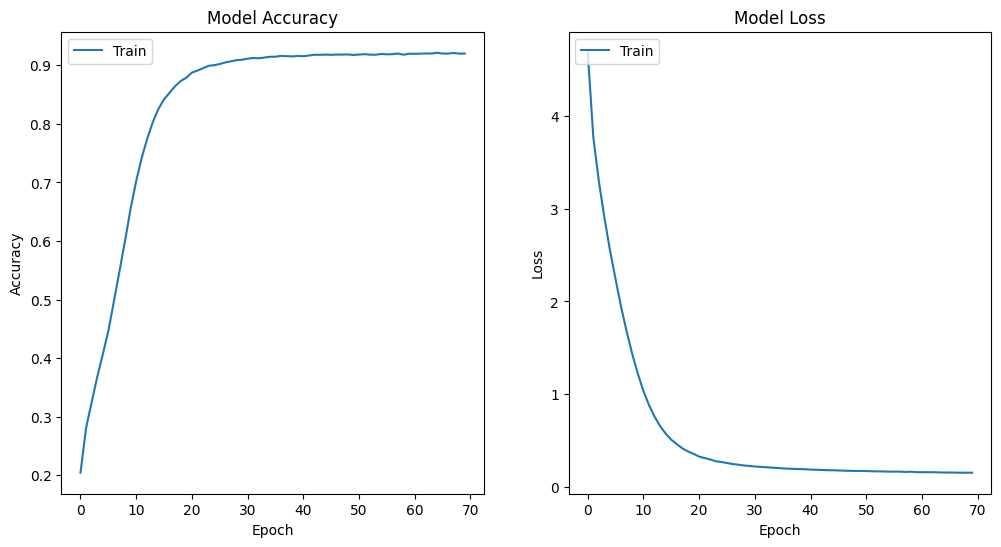

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

# Show the plots
plt.show()

In [ ]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = Image.open(test_img_path)
    if test_img.mode != "RGB":
        test_img = img.convert("RGB")
    test_img = test_img.resize((224, 224))
    img_array = np.array(test_img)
    test_img = img_array.reshape(1, 224, 224, 3)
    return test_img

1/1 [==============================] - 0s 51ms/step


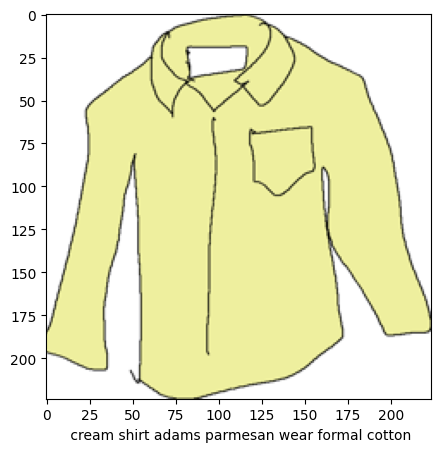

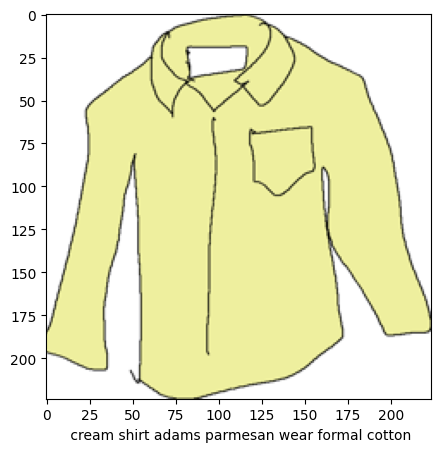

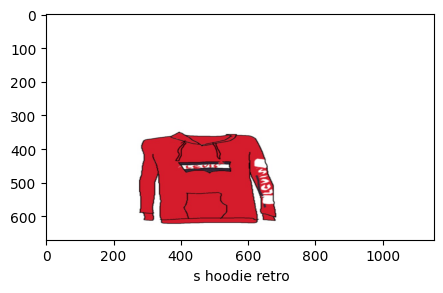

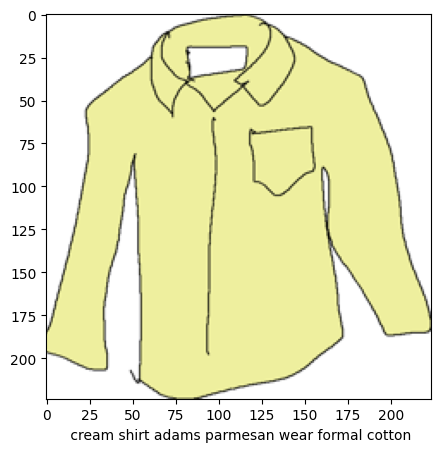

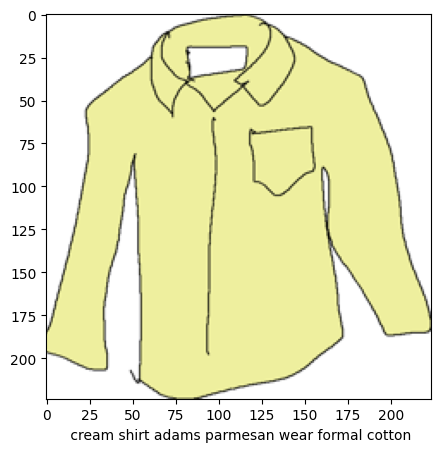

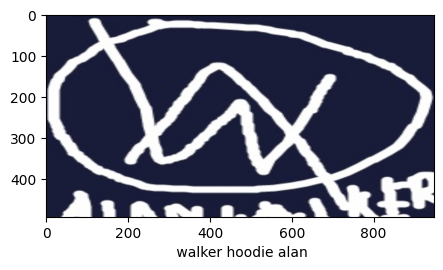

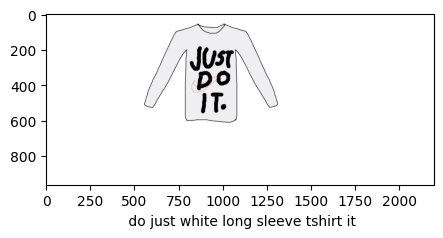

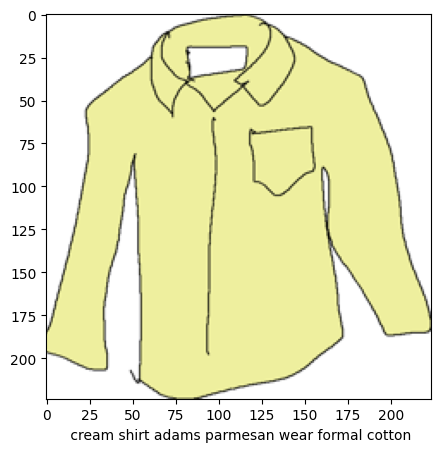

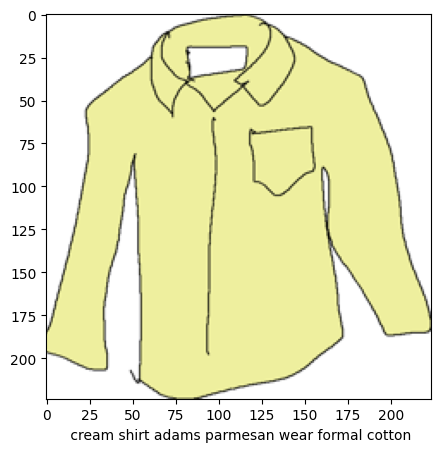

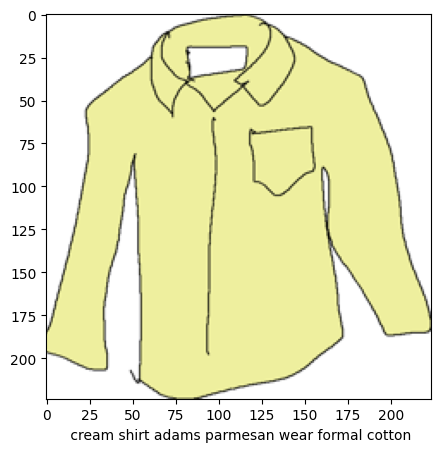

In [ ]:
for i in range(10):
    random_no = np.random.randint(0,226,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = Image.open(test_img_path)
    if test_img.mode != "RGB":
        test_img = img.convert("RGB")
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text

    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []

        for i in pred_text:
            encoded.append(count_words[i])

        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)

    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)

# **#Model 5: ResNet+LSTM (with more layers)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.layers import Reshape

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:

embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)
with strategy.scope():
    # Model for image feature extraction
    img_model = Sequential()

    img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))


    img_model.add(Dense(256, activation='relu'))
    img_model.add(Dense(128, activation='relu'))

    img_model.add(Flatten())
    img_model.add(Dense(256, activation='relu'))
    img_model.add(Dense(128, activation='relu'))
    img_model.add(RepeatVector(MAX_LEN))
    img_model.summary()

    # Model for generating captions from image features
    captions_model = Sequential()
    captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
    captions_model.add(LSTM(256,return_sequences=True))
    captions_model.add(LSTM(256,return_sequences=True))
    captions_model.add(Dropout(0.5))
    captions_model.add(TimeDistributed(Dense(embedding_len)))

    captions_model.summary()

    # Concatenating the outputs of image and caption models
    concat_output = Concatenate()([img_model.output,captions_model.output])
    # First LSTM Layer
    output = LSTM(units=128,return_sequences=True)(concat_output)
    # Second LSTM Layer
    output = LSTM(units=512,return_sequences=False)(output)
    # Output Layer
    output = Dense(units=vocab_size+1,activation='softmax')(output)
    # Creating the final model
    final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
    final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
    final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 14, 128)         

In [ ]:
# mc = ModelCheckpoint('image_caption_generator2.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

# final_model.fit([X,y_in],
#                 y_out,
#                 batch_size=512,
#                 callbacks=mc,
#                 epochs=200)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
with strategy.scope():
    mc = ModelCheckpoint('image_caption_generator2.h5', monitor='accuracy', verbose=1, mode='max', save_best_only=True)

    # Adding EarlyStopping callback with patience 5
    es = EarlyStopping(monitor='accuracy', mode='max', patience=5, verbose=1)

    history = final_model.fit([X, y_in],
                              y_out,
                              batch_size=512,
                              callbacks=[mc, es],
                              epochs=200)

Epoch 1/200
157/157 [==============================] - ETA: 0s - loss: 4.7712 - accuracy: 0.2012
Epoch 1: accuracy improved from -inf to 0.20124, saving model to image_caption_generator2.h5
157/157 [==============================] - 9s 24ms/step - loss: 4.7712 - accuracy: 0.2012
Epoch 2/200
157/157 [==============================] - ETA: 0s - loss: 4.1326 - accuracy: 0.2470
Epoch 2: accuracy improved from 0.20124 to 0.24703, saving model to image_caption_generator2.h5
157/157 [==============================] - 4s 23ms/step - loss: 4.1326 - accuracy: 0.2470
Epoch 3/200
155/157 [============================>.] - ETA: 0s - loss: 3.7232 - accuracy: 0.2844
Epoch 3: accuracy improved from 0.24703 to 0.28474, saving model to image_caption_generator2.h5
157/157 [==============================] - 4s 22ms/step - loss: 3.7219 - accuracy: 0.2847
Epoch 4/200
157/157 [==============================] - ETA: 0s - loss: 3.3769 - accuracy: 0.3193
Epoch 4: accuracy improved from 0.28474 to 0.31933, savin

In [ ]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

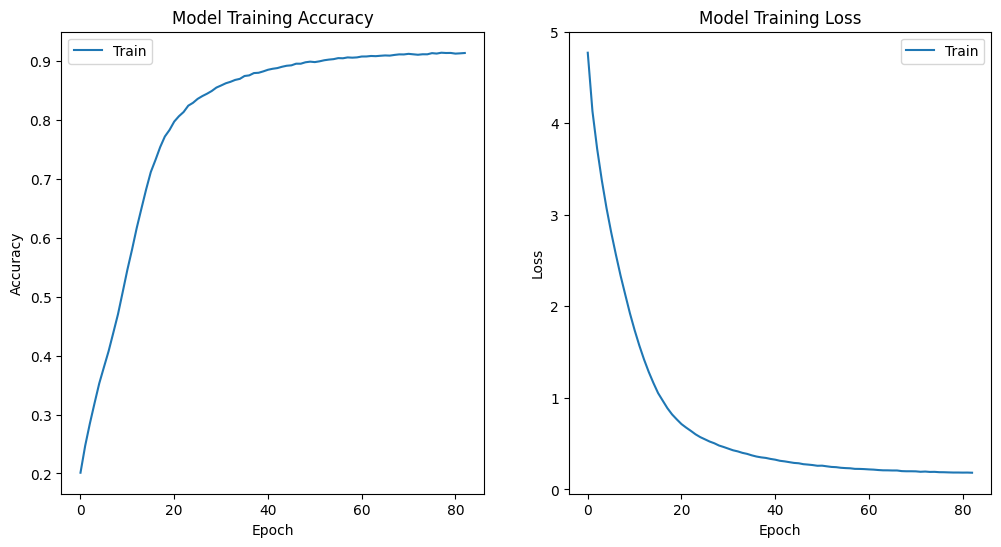

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot training accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()

In [ ]:
final_model.save('image_caption_generator2.h5')

1/1 [==============================] - 0s 64ms/step


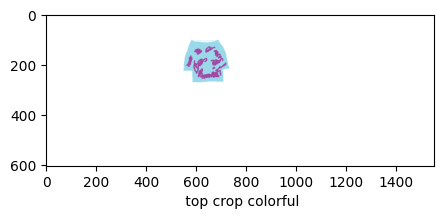

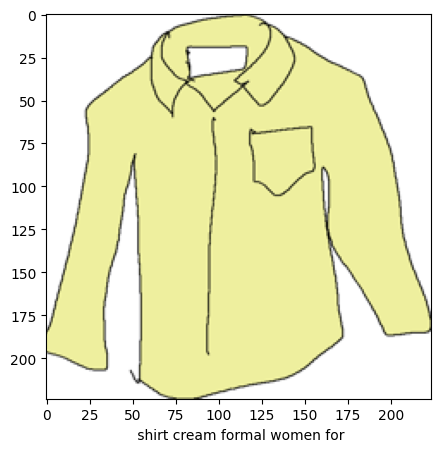

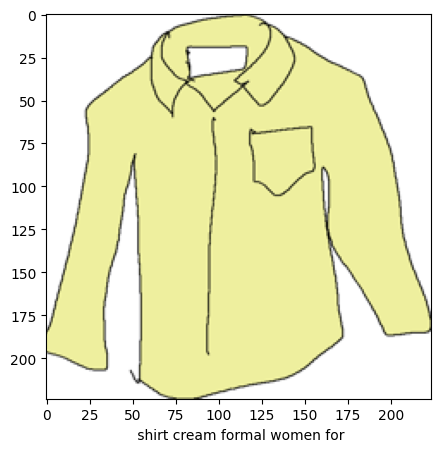

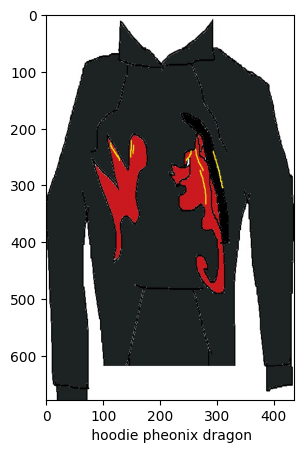

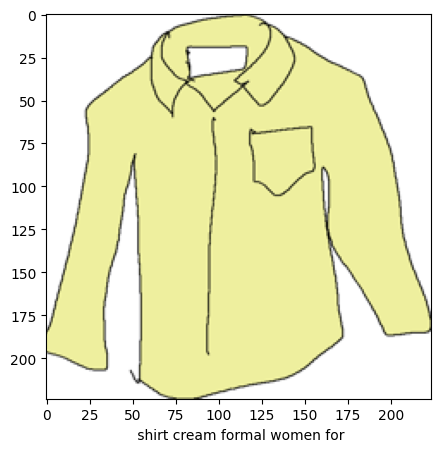

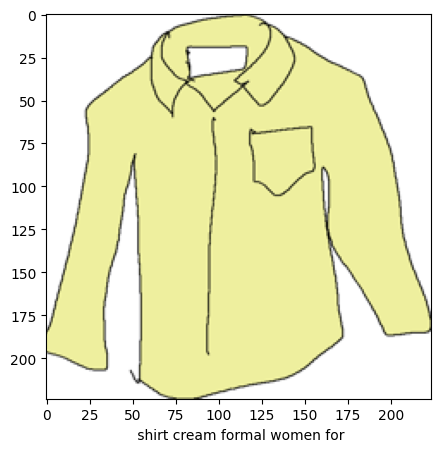

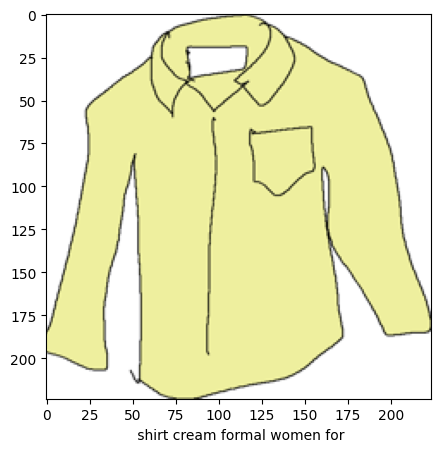

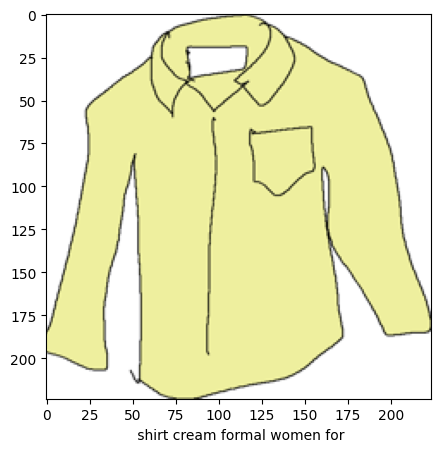

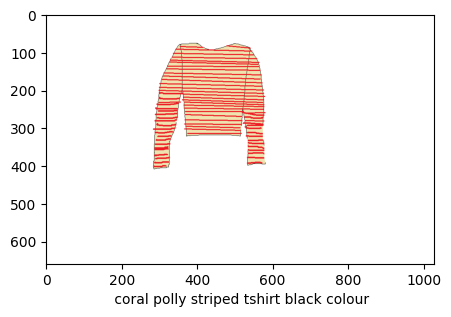

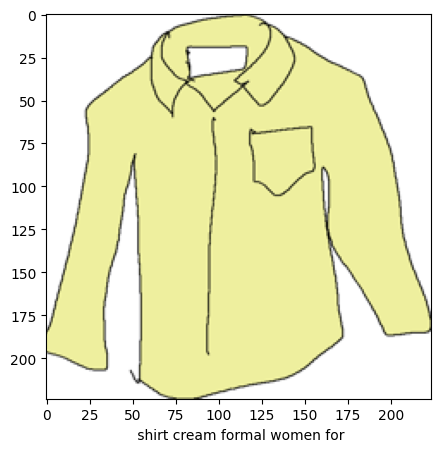

In [ ]:
for i in range(10):
    random_no = np.random.randint(0,226,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = Image.open(test_img_path)
    if test_img.mode != "RGB":
        test_img = img.convert("RGB")
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text

    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []

        for i in pred_text:
            encoded.append(count_words[i])

        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)

    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)

# ***#Model 6: CNN + LSTM (2 layers)***

In [ ]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
# Replace 'your_file.parquet' with the path to your Parquet file
parquet_file_path = 'content/DIP/train_data_processed.parquet'

# Read the Parquet file into a Pandas DataFrame
df_train = pd.read_parquet(parquet_file_path)

# Now you can work with the DataFrame 'df'
df_train.head()


id image_name                                              title
189      190   4333.png                           dot polka magenta blouse
2083    2084   8323.png                          detail crop lace top blue
8614    8615   2319.png  shirt boyfriend size relaxed womens coral flan...
11873  11874  12021.png                                      plaid magenta
7097    7098   1577.png                                shirt green striped

In [ ]:
len(df_train)

11655

In [ ]:
# Replace 'your_file.parquet' with the path to your Parquet file
parquet_file_path = 'content/DIP/validate_data_processed.parquet'

# Read the Parquet file into a Pandas DataFrame
df_valid = pd.read_parquet(parquet_file_path)

# Now you can work with the DataFrame 'df'
df_valid.head()


id image_name                                              title
11387  11388  13277.png                        top printed lemongrass crop
2712    2713   9926.png               shirt and white long red sleeve blue
6742    6743   5276.png  champion leeve logo red with tshirt heritage s...
767      768  11504.png                  and white women striped black for
12367  12368   3074.png  shirt lauren polo ralph t collared long sweats...

In [ ]:
len(df_valid)

1227

In [ ]:
img_path = 'content/DIP/Thesis_Doodle_Files/'
images_train = [os.path.join(img_path, filename) for filename in df_train['image_name']]

images_train[:5]

['content/DIP/Thesis_Doodle_Files/4333.png',
 'content/DIP/Thesis_Doodle_Files/8323.png',
 'content/DIP/Thesis_Doodle_Files/2319.png',
 'content/DIP/Thesis_Doodle_Files/12021.png',
 'content/DIP/Thesis_Doodle_Files/1577.png']

In [ ]:
img_path = 'content/DIP/Thesis_Doodle_Files/'
images_valid = [os.path.join(img_path, filename) for filename in df_valid['image_name']]

images_valid[:5]

['content/DIP/Thesis_Doodle_Files/13277.png',
 'content/DIP/Thesis_Doodle_Files/9926.png',
 'content/DIP/Thesis_Doodle_Files/5276.png',
 'content/DIP/Thesis_Doodle_Files/11504.png',
 'content/DIP/Thesis_Doodle_Files/3074.png']

In [ ]:
len(images_valid)

1227

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in image_paths:
        # Load image using PIL
        img = Image.open(img_path)
        if img.mode != "RGB":
            img = img.convert("RGB")
        # Resize image to the target size
        img = img.resize(target_size)

        # Convert PIL Image to NumPy array
        img_array = np.array(img)

        # Normalize pixel values to the range [0, 1]
        img_array = img_array / 255.0

        # Append the preprocessed image to the list
        images.append(img_array)

    return np.array(images)


In [ ]:
# Load and preprocess images for training
train_images = load_and_preprocess_images(images_train)

# Display the shape of the resulting NumPy array
print("Shape of the preprocessed images array:", train_images.shape)

Shape of the preprocessed images array: (11655, 224, 224, 3)


In [ ]:
# Load and preprocess images for training
valid_images = load_and_preprocess_images(images_valid)

# Display the shape of the resulting NumPy array
print("Shape of the preprocessed images array:", valid_images.shape)

Shape of the preprocessed images array: (1227, 224, 224, 3)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['title'])  # Use the training captions

# Save the tokenizer to a file
tokenizer_path = 'path_to_tokenizer.pkl'
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Convert captions to sequences of integers
sequences_train = tokenizer.texts_to_sequences(df_train['title'])
sequences_valid = tokenizer.texts_to_sequences(df_valid['title'])

# Pad sequences to a fixed length
max_caption_length = max(max(map(len, sequences_train)), max(map(len, sequences_valid)))
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_caption_length, padding='post')
padded_sequences_valid = pad_sequences(sequences_valid, maxlen=max_caption_length, padding='post')

# One-hot encode the padded sequences
captions_train = to_categorical(padded_sequences_train, num_classes=vocab_size)
captions_valid = to_categorical(padded_sequences_valid, num_classes=vocab_size)
# Convert one-hot encoded captions back to integer-encoded sequences
integer_encoded_sequences_train = np.argmax(captions_train, axis=-1)
integer_encoded_sequences_valid = np.argmax(captions_valid, axis=-1)
# Pad sequences to the desired length
padded_sequences_train = pad_sequences(integer_encoded_sequences_train, maxlen=max_caption_length, padding='post')
padded_sequences_valid = pad_sequences(integer_encoded_sequences_valid, maxlen=max_caption_length, padding='post')


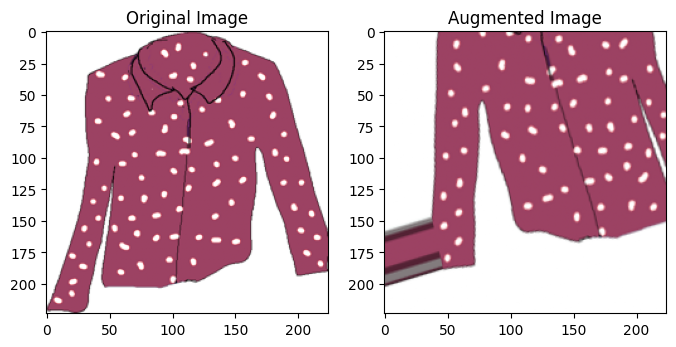

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

with strategy.scope():
    # Create an image data generator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Example of applying augmentation to a single image
    augmented_image = datagen.random_transform(train_images[0])

# Display the original and augmented images (optional)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Augmented Image')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Reshape, LSTM, Dense, Dropout, Embedding, Input
from tensorflow.keras.optimizers import Adam


# Vocabulary size (adjust based on your data)
vocab_size = len(tokenizer.word_index) + 1
with strategy.scope():
    # Define the model
    model1 = Sequential([
        # CNN layers for image feature extraction
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Reshape for LSTM input
        GlobalAveragePooling2D(),
        Reshape((1, 256)),

        # LSTM layers
        LSTM(25, return_sequences=True, stateful=False),
        LSTM(25, stateful=False),

        # Dropout for regularization
        Dropout(0.5),

        # Embedding layer for captions
        Embedding(input_dim=vocab_size, output_dim=50, input_length=max_caption_length),

        # Output layer
        Dense(vocab_size, activation='softmax')  # Adjust output units based on vocabulary size
    ])
    optimizer = Adam(learning_rate=0.001)
    # Compile the model
    # model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Adjust the learning rate as needed
    model1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    # Display the model summary
    model1.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
# # from tensorflow.keras.preprocessing.sequence import pad_sequences

# # # Assuming max_caption_length is the desired sequence length
# # max_caption_length = 25
# # with strategy.scope():
# #     # Pad sequences to the desired length
# #     padded_sequences_train = pad_sequences(integer_encoded_sequences_train, maxlen=max_caption_length, padding='post')
# #     padded_sequences_valid = pad_sequences(integer_encoded_sequences_valid, maxlen=max_caption_length, padding='post')

# #     valid_datagen = ImageDataGenerator()
# #     augmented_valid_data = valid_datagen.flow(valid_images, padded_sequences_valid, batch_size=batch_size)

# #     # Specify the number of epochs and batch size
# #     num_epochs = 500
# #     batch_size = 32

# #     # Train the model using the padded sequences
# #     history = model1.fit(
# #         datagen.flow(train_images, padded_sequences_train, batch_size=batch_size),
# #         validation_data=augmented_valid_data,
# #         #validation_data=(valid_images, padded_sequences_valid),
# #         epochs=num_epochs,
# #     )
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming max_caption_length is the desired sequence length
max_caption_length = 25
batch_size = 32  # Move the batch_size definition to the top

with strategy.scope():
    # Pad sequences to the desired length
    padded_sequences_train = pad_sequences(integer_encoded_sequences_train, maxlen=max_caption_length, padding='post')
    padded_sequences_valid = pad_sequences(integer_encoded_sequences_valid, maxlen=max_caption_length, padding='post')

    valid_datagen = ImageDataGenerator()
    augmented_valid_data = valid_datagen.flow(valid_images, padded_sequences_valid, batch_size=batch_size)

    # Specify the number of epochs
    num_epochs = 500

    # Adding EarlyStopping callback with patience 5
    es = EarlyStopping(monitor='loss', mode='min', patience=5, verbose=1)

    # Train the model using the padded sequences
    history = model1.fit(
    train_images,  # Use the original training data
    padded_sequences_train,
    validation_data=(valid_images, padded_sequences_valid),
    epochs=num_epochs,
    batch_size=batch_size,  # If batch size is specified in your original code
    )


# import matplotlib.pyplot as plt
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Assuming max_caption_length is the desired sequence length
# max_caption_length = 25
# batch_size = 32  # Move the batch_size definition to the top

# with strategy.scope():
#     # Pad sequences to the desired length
#     padded_sequences_train = pad_sequences(integer_encoded_sequences_train, maxlen=max_caption_length, padding='post')
#     padded_sequences_valid = pad_sequences(integer_encoded_sequences_valid, maxlen=max_caption_length, padding='post')

#     # Specify the number of epochs
#     num_epochs = 500

#     # Adding EarlyStopping callback with patience 5
#     es = EarlyStopping(monitor='loss', mode='min', patience=5, verbose=1)

#     # Train the model using the padded sequences
#     history = model1.fit(
#         x=[train_images, padded_sequences_train],
#         y=train_labels,  # Assuming train_labels is your target variable
#         batch_size=batch_size,
#         validation_data=([valid_images, padded_sequences_valid], valid_labels),  # Assuming valid_labels is your validation target variable
#         epochs=num_epochs,
#         callbacks=[es]  # Include EarlyStopping callback
#     )


Epoch 1/500
365/365 [==============================] - 8s 14ms/step - loss: 3.7985 - accuracy: 0.7479 - val_loss: 1.8331 - val_accuracy: 0.7666
Epoch 2/500
365/365 [==============================] - 4s 10ms/step - loss: 1.8353 - accuracy: 0.7647 - val_loss: 1.8298 - val_accuracy: 0.7666
Epoch 3/500
365/365 [==============================] - 4s 10ms/step - loss: 1.8338 - accuracy: 0.7647 - val_loss: 1.8303 - val_accuracy: 0.7666
Epoch 4/500
365/365 [==============================] - 4s 11ms/step - loss: 1.8336 - accuracy: 0.7647 - val_loss: 1.8307 - val_accuracy: 0.7666
Epoch 5/500
365/365 [==============================] - 4s 11ms/step - loss: 1.8336 - accuracy: 0.7647 - val_loss: 1.8307 - val_accuracy: 0.7666
Epoch 6/500
365/365 [==============================] - 4s 10ms/step - loss: 1.8337 - accuracy: 0.7647 - val_loss: 1.8310 - val_accuracy: 0.7666
Epoch 7/500
365/365 [==============================] - 4s 10ms/step - loss: 1.8337 - accuracy: 0.7647 - val_loss: 1.8307 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
# Assuming model1 is your trained model
model1.save('content/CNN_2layers.h5')

In [ ]:
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot training and validation loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
df_test = pd.read_parquet('/content/test_data_processed.parquet')
df_test.head()

In [ ]:
img_path = '/content/DIP/Thesis_Doodle_Files/'
images_test = [os.path.join(img_path, filename) for filename in df_test['image_name']]

images_train[:5]

In [ ]:
def preprocess_test_image(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    if img.mode != "RGB":
            img = img.convert("RGB")

    # Resize the image to match the input size of your model
    img = img.resize((224, 224))

    # Convert the image to a NumPy array and normalize pixel values
    img_array = np.array(img) / 255.0

    # Expand dimensions to create a batch-like structure
    img_array = np.expand_dims(img_array, axis=0)

    return img_array


In [ ]:
# Load and preprocess images for testing
test_images = load_and_preprocess_images(images_test)

# Display the shape of the resulting NumPy array
print("Shape of the preprocessed test images array:", test_images.shape)


In [ ]:
# Convert test captions to sequences of integers
sequences_test = tokenizer.texts_to_sequences(df_test['title'])

# Pad sequences to a fixed length
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_caption_length, padding='post')

# One-hot encode the padded sequences
captions_test = to_categorical(padded_sequences_test, num_classes=vocab_size)

# Convert one-hot encoded captions back to integer-encoded sequences
integer_encoded_sequences_test = np.argmax(captions_test, axis=-1)

# Pad sequences to the desired length
padded_sequences_test = pad_sequences(integer_encoded_sequences_test, maxlen=max_caption_length, padding='post')


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model1.evaluate(test_images, padded_sequences_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
# Load your trained model
model = load_model('/content/my_model1.h5')

# Function to preprocess a test image
def preprocess_test_image(image_path):
    img = Image.open(image_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to generate captions for a given image
def generate_caption(image_path, max_caption_length=25):
    # Preprocess the test image
    test_image = preprocess_test_image(image_path)

    # Convert the NumPy array to a TensorFlow tensor
    test_image_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)

    # Use the trained model to predict captions
    predictions = model.predict(test_image_tensor)

    # Convert predictions to sequences of integers
    predicted_sequence = np.argmax(predictions, axis=-1)

    # Convert integer sequence to words using the tokenizer
    caption = tokenizer.sequences_to_texts(predicted_sequence)[0]

    return caption

# Example usage
image_path_to_test = '/content/DIP/Thesis_Doodle_Files/155.png'
predicted_caption = generate_caption(image_path_to_test)
print("Predicted Caption:", predicted_caption)


In [ ]:

# Load the tokenizer from the saved file
tokenizer_path = '/content/path_to_tokenizer.pkl'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

# Set the maximum caption length
max_caption_length = 25  # Assuming this is the maximum length you used during training


In [ ]:

# Preprocess test images
test_images = [preprocess_test_image(img_path) for img_path in images_test]
test_images = np.vstack(test_images)

# Make predictions on the test set
predictions = model1.predict(test_images)

# Decode predictions to text
# Decode predictions to text
predicted_captions = []
for prediction in predictions:
    predicted_caption = []
    for word_probabilities in prediction:
        predicted_index = np.argmax(word_probabilities)
        predicted_word = tokenizer.index_word.get(predicted_index, '<OOV>')  # Use '<OOV>' for out-of-vocabulary words
        if predicted_word is not None:
            predicted_caption.append(predicted_word)
    predicted_captions.append(" ".join(predicted_caption))

# Add the predicted captions to the test DataFrame
df_test['predicted_caption'] = predicted_captions

# Display the test DataFrame with predicted captions
predicted_captions = [caption.split() for caption in predicted_captions]

# Calculate BLEU score
bleu_scores = [sentence_bleu([actual], predicted, weights=(0.25, 0.25, 0.25, 0.25)) for actual, predicted in zip(actual_captions, predicted_captions)]

# Display average BLEU score
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu}")


print(df_test[['image_name', 'predicted_caption']])


In [ ]:
for actual, predicted in zip(actual_captions, predicted_captions):
    print(f"Predicted: {predicted}")

# ***#Model 7: CNN+LSTM (4 Layers)***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Reshape, LSTM, Dense, Dropout, Embedding, Input, BatchNormalization
from keras.layers import Dense, Dropout, Flatten

In [ ]:
# Vocabulary size (adjust based on your data)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
with strategy.scope():
    model4 = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),

        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Reshape((1, 512)),

        LSTM(25, return_sequences=True),
        Dropout(0.5),
        LSTM(25),  # Apply dropout for regularization  In case bad 256
        # Output layer
        Embedding(input_dim=vocab_size, output_dim=50, input_length=max_caption_length),

        # Output layer
        Dense(vocab_size, activation='softmax')


    ])

In [ ]:
with strategy.scope():
    BatchNormalization(trainable=True)
    # Compile the model
    model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Display the model summary
    model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 220, 220, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                      

In [ ]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Assuming max_caption_length is the desired sequence length
# max_caption_length = 25  # incase256

# # Pad sequences to the desired length
# padded_sequences_train = pad_sequences(integer_encoded_sequences_train, maxlen=max_caption_length, padding='post')
# padded_sequences_valid = pad_sequences(integer_encoded_sequences_valid, maxlen=max_caption_length, padding='post')

# valid_datagen = ImageDataGenerator()
# augmented_valid_data = valid_datagen.flow(valid_images, padded_sequences_valid, batch_size=batch_size)

# # Specify the number of epochs and batch size
# num_epochs = 3
# batch_size = 32

# # Train the model using the padded sequences
# history = model4.fit(
#     datagen.flow(train_images, padded_sequences_train, batch_size=batch_size),
#     validation_data=augmented_valid_data,
#     #validation_data=(valid_images, padded_sequences_valid),
#     epochs=num_epochs,
# )

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming max_caption_length is the desired sequence length
max_caption_length = 25

with strategy.scope():
    # Pad sequences to the desired length
    padded_sequences_train = pad_sequences(integer_encoded_sequences_train, maxlen=max_caption_length, padding='post')
    padded_sequences_valid = pad_sequences(integer_encoded_sequences_valid, maxlen=max_caption_length, padding='post')

    valid_datagen = ImageDataGenerator()
    augmented_valid_data = valid_datagen.flow(valid_images, padded_sequences_valid, batch_size=batch_size)

    # Specify the number of epochs and batch size
    num_epochs = 500
    batch_size = 32

    # Adding EarlyStopping callback with patience 5
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model using the padded sequences and add EarlyStopping
    history = model4.fit(
        datagen.flow(train_images, padded_sequences_train, batch_size=batch_size),
        validation_data=augmented_valid_data,
        # validation_data=(valid_images, padded_sequences_valid),
        epochs=num_epochs,
        callbacks=[early_stopping]  # Include EarlyStopping callback
    )




Epoch 1/500
365/365 [==============================] - 59s 153ms/step - loss: 1.8361 - accuracy: 0.7647 - val_loss: 1.8317 - val_accuracy: 0.7666
Epoch 2/500
365/365 [==============================] - 59s 160ms/step - loss: 1.8339 - accuracy: 0.7647 - val_loss: 1.8312 - val_accuracy: 0.7666
Epoch 3/500
365/365 [==============================] - 57s 155ms/step - loss: 1.8336 - accuracy: 0.7647 - val_loss: 1.8309 - val_accuracy: 0.7666
Epoch 4/500
365/365 [==============================] - 59s 163ms/step - loss: 1.8335 - accuracy: 0.7647 - val_loss: 1.8305 - val_accuracy: 0.7666
Epoch 5/500
365/365 [==============================] - 56s 154ms/step - loss: 1.8335 - accuracy: 0.7647 - val_loss: 1.8307 - val_accuracy: 0.7666
Epoch 6/500
365/365 [==============================] - 58s 160ms/step - loss: 1.8336 - accuracy: 0.7647 - val_loss: 1.8306 - val_accuracy: 0.7666
Epoch 7/500
365/365 [==============================] - 57s 156ms/step - loss: 1.8335 - accuracy: 0.7647 - val_loss: 1.8315 -

In [ ]:
# Assuming model1 is our trained model
model1.save('content/cnn_4layers.h5')

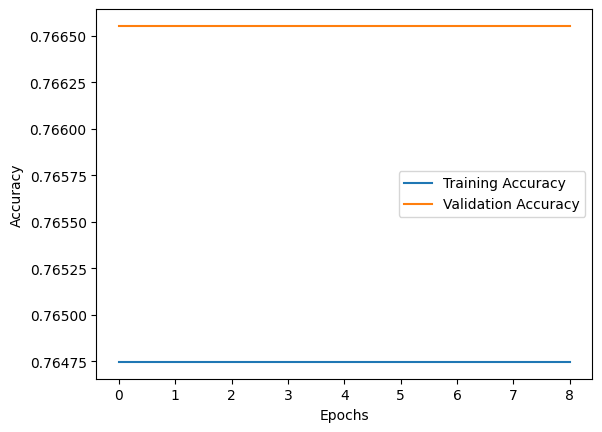

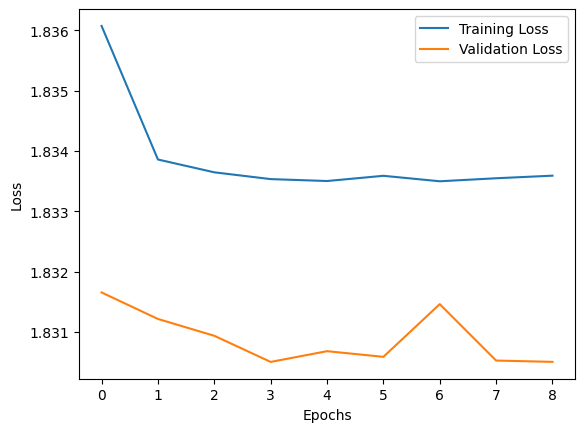

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
df_test = pd.read_parquet('content/DIP/test_data_processed.parquet')
df_test.head()

id image_name                                              title
10189  10190   7187.png    light for tunic women yellow sleeve short dress
7391    7392   6602.png  lava large mens raglan blackcharcoal hoodie sw...
8939    8940   4520.png                                        hoodie baja
5260    5261   7457.png  loose dark fit bluewhite striped anna field ho...
781      782   9601.png  shirt heather and collar t long green sleeve r...

In [ ]:
img_path = 'content/DIP/Thesis_Doodle_Files/'
images_test = [os.path.join(img_path, filename) for filename in df_test['image_name']]

images_train[:5]

['content/DIP/Thesis_Doodle_Files/4333.png',
 'content/DIP/Thesis_Doodle_Files/8323.png',
 'content/DIP/Thesis_Doodle_Files/2319.png',
 'content/DIP/Thesis_Doodle_Files/12021.png',
 'content/DIP/Thesis_Doodle_Files/1577.png']

In [ ]:
def preprocess_test_image(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    if img.mode != "RGB":
            img = img.convert("RGB")

    # Resize the image to match the input size of your model
    img = img.resize((224, 224))

    # Convert the image to a NumPy array and normalize pixel values
    img_array = np.array(img) / 255.0

    # Expand dimensions to create a batch-like structure
    img_array = np.expand_dims(img_array, axis=0)

    return img_array


In [ ]:
# Load and preprocess images for testing
test_images = load_and_preprocess_images(images_test)

# Display the shape of the resulting NumPy array
print("Shape of the preprocessed test images array:", test_images.shape)


Shape of the preprocessed test images array: (68, 224, 224, 3)


In [ ]:
# Convert test captions to sequences of integers
sequences_test = tokenizer.texts_to_sequences(df_test['title'])

# Pad sequences to a fixed length
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_caption_length, padding='post')

# One-hot encode the padded sequences
captions_test = to_categorical(padded_sequences_test, num_classes=vocab_size)

# Convert one-hot encoded captions back to integer-encoded sequences
integer_encoded_sequences_test = np.argmax(captions_test, axis=-1)

# Pad sequences to the desired length
padded_sequences_test = pad_sequences(integer_encoded_sequences_test, maxlen=max_caption_length, padding='post')


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model4.evaluate(test_images, padded_sequences_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

3/3 [==============================] - 0s 64ms/step - loss: 1.7578 - accuracy: 0.7776
Test Loss: 1.7578140497207642
Test Accuracy: 0.777647078037262


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from PIL import Image
import numpy as np

# Load your trained model
model = load_model('content/cnn_4layers.h5')

# Function to preprocess a test image
def preprocess_test_image(image_path):
    img = Image.open(image_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to generate captions for a given image
def generate_caption(image_path, max_caption_length=25):
    # Preprocess the test image
    test_image = preprocess_test_image(image_path)

    # Convert the NumPy array to a TensorFlow tensor
    test_image_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)

    # Use the trained model to predict captions
    predictions = model.predict(test_image_tensor)

    # Convert predictions to sequences of integers
    predicted_sequence = np.argmax(predictions, axis=-1)

    # Convert integer sequence to words using the tokenizer
    caption = tokenizer.sequences_to_texts(predicted_sequence)[0]

    return caption

# Example usage
image_path_to_test = 'test3.png'
predicted_caption = generate_caption(image_path_to_test)
print("Predicted Caption:", predicted_caption)


1/1 [==============================] - 0s 308ms/step
Predicted Caption: 


In [ ]:

# Load the tokenizer from the saved file
tokenizer_path = 'path_to_tokenizer.pkl'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

# Set the maximum caption length
max_caption_length = 25  # Assuming this is the maximum length you used during training


In [ ]:

# Preprocess test images
test_images = [preprocess_test_image(img_path) for img_path in images_test]
test_images = np.vstack(test_images)


Make predictions on the test set
predictions = model1.predict(test_images)

# Decode predictions to text
# Decode predictions to text
predicted_captions = []
for prediction in predictions:
    predicted_caption = []
    for word_probabilities in prediction:
        predicted_index = np.argmax(word_probabilities)
        predicted_word = tokenizer.index_word.get(predicted_index, '<OOV>')  # Use '<OOV>' for out-of-vocabulary words
        if predicted_word is not None:
            predicted_caption.append(predicted_word)
    predicted_captions.append(" ".join(predicted_caption))

# Add the predicted captions to the test DataFrame
df_test['predicted_caption'] = predicted_captions

# Display the test DataFrame with predicted captions
predicted_captions = [caption.split() for caption in predicted_captions]

# Calculate BLEU score
bleu_scores = [sentence_bleu([actual], predicted, weights=(0.25, 0.25, 0.25, 0.25)) for actual, predicted in zip(actual_captions, predicted_captions)]

# Display average BLEU score
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu}")


print(df_test[['image_name', 'predicted_caption']])


KeyError: 'predicted_caption'